# Описание данных
В данной работе используется база ЭКГ сигналов [PTB-XL](https://physionet.org/content/ptb-xl/1.0.1/), содержащая 21837 записей необработанных сигналов электрокардиограмм. Каждая запись содержит 12 сигналов с разных отведений, 10 секунд каждый. Записи в двух разрешениях - 100Гц и 500Гц. Также имеется описание данных, содержащее некоторую информацию о пациенте, условий получения ЭКГ и заключение врача. Заключение врача описывается в виде подробного диагноза и не поддается простому разбиению на классы, однако согласно описанию данных, каждой записи были присвоены специальные метки, верифицированные двумя кардиологами.
Датасет содержит 44 класса диагнозов, агрегированных в 5 суперклассов:
- NORM - Normal ECG
- MI - Myocardial Infarction
- STTC - ST/T change
- CD - Conduction Disturbance
- HYP - Hypertrophy

Классы пересекаются между собой

Описание задачи
=========

Необходимо по ЭКГ определить наличие каждого из 5 классов:
- NORM - Normal ECG
- MI - Myocardial Infarction
- STTC - ST/T change
- CD - Conduction Disturbance
- HYP - Hypertrophy

# Описание реализации

Вместо того, чтобы использовать в алгоритмах необработанные сигналы ЭКГ, я выделил из данных макрохарактеристики. Для чтения и перевода в вид массива ЭКГ сигналов использовалась библиотека wfdb(waveform-database)

Для сегментации была использована специально обученная на фреймворке pytorch нейросеть. Результаты сегментации были записаны в формате json в виде:
- начало волны (в единицах сигнала)
- конец волны (в единицах сигнала)
- тип волны (p, qrs, t или none)

В качестве макрохарактеристик из описания данных были вхзяты:
- SEX - пол (из описания данных, содежит пропущенные значения)
- AGE - возраст (из описания данных, содержит пропущенные значения)
- HEIGHT - рост (из описания данных, содержит пропущенные значения)
- WEIGHT - вес (из описания данных, содержит пропущенные значения)

Из сегментации сигнала с каждого из отведений были выделены следующие признаки:
- HR - heart rate, пульс, считался через количество qrs комплексов / длину записи
- P_AV - средняя длина p волны (мс)
- P_DEV - среднеквадратичное отклонение длины p волны (мс)
- P_A_AV - средняя амплитуда p волны
- P_A_DEV - среднеквадратичное отклонение амплитуды волны
- QRS_AV - средняя длина qrs комплекса (мс)
- QRS_DEV - среднеквадратичное отклонение длины qrs комплекса (мс)
- QRS_A_AV - средняя амплитуда qrs комплекса
- QRS_A_DEV - среднеквадратичное отклонение амплитуды qrs комплекса
- T_AV - cредняя длина t волны (мс)
- T_DEV - cреднеквадратичное отклонение длины t волны (мс)
- T_A_AV - средняя амплитуда t волны
- T_A_DEV - среднеквадратичное отклонение амплитуды t волны
- PR_INT_AV - cредняя длина pr интервала (мс)
- PR_INT_DEV - cреднеквадратичное отклонение длины pr интервала (мс)
- PR_SEGM_AV - cредняя длина pr сегмента (мс)
- PR_SEGM_DEV - cреднеквадратичное отклонение длины pr сегмента (мс)
- ST_SEGM_AV - cредняя длина st сегмента (мс)
- ST_SEGM_DEV - cреднеквадратичное отклонение длины st сегмента (мс)
- QT_INT_AV - cредняя длина qt интервала (мс)
- QT_INT_DEV - cреднеквадратичное отклонение длины qt интервала (мс)
- QRSA_AV - средняя площадь QRS сегмента, где площадь QRS = width * height * 0.5
- QRSA_DEV - среднеквадратичное отклонение площади QRS сегмента, где площадь QRS = width * height * 0.5
- QRSTA_AV = средняя площадь QRST сегмента, где площадь QRST =  QRSA + 0.5 * width_of_T * height_of_T
- QRSTA_DEV = среднеквадратичное отклонение площади QRST сегмента, где площадь QRST =  QRSA + 0.5 * width_of_T * height_of_T

Итого 4 признака из описания данных, 25 признаков на каждый из 12 сигналов и 25 - средние значения по всем сигналам. Всего 329 признаков

Кроме того данные после обработки содержат 10 столбцов-классов (5 показывают, относится ли данная запись к какому-либо из классов, а еще 5 содержат вероятность принадлежности (но не вероятность того, что запись не принадлежит классу)):

# Реализация задачи

## Получение данных

Код для скачивания и распаковки PTB-XL:

In [ ]:
# Code for download database
# Requires urllib package

import os
import urllib.request
from zipfile import ZipFile

DOWNLOAD_URL = "https://storage.googleapis.com/ptb-xl-1.0.1.physionet.org/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip"
ZIP_FILE_NAME = 'PTB_XL.zip'

def fetch_and_extractPTB_XL_Data(data_url = DOWNLOAD_URL):
    zip_path = os.path.join(ZIP_FILE_NAME)
    urllib.request.urlretrieve(data_url, zip_path)
    with ZipFile(ZIP_FILE_NAME, 'r') as zfile:
        zfile.extractall(SAVE_PATH)
    os.remove(ZIP_FILE_NAME)

fetch_and_extractPTB_XL_Data()

## Сегментация данных

Далее воспользуемся натренированной на pytorch нейронной сетью для сегментации сигналов на p, qrs и t сегменты.
Скрипт, используемый мною для сегментации (пути до модели и до базы данных задаются через глобальные переменные вручную, результат сохраняется в виде формата json там же, где лежат сами сигналы):

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import wfdb
from ipywidgets import IntProgress
from IPython.display import display

ecg_signal_len = 5000
sample_rate = 500
border = int(0.8 * sample_rate)
path_to_model = "Segmentation_model/"
path_to_data = "ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"

class Delineation:
    def __init__(self):
        self._model = torch.jit.load(path_to_model + "model.pt")
        self._max_dist = int(0.03 * sample_rate)
        self._border = border
        
    def _remove_small(self, signal):
        last_zero = 0
        for i in range(len(signal)):
            if signal[i] == 0:
                if i - last_zero < self._max_dist:
                    signal[last_zero:i] = 0
                last_zero = i

    def _merge_small(self, signal):
        lasts = np.full(signal.max() + 1, -(self._max_dist+1))
        for i in range(len(signal)):
            m = signal[i]
            if i - lasts[m] < self._max_dist and m > 0:
                signal[lasts[m]:i] = m
            lasts[m] = i

    def _mask_to_delineation(self, data):
        masks = np.argmax(data, 1)
        delineation = []
        v_to_del = {0:'none', 1:'p', 2:'qrs', 3:'t'}
        for rec in masks:
            self._merge_small(rec)
            self._remove_small(rec)
            rec_del = []
            i = 0
            rec_len = len(rec)
            while i < rec_len:
                v = rec[i]
                if v > 0:
                    rec_del.append({
                        "begin": i,
                        "end": 0,
                        "type": v_to_del[v]
                    })
                    while i < rec_len and rec[i] == v:
                        rec_del[-1]["end"] = i
                        i += 1
                    t = rec_del[-1]
                    if t["begin"] < self._border or t["end"] > rec_len - self._border:
                        rec_del.pop()
                i += 1
            d_res = []
            for c, n in zip(rec_del[:-1], rec_del[1:]):
                d_res.append(c)
                d_res.append({
                    "begin": c["end"],
                    "end": n["begin"],
                    "type": "none"
                })
            if rec_del:
                begin = {
                    "begin": 0,
                    "end": rec_del[0]["begin"],
                    "type": "none"
                }
                end = {
                    "begin": rec_del[-1]["end"],
                    "end": rec_len,
                    "type": "none"
                }
                d_res = [begin] + d_res + [rec_del[-1], end]
            else:
                d_res.append({
                    "begin": 0,
                    "end": rec_len,
                    "type": "none"
                })
            delineation.append(d_res)
        return delineation

    def __call__(self, signal):
        signal = torch.FloatTensor(np.expand_dims(signal, axis=1))
        masks = self._model(signal).data.numpy()
        return self._mask_to_delineation(masks)

def main():
    database_info = pd.read_csv(path_to_data + 'ptbxl_database.csv', index_col='ecg_id')
    progress = IntProgress(min=0, max=len(database_info.index), value=0)
    display(progress)
    delineation = Delineation()
    for f in database_info.filename_hr:
        signal, meta = wfdb.rdsamp(path_to_data+f)
        data = np.array(signal)
        data_transp = np.transpose(data)
        result = delineation(data_transp)
        with open(path_to_data + f + ".json", "w") as write_file:
            json.dump(result, write_file)
        progress.value += 1

if __name__ == "__main__":
    main()

## Выделение макрохарактеристик

После сегментации необходимо выделить перечисленные в описании реализации характеристики

In [1]:
import pandas as pd

Создадим DataFrame для итогового результата:

In [2]:
attr_names = ['HR', 'P_AV', 'P_DEV', 'P_A_AV', 'P_A_DEV', 'QRS_AV', 'QRS_DEV', 'QRS_A_AV', 'QRS_A_DEV', 'T_AV', 'T_DEV', 'T_A_AV', 'T_A_DEV', 'PR_INT_AV', 'PR_INT_DEV', 'PR_SEGM_AV', 'PR_SEGM_DEV', 'ST_SEGM_AV',  'ST_SEGM_DEV', 
    'QT_INT_AV', 'QT_INT_DEV', 'QRSA_AV', 'QRSA_DEV', 'QRSTA_AV', 'QRSTA_DEV']
attributes = ["SEX", "AGE", "HEIGHT", "WEIGHT"] + ['ALL_C_' + attr_name for attr_name in attr_names] + [ch_name + '_C_' + attr_name for ch_name in ch_names for attr_name in attr_names]

macro_data = pd.DataFrame(columns=attributes)
macro_data

Empty DataFrame
Columns: [SEX, AGE, HEIGHT, WEIGHT, ALL_C_HR, ALL_C_P_AV, ALL_C_P_DEV, ALL_C_P_A_AV, ALL_C_P_A_DEV, ALL_C_QRS_AV, ALL_C_QRS_DEV, ALL_C_QRS_A_AV, ALL_C_QRS_A_DEV, ALL_C_T_AV, ALL_C_T_DEV, ALL_C_T_A_AV, ALL_C_T_A_DEV, ALL_C_PR_INT_AV, ALL_C_PR_INT_DEV, ALL_C_PR_SEGM_AV, ALL_C_PR_SEGM_DEV, ALL_C_ST_SEGM_AV, ALL_C_ST_SEGM_DEV, ALL_C_QT_INT_AV, ALL_C_QT_INT_DEV, ALL_C_QRSA_AV, ALL_C_QRSA_DEV, ALL_C_QRSTA_AV, ALL_C_QRSTA_DEV, I_C_HR, I_C_P_AV, I_C_P_DEV, I_C_P_A_AV, I_C_P_A_DEV, I_C_QRS_AV, I_C_QRS_DEV, I_C_QRS_A_AV, I_C_QRS_A_DEV, I_C_T_AV, I_C_T_DEV, I_C_T_A_AV, I_C_T_A_DEV, I_C_PR_INT_AV, I_C_PR_INT_DEV, I_C_PR_SEGM_AV, I_C_PR_SEGM_DEV, I_C_ST_SEGM_AV, I_C_ST_SEGM_DEV, I_C_QT_INT_AV, I_C_QT_INT_DEV, I_C_QRSA_AV, I_C_QRSA_DEV, I_C_QRSTA_AV, I_C_QRSTA_DEV, II_C_HR, II_C_P_AV, II_C_P_DEV, II_C_P_A_AV, II_C_P_A_DEV, II_C_QRS_AV, II_C_QRS_DEV, II_C_QRS_A_AV, II_C_QRS_A_DEV, II_C_T_AV, II_C_T_DEV, II_C_T_A_AV, II_C_T_A_DEV, II_C_PR_INT_AV, II_C_PR_INT_DEV, II_C_PR_SEGM_AV, II_C_PR_SEGM_DEV, II_C_ST_SEGM_AV, II_C_ST_SEGM_DEV, II_C_QT_INT_AV, II_C_QT_INT_DEV, II_C_QRSA_AV, II_C_QRSA_DEV, II_C_QRSTA_AV, II_C_QRSTA_DEV, III_C_HR, III_C_P_AV, III_C_P_DEV, III_C_P_A_AV, III_C_P_A_DEV, III_C_QRS_AV, III_C_QRS_DEV, III_C_QRS_A_AV, III_C_QRS_A_DEV, III_C_T_AV, III_C_T_DEV, III_C_T_A_AV, III_C_T_A_DEV, III_C_PR_INT_AV, III_C_PR_INT_DEV, III_C_PR_SEGM_AV, III_C_PR_SEGM_DEV, III_C_ST_SEGM_AV, III_C_ST_SEGM_DEV, III_C_QT_INT_AV, III_C_QT_INT_DEV, ...]
Index: []

[0 rows x 329 columns]

Для начала рассмотрим описание данных

In [211]:
path_to_data = "ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"
database_info = pd.read_csv(path_to_data+'ptbxl_database.csv', index_col='ecg_id')
database_info

patient_id   age  sex  height  weight  nurse  site      device  \
ecg_id                                                                   
1          15709.0  56.0    1     NaN    63.0    2.0   0.0   CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0   CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0   CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0   CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0   CS-12   E   
...            ...   ...  ...     ...     ...    ...   ...         ...   
21833      17180.0  67.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21834      20703.0  93.0    0     NaN     NaN    1.0   2.0  AT-60    3   
21835      19311.0  59.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21836       8873.0  64.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21837      11744.0  68.0    0     NaN     NaN    1.0   2.0  AT-60    3   

             recording_date  \
ecg_id                        
1       1984-11-09 09:17:34   
2       1984-11-14 12:55:37   
3       1984-11-15 12:49:10   
4       1984-11-15 13:44:57   
5       1984-11-17 10:43:15   
...                     ...   
21833   2001-05-31 09:14:35   
21834   2001-06-05 11:33:39   
21835   2001-06-08 10:30:27   
21836   2001-06-09 18:21:49   
21837   2001-06-11 16:43:01   

                                                   report  ...  \
ecg_id                                                     ...   
1                  sinusrhythmus periphere niederspannung  ...   
2                     sinusbradykardie sonst normales ekg  ...   
3                              sinusrhythmus normales ekg  ...   
4                              sinusrhythmus normales ekg  ...   
5                              sinusrhythmus normales ekg  ...   
...                                                   ...  ...   
21833   ventrikulÄre extrasystole(n) sinustachykardie ...  ...   
21834   sinusrhythmus lagetyp normal qrs(t) abnorm    ...  ...   
21835   sinusrhythmus lagetyp normal t abnorm in anter...  ...   
21836   supraventrikulÄre extrasystole(n) sinusrhythmu...  ...   
21837   sinusrhythmus p-sinistrocardiale lagetyp norma...  ...   

       validated_by_human  baseline_drift static_noise burst_noise  \
ecg_id                                                               
1                    True             NaN    , I-V1,           NaN   
2                    True             NaN          NaN         NaN   
3                    True             NaN          NaN         NaN   
4                    True    , II,III,AVF          NaN         NaN   
5                    True   , III,AVR,AVF          NaN         NaN   
...                   ...             ...          ...         ...   
21833                True             NaN   , alles,           NaN   
21834                True             NaN          NaN         NaN   
21835                True             NaN   , I-AVR,           NaN   
21836                True             NaN          NaN         NaN   
21837                True             NaN   , I-AVL,           NaN   

        electrodes_problems  extra_beats  pacemaker  strat_fold  \
ecg_id                                                            
1                       NaN          NaN        NaN           3   
2                       NaN          NaN        NaN           2   
3                       NaN          NaN        NaN           5   
4                       NaN          NaN        NaN           3   
5                       NaN          NaN        NaN           4   
...                     ...          ...        ...         ...   
21833                   NaN          1ES        NaN           7   
21834                   NaN          NaN        NaN           4   
21835                   NaN          NaN        NaN           2   
21836                   NaN         SVES        NaN           8   
21837                   NaN          NaN        NaN           9   


Добавим из него в итоговые данные пол, возраст, рост и вес:

In [4]:
macro_data.SEX = database_info.sex
macro_data.AGE = database_info.age
macro_data.HEIGHT = database_info.height
macro_data.WEIGHT = database_info.weight
macro_data

SEX   AGE  HEIGHT  WEIGHT ALL_C_HR ALL_C_P_AV ALL_C_P_DEV  \
ecg_id                                                              
1         1  56.0     NaN    63.0      NaN        NaN         NaN   
2         0  19.0     NaN    70.0      NaN        NaN         NaN   
3         1  37.0     NaN    69.0      NaN        NaN         NaN   
4         0  24.0     NaN    82.0      NaN        NaN         NaN   
5         1  19.0     NaN    70.0      NaN        NaN         NaN   
...     ...   ...     ...     ...      ...        ...         ...   
21833     1  67.0     NaN     NaN      NaN        NaN         NaN   
21834     0  93.0     NaN     NaN      NaN        NaN         NaN   
21835     1  59.0     NaN     NaN      NaN        NaN         NaN   
21836     1  64.0     NaN     NaN      NaN        NaN         NaN   
21837     0  68.0     NaN     NaN      NaN        NaN         NaN   

       ALL_C_P_A_AV ALL_C_P_A_DEV ALL_C_QRS_AV  ... V6_C_PR_SEGM_AV  \
ecg_id                                          ...                   
1               NaN           NaN          NaN  ...             NaN   
2               NaN           NaN          NaN  ...             NaN   
3               NaN           NaN          NaN  ...             NaN   
4               NaN           NaN          NaN  ...             NaN   
5               NaN           NaN          NaN  ...             NaN   
...             ...           ...          ...  ...             ...   
21833           NaN           NaN          NaN  ...             NaN   
21834           NaN           NaN          NaN  ...             NaN   
21835           NaN           NaN          NaN  ...             NaN   
21836           NaN           NaN          NaN  ...             NaN   
21837           NaN           NaN          NaN  ...             NaN   

       V6_C_PR_SEGM_DEV V6_C_ST_SEGM_AV V6_C_ST_SEGM_DEV V6_C_QT_INT_AV  \
ecg_id                                                                    
1                   NaN             NaN              NaN            NaN   
2                   NaN             NaN              NaN            NaN   
3                   NaN             NaN              NaN            NaN   
4                   NaN             NaN              NaN            NaN   
5                   NaN             NaN              NaN            NaN   
...                 ...             ...              ...            ...   
21833               NaN             NaN              NaN            NaN   
21834               NaN             NaN              NaN            NaN   
21835               NaN             NaN              NaN            NaN   
21836               NaN             NaN              NaN            NaN   
21837               NaN             NaN              NaN            NaN   

       V6_C_QT_INT_DEV V6_C_QRSA_AV V6_C_QRSA_DEV V6_C_QRSTA_AV V6_C_QRSTA_DEV  
ecg_id                                                                          
1                  NaN          NaN           NaN           NaN            NaN  
2                  NaN          NaN           NaN           NaN            NaN  
3                  NaN          NaN           NaN           NaN            NaN  
4                  NaN          NaN           NaN           NaN            NaN  
5                  NaN          NaN           NaN           NaN            NaN  
...                ...          ...           ...           ...            ...  
21833              NaN          NaN           NaN           NaN            NaN  
21834              NaN          NaN           NaN           NaN            NaN  
21835              NaN          NaN           NaN           NaN            NaN  
21836              NaN          NaN           NaN           NaN            NaN  
21837              NaN          NaN           NaN           NaN            NaN  

[21837 rows x 329 columns]

Проверим пропущенные значения в новых признаках

In [6]:
print("{}%".format(macro_data['SEX'].isna().sum() / len(macro_data) * 100))
print("{}%".format(macro_data['AGE'].isna().sum() / len(macro_data) * 100))
print("{}%".format(macro_data['HEIGHT'].isna().sum() / len(macro_data) * 100))
print("{}%".format(macro_data['WEIGHT'].isna().sum() / len(macro_data) * 100))

0.0%
0.40756514173192293%
68.02216421669644%
56.820991894491%


Выделим длины волн и среднеквадратичные отклонения:

In [ ]:
import json
import numpy as np

# Библиотеки для полоски прогресса, нужен в связи с долгим выполнением
from ipywidgets import IntProgress
from IPython.display import display

progress = IntProgress(min=0, max=len(macro_data.index), value=0)
display(progress)
#attr_lists = {'p_mean':[], 'p_std':[], 'qrs_mean':[], 'qrs_std':[], 't_mean':[], 't_std'}
for i, record in enumerate(database_info.iloc):
    record_data = json.load(open(path_to_data + record.filename_hr + ".json", 'r'))
    template_dict = {'P':[], 'QRS':[], 'T':[], 'PR_INT':[], 'PR_SEGM': [], 'ST_SEGM':[], 'QT_INT':[]}
    all_lens = template_dict.copy()
    ecg_all_len = 0
    for ch_num, chanel in enumerate(record_data):
        # Словарь длин для одного канала
        ch_lens = template_dict.copy()
        # Длина всей записи для вычисления пульса
        for wave_num, wave in enumerate(chanel):
            if wave['type'] == 'p':
                # Собираем длины p волн в список
                ch_lens['P'].append(wave['end'] - wave['begin'])
                # Собираем длины pr интервалов и pr сегментов
                if wave_num < len(chanel) - 2:
                    if (chanel[wave_num + 1]['type'] == 'qrs'):
                        ch_lens['PR_INT'].append(chanel[wave_num + 1]['begin'] - wave['begin'])
                        ch_lens['PR_SEGM'].append(0)
                    if (chanel[wave_num + 2]['type'] == 'qrs'):
                        ch_lens['PR_INT'].append(chanel[wave_num + 2]['begin'] - wave['begin'])
                        ch_lens['PR_SEGM'].append(chanel[wave_num + 2]['begin'] - wave['end'])
            if wave['type'] == 'qrs':
                # Собираем длины qrs комплексов в список
                ch_lens['QRS'].append(wave['end'] - wave['begin'])
                # Собираем длины st сегментов и qt интервалов
                if wave_num < len(chanel) - 2:
                    if (chanel[wave_num + 1]['type'] == 't'):
                        ch_lens['QT_INT'].append(chanel[wave_num + 1]['end'] - wave['begin'])
                        ch_lens['ST_SEGM'].append(0)
                    if (chanel[wave_num + 2]['type'] == 't'):
                        ch_lens['QT_INT'].append(chanel[wave_num + 2]['end'] - wave['begin'])
                        ch_lens['ST_SEGM'].append(chanel[wave_num + 2]['begin'] - wave['end'])
            if wave['type'] == 't':
                # Собираем длины t волн
                ch_lens['T'].append(wave['end'] - wave['begin'])


        # Добавляем средние значения и дисперсии в итоговые данные
        for key in ch_lens:
            all_lens[key].extend(ch_lens[key])
            mean = 0
            std = 0
            if len(ch_lens[key]) > 0:
                mean = np.mean(ch_lens[key])
                std = np.std(ch_lens[key])
            macro_data.loc[macro_data.index[i], ch_names[ch_num] + '_C_' + key + '_AV'] = mean * 1000 / sample_rate
            macro_data.loc[macro_data.index[i], ch_names[ch_num] + '_C_' + key + '_DEV'] = std * 1000 / sample_rate
    for key in all_lens:
        mean = 0
        std = 0
        if len(all_lens[key]) > 0:
            mean = np.mean(all_lens[key])
            std = np.std(all_lens[key])
        macro_data.loc[macro_data.index[i], 'ALL_C_' + key + '_AV'] = mean * 1000 / sample_rate
        macro_data.loc[macro_data.index[i], 'ALL_C_' + key + '_DEV'] = std * 1000 / sample_rate
    progress.value = i

In [ ]:
os.makedirs('proceed_data', exist_ok=True)
macro_data.to_csv('proceed_data/data_with_means_and_std.csv')
macro_data.to_html('proceed_data/data_with_means_and_std.html')

Вычислим пульс

In [ ]:
import json
import numpy as np

from ipywidgets import IntProgress
from IPython.display import display

progress = IntProgress(min=0, max=len(macro_data.index), value=0)
display(progress)
for i, record in enumerate(database_info.iloc):
    record_data = json.load(open(path_to_data + record.filename_hr + ".json", 'r'))
    qrs_count = 0
    for ch_num, chanel in enumerate(record_data):
        ch_qrs_count = 0
        for wave in chanel:
            if wave['type'] == 'qrs':
                ch_qrs_count += 1
        qrs_count += ch_qrs_count
        macro_data.loc[macro_data.index[i], ch_names[ch_num] + '_C_' + 'HR'] = ch_qrs_count / ((ecg_signal_len - 2 * border) / sample_rate / 60)
    macro_data.loc[macro_data.index[i], 'ALL_C_' + 'HR'] = qrs_count / ((ecg_signal_len - 2 * border) / sample_rate / 60 * len(record_data))
    progress.value = i

In [ ]:
os.makedirs('proceed_data', exist_ok=True)
macro_data.to_csv('proceed_data/data_with_means_and_std.csv')
macro_data.to_html('proceed_data/data_with_means_and_std.html')

Вычислим амплитуды и площади

In [ ]:
progress = IntProgress(min=0, max=len(database_info.index), value=0)
display(progress)
for i, f in enumerate(database_info.filename_hr):
    signal, meta = wfdb.rdsamp(path_to_data+f)
    data = np.array(signal)
    data = np.transpose(data)
    record_data = json.load(open(path_to_data + f + ".json", 'r'))
    all_amplitudes = {'P':[], 'QRS':[], 'T': []}
    all_squares = {'QRSA':[], 'QRSTA':[]}
    for ch_num, chanel in enumerate(record_data):
        ch_amplitudes = {'P':[], 'QRS':[], 'T': []}
        ch_squares = {'QRSA':[], 'QRSTA':[]}
        for j, wave in enumerate(chanel):
            if wave['type'] != 'none':
                clear_wave = data[ch_num][wave['begin'] : wave['end']]
                amplitude = 0
                if clear_wave.size > 0:
                    amplitude = clear_wave.max() - clear_wave.min()
                ch_amplitudes[wave['type'].upper()].append(amplitude)
                if wave['type'] == 'qrs':
                    qrsa = amplitude * (wave['end'] - wave['begin']) * 0.5
                    ch_squares['QRSA'].append(qrsa)
                    if (j < len(chanel) - 1) and (chanel[j + 1]['type'] == 't'):
                        clear_wave = data[ch_num][chanel[j + 1]['begin'] : chanel[j + 1]['end']]
                        amplitude = 0
                        if clear_wave.size > 0:
                            amplitude = clear_wave.max() - clear_wave.min()
                        ch_squares['QRSTA'].append(qrsa + amplitude * (chanel[j + 1]['end'] - chanel[j + 1]['begin']) * 0.5)
                    elif (j < len(chanel) - 2) and (chanel[j + 1]['type'] == 'none') and (chanel[j + 2]['type'] == 't'):
                        clear_wave = data[ch_num][chanel[j + 2]['begin'] : chanel[j + 2]['end']]
                        amplitude = 0
                        if clear_wave.size > 0:
                            amplitude = clear_wave.max() - clear_wave.min()
                        ch_squares['QRSTA'].append(qrsa + amplitude * (chanel[j + 2]['end'] - chanel[j + 2]['begin']) * 0.5)
        for key in ch_amplitudes:
            all_amplitudes[key].extend(ch_amplitudes[key])
            mean = 0
            std = 0
            if len(ch_amplitudes[key]) > 0:
                mean = np.mean(ch_amplitudes[key])
                std = np.std(ch_amplitudes[key])
            macro_data.loc[macro_data.index[i], ch_names[ch_num] + '_C_' + key + '_A' + '_AV'] = mean
            macro_data.loc[macro_data.index[i], ch_names[ch_num] + '_C_' + key + '_A' + '_DEV'] = std
        for key in ch_squares:
            all_squares[key].extend(ch_squares[key])
            mean = 0
            std = 0
            if len(ch_squares[key]) > 0:
                mean = np.mean(ch_squares[key])
                std = np.std(ch_squares[key])
            macro_data.loc[macro_data.index[i], ch_names[ch_num] + '_C_' + key + '_AV'] = mean
            macro_data.loc[macro_data.index[i], ch_names[ch_num] + '_C_' + key + '_DEV'] = std
    for key in all_amplitudes:
        mean = 0
        std = 0
        if len(all_amplitudes[key]) > 0:
            mean = np.mean(all_amplitudes[key])
            std = np.std(all_amplitudes[key])
        macro_data.loc[macro_data.index[i], 'ALL_C_' + key + '_A' + '_AV'] = mean
        macro_data.loc[macro_data.index[i], 'ALL_C_' + key + '_A' + '_DEV'] = std
    for key in all_squares:
        mean = 0
        std = 0
        if len(all_squares[key]) > 0:
            mean = np.mean(all_squares[key])
            std = np.std(all_squares[key])
        macro_data.loc[macro_data.index[i], 'ALL_C_' + key + '_AV'] = mean
        macro_data.loc[macro_data.index[i], 'ALL_C_' + key + '_DEV'] = std
    progress.value += 1

Добавим классы в данные. Каждая запись имеет несколько меток, часть из которых может относиться к одному из базовых классов:
- NORM - ЭКГ здорового человека
- MI - Myocardial Infarction
- STTC - ST/T change
- CD - Conduction Disturbance
- HYP - Hypertrophy

Для начала загрузим таблицу описания меток:

In [7]:
scp_statements = pd.read_csv(path_to_data + 'scp_statements.csv', index_col=0)
scp_statements = scp_statements[scp_statements.diagnostic == 1]
scp_statements

description  diagnostic  form  \
NDT                         non-diagnostic T abnormalities         1.0   1.0   
NST_                               non-specific ST changes         1.0   1.0   
DIG                                       digitalis-effect         1.0   1.0   
LNGQT                                     long QT-interval         1.0   1.0   
NORM                                            normal ECG         1.0   NaN   
IMI                         inferior myocardial infarction         1.0   NaN   
ASMI                    anteroseptal myocardial infarction         1.0   NaN   
LVH                           left ventricular hypertrophy         1.0   NaN   
LAFB                        left anterior fascicular block         1.0   NaN   
ISC_                                 non-specific ischemic         1.0   NaN   
IRBBB                 incomplete right bundle branch block         1.0   NaN   
1AVB                                 first degree AV block         1.0   NaN   
IVCD     non-specific intraventricular conduction distu...         1.0   NaN   
ISCAL                      ischemic in anterolateral leads         1.0   NaN   
CRBBB                   complete right bundle branch block         1.0   NaN   
CLBBB                    complete left bundle branch block         1.0   NaN   
ILMI                   inferolateral myocardial infarction         1.0   NaN   
LAO/LAE                   left atrial overload/enlargement         1.0   NaN   
AMI                         anterior myocardial infarction         1.0   NaN   
ALMI                   anterolateral myocardial infarction         1.0   NaN   
ISCIN                           ischemic in inferior leads         1.0   NaN   
INJAS          subendocardial injury in anteroseptal leads         1.0   NaN   
LMI                          lateral myocardial infarction         1.0   NaN   
ISCIL                      ischemic in inferolateral leads         1.0   NaN   
LPFB                       left posterior fascicular block         1.0   NaN   
ISCAS                       ischemic in anteroseptal leads         1.0   NaN   
INJAL         subendocardial injury in anterolateral leads         1.0   NaN   
ISCLA                            ischemic in lateral leads         1.0   NaN   
RVH                          right ventricular hypertrophy         1.0   NaN   
ANEUR    ST-T changes compatible with ventricular aneurysm         1.0   NaN   
RAO/RAE                  right atrial overload/enlargement         1.0   NaN   
EL          electrolytic disturbance or drug (former EDIS)         1.0   NaN   
WPW                          Wolf-Parkinson-White syndrome         1.0   NaN   
ILBBB                  incomplete left bundle branch block         1.0   NaN   
IPLMI           inferoposterolateral myocardial infarction         1.0   NaN   
ISCAN                           ischemic in anterior leads         1.0   NaN   
IPMI                 inferoposterior myocardial infarction         1.0   NaN   
SEHYP                                   septal hypertrophy         1.0   NaN   
INJIN              subendocardial injury in inferior leads         1.0   NaN   
INJLA               subendocardial injury in lateral leads         1.0   NaN   
PMI                        posterior myocardial infarction         1.0   NaN   
3AVB                                 third degree AV block         1.0   NaN   
INJIL         subendocardial injury in inferolateral leads         1.0   NaN   
2AVB                                second degree AV block         1.0   NaN   

         rhythm diagnostic_class diagnostic_subclass  \
NDT         NaN             STTC                STTC   
NST_        NaN             STTC                NST_   
DIG         NaN             STTC                STTC   
LNGQT       NaN             STTC                STTC   
NORM        NaN             NORM                NORM   
IMI         NaN               MI                 IMI   
ASMI        NaN               MI                 AMI  

In [ ]:
import ast

database_info.scp_codes = database_info.scp_codes.apply(lambda x: ast.literal_eval(x))

In [ ]:
macro_data['NORM'] = 0
macro_data['MI'] = 0
macro_data['STTC'] = 0
macro_data['CD'] = 0
macro_data['HYP'] = 0
macro_data['NORM_PROB'] = 0
macro_data['MI_PROB'] = 0
macro_data['STTC_PROB'] = 0
macro_data['CD_PROB'] = 0
macro_data['HYP_PROB'] = 0
for i, record in enumerate(database_info.iloc):
    for key in record.scp_codes:
        if key in scp_statements.index:
            macro_data.loc[macro_data.index[i], scp_statements.loc[key].diagnostic_class] = 1
            macro_data.loc[macro_data.index[i], scp_statements.loc[key].diagnostic_class + '_PROB'] = record.scp_codes[key]
macro_data

Сохраним данные для дальнейшего использования

In [8]:
macro_data.to_csv('proceed_data/PTB_XL_macro_data.csv', index_label='ecg_id')
macro_data.to_html('proceed_data/PTB_XL_macro_data.html')

Прочитаем данные из файла для дальнейшей работы

In [1]:
import pandas as pd

macro_data = pd.read_csv('proceed_data/PTB_XL_macro_data.csv', index_col='ecg_id')
macro_data

SEX   AGE  HEIGHT  WEIGHT    ALL_C_HR  ALL_C_P_AV  ALL_C_P_DEV  \
ecg_id                                                                   
1         1  56.0     NaN    63.0   64.285714   85.822486    13.723358   
2         0  19.0     NaN    70.0   50.000000   99.884232    14.285270   
3         1  37.0     NaN    69.0   64.285714   84.770629    14.288110   
4         0  24.0     NaN    82.0   71.428571   98.118811    12.934339   
5         1  19.0     NaN    70.0   64.285714   84.978840    18.432303   
...     ...   ...     ...     ...         ...         ...          ...   
21833     1  67.0     NaN     NaN  106.547619   82.844393    20.259615   
21834     0  93.0     NaN     NaN   71.428571   96.489328    14.765017   
21835     1  59.0     NaN     NaN   57.142857   86.321534    16.301733   
21836     1  64.0     NaN     NaN   71.428571   95.877210    20.019846   
21837     0  68.0     NaN     NaN   57.142857   81.066368    18.558650   

        ALL_C_P_A_AV  ALL_C_P_A_DEV  ALL_C_QRS_AV  ...  NORM  MI  STTC  CD  \
ecg_id                                             ...                       
1           0.099592       0.039531     80.787899  ...     1   0     0   0   
2           0.103884       0.045679     80.562009  ...     1   0     0   0   
3           0.092468       0.033932     81.079148  ...     1   0     0   0   
4           0.114916       0.053732     91.991404  ...     1   0     0   0   
5           0.085087       0.039234     86.053833  ...     1   0     0   0   
...              ...            ...           ...  ...   ...  ..   ...  ..   
21833       0.156817       0.046160     91.035623  ...     0   0     1   0   
21834       0.096575       0.021105     87.413529  ...     1   0     0   0   
21835       0.087441       0.044820     88.672222  ...     0   0     1   0   
21836       0.115745       0.042513     83.971282  ...     1   0     0   0   
21837       0.085588       0.031548     78.153114  ...     1   0     0   0   

        HYP  NORM_PROB  MI_PROB  STTC_PROB  CD_PROB  HYP_PROB  
ecg_id                                                         
1         0        100        0          0        0         0  
2         0         80        0          0        0         0  
3         0        100        0          0        0         0  
4         0        100        0          0        0         0  
5         0        100        0          0        0         0  
...     ...        ...      ...        ...      ...       ...  
21833     0          0        0        100        0         0  
21834     0        100        0          0        0         0  
21835     0          0        0         50        0         0  
21836     0        100        0          0        0         0  
21837     0        100        0          0        0         0  

[21837 rows x 339 columns]

Разделим данные на обучающую и тестовую выборку. Внутри базы есть разделение по стратам, и для теста рекомендуется использовать 9 и 10 страты.

In [2]:
path_to_data = "ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"
database_info = pd.read_csv(path_to_data+'ptbxl_database.csv', index_col='ecg_id')
macro_data['strat_fold'] = database_info.strat_fold
macro_data['strat_fold'].value_counts()

10    2203
3     2194
9     2193
2     2184
8     2179
7     2178
6     2178
1     2177
5     2176
4     2175
Name: strat_fold, dtype: int64

In [3]:
test = macro_data[macro_data['strat_fold'] >= 9]
train = macro_data[macro_data['strat_fold'] < 9]

## Визуализация и работа с выбросами

Скопируем данные для того, чтобы впоследствие сравнить их с тем, что получилось

In [4]:
raw_data = train.copy()
len(raw_data)

17441

### SEX

Проверим, что пол у нас принимает два значения

In [5]:
train['SEX'].value_counts()

0    9104
1    8337
Name: SEX, dtype: int64

И переведем его в категориальные признаки из числовых

In [6]:
train['SEX'] = train['SEX'].astype('category')

D:\Temp/ipykernel_7812/4246576420.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['SEX'] = train['SEX'].astype('category')


In [7]:
train['SEX']

ecg_id
1        1
2        0
3        1
4        0
5        1
        ..
21832    0
21833    1
21834    0
21835    1
21836    1
Name: SEX, Length: 17441, dtype: category
Categories (2, int64): [0, 1]

То же самое для тестовой части

In [8]:
test['SEX'] = test['SEX'].astype('category')
test['SEX']

D:\Temp/ipykernel_7812/3164103711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SEX'] = test['SEX'].astype('category')


ecg_id
8        0
9        0
10       1
17       0
18       0
        ..
21818    1
21819    0
21826    1
21831    1
21837    0
Name: SEX, Length: 4396, dtype: category
Categories (2, int64): [0, 1]

### Возраст

In [9]:
feature = 'AGE'

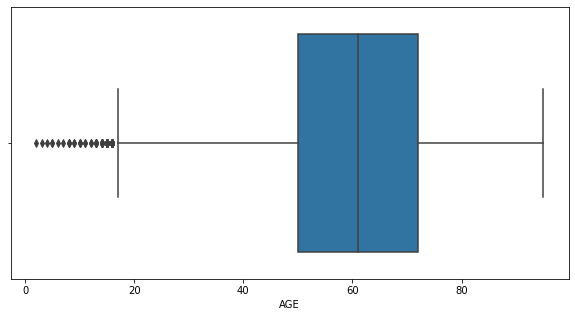

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x='AGE', data=raw_data)
pass

Возраст без выбросов, отрицательных значений и больше 100 не наблюдается

### Пульс

In [11]:
feature = 'HR'

#### ALL

In [12]:
chanel = 'ALL'

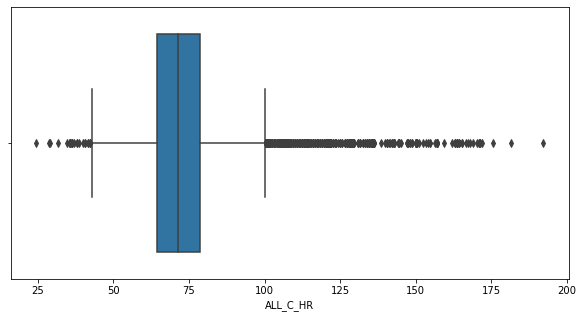

In [13]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=raw_data)
pass

In [14]:
raw_data[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1]) 

0.000     24.404762
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    103.571429
0.990    128.571429
0.995    140.357143
1.000    192.261905
Name: ALL_C_HR, dtype: float64

В принципе пульс 200 возможен, я не знаю условий, при которых брали ЭКГ, это может быть и ЭКГ в критическом состоянии, и ЭКГ под нагрузкой и т.д. Здесь оставим все без изменений

#### I

In [15]:
chanel = 'I'

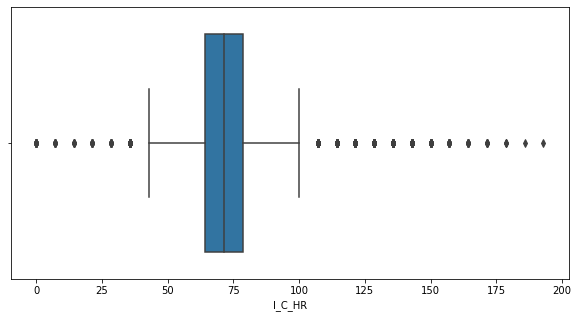

In [16]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=raw_data)
pass

In [17]:
raw_data[chanel + '_C_' + feature].quantile([0,  0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1]) 

0.000      0.000000
0.005     35.714286
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    192.857143
Name: I_C_HR, dtype: float64

Здесь уже есть примеры, когда пульс попросту равен 0, чего естественно быть не может. Это скорее всего связано с методикой подсчета - считается количество qrs комплексов, распознанных сегментирующей нейронной сетью, так что если сети не удается распознать qrs комплекс, скажем, из-за сильно неровной кардиограммы, пульс будет 0. Удалим все нулевые объекты

In [18]:
import sys

rows_to_delete = train[
    (train[chanel + '_C_' + feature] < sys.float_info.epsilon)
    ]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      7.142857
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    192.857143
Name: I_C_HR, dtype: float64

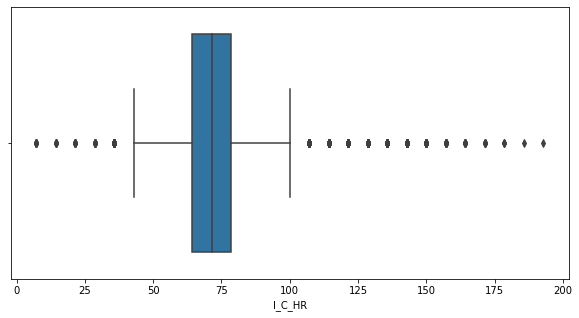

In [19]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=train)
pass

#### II

In [20]:
chanel = 'II'

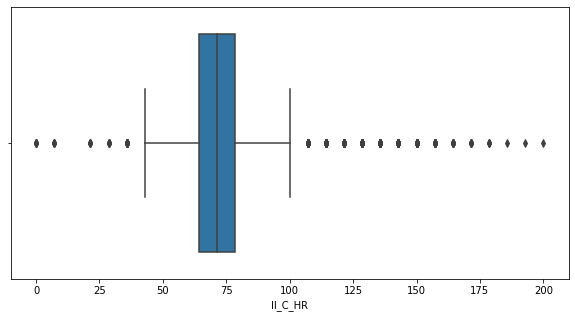

In [21]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=raw_data)
pass

In [22]:
raw_data[chanel + '_C_' + feature].quantile([0,  0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    135.714286
0.995    142.857143
1.000    200.000000
Name: II_C_HR, dtype: float64

In [23]:
import sys

rows_to_delete = train[
    (train[chanel + '_C_' + feature] < sys.float_info.epsilon)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      7.142857
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    135.714286
0.995    142.857143
1.000    200.000000
Name: II_C_HR, dtype: float64

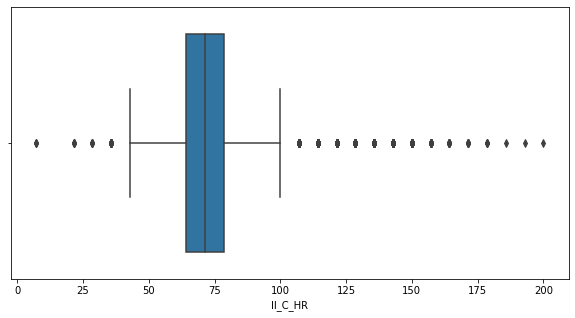

In [24]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=train)
pass

#### III

In [25]:
chanel = 'III'

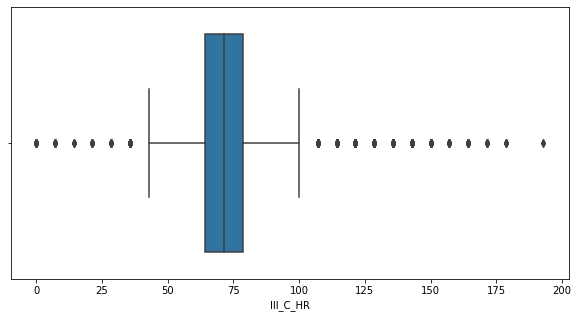

In [26]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=raw_data)
pass

In [27]:
raw_data[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    100.000000
0.990    128.571429
0.995    142.857143
1.000    192.857143
Name: III_C_HR, dtype: float64

In [28]:
rows_to_delete = train[
    (train[chanel + '_C_' + feature] < sys.float_info.epsilon)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      7.142857
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    100.000000
0.990    128.571429
0.995    142.857143
1.000    192.857143
Name: III_C_HR, dtype: float64

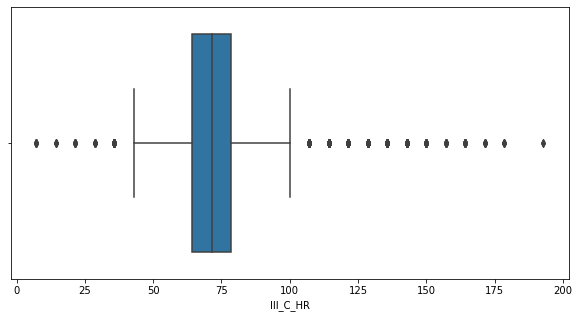

In [29]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=train)
pass

#### AVR

In [30]:
chanel = 'AVR'

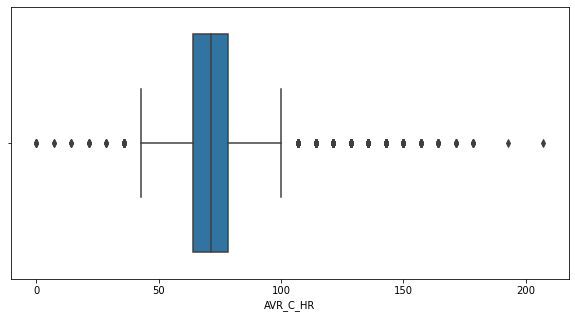

In [31]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=raw_data)
pass

In [32]:
raw_data[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1]) 

0.000      0.000000
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    207.142857
Name: AVR_C_HR, dtype: float64

In [33]:
rows_to_delete = train[
    (train[chanel + '_C_' + feature] < sys.float_info.epsilon)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      7.142857
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    207.142857
Name: AVR_C_HR, dtype: float64

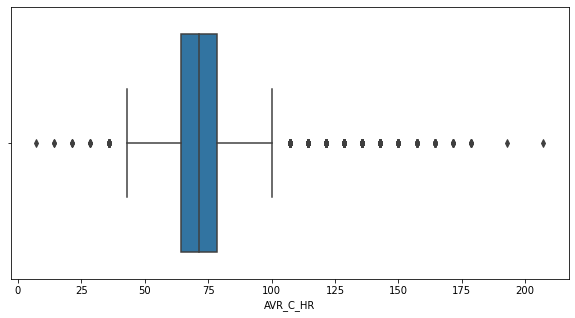

In [34]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=train)
pass

#### AVL

In [35]:
chanel = 'AVL'

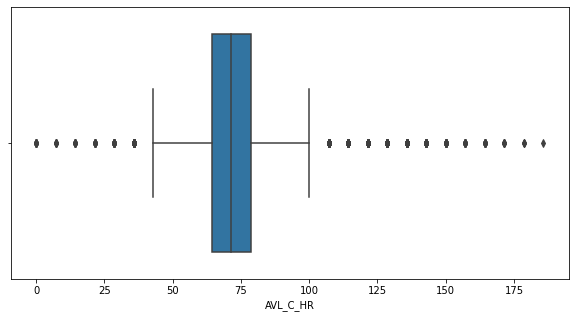

In [36]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=raw_data)
pass

In [37]:
raw_data[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005     35.714286
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    100.000000
0.990    128.571429
0.995    135.714286
1.000    185.714286
Name: AVL_C_HR, dtype: float64

In [38]:
rows_to_delete = train[
    (train[chanel + '_C_' + feature] < sys.float_info.epsilon)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      7.142857
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    100.000000
0.990    128.571429
0.995    135.714286
1.000    185.714286
Name: AVL_C_HR, dtype: float64

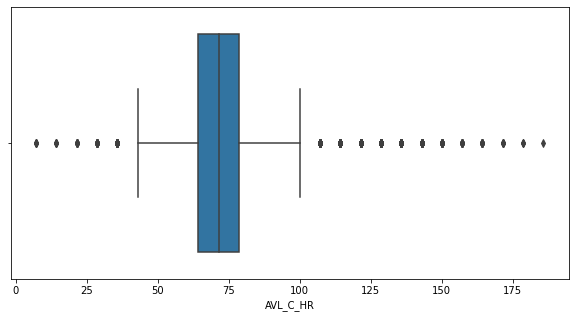

In [39]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=train)
pass

#### AVF

In [40]:
chanel = 'AVF'

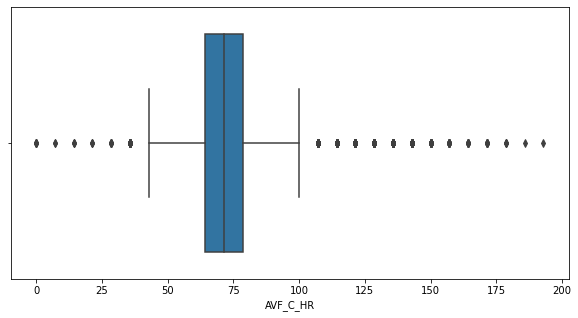

In [41]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=raw_data)
pass

In [42]:
raw_data[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1]) 

0.000      0.000000
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    192.857143
Name: AVF_C_HR, dtype: float64

In [43]:
rows_to_delete = train[
    (train[chanel + '_C_' + feature] < sys.float_info.epsilon)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     14.285714
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    192.857143
Name: AVF_C_HR, dtype: float64

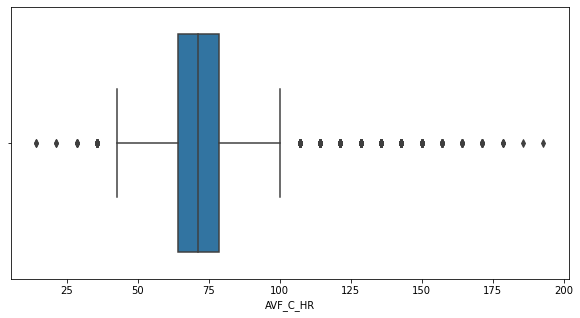

In [44]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=train)
pass

#### V1

In [45]:
chanel = 'V1'

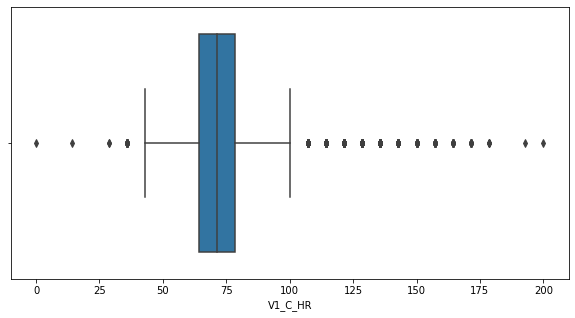

In [46]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=raw_data)
pass

In [47]:
raw_data[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1]) 

0.000      0.000000
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    200.000000
Name: V1_C_HR, dtype: float64

In [48]:
rows_to_delete = train[
    (train[chanel + '_C_' + feature] < sys.float_info.epsilon)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     28.571429
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    200.000000
Name: V1_C_HR, dtype: float64

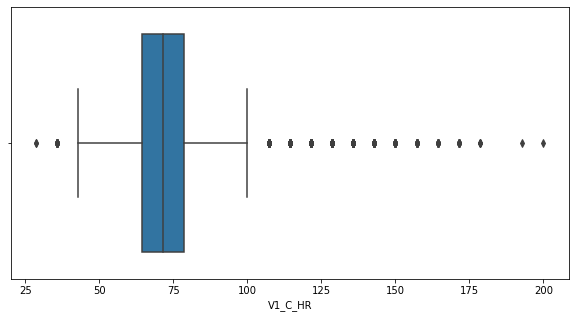

In [49]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=train)
pass

#### V2

In [50]:
chanel = 'V2'

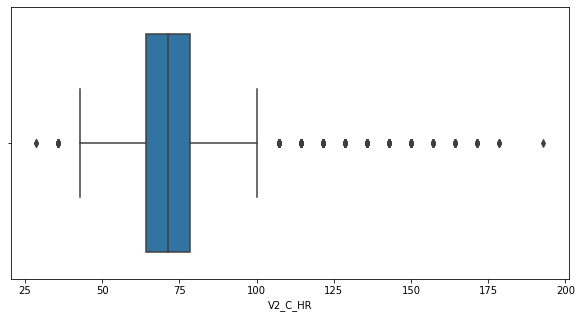

In [51]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=raw_data)
pass

In [52]:
raw_data[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1]) 

0.000     28.571429
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    192.857143
Name: V2_C_HR, dtype: float64

In [53]:
rows_to_delete = train[
    (train[chanel + '_C_' + feature] < sys.float_info.epsilon)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     28.571429
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    192.857143
Name: V2_C_HR, dtype: float64

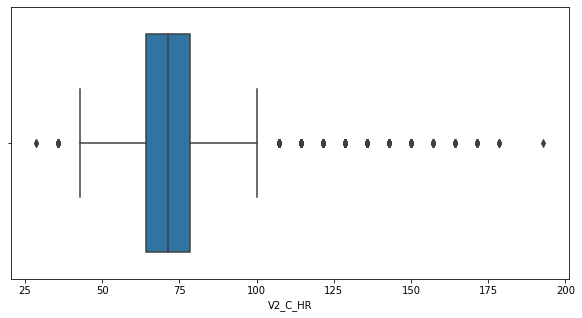

In [54]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=train)
pass

#### V3

In [55]:
chanel = 'V3'

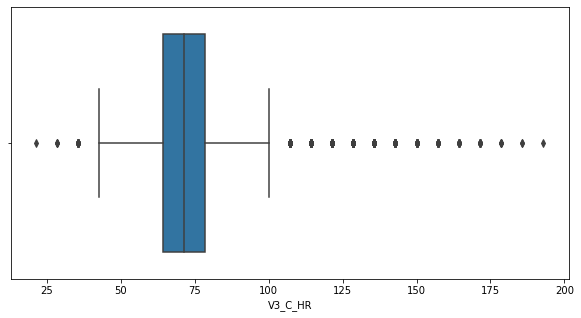

In [56]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=raw_data)
pass

In [57]:
raw_data[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1]) 

0.000     21.428571
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    192.857143
Name: V3_C_HR, dtype: float64

In [58]:
rows_to_delete = train[
    (train[chanel + '_C_' + feature] < sys.float_info.epsilon)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     21.428571
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    192.857143
Name: V3_C_HR, dtype: float64

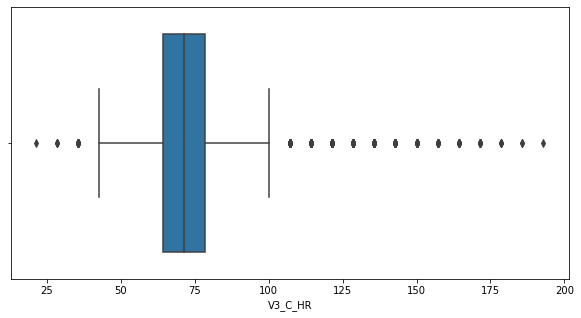

In [59]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=train)
pass

#### V4

In [60]:
chanel = 'V4'

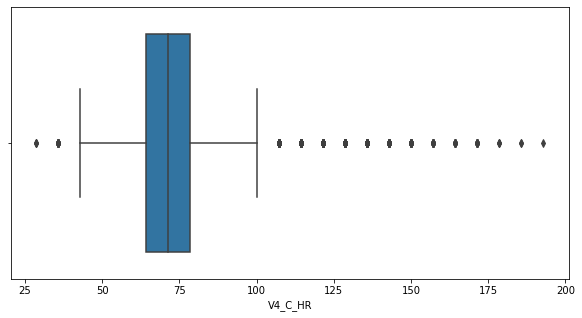

In [61]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=raw_data)
pass

In [62]:
raw_data[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1]) 

0.000     28.571429
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    192.857143
Name: V4_C_HR, dtype: float64

In [63]:
rows_to_delete = train[
    (train[chanel + '_C_' + feature] < sys.float_info.epsilon)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     28.571429
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    192.857143
Name: V4_C_HR, dtype: float64

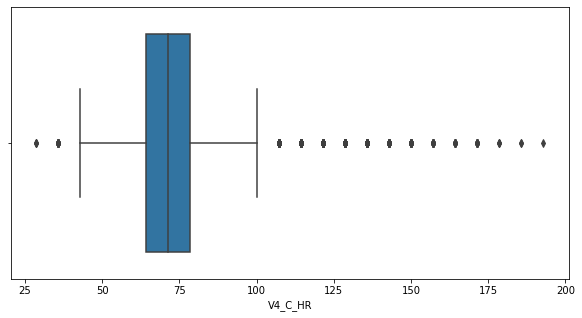

In [64]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=train)
pass

#### V5

In [65]:
chanel = 'V5'

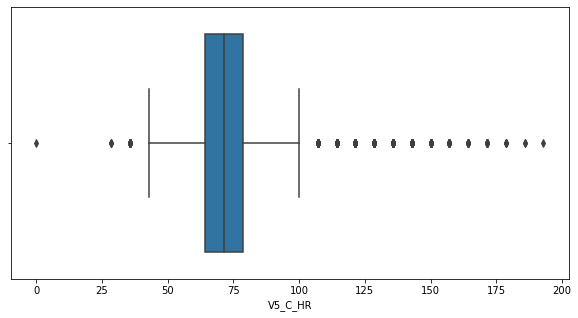

In [66]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=raw_data)
pass

In [67]:
raw_data[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1]) 

0.000      0.000000
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    192.857143
Name: V5_C_HR, dtype: float64

In [68]:
rows_to_delete = train[
    (train[chanel + '_C_' + feature] < sys.float_info.epsilon)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     28.571429
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    192.857143
Name: V5_C_HR, dtype: float64

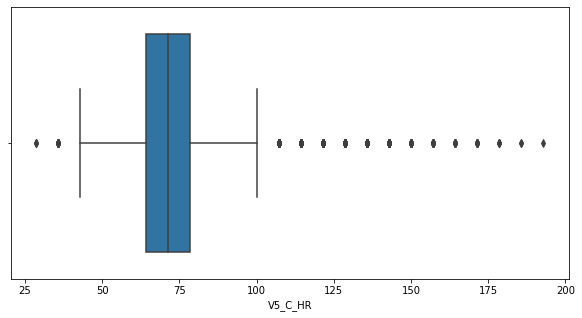

In [69]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=train)
pass

#### V6

In [70]:
chanel = 'V6'

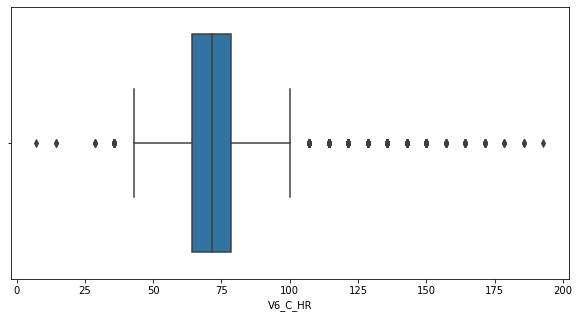

In [71]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=raw_data)
pass

In [72]:
raw_data[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1]) 

0.000      7.142857
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    192.857143
Name: V6_C_HR, dtype: float64

In [73]:
rows_to_delete = train[
    (train[chanel + '_C_' + feature] < sys.float_info.epsilon)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_' + feature].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     14.285714
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    192.857143
Name: V6_C_HR, dtype: float64

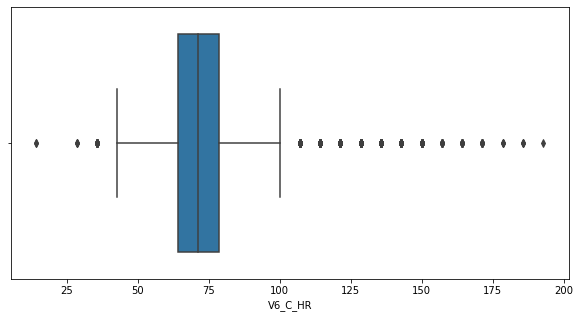

In [74]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=chanel + '_C_' + feature, data=train)
pass

Сравним количество данных до удаления выбросов по пульсу и после

In [75]:
len(train)

17405

In [76]:
len(raw_data)

17441

### Рост

Пульс выровняли, посмотрим что с ростом

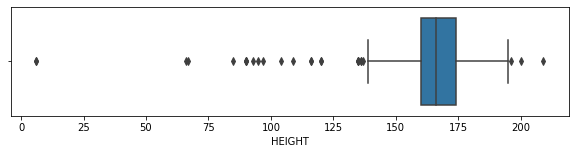

In [77]:
plt.figure(figsize=(10,2))
sns.boxplot(x='HEIGHT', data=raw_data)
pass

In [78]:
raw_data['HEIGHT'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      6.0
0.005    140.0
0.010    147.0
0.050    152.0
0.100    154.0
0.500    166.0
0.900    180.0
0.950    183.0
0.990    190.0
0.995    191.0
1.000    209.0
Name: HEIGHT, dtype: float64

Довольно странные значения в самом начале, рассмотрим их подробнее

In [79]:
train[train['HEIGHT'] < 100]

SEX   AGE  HEIGHT  WEIGHT    ALL_C_HR  ALL_C_P_AV  ALL_C_P_DEV  \
ecg_id                                                                  
6266     1  60.0    66.0     NaN   89.285714   76.776735     8.379692   
6430     1  46.0    67.0     NaN   57.142857   95.628632    16.380710   
9317     0  64.0     6.0     NaN   73.214286   64.328545    20.533837   
9384     1  79.0     6.0     NaN   71.428571   87.850463    15.653663   
10289    0   2.0    85.0    12.0  117.857143   55.405824    20.743153   
13945    0   5.0    97.0    17.0   92.857143   78.645900    15.833350   
14263    1   4.0    95.0    20.0   92.857143   76.564330    10.956473   
15351    1  84.0    90.0     NaN   78.571429   95.299056    11.930003   
15514    1  84.0    90.0     NaN   92.857143   77.831481    18.767833   
16198    0   6.0    90.0    19.0   92.857143   79.950911     7.586416   
18173    0  64.0    93.0     NaN   58.928571   75.479075    17.402558   

        ALL_C_P_A_AV  ALL_C_P_A_DEV  ALL_C_QRS_AV  ...  MI  STTC  CD  HYP  \
ecg_id                                             ...                      
6266        0.076053       0.029476     77.818742  ...   0     0   0    0   
6430        0.065979       0.033567     79.364713  ...   0     0   0    0   
9317        0.161391       0.069987     95.203397  ...   1     0   1    0   
9384        0.070610       0.024049     99.229646  ...   0     0   1    0   
10289       0.158035       0.065320     73.504759  ...   0     0   0    0   
13945       0.078942       0.027557     86.174284  ...   0     0   0    0   
14263       0.067908       0.033361     78.198253  ...   0     0   0    0   
15351       0.121260       0.053678     79.320635  ...   0     0   0    0   
15514       0.151226       0.056252     88.206105  ...   1     1   0    0   
16198       0.091848       0.033727     79.771917  ...   0     0   0    0   
18173       0.114573       0.034913     93.004470  ...   0     1   0    0   

        NORM_PROB  MI_PROB  STTC_PROB  CD_PROB  HYP_PROB  strat_fold  
ecg_id                                                                
6266          100        0          0        0         0           5  
6430          100        0          0        0         0           8  
9317            0      100          0      100         0           6  
9384            0        0          0      100         0           1  
10289         100        0          0        0         0           8  
13945         100        0          0        0         0           6  
14263         100        0          0        0         0           8  
15351         100        0          0        0         0           2  
15514           0       35        100        0         0           2  
16198         100        0          0        0         0           1  
18173           0        0        100        0         0           8  

[11 rows x 340 columns]

Самый низкий человек в мире по "Книге Рекордов Гиннеса" - 67см. Врят ли первые два - рекордсмены по низкому росту. Удаляем. 6см тоже.

In [80]:
rows_to_delete = train.loc[[6266, 6430, 9317, 9384]]
train = train.drop(rows_to_delete.index)
train['HEIGHT'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     85.0
0.005    142.0
0.010    147.0
0.050    152.0
0.100    154.0
0.500    166.0
0.900    180.0
0.950    183.0
0.990    190.0
0.995    191.0
1.000    209.0
Name: HEIGHT, dtype: float64

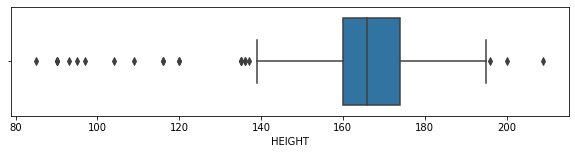

In [81]:
plt.figure(figsize=(10,2))
sns.boxplot(x='HEIGHT', data=train)
pass

### Вес

Посмотрим на вес

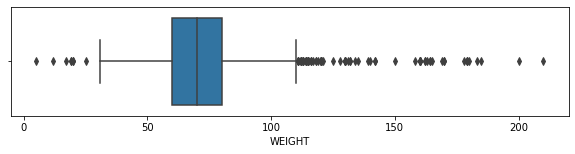

In [82]:
plt.figure(figsize=(10,2))
sns.boxplot(x='WEIGHT', data=raw_data)
pass

In [83]:
raw_data['WEIGHT'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      5.0
0.005     40.0
0.010     41.0
0.050     49.0
0.100     53.0
0.500     70.0
0.900     90.0
0.950     95.0
0.990    113.0
0.995    130.0
1.000    210.0
Name: WEIGHT, dtype: float64

В принципе человек весом 250 кг вполне может существовать. А вот 5кг уже странно, надо рассмотреть подробнее

In [84]:
train[train['WEIGHT'] < 30]

SEX   AGE  HEIGHT  WEIGHT    ALL_C_HR  ALL_C_P_AV  ALL_C_P_DEV  \
ecg_id                                                                  
3961     1   9.0   137.0    25.0   85.714286   84.704240     8.357116   
6059     0  63.0   173.0     5.0   78.571429   96.229596    18.689662   
6598     1   8.0   120.0    20.0   92.857143   77.151880     6.608209   
10289    0   2.0    85.0    12.0  117.857143   55.405824    20.743153   
12390    0   5.0   109.0    19.0  100.595238   82.797553    14.411331   
13945    0   5.0    97.0    17.0   92.857143   78.645900    15.833350   
14263    1   4.0    95.0    20.0   92.857143   76.564330    10.956473   
16198    0   6.0    90.0    19.0   92.857143   79.950911     7.586416   

        ALL_C_P_A_AV  ALL_C_P_A_DEV  ALL_C_QRS_AV  ...  MI  STTC  CD  HYP  \
ecg_id                                             ...                      
3961        0.081855       0.036253     77.909849  ...   0     0   0    0   
6059        0.100369       0.042137     86.475924  ...   0     0   0    0   
6598        0.087830       0.025605     76.051057  ...   0     0   0    0   
10289       0.158035       0.065320     73.504759  ...   0     0   0    0   
12390       0.114272       0.042227     73.905554  ...   0     0   0    0   
13945       0.078942       0.027557     86.174284  ...   0     0   0    0   
14263       0.067908       0.033361     78.198253  ...   0     0   0    0   
16198       0.091848       0.033727     79.771917  ...   0     0   0    0   

        NORM_PROB  MI_PROB  STTC_PROB  CD_PROB  HYP_PROB  strat_fold  
ecg_id                                                                
3961          100        0          0        0         0           5  
6059          100        0          0        0         0           7  
6598          100        0          0        0         0           2  
10289         100        0          0        0         0           8  
12390         100        0          0        0         0           7  
13945         100        0          0        0         0           6  
14263         100        0          0        0         0           8  
16198         100        0          0        0         0           1  

[8 rows x 340 columns]

Три строки, где пожилые люди меньше 20кг выглядит как выброс. Удалим.

In [85]:
train = train.drop(6059)
train['WEIGHT'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     12.0
0.005     40.0
0.010     41.0
0.050     49.0
0.100     53.0
0.500     70.0
0.900     90.0
0.950     95.0
0.990    113.0
0.995    130.0
1.000    210.0
Name: WEIGHT, dtype: float64

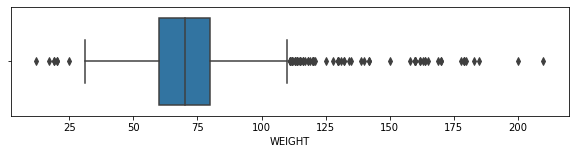

In [86]:
plt.figure(figsize=(10,2))
sns.boxplot(x='WEIGHT', data=train)
pass

Посмотрим на количество записей после удаления выбросов по росту и по весу

In [87]:
len(train)

17400

### P-волна

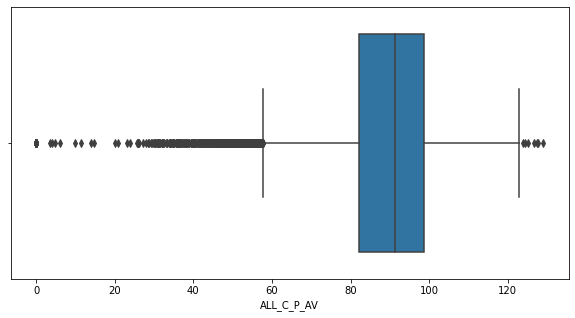

In [88]:
plt.figure(figsize=(10,5))
sns.boxplot(x="ALL_C_P_AV", data=raw_data)
pass

Посмотрим на длины волн. Среди длин P-волны наблюдается очень странная картина в виде множества нулевых точек.

Нельзя просто взять и удалить их, возможно отсутствие или слабая выраженность P-волны может являться симптомом. Посмотрим что с классами диагностики

In [89]:
import sys
train[train['ALL_C_P_AV'] < sys.float_info.epsilon]['NORM'].value_counts()

0    202
1      8
Name: NORM, dtype: int64

In [90]:
import sys
train[train['I_C_P_AV'] < sys.float_info.epsilon]['NORM'].value_counts()

0    952
1     66
Name: NORM, dtype: int64

Действительно, большая часть таких записей не считаются "нормальными" ЭКГ. Оставим их как есть. Посмотрим на верхние выбросы.

#### ALL

In [91]:
chanel = 'ALL'
raw_data['ALL_C_P_AV'].quantile([0.99, 0.995, 1])

0.990    114.573533
0.995    116.997353
1.000    129.005983
Name: ALL_C_P_AV, dtype: float64

#### I

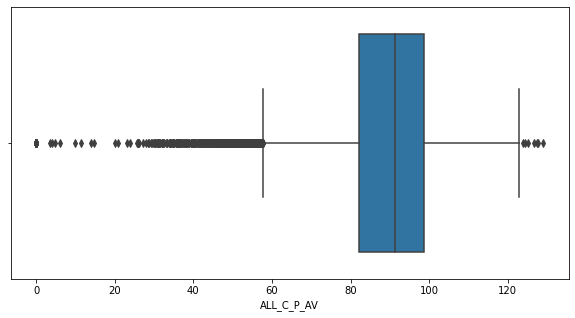

In [92]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_AV", data=raw_data)
pass

In [93]:
chanel = 'I'
raw_data[chanel + '_C_P_AV'].quantile([0.99, 0.995, 1])

0.990    118.857143
0.995    122.222222
1.000    142.400000
Name: I_C_P_AV, dtype: float64

Здесь выбросы незначительные по-сравнению с нижними, оставим

#### II

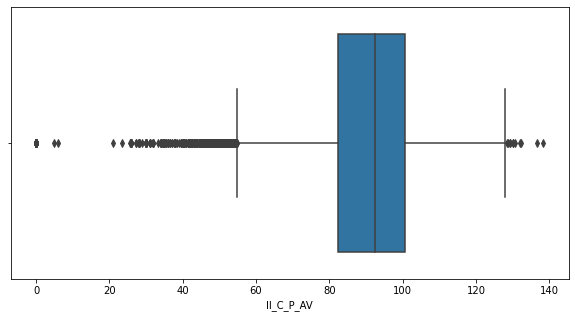

In [94]:
chanel = 'II'
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_AV", data=raw_data)
pass

In [95]:
raw_data[chanel + '_C_P_AV'].quantile([0.99, 0.995, 1])

0.990    119.139048
0.995    121.904762
1.000    138.380952
Name: II_C_P_AV, dtype: float64

Здесь выбросы незначительные по-сравнению с нижними, оставим

#### III

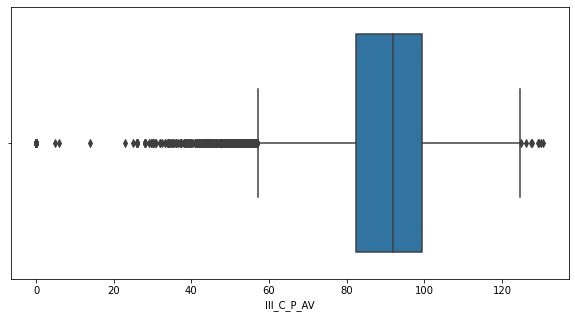

In [96]:
chanel = 'III'
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_AV", data=raw_data)
pass

In [97]:
raw_data[chanel + '_C_P_AV'].quantile([0.99, 0.995, 1])

0.990    115.820130
0.995    118.284127
1.000    130.607143
Name: III_C_P_AV, dtype: float64

Здесь выбросы незначительные по-сравнению с нижними, оставим

#### AVR

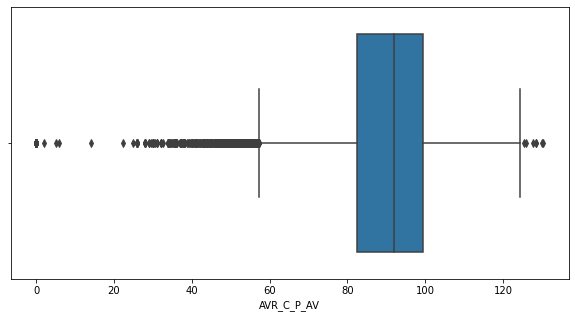

In [98]:
chanel = 'AVR'
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_AV", data=raw_data)
pass

In [99]:
raw_data[chanel + '_C_P_AV'].quantile([0.99, 0.995, 1])

0.990    115.626667
0.995    118.213706
1.000    130.350000
Name: AVR_C_P_AV, dtype: float64

Здесь выбросы незначительные по-сравнению с нижними, оставим

#### AVL

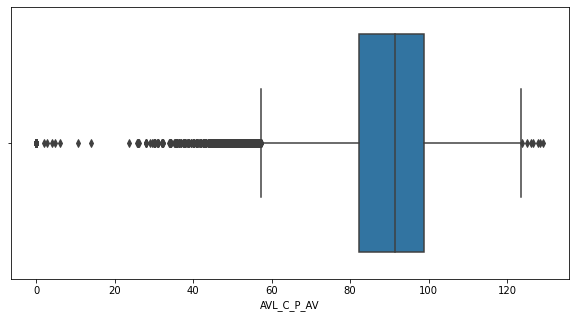

In [100]:
chanel = 'AVL'
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_AV", data=raw_data)
pass

In [101]:
raw_data[chanel + '_C_P_AV'].quantile([0.99, 0.995, 1])

0.990    114.914130
0.995    117.396670
1.000    129.177419
Name: AVL_C_P_AV, dtype: float64

Здесь выбросы незначительные по-сравнению с нижними, оставим

#### AVF

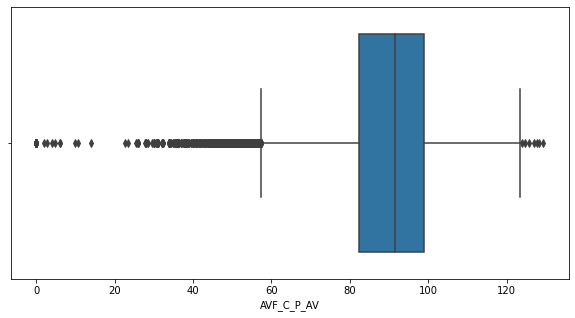

In [102]:
chanel = 'AVF'
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_AV", data=raw_data)
pass

In [103]:
raw_data[chanel + '_C_P_AV'].quantile([0.99, 0.995, 1])

0.990    114.870194
0.995    117.414100
1.000    129.325397
Name: AVF_C_P_AV, dtype: float64

Здесь выбросы незначительные по-сравнению с нижними, оставим

#### AVL

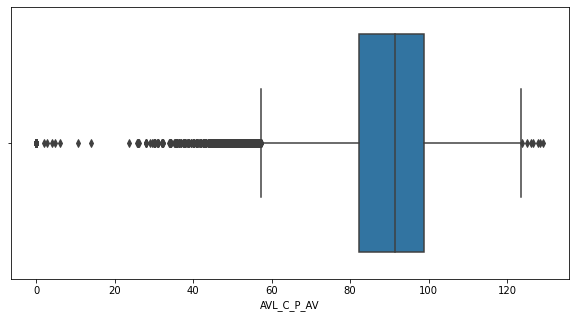

In [104]:
chanel = 'AVL'
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_AV", data=raw_data)
pass

In [105]:
raw_data[chanel + '_C_P_AV'].quantile([0.99, 0.995, 1])

0.990    114.914130
0.995    117.396670
1.000    129.177419
Name: AVL_C_P_AV, dtype: float64

Здесь выбросы незначительные по-сравнению с нижними, оставим

#### V1

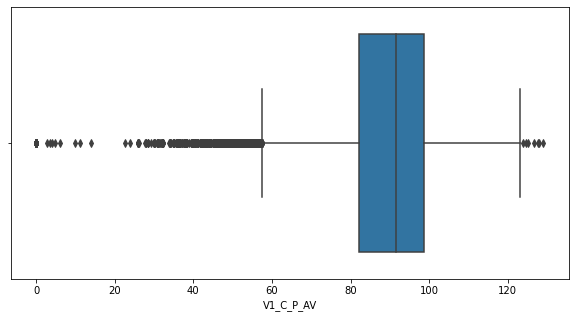

In [106]:
chanel = 'V1'
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_AV", data=raw_data)
pass

In [107]:
raw_data[chanel + '_C_P_AV'].quantile([0.99, 0.995, 1])

0.990    114.632096
0.995    117.142044
1.000    129.011811
Name: V1_C_P_AV, dtype: float64

Здесь выбросы незначительные по-сравнению с нижними, оставим

#### V2

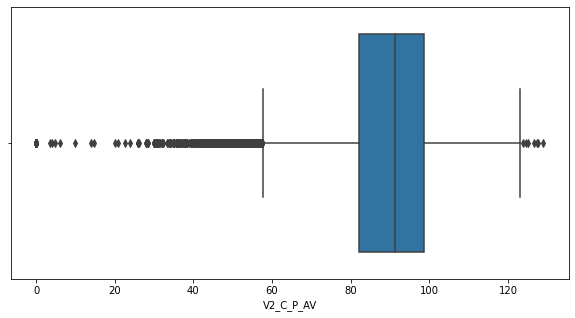

In [108]:
chanel = 'V2'
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_AV", data=raw_data)
pass

In [109]:
    raw_data[chanel + '_C_P_AV'].quantile([0.99, 0.995, 1])

0.990    114.581791
0.995    117.033055
1.000    128.988235
Name: V2_C_P_AV, dtype: float64

Здесь выбросы незначительные по-сравнению с нижними, оставим

#### V3

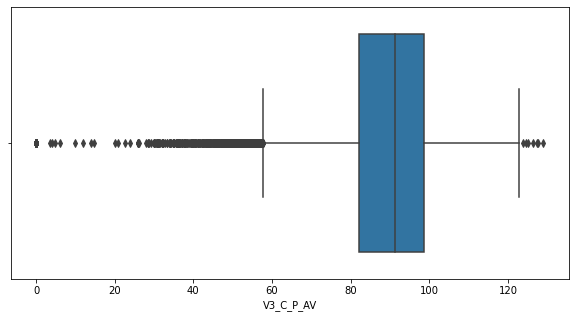

In [110]:
chanel = 'V3'
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_AV", data=raw_data)
pass

In [111]:
raw_data[chanel + '_C_P_AV'].quantile([0.99, 0.995, 1])

0.990    114.568172
0.995    117.009511
1.000    129.000489
Name: V3_C_P_AV, dtype: float64

Здесь выбросы незначительные по-сравнению с нижними, оставим

#### V4

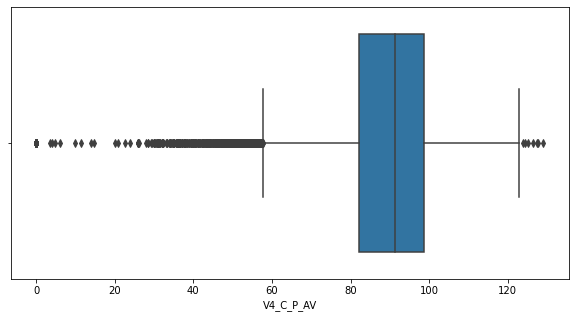

In [112]:
chanel = 'V4'
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_AV", data=raw_data)
pass

In [113]:
raw_data[chanel + '_C_P_AV'].quantile([0.99, 0.995, 1])

0.990    114.574806
0.995    117.002462
1.000    129.003177
Name: V4_C_P_AV, dtype: float64

Здесь выбросы незначительные по-сравнению с нижними, оставим

#### V5

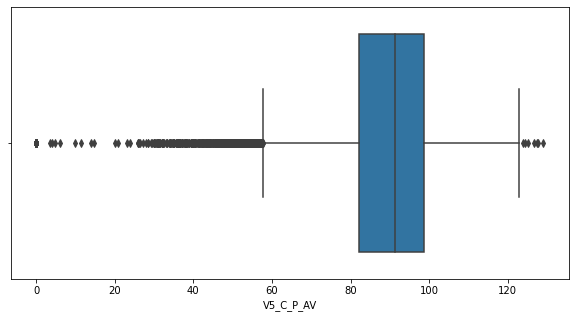

In [114]:
chanel = 'V5'
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_AV", data=raw_data)
pass

In [115]:
raw_data[chanel + '_C_P_AV'].quantile([0.99, 0.995, 1])

0.990    114.575441
0.995    116.999668
1.000    129.006229
Name: V5_C_P_AV, dtype: float64

Здесь выбросы незначительные по-сравнению с нижними, оставим

#### V6

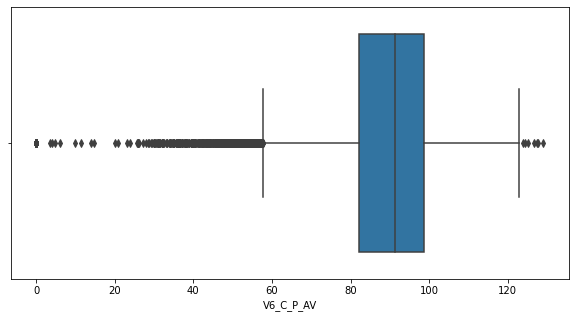

In [116]:
chanel = 'V6'
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_AV", data=raw_data)
pass

In [117]:
raw_data[chanel + '_C_P_AV'].quantile([0.99, 0.995, 1])

0.990    114.573533
0.995    116.997353
1.000    129.005983
Name: V6_C_P_AV, dtype: float64

Здесь выбросы незначительные по-сравнению с нижними, оставим

Длина после преобразований

In [118]:
len(train)

17400

### P-амплитуда

Рассмотрим P-амплитуду

#### ALL

In [119]:
chanel = 'ALL'

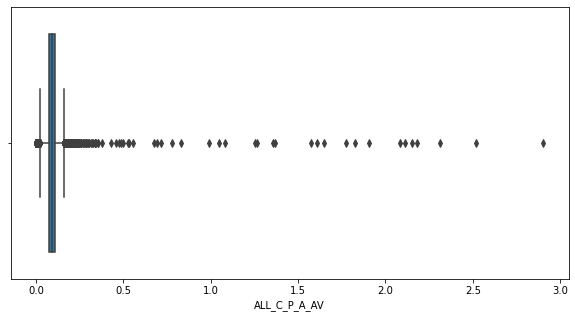

In [120]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_P_A_AV', data=raw_data)
pass

In [121]:
raw_data[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 0.997, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.045333
0.100    0.057304
0.500    0.088867
0.900    0.128198
0.950    0.143453
0.990    0.186791
0.995    0.215861
0.997    0.266176
1.000    2.903667
Name: ALL_C_P_A_AV, dtype: float64

Нижние выбросы оставим по той же причине, по которой оставляли выбросы с амплитудой P волны выше. Удалим верхние выбросы

In [122]:
rows_to_delete = train[
    (train[chanel + '_C_P_A_AV'] > 0.6)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.045301
0.100    0.057256
0.500    0.088781
0.900    0.127442
0.950    0.142324
0.990    0.179010
0.995    0.197332
1.000    0.555708
Name: ALL_C_P_A_AV, dtype: float64

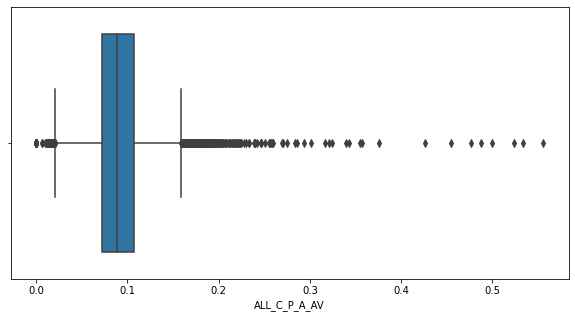

In [123]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_P_A_AV', data=train)
pass

То же самое по всем каналам

#### I

In [124]:
chanel = 'I'

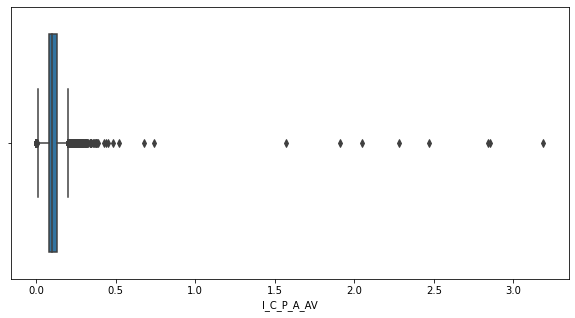

In [125]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=raw_data)
pass

In [126]:
raw_data[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 0.998, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.056571
0.500    0.103000
0.900    0.157545
0.950    0.179375
0.990    0.231878
0.995    0.258533
0.998    0.311048
1.000    3.188444
Name: I_C_P_A_AV, dtype: float64

Нижние выбросы оставим по той же причине, по которой оставляли выбросы с амплитудой P волны выше. Удалим верхние выбросы

In [127]:
rows_to_delete = train[
    (train[chanel + '_C_P_A_AV'] > 0.4)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.057500
0.500    0.103074
0.900    0.157184
0.950    0.178895
0.990    0.228433
0.995    0.253305
1.000    0.390750
Name: I_C_P_A_AV, dtype: float64

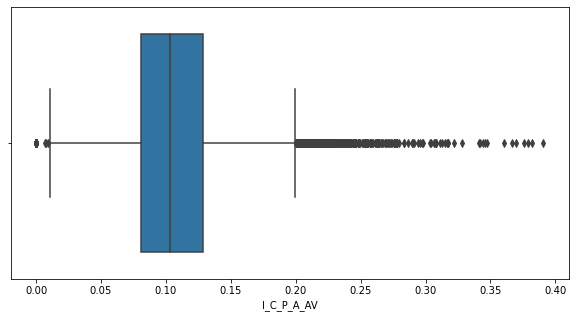

In [128]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_P_A_AV', data=train)
pass

#### II

In [129]:
chanel = 'II'

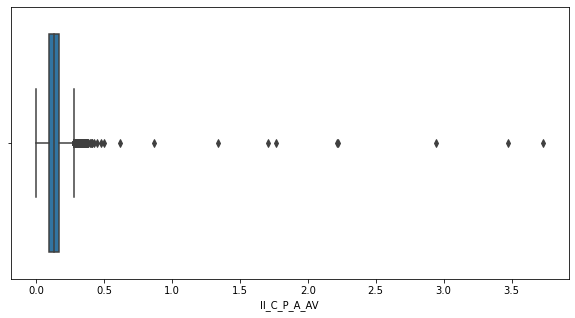

In [130]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=raw_data)
pass

In [131]:
raw_data[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 0.998, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.052000
0.500    0.130615
0.900    0.202286
0.950    0.226083
0.990    0.280527
0.995    0.309140
0.998    0.349473
1.000    3.734000
Name: II_C_P_A_AV, dtype: float64

Нижние выбросы оставим по той же причине, по которой оставляли выбросы с амплитудой P волны выше. Удалим верхние выбросы

In [132]:
rows_to_delete = train[
    (train[chanel + '_C_P_A_AV'] > 0.39)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.052806
0.500    0.130625
0.900    0.202000
0.950    0.225153
0.990    0.276361
0.995    0.297171
1.000    0.383909
Name: II_C_P_A_AV, dtype: float64

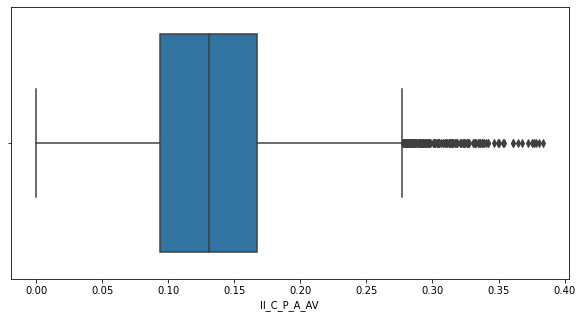

In [133]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=train)
pass

#### III

In [134]:
chanel = 'III'

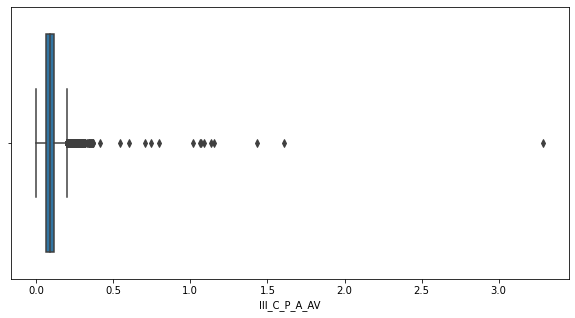

In [135]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=raw_data)
pass

In [136]:
raw_data[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 0.998, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.041111
0.500    0.090000
0.900    0.151714
0.950    0.177125
0.990    0.235800
0.995    0.266183
0.998    0.307240
1.000    3.289000
Name: III_C_P_A_AV, dtype: float64

Нижние выбросы оставим по той же причине, по которой оставляли выбросы с амплитудой P волны выше. Удалим верхние выбросы

In [137]:
rows_to_delete = train[
    (train[chanel + '_C_P_A_AV'] > 0.5)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.041714
0.500    0.090000
0.900    0.151000
0.950    0.175889
0.990    0.231720
0.995    0.255629
1.000    0.369000
Name: III_C_P_A_AV, dtype: float64

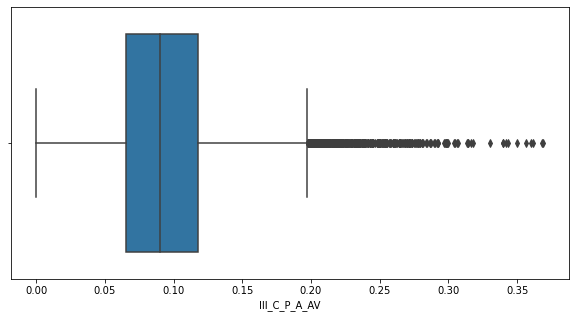

In [138]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=train)
pass

#### AVR

In [139]:
chanel = 'AVR'

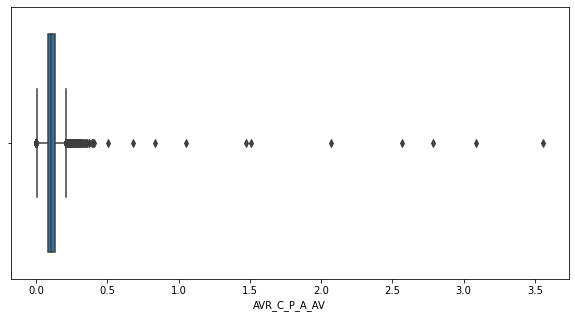

In [140]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=raw_data)
pass

In [141]:
raw_data[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 0.998, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.052400
0.500    0.107333
0.900    0.159167
0.950    0.178250
0.990    0.227218
0.995    0.249450
0.998    0.298914
1.000    3.559571
Name: AVR_C_P_A_AV, dtype: float64

Нижние выбросы оставим по той же причине, по которой оставляли выбросы с амплитудой P волны выше. Удалим верхние выбросы

In [142]:
rows_to_delete = train[
    (train[chanel + '_C_P_A_AV'] > 0.34)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.053000
0.500    0.107317
0.900    0.158625
0.950    0.177143
0.990    0.222045
0.995    0.240000
1.000    0.332000
Name: AVR_C_P_A_AV, dtype: float64

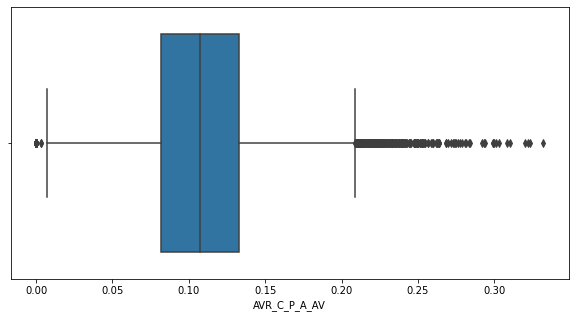

In [143]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=train)
pass

#### AVL

In [144]:
chanel = 'AVL'

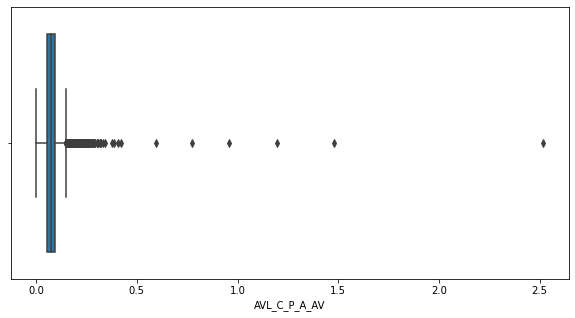

In [145]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=raw_data)
pass

In [146]:
raw_data[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 0.998, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.037750
0.500    0.071833
0.900    0.118000
0.950    0.138111
0.990    0.187177
0.995    0.217307
0.998    0.257120
1.000    2.518000
Name: AVL_C_P_A_AV, dtype: float64

Нижние выбросы оставим по той же причине, по которой оставляли выбросы с амплитудой P волны выше. Удалим верхние выбросы

In [147]:
rows_to_delete = train[
    (train[chanel + '_C_P_A_AV'] > 0.3)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.038250
0.500    0.071875
0.900    0.117764
0.950    0.137296
0.990    0.181387
0.995    0.203520
1.000    0.289000
Name: AVL_C_P_A_AV, dtype: float64

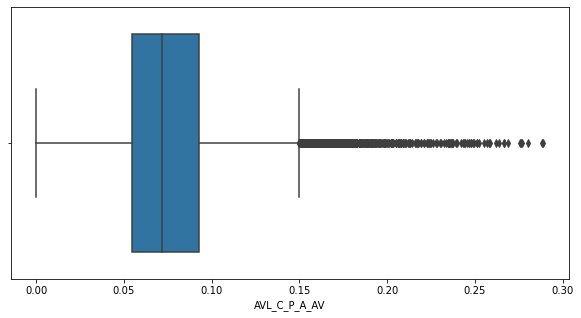

In [148]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=train)
pass

#### AVF

In [149]:
chanel = 'AVF'

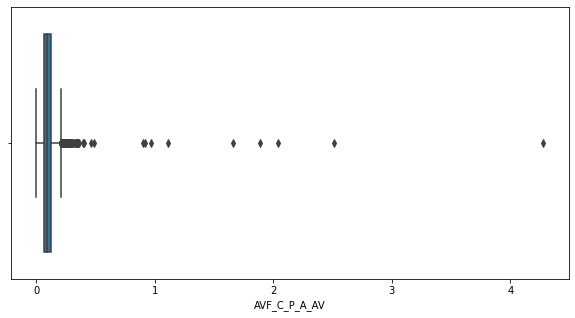

In [150]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=raw_data)
pass

In [151]:
raw_data[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 0.998, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.039375
0.500    0.094889
0.900    0.157545
0.950    0.180800
0.990    0.233964
0.995    0.255580
0.998    0.294207
1.000    4.278000
Name: AVF_C_P_A_AV, dtype: float64

Нижние выбросы оставим по той же причине, по которой оставляли выбросы с амплитудой P волны выше. Удалим верхние выбросы

In [152]:
rows_to_delete = train[
    (train[chanel + '_C_P_A_AV'] > 0.9)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.039800
0.500    0.094875
0.900    0.156708
0.950    0.179000
0.990    0.227350
0.995    0.246000
1.000    0.354000
Name: AVF_C_P_A_AV, dtype: float64

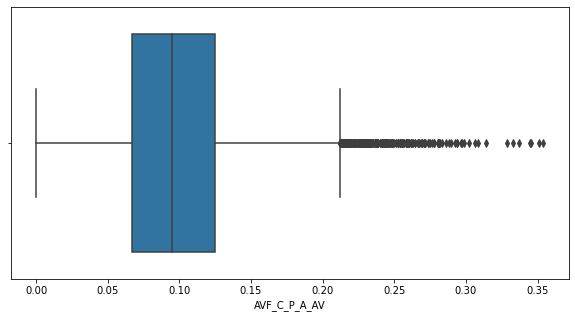

In [153]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=train)
pass

#### V1

In [154]:
chanel = 'V1'

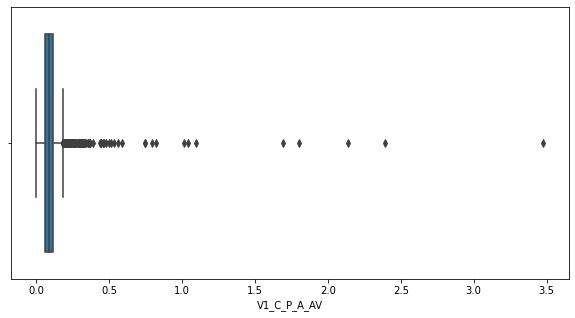

In [155]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=raw_data)
pass

In [156]:
raw_data[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 0.997, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.040800
0.500    0.087667
0.900    0.142273
0.950    0.164455
0.990    0.226414
0.995    0.253517
0.997    0.290929
1.000    3.477000
Name: V1_C_P_A_AV, dtype: float64

Нижние выбросы оставим по той же причине, по которой оставляли выбросы с амплитудой P волны выше. Удалим верхние выбросы

In [157]:
rows_to_delete = train[
    (train[chanel + '_C_P_A_AV'] > 0.38)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.041000
0.500    0.087477
0.900    0.141273
0.950    0.162848
0.990    0.217000
0.995    0.238008
1.000    0.361667
Name: V1_C_P_A_AV, dtype: float64

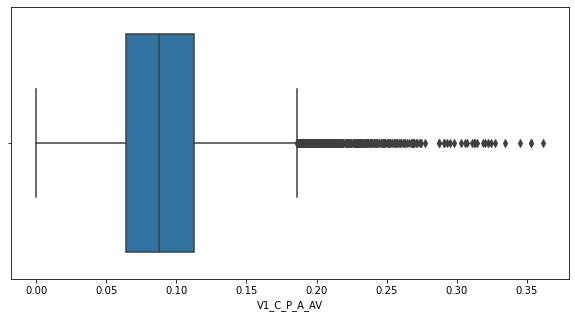

In [158]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=train)
pass

#### V2

In [159]:
chanel = 'V2'

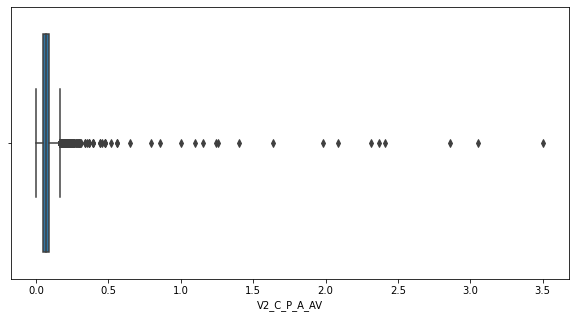

In [160]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=raw_data)
pass

In [161]:
raw_data[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 0.997, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.024000
0.500    0.067364
0.900    0.119000
0.950    0.138615
0.990    0.192610
0.995    0.226000
0.997    0.258874
1.000    3.505000
Name: V2_C_P_A_AV, dtype: float64

Нижние выбросы оставим по той же причине, по которой оставляли выбросы с амплитудой P волны выше. Удалим верхние выбросы

In [162]:
rows_to_delete = train[
    (train[chanel + '_C_P_A_AV'] > 0.34)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.024127
0.500    0.067160
0.900    0.118000
0.950    0.136165
0.990    0.183170
0.995    0.202327
1.000    0.313400
Name: V2_C_P_A_AV, dtype: float64

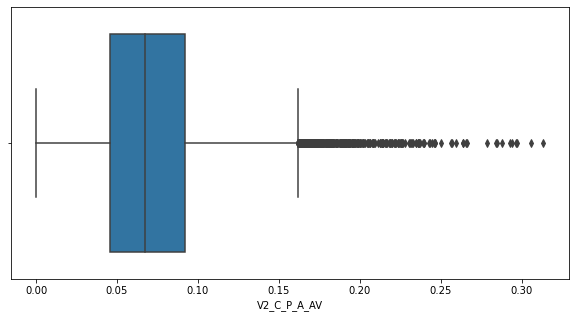

In [163]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=train)
pass

#### V3

In [164]:
chanel = 'V3'

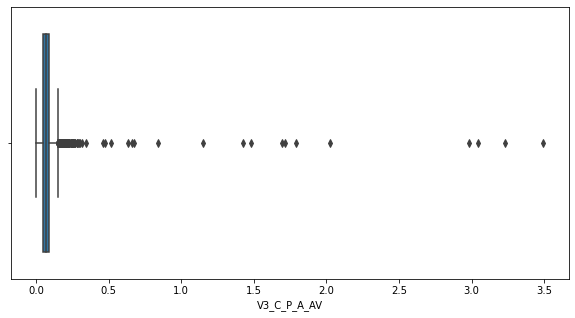

In [165]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=raw_data)
pass

In [166]:
raw_data[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.022889
0.500    0.068500
0.900    0.113909
0.950    0.130500
0.990    0.177747
0.995    0.200533
1.000    3.494000
Name: V3_C_P_A_AV, dtype: float64

Нижние выбросы оставим по той же причине, по которой оставляли выбросы с амплитудой P волны выше. Удалим верхние выбросы

In [167]:
rows_to_delete = train[
    (train[chanel + '_C_P_A_AV'] > 0.4)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.023486
0.500    0.068444
0.900    0.113222
0.950    0.128902
0.990    0.171325
0.995    0.189993
1.000    0.302429
Name: V3_C_P_A_AV, dtype: float64

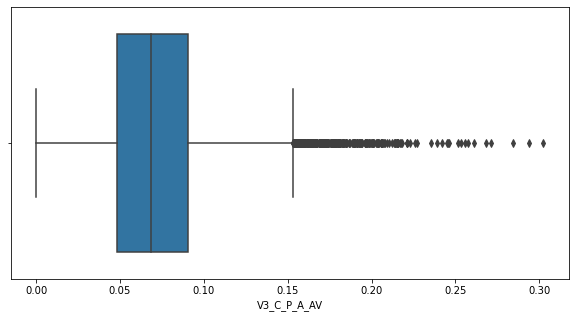

In [168]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=train)
pass

#### V4

In [169]:
chanel = 'V4'

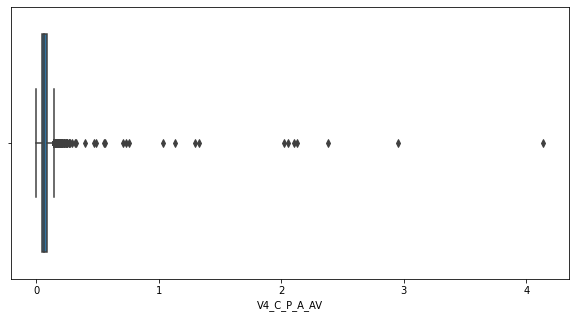

In [170]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=raw_data)
pass

In [171]:
raw_data[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.022000
0.500    0.066500
0.900    0.105667
0.950    0.120000
0.990    0.156907
0.995    0.179160
1.000    4.139000
Name: V4_C_P_A_AV, dtype: float64

Нижние выбросы оставим по той же причине, по которой оставляли выбросы с амплитудой P волны выше. Удалим верхние выбросы

In [172]:
rows_to_delete = train[
    (train[chanel + '_C_P_A_AV'] > 0.3)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.023000
0.500    0.066444
0.900    0.105111
0.950    0.118893
0.990    0.151000
0.995    0.166502
1.000    0.277417
Name: V4_C_P_A_AV, dtype: float64

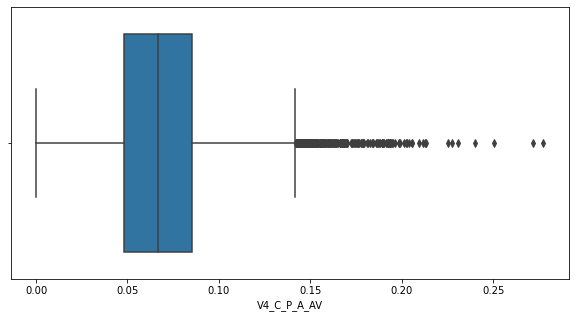

In [173]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=train)
pass

#### V5

In [174]:
chanel = 'V5'

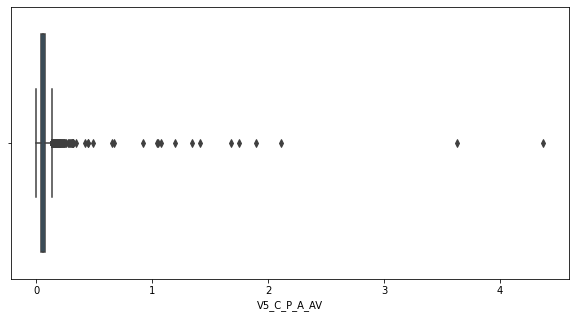

In [175]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=raw_data)
pass

In [176]:
raw_data[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.021857
0.500    0.062200
0.900    0.099714
0.950    0.112273
0.990    0.146722
0.995    0.169444
1.000    4.371333
Name: V5_C_P_A_AV, dtype: float64

Нижние выбросы оставим по той же причине, по которой оставляли выбросы с амплитудой P волны выше. Удалим верхние выбросы

In [177]:
rows_to_delete = train[
    (train[chanel + '_C_P_A_AV'] > 0.25)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.022438
0.500    0.062125
0.900    0.099238
0.950    0.111000
0.990    0.140776
0.995    0.153999
1.000    0.237667
Name: V5_C_P_A_AV, dtype: float64

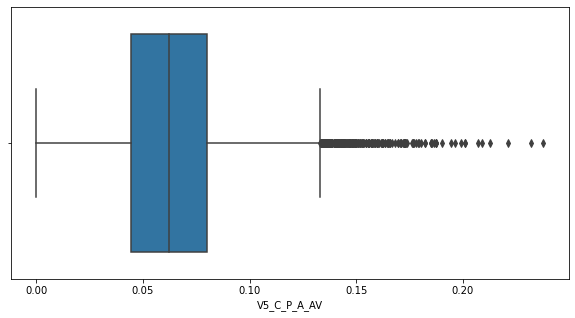

In [178]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=train)
pass

#### V6

In [179]:
chanel = 'V6'

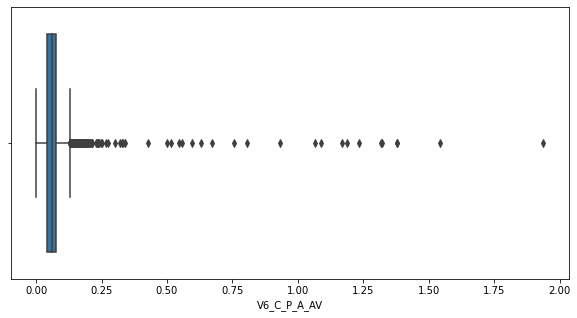

In [180]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=raw_data)
pass

In [181]:
raw_data[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.023600
0.500    0.059750
0.900    0.096100
0.950    0.108875
0.990    0.143409
0.995    0.168829
1.000    1.937857
Name: V6_C_P_A_AV, dtype: float64

Нижние выбросы оставим по той же причине, по которой оставляли выбросы с амплитудой P волны выше. Удалим верхние выбросы

In [182]:
rows_to_delete = train[
    (train[chanel + '_C_P_A_AV'] > 0.22)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_P_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.024000
0.500    0.059714
0.900    0.095455
0.950    0.107500
0.990    0.134500
0.995    0.148497
1.000    0.205000
Name: V6_C_P_A_AV, dtype: float64

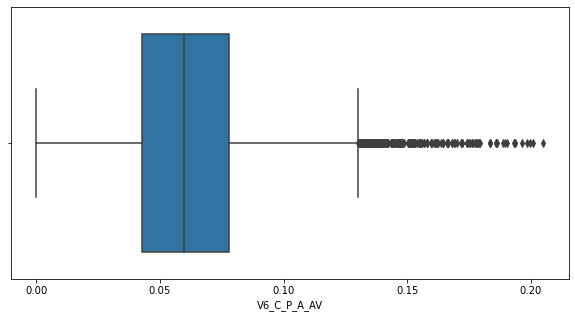

In [183]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_P_A_AV", data=train)
pass

Сравним количество записей до и после

In [184]:
len(raw_data)

17441

In [185]:
len(train)

17289

### QRS комплекс

Теперь удалим выбросы с QRS волны

#### ALL

In [186]:
chanel = 'ALL'

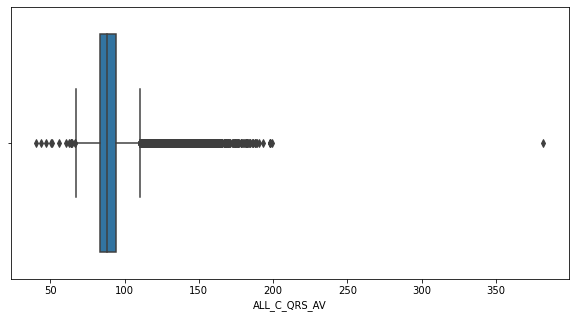

In [187]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=raw_data)
pass

In [188]:
raw_data[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     40.407148
0.005     73.018176
0.010     74.434510
0.050     78.209463
0.100     80.006398
0.500     87.913325
0.900    106.893542
0.950    122.798395
0.990    156.141901
0.995    163.351587
1.000    381.973276
Name: ALL_C_QRS_AV, dtype: float64

In [189]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_AV'] < 55) |
    (train[chanel + '_C_QRS_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     60.581697
0.005     73.391960
0.010     74.765432
0.050     78.279007
0.100     80.050750
0.500     87.902568
0.900    106.557869
0.950    122.212722
0.990    154.809436
0.995    162.529058
1.000    199.235219
Name: ALL_C_QRS_AV, dtype: float64

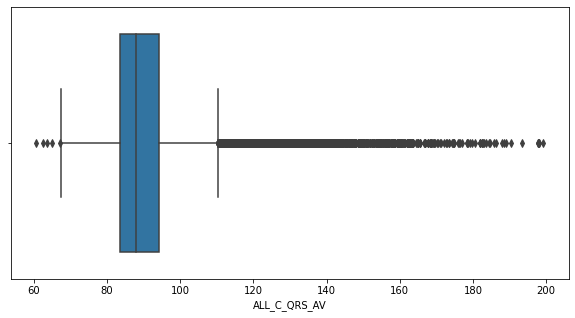

In [190]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=train)
pass

То же самое по всем каналам

#### I

In [191]:
chanel = 'I'

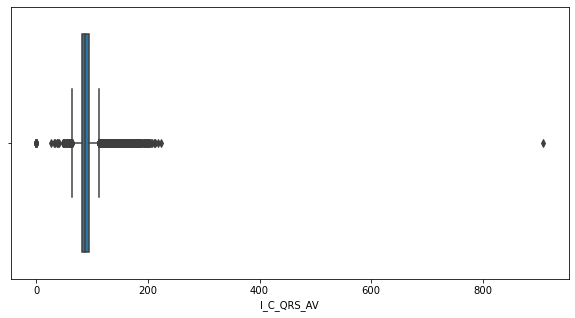

In [192]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=raw_data)
pass

In [193]:
raw_data[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005     67.831016
0.010     72.666667
0.050     77.090909
0.100     79.090909
0.500     87.692308
0.900    107.066667
0.950    126.142857
0.990    165.726923
0.995    173.609091
1.000    908.000000
Name: I_C_QRS_AV, dtype: float64

In [194]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_AV'] > 300)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     38.000000
0.005     71.482540
0.010     73.272727
0.050     77.200000
0.100     79.142857
0.500     87.692308
0.900    106.888889
0.950    125.750000
0.990    164.255714
0.995    172.967308
1.000    224.400000
Name: I_C_QRS_AV, dtype: float64

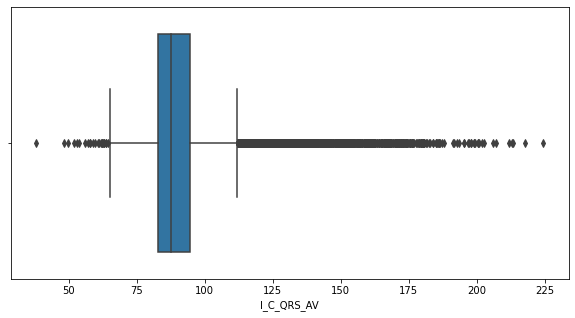

In [195]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=train)
pass

#### II

In [196]:
chanel = 'II'

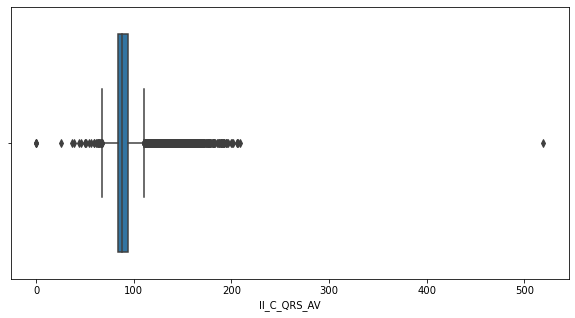

In [197]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=raw_data)
pass

In [198]:
raw_data[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005     72.462222
0.010     74.750000
0.050     78.444444
0.100     80.303030
0.500     88.190476
0.900    107.166667
0.950    123.800000
0.990    158.966667
0.995    168.000000
1.000    519.368421
Name: II_C_QRS_AV, dtype: float64

In [199]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     50.243902
0.005     73.733333
0.010     75.141429
0.050     78.555556
0.100     80.363636
0.500     88.181818
0.900    106.857143
0.950    123.127778
0.990    157.746061
0.995    166.867563
1.000    208.814815
Name: II_C_QRS_AV, dtype: float64

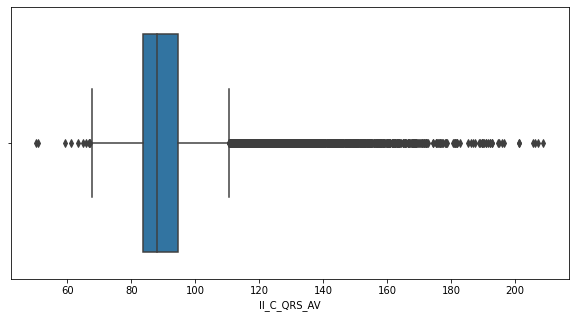

In [200]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=train)
pass

#### III

In [201]:
chanel = 'III'

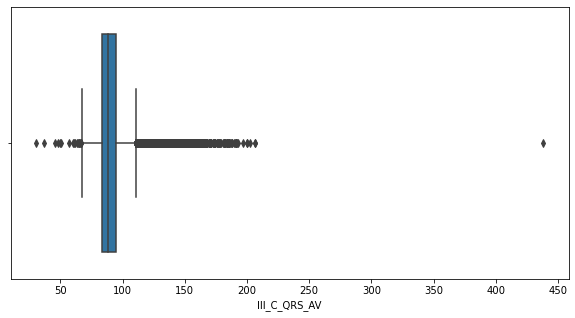

In [202]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=raw_data)
pass

In [203]:
raw_data[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     30.476190
0.005     72.898009
0.010     74.911169
0.050     78.623377
0.100     80.428571
0.500     88.363636
0.900    107.238095
0.950    123.428571
0.990    157.731429
0.995    165.582857
1.000    438.170213
Name: III_C_QRS_AV, dtype: float64

In [204]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     60.244898
0.005     73.620000
0.010     75.267937
0.050     78.714286
0.100     80.507937
0.500     88.349206
0.900    106.858571
0.950    122.827778
0.990    156.547143
0.995    164.194643
1.000    206.571429
Name: III_C_QRS_AV, dtype: float64

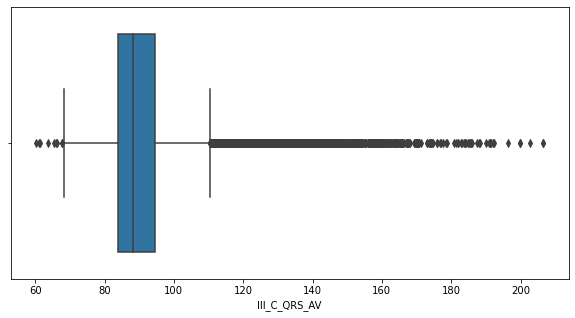

In [205]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=train)
pass

#### AVR

In [206]:
chanel = 'AVR'

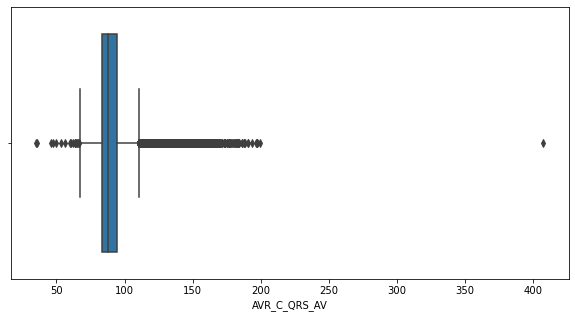

In [207]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=raw_data)
pass

In [208]:
raw_data[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     35.063830
0.005     72.733333
0.010     74.292308
0.050     78.053333
0.100     79.880000
0.500     87.828571
0.900    106.779487
0.950    122.666667
0.990    156.061538
0.995    163.885961
1.000    407.417476
Name: AVR_C_QRS_AV, dtype: float64

In [209]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     59.679612
0.005     73.198773
0.010     74.630535
0.050     78.150000
0.100     79.940067
0.500     87.816667
0.900    106.387841
0.950    122.093162
0.990    154.685833
0.995    162.881060
1.000    199.333333
Name: AVR_C_QRS_AV, dtype: float64

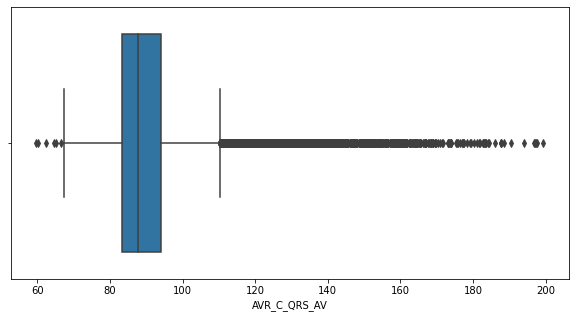

In [210]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=train)
pass

#### AVL

In [211]:
chanel = 'AVL'

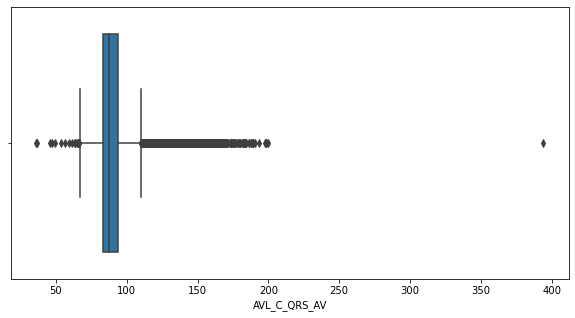

In [212]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=raw_data)
pass

In [213]:
raw_data[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     36.000000
0.005     72.783837
0.010     74.312258
0.050     78.093190
0.100     79.876833
0.500     87.827957
0.900    106.768328
0.950    122.776812
0.990    156.433127
0.995    163.836129
1.000    394.065116
Name: AVL_C_QRS_AV, dtype: float64

Нижние выбросы оставим по той же причине, по которой оставляли выбросы с амплитудой P волны выше. Удалим верхние выбросы

In [214]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     59.409524
0.005     73.238802
0.010     74.663614
0.050     78.162023
0.100     79.920865
0.500     87.806452
0.900    106.413164
0.950    122.314516
0.990    154.769695
0.995    162.765880
1.000    199.476703
Name: AVL_C_QRS_AV, dtype: float64

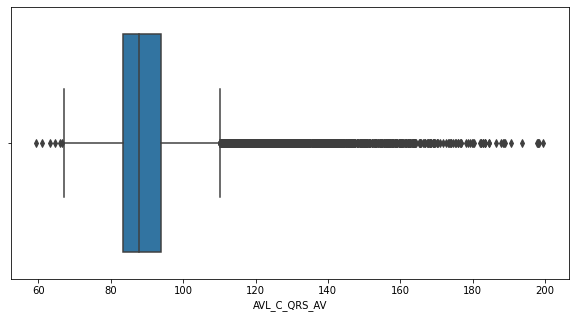

In [215]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=train)
pass

#### AVF

In [216]:
chanel = 'AVF'

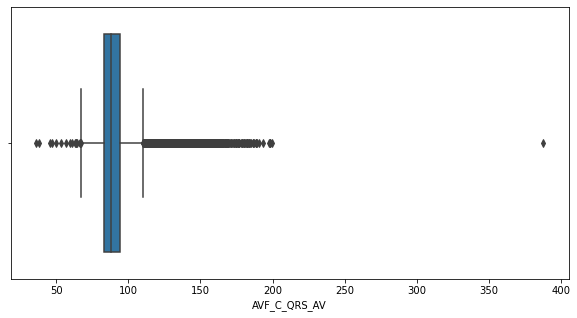

In [217]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=raw_data)
pass

In [218]:
raw_data[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     36.000000
0.005     72.841861
0.010     74.288645
0.050     78.085741
0.100     79.876543
0.500     87.841270
0.900    106.767196
0.950    122.754579
0.990    156.227523
0.995    163.442232
1.000    387.758542
Name: AVF_C_QRS_AV, dtype: float64

In [219]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     59.349001
0.005     73.249455
0.010     74.640415
0.050     78.166389
0.100     79.944004
0.500     87.820484
0.900    106.455732
0.950    122.125992
0.990    154.656122
0.995    162.574783
1.000    199.283951
Name: AVF_C_QRS_AV, dtype: float64

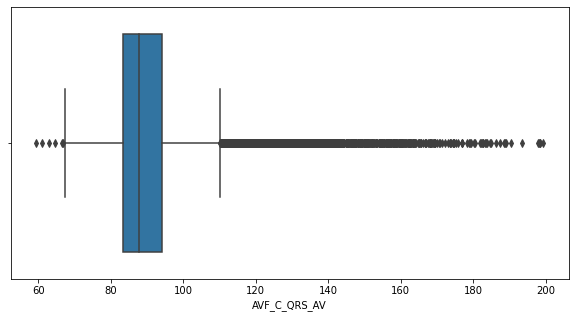

In [220]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=train)
pass

#### V1

In [221]:
chanel = 'V1'

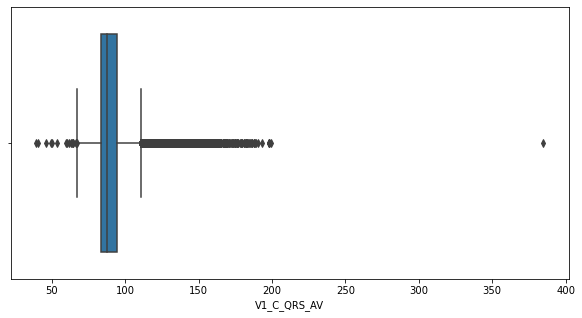

In [222]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=raw_data)
pass

In [223]:
raw_data[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     39.243902
0.005     72.953944
0.010     74.359015
0.050     78.151181
0.100     79.949256
0.500     87.874016
0.900    106.786190
0.950    122.834646
0.990    156.122647
0.995    163.364409
1.000    384.798196
Name: V1_C_QRS_AV, dtype: float64

In [224]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     59.876168
0.005     73.303590
0.010     74.701575
0.050     78.218947
0.100     79.983001
0.500     87.860321
0.900    106.519423
0.950    122.235728
0.990    154.750929
0.995    162.513512
1.000    199.223097
Name: V1_C_QRS_AV, dtype: float64

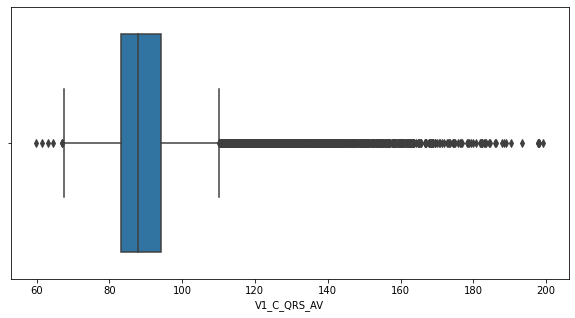

In [225]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=train)
pass

#### V2

In [226]:
chanel = 'V2'

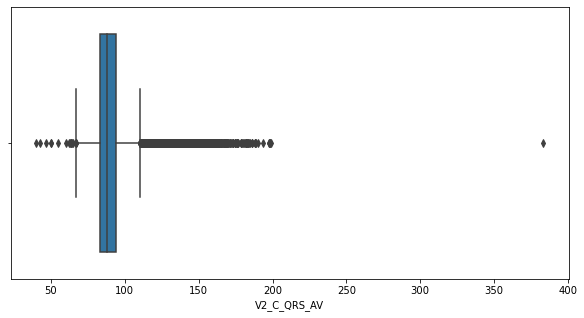

In [227]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=raw_data)
pass

In [228]:
raw_data[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     39.879518
0.005     72.998821
0.010     74.399460
0.050     78.187774
0.100     79.986057
0.500     87.898039
0.900    106.870904
0.950    122.792157
0.990    156.126849
0.995    163.351961
1.000    383.337072
Name: V2_C_QRS_AV, dtype: float64

In [229]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     60.138031
0.005     73.357877
0.010     74.735470
0.050     78.249376
0.100     80.027807
0.500     87.889216
0.900    106.531373
0.950    122.197423
0.990    154.780282
0.995    162.523248
1.000    199.227015
Name: V2_C_QRS_AV, dtype: float64

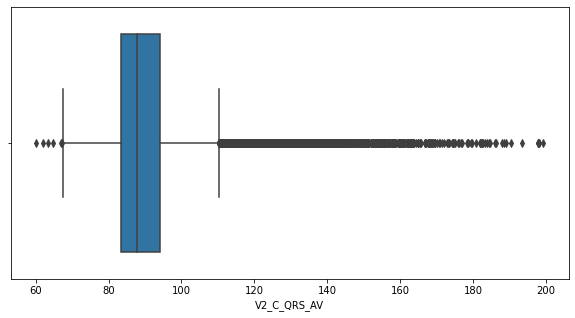

In [230]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=train)
pass

#### V3

In [231]:
chanel = 'V3'

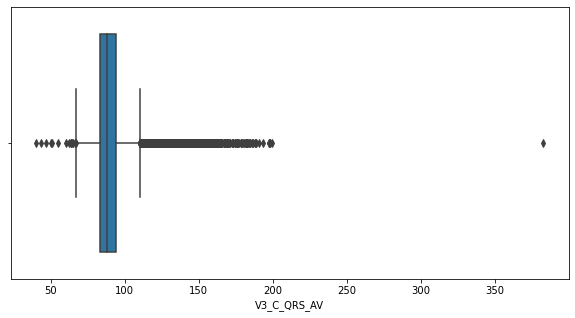

In [232]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=raw_data)
pass

In [233]:
raw_data[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     40.177246
0.005     73.012476
0.010     74.425429
0.050     78.205479
0.100     80.002609
0.500     87.913112
0.900    106.897326
0.950    122.795825
0.990    156.146191
0.995    163.367867
1.000    382.614825
Name: V3_C_QRS_AV, dtype: float64

In [234]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     60.391393
0.005     73.377443
0.010     74.754458
0.050     78.268493
0.100     80.047554
0.500     87.898293
0.900    106.529621
0.950    122.202620
0.990    154.796444
0.995    162.535446
1.000    199.247663
Name: V3_C_QRS_AV, dtype: float64

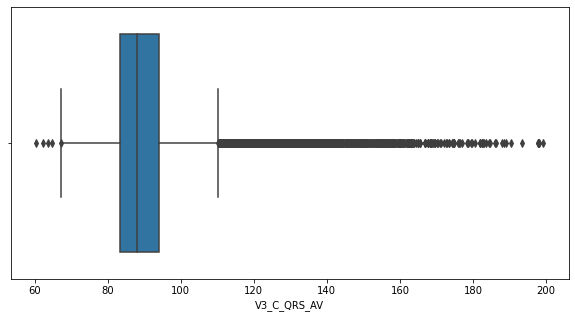

In [235]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=train)
pass

#### V4

In [236]:
chanel = 'V4'

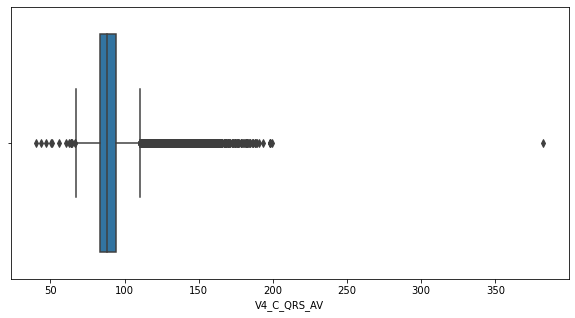

In [237]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=raw_data)
pass

In [238]:
raw_data[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     40.310448
0.005     73.018654
0.010     74.433846
0.050     78.207967
0.100     80.006028
0.500     87.913978
0.900    106.895015
0.950    122.795420
0.990    156.142120
0.995    163.366999
1.000    382.250314
Name: V4_C_QRS_AV, dtype: float64

In [239]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     60.522156
0.005     73.386859
0.010     74.760918
0.050     78.276508
0.100     80.050325
0.500     87.901393
0.900    106.542845
0.950    122.213945
0.990    154.806229
0.995    162.532935
1.000    199.255566
Name: V4_C_QRS_AV, dtype: float64

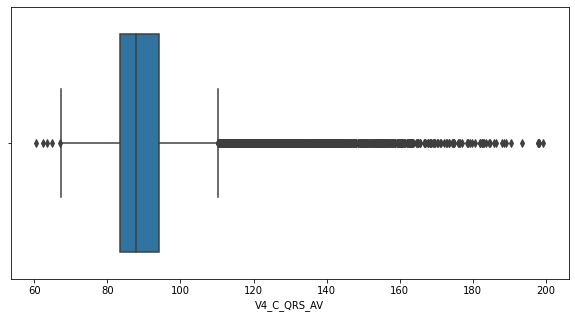

In [240]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=train)
pass

#### V5

In [241]:
chanel = 'V5'

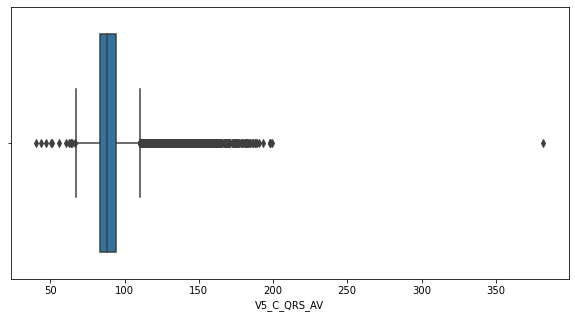

In [242]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=raw_data)
pass

In [243]:
raw_data[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     40.373472
0.005     73.018468
0.010     74.434282
0.050     78.208354
0.100     80.006025
0.500     87.912688
0.900    106.893405
0.950    122.797404
0.990    156.139704
0.995    163.353864
1.000    382.062539
Name: V5_C_QRS_AV, dtype: float64

In [244]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     60.575848
0.005     73.390371
0.010     74.764370
0.050     78.278997
0.100     80.050981
0.500     87.902849
0.900    106.552156
0.950    122.212840
0.990    154.807565
0.995    162.529051
1.000    199.238669
Name: V5_C_QRS_AV, dtype: float64

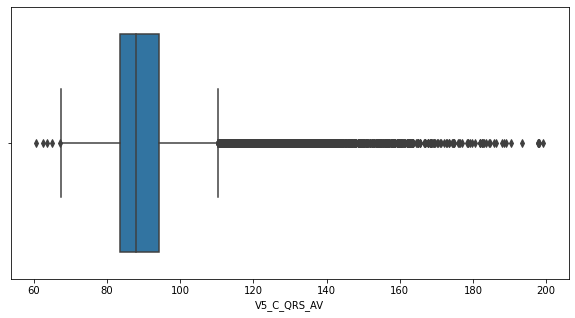

In [245]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=train)
pass

#### V6

In [246]:
chanel = 'V6'

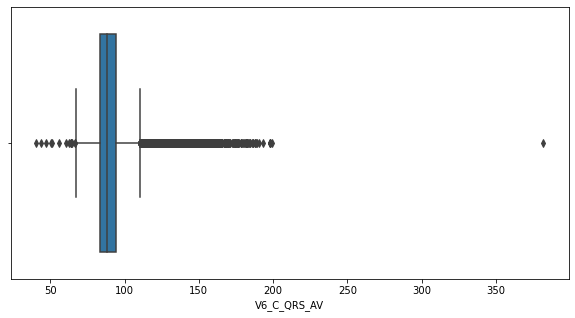

In [247]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=raw_data)
pass

In [248]:
raw_data[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     40.407148
0.005     73.018176
0.010     74.434510
0.050     78.209463
0.100     80.006398
0.500     87.913325
0.900    106.893542
0.950    122.798395
0.990    156.141901
0.995    163.351587
1.000    381.973276
Name: V6_C_QRS_AV, dtype: float64

In [249]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     60.581697
0.005     73.391960
0.010     74.765432
0.050     78.279007
0.100     80.050750
0.500     87.902568
0.900    106.557869
0.950    122.212722
0.990    154.809436
0.995    162.529058
1.000    199.235219
Name: V6_C_QRS_AV, dtype: float64

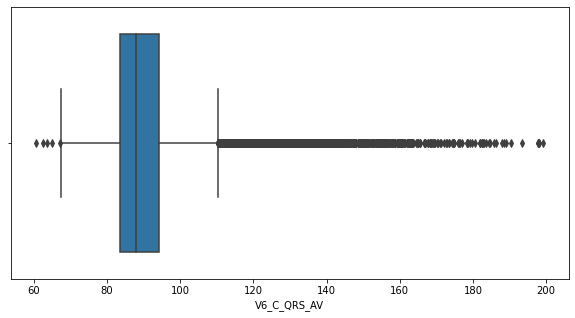

In [250]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_AV", data=train)
pass

Посмотрим на количество записей до и после

In [251]:
len(raw_data)

17441

In [252]:
len(train)

17286

### QRS-амплитуда

Рассмотрим QRS амплитуду

#### ALL

In [253]:
chanel = 'ALL'

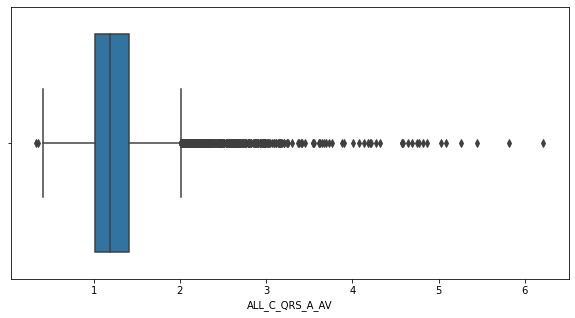

In [254]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=raw_data)
pass

In [255]:
raw_data[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.331651
0.005    0.615303
0.010    0.662716
0.050    0.795111
0.100    0.872796
0.500    1.190567
0.900    1.665269
0.950    1.862871
0.990    2.540681
0.995    2.904695
1.000    6.214102
Name: ALL_C_QRS_A_AV, dtype: float64

In [256]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_A_AV'] > 4.5)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.331651
0.005    0.614866
0.010    0.662276
0.050    0.794551
0.100    0.872276
0.500    1.188672
0.900    1.656637
0.950    1.840348
0.990    2.434894
0.995    2.751420
1.000    4.274079
Name: ALL_C_QRS_A_AV, dtype: float64

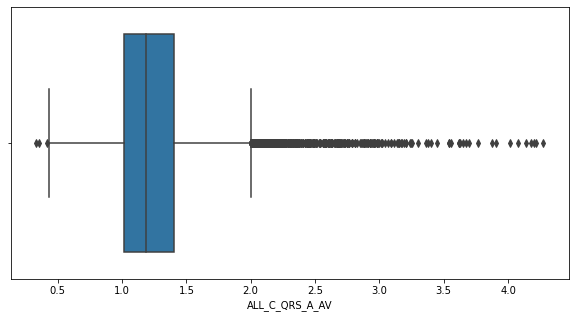

In [257]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=train)
pass

То же самое по всем каналам

#### I

In [258]:
chanel = 'I'

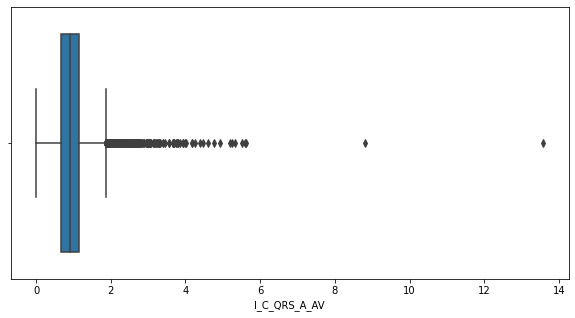

In [259]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=raw_data)
pass

In [260]:
raw_data[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     0.000000
0.005     0.265911
0.010     0.304709
0.050     0.437500
0.100     0.521222
0.500     0.900455
0.900     1.418333
0.950     1.608250
0.990     2.219542
0.995     2.663231
1.000    13.579800
Name: I_C_QRS_A_AV, dtype: float64

In [261]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_A_AV'] > 4.5)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.106600
0.005    0.275885
0.010    0.309863
0.050    0.438826
0.100    0.521345
0.500    0.898818
0.900    1.410560
0.950    1.594367
0.990    2.104256
0.995    2.452964
1.000    4.377538
Name: I_C_QRS_A_AV, dtype: float64

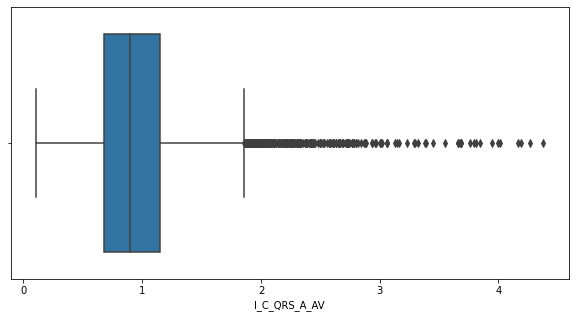

In [262]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=train)
pass

#### II

In [263]:
chanel = 'II'

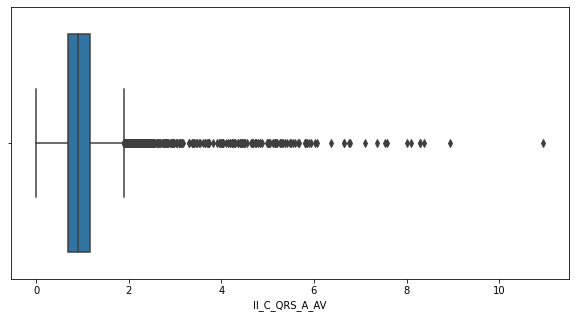

In [264]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=raw_data)
pass

In [265]:
raw_data[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     0.000000
0.005     0.259175
0.010     0.291762
0.050     0.436182
0.100     0.524429
0.500     0.909125
0.900     1.463000
0.950     1.701100
0.990     2.466509
0.995     4.007889
1.000    10.953400
Name: II_C_QRS_A_AV, dtype: float64

In [266]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_A_AV'] > 6)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.140071
0.005    0.261868
0.010    0.293580
0.050    0.436191
0.100    0.523692
0.500    0.907100
0.900    1.454700
0.950    1.680861
0.990    2.290450
0.995    2.840795
1.000    5.941200
Name: II_C_QRS_A_AV, dtype: float64

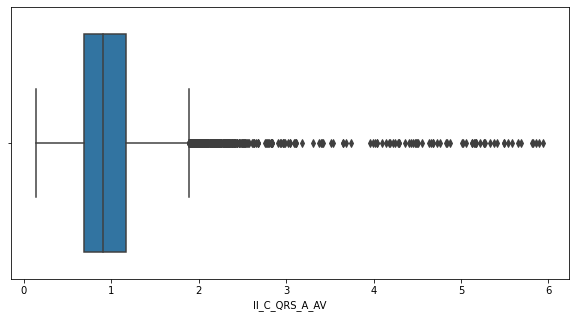

In [267]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=train)
pass

#### III

In [268]:
chanel = 'III'

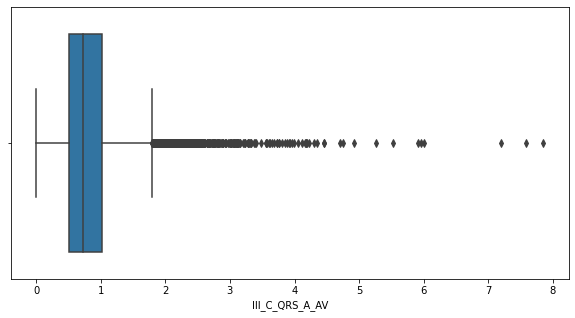

In [269]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=raw_data)
pass

In [270]:
raw_data[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.186524
0.010    0.214035
0.050    0.300600
0.100    0.365111
0.500    0.720000
0.900    1.390682
0.950    1.679750
0.990    2.452150
0.995    2.888067
1.000    7.851364
Name: III_C_QRS_A_AV, dtype: float64

In [271]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_A_AV'] > 5)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.101667
0.005    0.194505
0.010    0.218835
0.050    0.301727
0.100    0.365355
0.500    0.717392
0.900    1.378132
0.950    1.657649
0.990    2.387461
0.995    2.658397
1.000    4.924600
Name: III_C_QRS_A_AV, dtype: float64

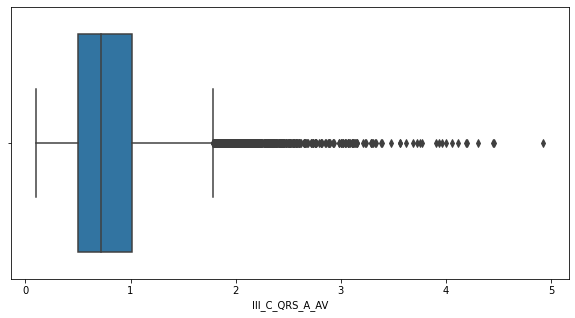

In [272]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=train)
pass

#### AVR

In [273]:
chanel = 'AVR'

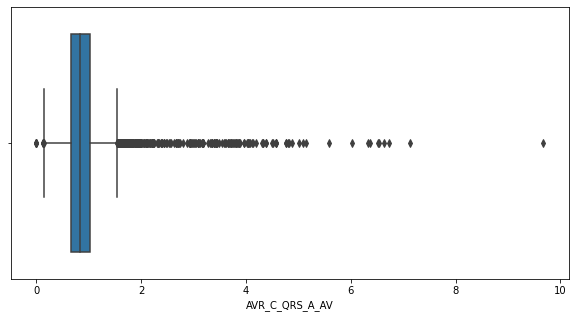

In [274]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=raw_data)
pass

In [275]:
raw_data[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.263161
0.010    0.307293
0.050    0.454400
0.100    0.531214
0.500    0.843556
0.900    1.206500
0.950    1.343214
0.990    1.913700
0.995    3.029311
1.000    9.673000
Name: AVR_C_QRS_A_AV, dtype: float64

In [276]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_A_AV'] > 8)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.124500
0.005    0.266000
0.010    0.308669
0.050    0.455208
0.100    0.531710
0.500    0.842697
0.900    1.200807
0.950    1.333402
0.990    1.775402
0.995    2.205526
1.000    4.884667
Name: AVR_C_QRS_A_AV, dtype: float64

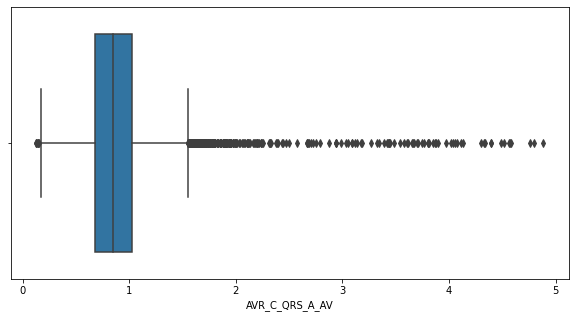

In [277]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=train)
pass

#### AVL

In [278]:
chanel = 'AVL'

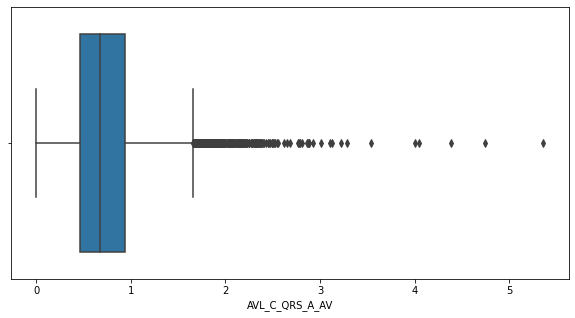

In [279]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=raw_data)
pass

In [280]:
raw_data[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.160120
0.010    0.181065
0.050    0.257071
0.100    0.319000
0.500    0.673167
0.900    1.229556
0.950    1.427769
0.990    1.920433
0.995    2.153772
1.000    5.358100
Name: AVL_C_QRS_A_AV, dtype: float64

In [281]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_A_AV'] > 3.5)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.089400
0.005    0.163671
0.010    0.182937
0.050    0.257233
0.100    0.318683
0.500    0.671317
0.900    1.221793
0.950    1.414981
0.990    1.895787
0.995    2.116688
1.000    3.216818
Name: AVL_C_QRS_A_AV, dtype: float64

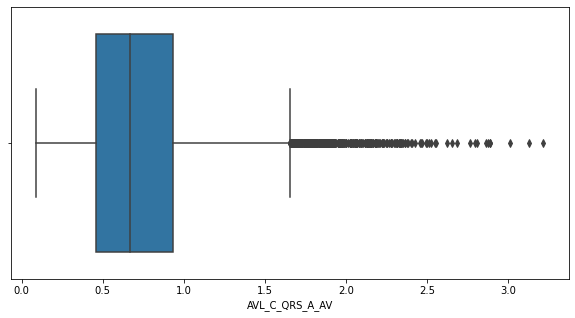

In [282]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=train)
pass

#### AVF

In [283]:
chanel = 'AVF'

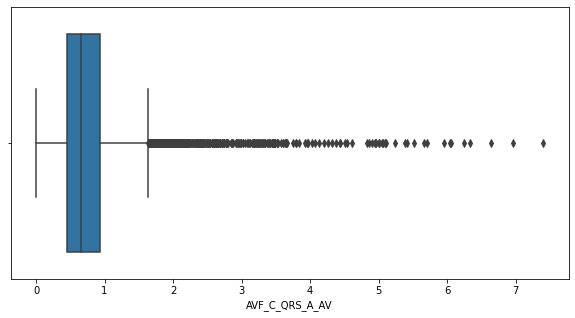

In [284]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=raw_data)
pass

In [285]:
raw_data[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.177516
0.010    0.196976
0.050    0.277143
0.100    0.332000
0.500    0.663000
0.900    1.273700
0.950    1.528556
0.990    2.392516
0.995    3.186837
1.000    7.405889
Name: AVF_C_QRS_A_AV, dtype: float64

In [286]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_A_AV'] > 5.5)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.117125
0.005    0.179744
0.010    0.198326
0.050    0.277236
0.100    0.331774
0.500    0.660837
0.900    1.254585
0.950    1.495524
0.990    2.133485
0.995    2.641856
1.000    5.050200
Name: AVF_C_QRS_A_AV, dtype: float64

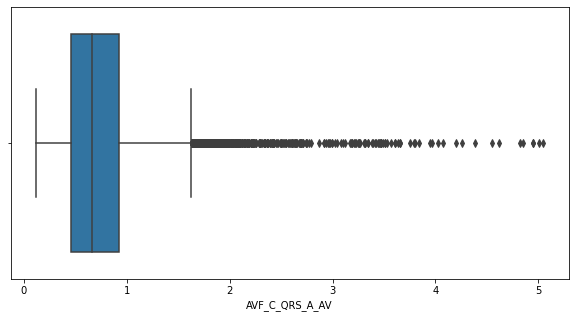

In [287]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=train)
pass

#### V1

In [288]:
chanel = 'V1'

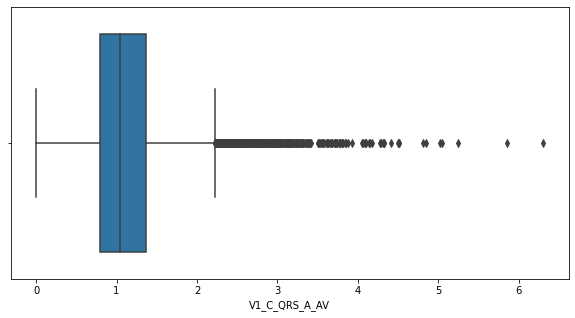

In [289]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=raw_data)
pass

In [290]:
raw_data[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.289797
0.010    0.336317
0.050    0.497000
0.100    0.601300
0.500    1.038444
0.900    1.749083
0.950    2.054200
0.990    2.906720
0.995    3.245535
1.000    6.304882
Name: V1_C_QRS_A_AV, dtype: float64

In [291]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_A_AV'] > 5.5)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.116143
0.005    0.291317
0.010    0.336965
0.050    0.497089
0.100    0.600881
0.500    1.036875
0.900    1.744347
0.950    2.046203
0.990    2.889808
0.995    3.233059
1.000    5.242200
Name: V1_C_QRS_A_AV, dtype: float64

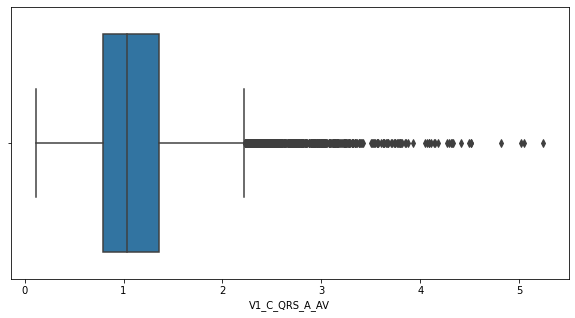

In [292]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=train)
pass

#### V2

In [293]:
chanel = 'V2'

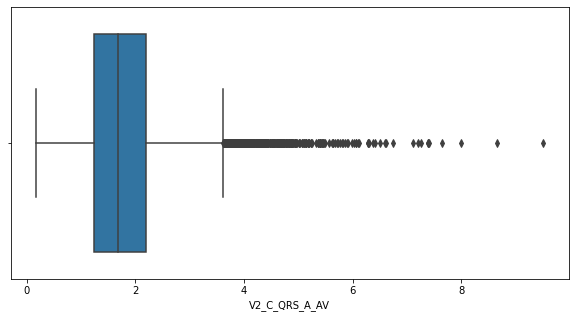

In [294]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=raw_data)
pass

In [295]:
raw_data[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.175444
0.005    0.457570
0.010    0.524446
0.050    0.778615
0.100    0.937700
0.500    1.677889
0.900    2.793500
0.950    3.253700
0.990    4.436111
0.995    4.886333
1.000    9.511714
Name: V2_C_QRS_A_AV, dtype: float64

In [296]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_A_AV'] > 7)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.175444
0.005    0.457642
0.010    0.527994
0.050    0.778633
0.100    0.937910
0.500    1.674530
0.900    2.781503
0.950    3.236387
0.990    4.370395
0.995    4.789788
1.000    6.739692
Name: V2_C_QRS_A_AV, dtype: float64

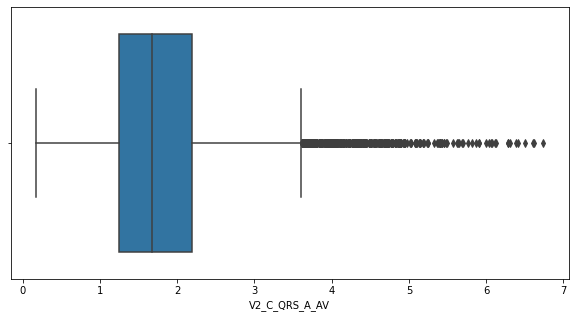

In [297]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=train)
pass

#### V3

In [298]:
chanel = 'V3'

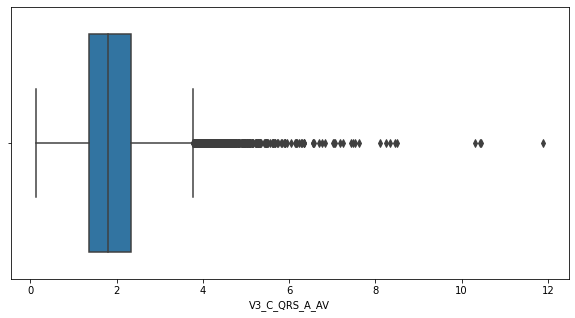

In [299]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=raw_data)
pass

In [300]:
raw_data[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     0.132917
0.005     0.505220
0.010     0.592291
0.050     0.866556
0.100     1.043643
0.500     1.790125
0.900     2.936692
0.950     3.375727
0.990     4.612667
0.995     5.082014
1.000    11.891800
Name: V3_C_QRS_A_AV, dtype: float64

In [301]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_A_AV'] > 8)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.132917
0.005    0.504365
0.010    0.591138
0.050    0.865692
0.100    1.040687
0.500    1.785444
0.900    2.921258
0.950    3.338353
0.990    4.472122
0.995    4.926111
1.000    7.614800
Name: V3_C_QRS_A_AV, dtype: float64

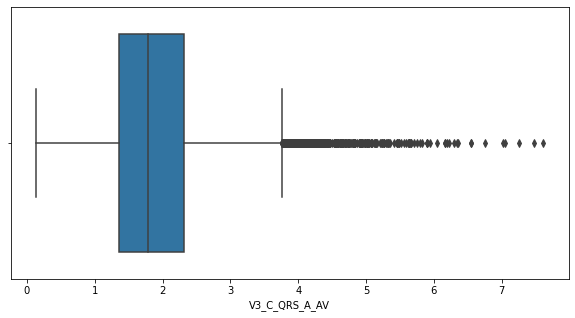

In [302]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=train)
pass

#### V4

In [303]:
chanel = 'V4'

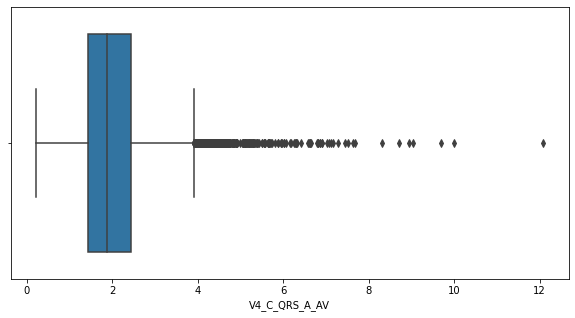

In [304]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=raw_data)
pass

In [305]:
raw_data[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     0.216000
0.005     0.469022
0.010     0.572508
0.050     0.895923
0.100     1.084091
0.500     1.878667
0.900     3.030714
0.950     3.488818
0.990     4.538600
0.995     5.104791
1.000    12.086400
Name: V4_C_QRS_A_AV, dtype: float64

In [306]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_A_AV'] > 8)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.216000
0.005    0.468917
0.010    0.569564
0.050    0.893483
0.100    1.081303
0.500    1.875881
0.900    3.011661
0.950    3.457375
0.990    4.438335
0.995    4.821717
1.000    7.687000
Name: V4_C_QRS_A_AV, dtype: float64

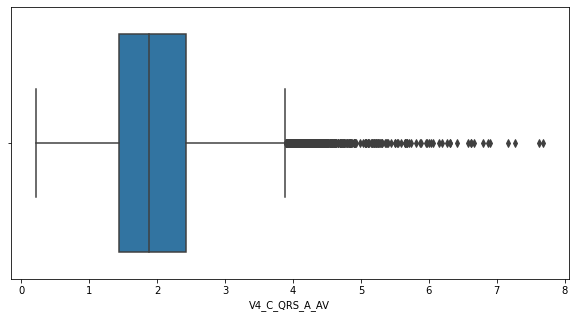

In [307]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=train)
pass

#### V5

In [308]:
chanel = 'V5'

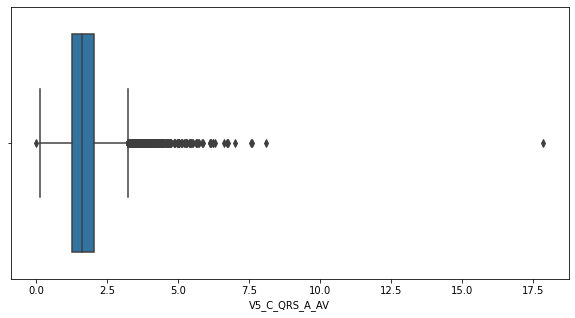

In [309]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=raw_data)
pass

In [310]:
raw_data[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     0.000000
0.005     0.416687
0.010     0.499460
0.050     0.800333
0.100     0.961923
0.500     1.606444
0.900     2.559556
0.950     2.966750
0.990     3.882107
0.995     4.379640
1.000    17.847083
Name: V5_C_QRS_A_AV, dtype: float64

In [311]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_A_AV'] > 10)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.146182
0.005    0.416692
0.010    0.498226
0.050    0.799979
0.100    0.961556
0.500    1.604375
0.900    2.542273
0.950    2.948458
0.990    3.828568
0.995    4.231432
1.000    6.756250
Name: V5_C_QRS_A_AV, dtype: float64

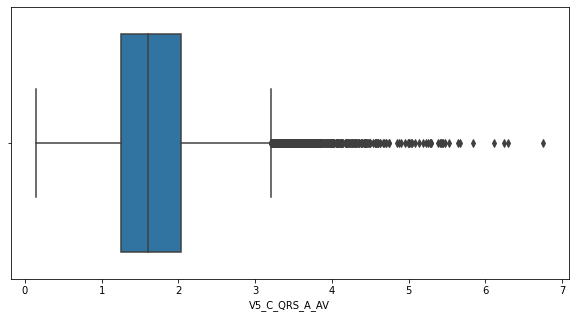

In [312]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=train)
pass

#### V6

In [313]:
chanel = 'V6'

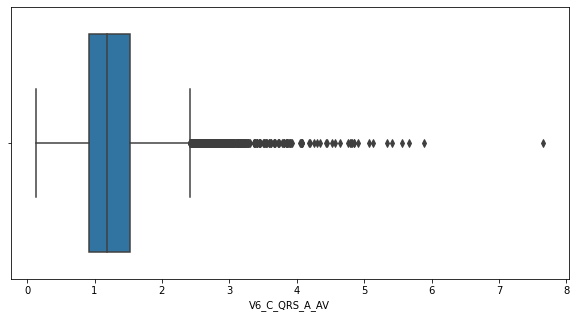

In [314]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=raw_data)
pass

In [315]:
raw_data[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.132875
0.005    0.346305
0.010    0.399300
0.050    0.598700
0.100    0.710700
0.500    1.186250
0.900    1.896125
0.950    2.195417
0.990    2.981650
0.995    3.293022
1.000    7.658667
Name: V6_C_QRS_A_AV, dtype: float64

In [316]:
rows_to_delete = train[
    (train[chanel + '_C_QRS_A_AV'] > 6)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRS_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.132875
0.005    0.345212
0.010    0.399062
0.050    0.598800
0.100    0.710556
0.500    1.184800
0.900    1.886111
0.950    2.175827
0.990    2.931473
0.995    3.218467
1.000    5.411000
Name: V6_C_QRS_A_AV, dtype: float64

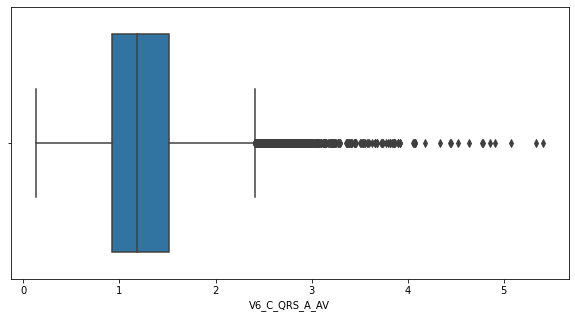

In [317]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRS_A_AV", data=train)
pass

Сравним длины до и после

In [318]:
len(raw_data)

17441

In [319]:
len(train)

17251

### T-волна

Теперь рассмотрим T волну

#### ALL

In [320]:
chanel = 'ALL'

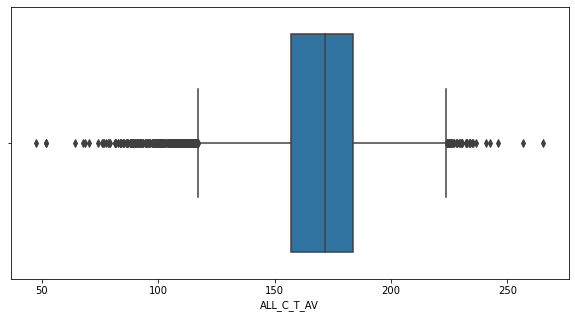

In [321]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=raw_data)
pass

In [322]:
raw_data[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     47.460015
0.005     99.245226
0.010    107.912700
0.050    128.765171
0.100    139.688292
0.500    171.405665
0.900    194.275360
0.950    200.926313
0.990    214.384338
0.995    219.502160
1.000    265.419292
Name: ALL_C_T_AV, dtype: float64

In [323]:
rows_to_delete = train[
    (train[chanel + '_C_T_AV'] < 50) |
    (train[chanel + '_C_T_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     67.762669
0.005    101.446952
0.010    109.516201
0.050    129.406047
0.100    140.291865
0.500    171.520977
0.900    194.286470
0.950    200.866595
0.990    214.315528
0.995    219.274237
1.000    245.812881
Name: ALL_C_T_AV, dtype: float64

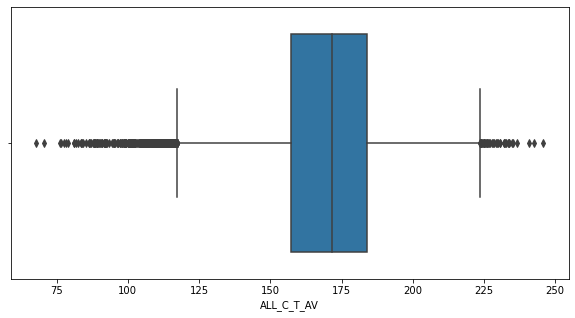

In [324]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=train)
pass

То же самое по всем каналам

#### I

In [325]:
chanel = 'I'

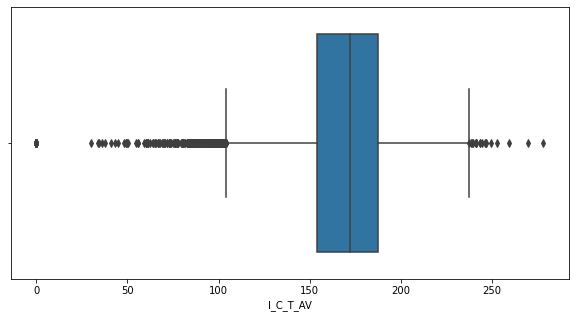

In [326]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=raw_data)
pass

In [327]:
raw_data[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005     77.885714
0.010     92.000000
0.050    119.000000
0.100    132.545455
0.500    172.222222
0.900    200.000000
0.950    208.000000
0.990    223.085714
0.995    228.285714
1.000    278.000000
Name: I_C_T_AV, dtype: float64

In [328]:
rows_to_delete = train[
    (train[chanel + '_C_T_AV'] < 1) |
    (train[chanel + '_C_T_AV'] > 260)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     34.000000
0.005     88.666667
0.010     97.082098
0.050    120.828333
0.100    133.555556
0.500    172.444444
0.900    200.200000
0.950    208.000000
0.990    222.631429
0.995    228.181111
1.000    252.800000
Name: I_C_T_AV, dtype: float64

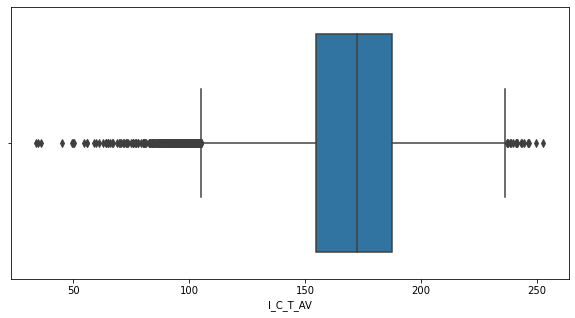

In [329]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=train)
pass

#### II

In [330]:
chanel = 'II'

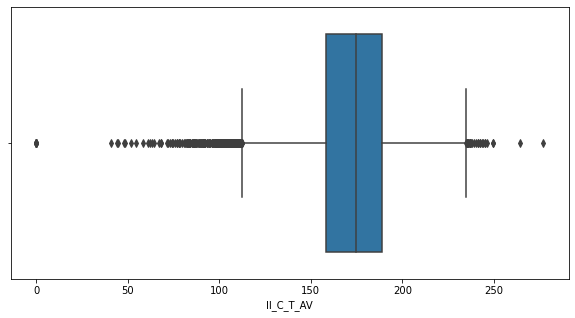

In [331]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=raw_data)
pass

In [332]:
raw_data[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005     95.062185
0.010    105.149744
0.050    127.235294
0.100    139.076923
0.500    174.727273
0.900    200.296296
0.950    207.200000
0.990    221.844444
0.995    225.924074
1.000    277.000000
Name: II_C_T_AV, dtype: float64

In [333]:
rows_to_delete = train[
    (train[chanel + '_C_T_AV'] < 10) |
    (train[chanel + '_C_T_AV'] > 260)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     52.000000
0.005     99.688690
0.010    107.291707
0.050    128.134762
0.100    139.724138
0.500    174.912879
0.900    200.298316
0.950    207.159211
0.990    221.652963
0.995    225.828929
1.000    249.733333
Name: II_C_T_AV, dtype: float64

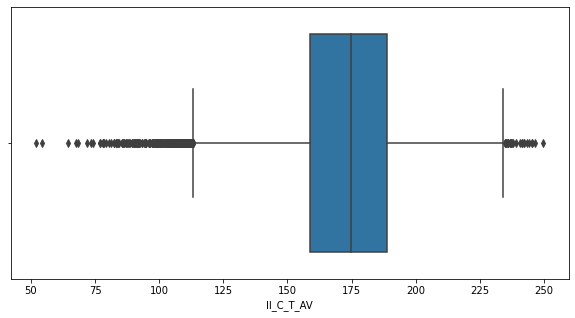

In [334]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=train)
pass

#### III

In [335]:
chanel = 'III'

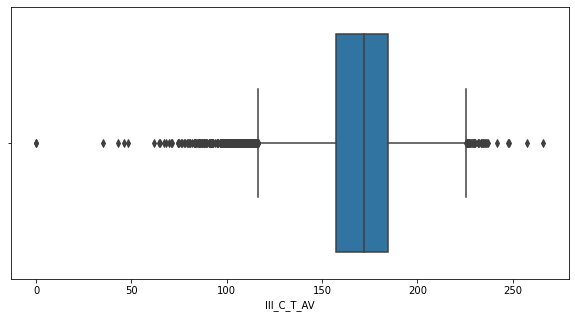

In [336]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=raw_data)
pass

In [337]:
raw_data[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005     98.809391
0.010    107.448214
0.050    128.444444
0.100    139.595238
0.500    171.968254
0.900    195.306122
0.950    202.204082
0.990    215.961905
0.995    221.071429
1.000    266.000000
Name: III_C_T_AV, dtype: float64

In [338]:
rows_to_delete = train[
    (train[chanel + '_C_T_AV'] < 10) |
    (train[chanel + '_C_T_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     64.605263
0.005    101.340091
0.010    108.918634
0.050    129.162850
0.100    140.422175
0.500    172.103896
0.900    195.310649
0.950    202.190476
0.990    215.740000
0.995    220.460615
1.000    248.255319
Name: III_C_T_AV, dtype: float64

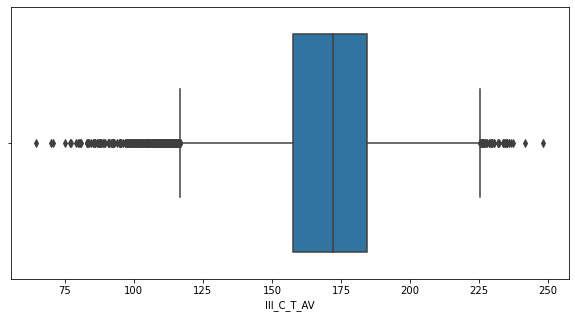

In [339]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=train)
pass

#### AVR

In [340]:
chanel = 'AVR'

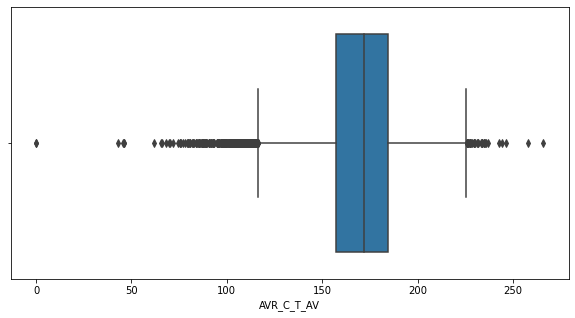

In [341]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=raw_data)
pass

In [342]:
raw_data[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005     98.274359
0.010    107.205246
0.050    128.274725
0.100    139.442424
0.500    171.973333
0.900    195.150000
0.950    201.933333
0.990    215.557815
0.995    220.396667
1.000    265.911111
Name: AVR_C_T_AV, dtype: float64

In [343]:
rows_to_delete = train[
    (train[chanel + '_C_T_AV'] < 50) |
    (train[chanel + '_C_T_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     65.811321
0.005    101.003524
0.010    109.109114
0.050    129.160767
0.100    140.115783
0.500    172.103704
0.900    195.155000
0.950    201.911111
0.990    215.282298
0.995    220.305583
1.000    244.138614
Name: AVR_C_T_AV, dtype: float64

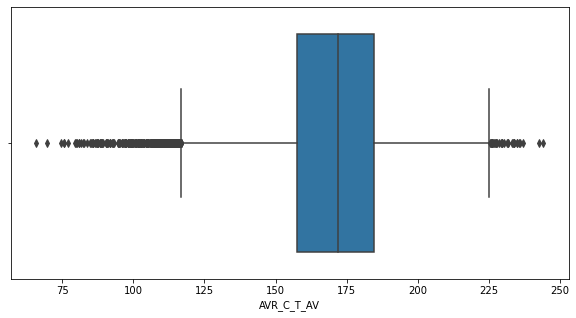

In [344]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=train)
pass

#### AVL

In [345]:
chanel = 'AVL'

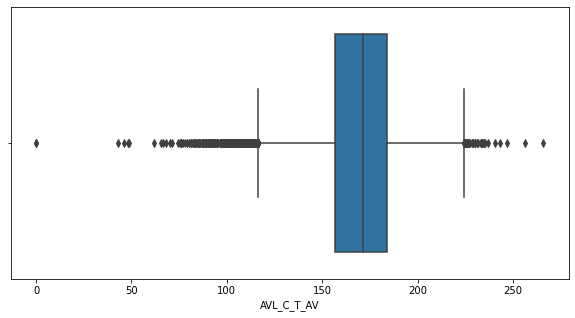

In [346]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=raw_data)
pass

In [347]:
raw_data[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005     98.288552
0.010    107.189765
0.050    128.196581
0.100    139.245478
0.500    171.360704
0.900    194.488479
0.950    201.247312
0.990    214.924424
0.995    219.930705
1.000    265.838710
Name: AVL_C_T_AV, dtype: float64

In [348]:
rows_to_delete = train[
    (train[chanel + '_C_T_AV'] < 50) |
    (train[chanel + '_C_T_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     66.705521
0.005    101.265730
0.010    109.127796
0.050    129.112031
0.100    140.038590
0.500    171.511649
0.900    194.496237
0.950    201.225806
0.990    214.750896
0.995    219.369908
1.000    243.177033
Name: AVL_C_T_AV, dtype: float64

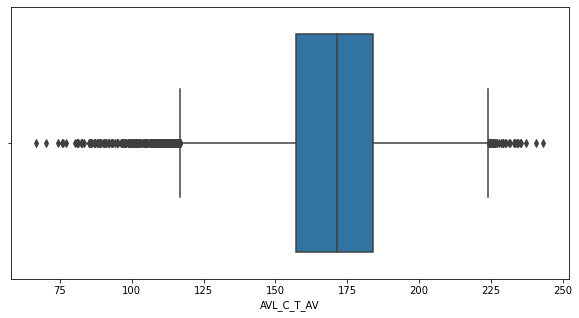

In [349]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=train)
pass

#### AVF

In [350]:
chanel = 'AVF'

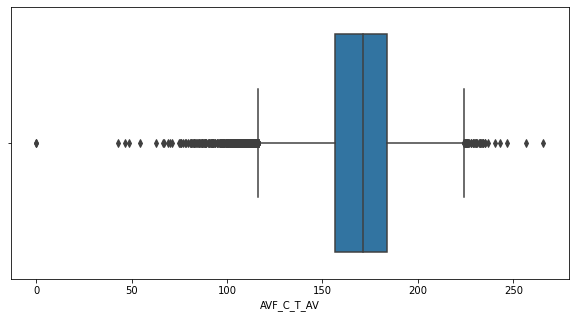

In [351]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=raw_data)
pass

In [352]:
raw_data[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005     98.521139
0.010    107.274007
0.050    128.363636
0.100    139.282648
0.500    171.324675
0.900    194.269841
0.950    201.011338
0.990    214.496507
0.995    219.460370
1.000    265.682540
Name: AVF_C_T_AV, dtype: float64

In [353]:
rows_to_delete = train[
    (train[chanel + '_C_T_AV'] < 50) |
    (train[chanel + '_C_T_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     66.838806
0.005    101.383980
0.010    109.090967
0.050    129.163775
0.100    140.112458
0.500    171.461764
0.900    194.272166
0.950    200.955974
0.990    214.360401
0.995    219.250298
1.000    243.138824
Name: AVF_C_T_AV, dtype: float64

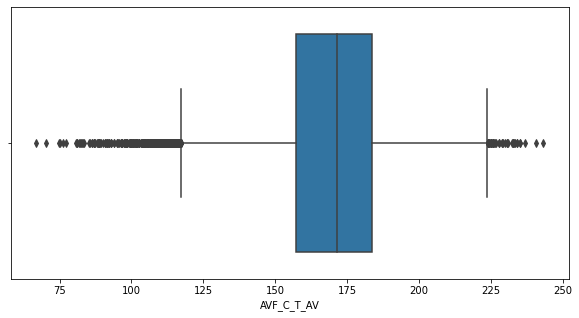

In [354]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=train)
pass

#### V1

In [355]:
chanel = 'V1'

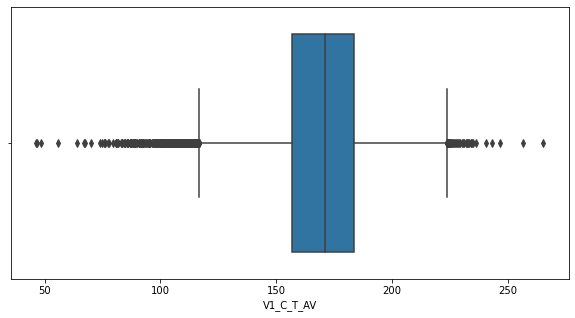

In [356]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=raw_data)
pass

In [357]:
raw_data[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     46.331288
0.005     98.686897
0.010    107.604703
0.050    128.527559
0.100    139.433071
0.500    171.223767
0.900    194.070866
0.950    200.814961
0.990    214.325547
0.995    219.262842
1.000    265.333333
Name: V1_C_T_AV, dtype: float64

In [358]:
rows_to_delete = train[
    (train[chanel + '_C_T_AV'] < 50) |
    (train[chanel + '_C_T_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     67.298606
0.005    101.432274
0.010    109.259395
0.050    129.330475
0.100    140.159509
0.500    171.394512
0.900    194.075669
0.950    200.776828
0.990    214.171170
0.995    219.094726
1.000    243.008168
Name: V1_C_T_AV, dtype: float64

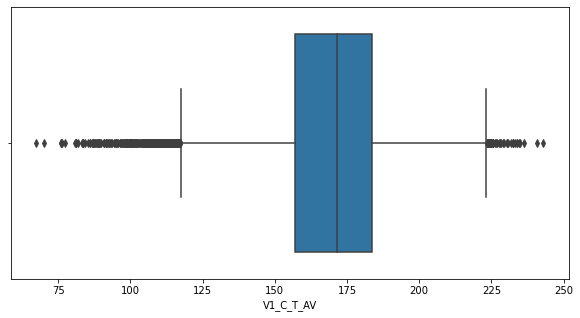

In [359]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=train)
pass

#### V2

In [360]:
chanel = 'V2'

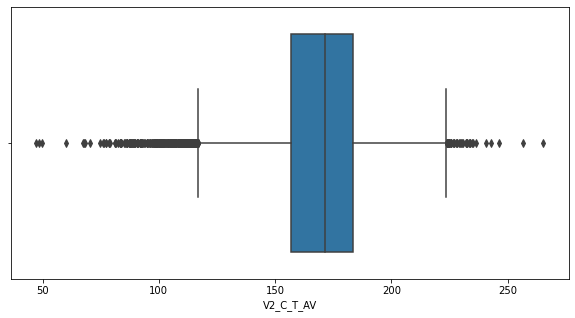

In [361]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=raw_data)
pass

In [362]:
raw_data[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     47.187659
0.005     99.114928
0.010    107.729614
0.050    128.625524
0.100    139.545122
0.500    171.322549
0.900    194.202941
0.950    200.824510
0.990    214.337407
0.995    219.351080
1.000    265.325490
Name: V2_C_T_AV, dtype: float64

In [363]:
rows_to_delete = train[
    (train[chanel + '_C_T_AV'] < 50) |
    (train[chanel + '_C_T_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     67.448000
0.005    101.448849
0.010    109.430113
0.050    129.459045
0.100    140.257923
0.500    171.465096
0.900    194.204790
0.950    200.783536
0.990    214.214842
0.995    219.162296
1.000    242.610209
Name: V2_C_T_AV, dtype: float64

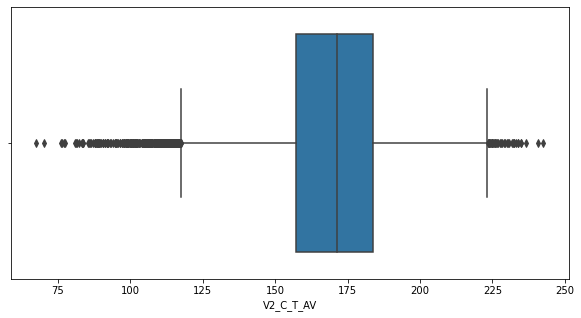

In [364]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=train)
pass

#### V3

In [365]:
chanel = 'V3'

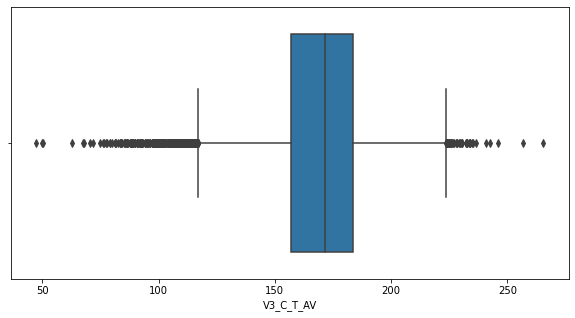

In [366]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=raw_data)
pass

In [367]:
raw_data[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     47.374841
0.005     99.223787
0.010    107.836447
0.050    128.709709
0.100    139.607584
0.500    171.387173
0.900    194.249022
0.950    200.873668
0.990    214.355434
0.995    219.446303
1.000    265.404436
Name: V3_C_T_AV, dtype: float64

In [368]:
rows_to_delete = train[
    (train[chanel + '_C_T_AV'] < 50) |
    (train[chanel + '_C_T_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     67.613324
0.005    101.472980
0.010    109.570292
0.050    129.528439
0.100    140.312939
0.500    171.506849
0.900    194.251937
0.950    200.830901
0.990    214.263019
0.995    219.232883
1.000    242.580029
Name: V3_C_T_AV, dtype: float64

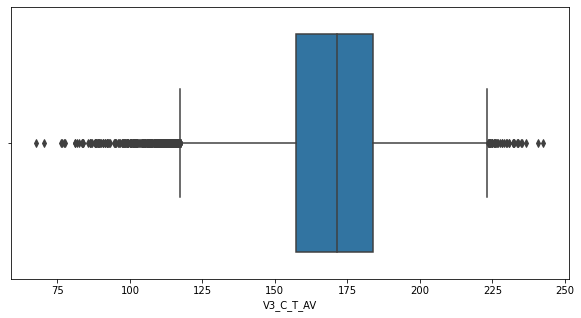

In [369]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=train)
pass

#### V4

In [370]:
chanel = 'V4'

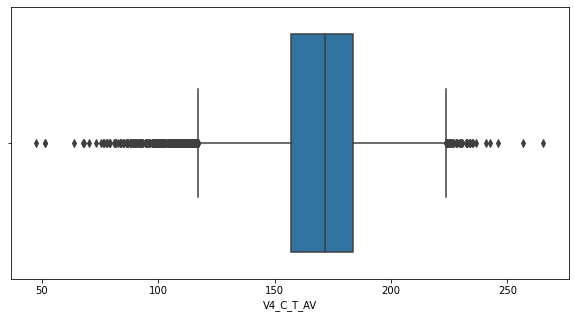

In [371]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=raw_data)
pass

In [372]:
raw_data[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     47.440315
0.005     99.233562
0.010    107.883608
0.050    128.733486
0.100    139.651340
0.500    171.395692
0.900    194.261975
0.950    200.917400
0.990    214.374191
0.995    219.486696
1.000    265.422287
Name: V4_C_T_AV, dtype: float64

In [373]:
rows_to_delete = train[
    (train[chanel + '_C_T_AV'] < 50) |
    (train[chanel + '_C_T_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     67.708454
0.005    101.486965
0.010    109.580130
0.050    129.553020
0.100    140.327299
0.500    171.532145
0.900    194.277444
0.950    200.852038
0.990    214.252632
0.995    219.259386
1.000    242.589936
Name: V4_C_T_AV, dtype: float64

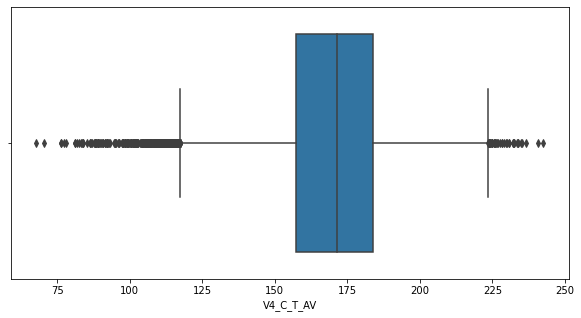

In [374]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=train)
pass

#### V5

In [375]:
chanel = 'V5'

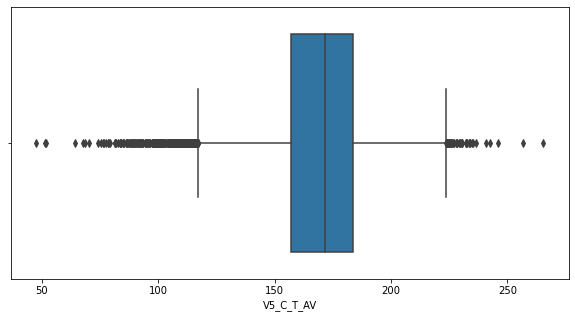

In [376]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=raw_data)
pass

In [377]:
raw_data[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     47.458884
0.005     99.240528
0.010    107.903374
0.050    128.760032
0.100    139.688867
0.500    171.404006
0.900    194.273864
0.950    200.925623
0.990    214.384656
0.995    219.501483
1.000    265.421918
Name: V5_C_T_AV, dtype: float64

In [378]:
rows_to_delete = train[
    (train[chanel + '_C_T_AV'] < 50) |
    (train[chanel + '_C_T_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     67.745128
0.005    101.489504
0.010    109.591538
0.050    129.555256
0.100    140.331317
0.500    171.536914
0.900    194.286138
0.950    200.862709
0.990    214.257318
0.995    219.264841
1.000    242.610204
Name: V5_C_T_AV, dtype: float64

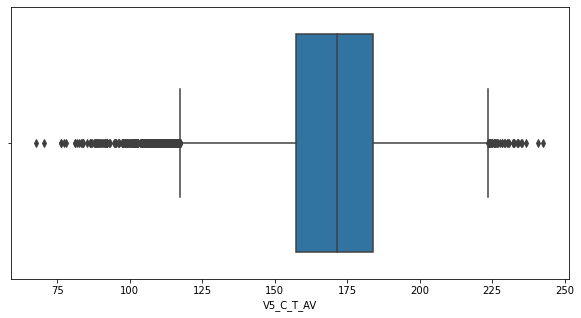

In [379]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=train)
pass

#### V6

In [380]:
chanel = 'V6'

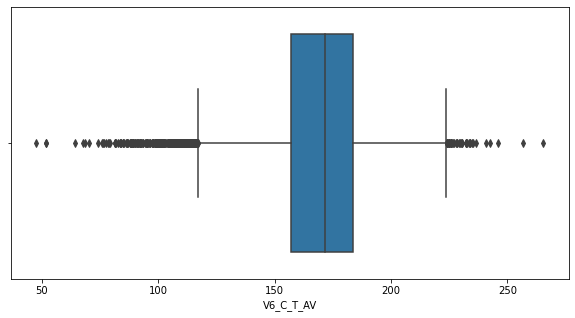

In [381]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=raw_data)
pass

In [382]:
raw_data[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     47.460015
0.005     99.245226
0.010    107.912700
0.050    128.765171
0.100    139.688292
0.500    171.405665
0.900    194.275360
0.950    200.926313
0.990    214.384338
0.995    219.502160
1.000    265.419292
Name: V6_C_T_AV, dtype: float64

In [383]:
rows_to_delete = train[
    (train[chanel + '_C_T_AV'] < 50) |
    (train[chanel + '_C_T_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     67.762669
0.005    101.490515
0.010    109.597049
0.050    129.561737
0.100    140.330358
0.500    171.538610
0.900    194.286470
0.950    200.866214
0.990    214.261288
0.995    219.260386
1.000    242.620981
Name: V6_C_T_AV, dtype: float64

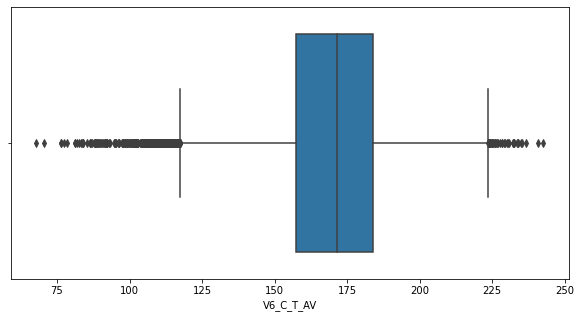

In [384]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_AV", data=train)
pass

Сравним длину до и после удалений

In [385]:
len(raw_data)

17441

In [386]:
len(train)

17238

### T-амплитуда

#### ALL

In [387]:
chanel = 'ALL'

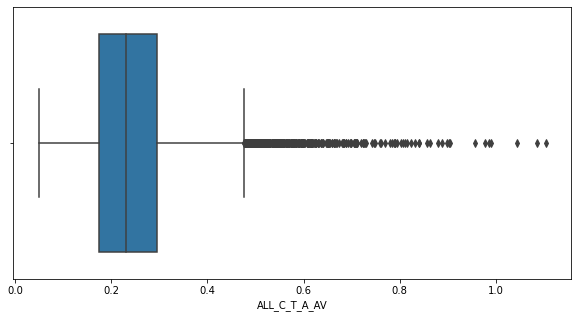

In [388]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=raw_data)
pass

In [389]:
raw_data[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.048882
0.005    0.076866
0.010    0.086108
0.050    0.114438
0.100    0.134124
0.500    0.230940
0.900    0.372160
0.950    0.425454
0.990    0.559742
0.995    0.624933
1.000    1.104571
Name: ALL_C_T_A_AV, dtype: float64

In [390]:
rows_to_delete = train[
    (train[chanel + '_C_T_A_AV'] > 0.95)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.048882
0.005    0.076635
0.010    0.085926
0.050    0.114040
0.100    0.133796
0.500    0.230195
0.900    0.368958
0.950    0.421334
0.990    0.541841
0.995    0.599815
1.000    0.902156
Name: ALL_C_T_A_AV, dtype: float64

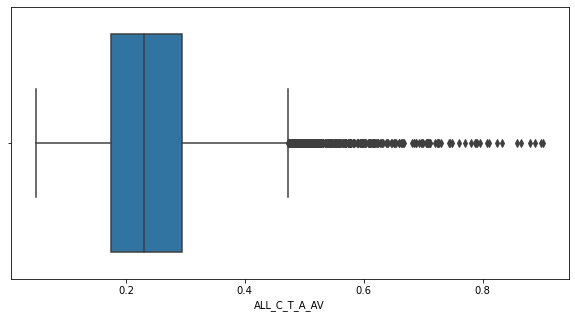

In [391]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=train)
pass

То же самое по всем каналам

#### I

In [392]:
chanel = 'I'

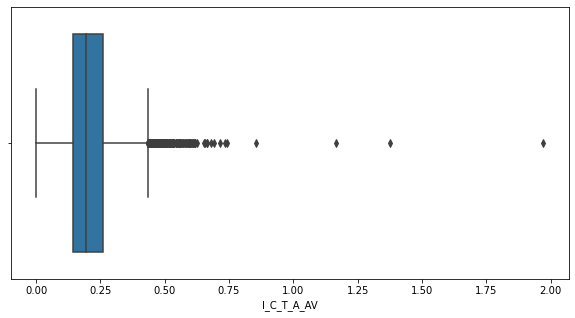

In [393]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=raw_data)
pass

In [394]:
raw_data[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.049275
0.010    0.059485
0.050    0.085833
0.100    0.104100
0.500    0.196000
0.900    0.327375
0.950    0.372625
0.990    0.476780
0.995    0.519255
1.000    1.972000
Name: I_C_T_A_AV, dtype: float64

In [395]:
rows_to_delete = train[
    (train[chanel + '_C_T_A_AV'] > 0.8)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.032125
0.005    0.053788
0.010    0.061108
0.050    0.086620
0.100    0.104505
0.500    0.195838
0.900    0.326487
0.950    0.371062
0.990    0.471234
0.995    0.507005
1.000    0.714100
Name: I_C_T_A_AV, dtype: float64

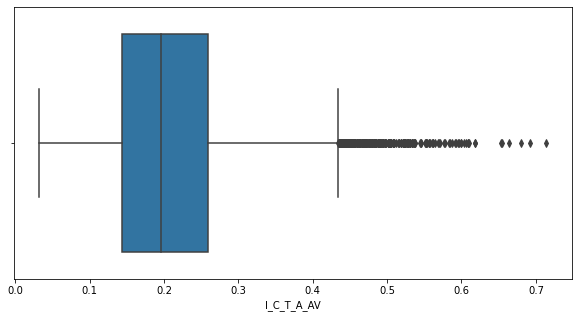

In [396]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=train)
pass

#### II

In [397]:
chanel = 'II'

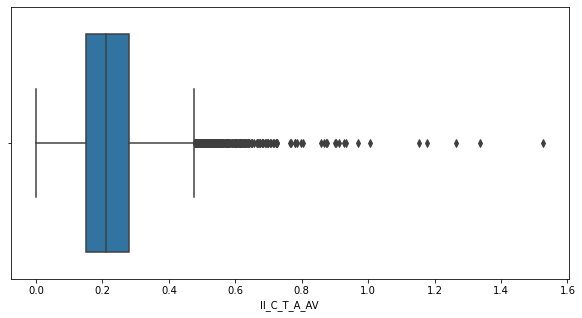

In [398]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=raw_data)
pass

In [399]:
raw_data[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.043000
0.010    0.052889
0.050    0.083818
0.100    0.105182
0.500    0.210917
0.900    0.354000
0.950    0.406700
0.990    0.534547
0.995    0.599149
1.000    1.527300
Name: II_C_T_A_AV, dtype: float64

In [400]:
rows_to_delete = train[
    (train[chanel + '_C_T_A_AV'] > 0.75)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.045000
0.010    0.053692
0.050    0.083925
0.100    0.105261
0.500    0.210286
0.900    0.351488
0.950    0.401652
0.990    0.514845
0.995    0.559405
1.000    0.726182
Name: II_C_T_A_AV, dtype: float64

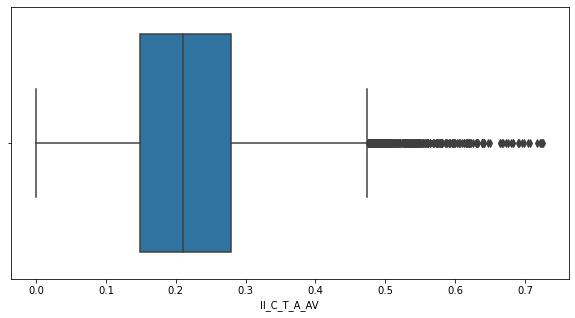

In [401]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=train)
pass

#### III

In [402]:
chanel = 'III'

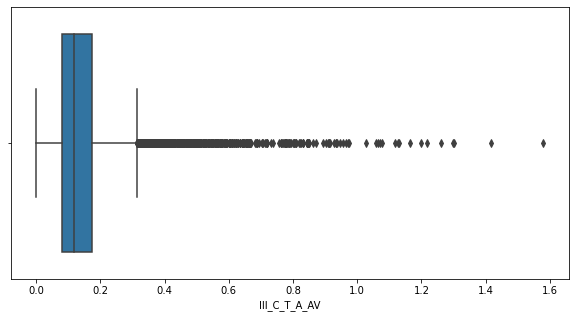

In [403]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=raw_data)
pass

In [404]:
raw_data[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.027380
0.010    0.032291
0.050    0.047909
0.100    0.058750
0.500    0.119500
0.900    0.256818
0.950    0.325667
0.990    0.562020
0.995    0.685153
1.000    1.579500
Name: III_C_T_A_AV, dtype: float64

In [405]:
rows_to_delete = train[
    (train[chanel + '_C_T_A_AV'] > 1)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.028918
0.010    0.032778
0.050    0.048056
0.100    0.058778
0.500    0.118917
0.900    0.250222
0.950    0.316582
0.990    0.514551
0.995    0.600152
1.000    0.975800
Name: III_C_T_A_AV, dtype: float64

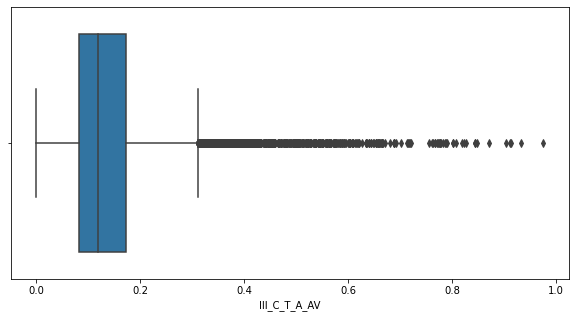

In [406]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=train)
pass

#### AVR

In [407]:
chanel = 'AVR'

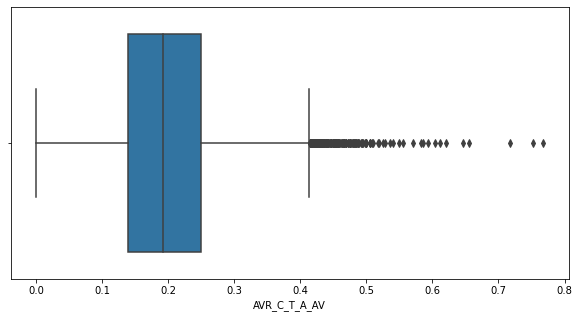

In [408]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=raw_data)
pass

In [409]:
raw_data[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.044511
0.010    0.053345
0.050    0.078300
0.100    0.097900
0.500    0.191667
0.900    0.306636
0.950    0.346750
0.990    0.422420
0.995    0.451550
1.000    0.767889
Name: AVR_C_T_A_AV, dtype: float64

In [410]:
rows_to_delete = train[
    (train[chanel + '_C_T_A_AV'] > 0.7)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.045449
0.010    0.053627
0.050    0.078371
0.100    0.098000
0.500    0.191333
0.900    0.305228
0.950    0.345132
0.990    0.419487
0.995    0.445002
1.000    0.611000
Name: AVR_C_T_A_AV, dtype: float64

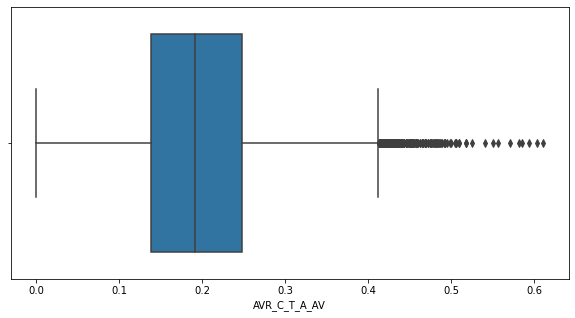

In [411]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=train)
pass

#### AVL

In [412]:
chanel = 'AVL'

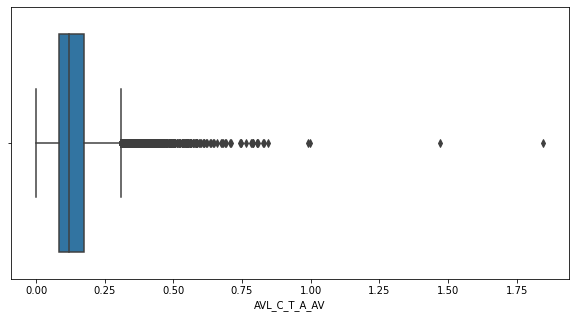

In [413]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=raw_data)
pass

In [414]:
raw_data[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.032588
0.010    0.036856
0.050    0.052400
0.100    0.062000
0.500    0.120778
0.900    0.240500
0.950    0.293556
0.990    0.432333
0.995    0.503562
1.000    1.847364
Name: AVL_C_T_A_AV, dtype: float64

In [415]:
rows_to_delete = train[
    (train[chanel + '_C_T_A_AV'] > 0.7)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.034111
0.010    0.037562
0.050    0.052500
0.100    0.062000
0.500    0.120211
0.900    0.235944
0.950    0.286500
0.990    0.408095
0.995    0.465143
1.000    0.672778
Name: AVL_C_T_A_AV, dtype: float64

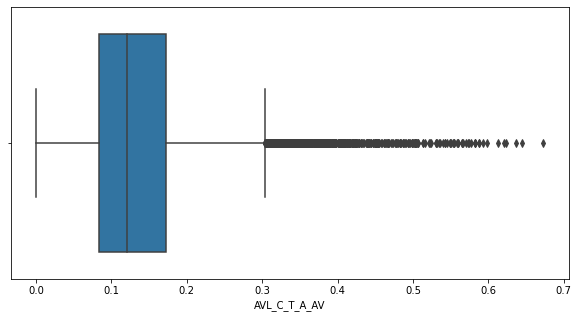

In [416]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=train)
pass

#### AVF

In [417]:
chanel = 'AVF'

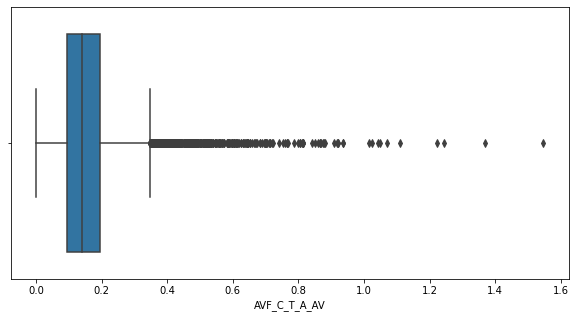

In [418]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=raw_data)
pass

In [419]:
raw_data[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.030597
0.010    0.036330
0.050    0.054167
0.100    0.067250
0.500    0.139000
0.900    0.264667
0.950    0.317750
0.990    0.490375
0.995    0.596644
1.000    1.546900
Name: AVF_C_T_A_AV, dtype: float64

In [420]:
rows_to_delete = train[
    (train[chanel + '_C_T_A_AV'] > 0.8)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.031224
0.010    0.036780
0.050    0.054167
0.100    0.067222
0.500    0.138222
0.900    0.260797
0.950    0.310040
0.990    0.445824
0.995    0.514511
1.000    0.764778
Name: AVF_C_T_A_AV, dtype: float64

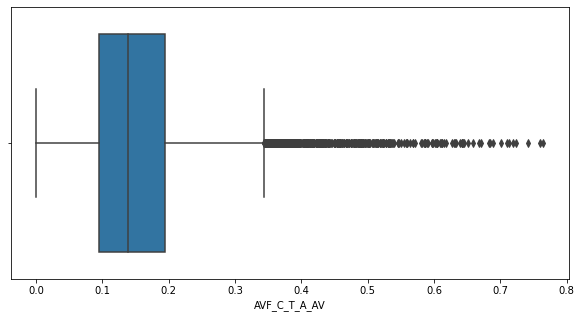

In [421]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=train)
pass

#### V1

In [422]:
chanel = 'V1'

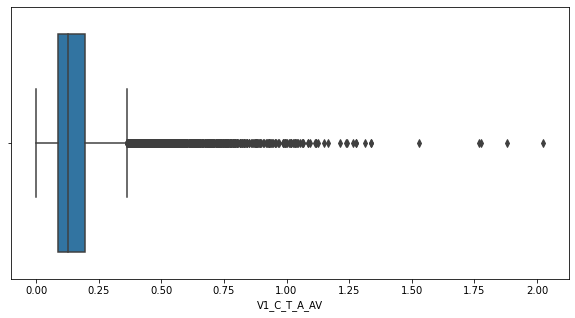

In [423]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=raw_data)
pass

In [424]:
raw_data[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.027307
0.010    0.031945
0.050    0.047111
0.100    0.059250
0.500    0.129333
0.900    0.306778
0.950    0.407200
0.990    0.709710
0.995    0.833325
1.000    2.025357
Name: V1_C_T_A_AV, dtype: float64

In [425]:
rows_to_delete = train[
    (train[chanel + '_C_T_A_AV'] > 1.5)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.015462
0.005    0.027388
0.010    0.032022
0.050    0.047090
0.100    0.059118
0.500    0.128750
0.900    0.305099
0.950    0.402566
0.990    0.701619
0.995    0.812421
1.000    1.336700
Name: V1_C_T_A_AV, dtype: float64

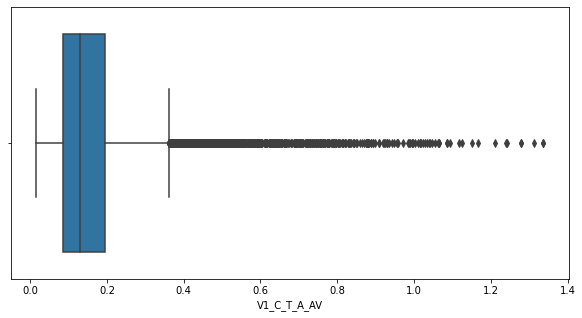

In [426]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=train)
pass

#### V2

In [427]:
chanel = 'V2'

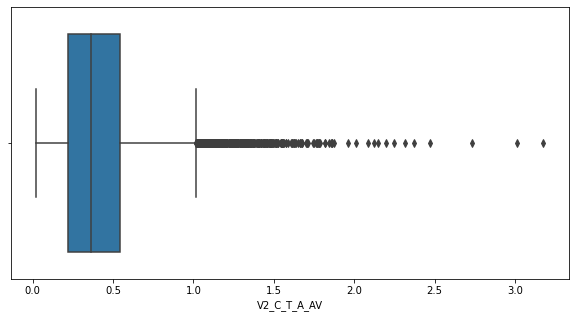

In [428]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=raw_data)
pass

In [429]:
raw_data[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.021571
0.005    0.045420
0.010    0.054209
0.050    0.094273
0.100    0.130235
0.500    0.360222
0.900    0.746571
0.950    0.889333
0.990    1.290725
0.995    1.458020
1.000    3.175385
Name: V2_C_T_A_AV, dtype: float64

In [430]:
rows_to_delete = train[
    (train[chanel + '_C_T_A_AV'] > 1.95)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.021571
0.005    0.045335
0.010    0.054113
0.050    0.093771
0.100    0.129675
0.500    0.359158
0.900    0.744016
0.950    0.883148
0.990    1.261593
0.995    1.406978
1.000    1.873545
Name: V2_C_T_A_AV, dtype: float64

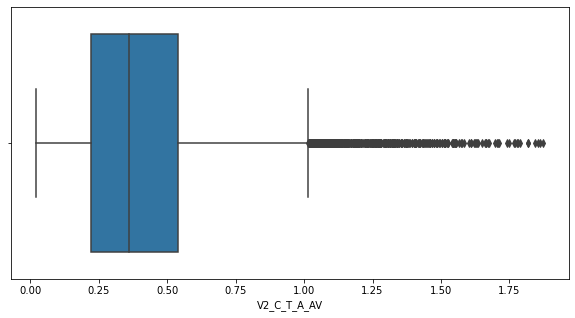

In [431]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=train)
pass

#### V3

In [432]:
chanel = 'V3'

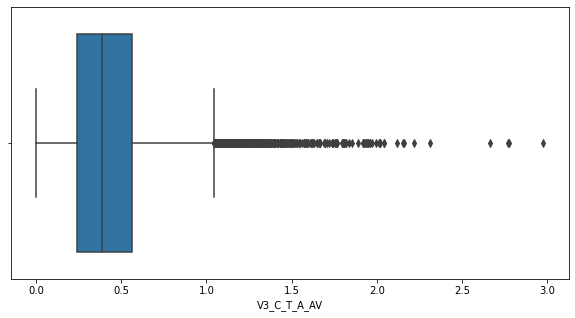

In [433]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=raw_data)
pass

In [434]:
raw_data[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.050320
0.010    0.060907
0.050    0.109364
0.100    0.149625
0.500    0.385111
0.900    0.766250
0.950    0.921875
0.990    1.318196
0.995    1.485820
1.000    2.977000
Name: V3_C_T_A_AV, dtype: float64

In [435]:
rows_to_delete = train[
    (train[chanel + '_C_T_A_AV'] > 2.5)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.018300
0.005    0.050267
0.010    0.060751
0.050    0.109203
0.100    0.148844
0.500    0.383500
0.900    0.759951
0.950    0.914324
0.990    1.277517
0.995    1.416743
1.000    2.039667
Name: V3_C_T_A_AV, dtype: float64

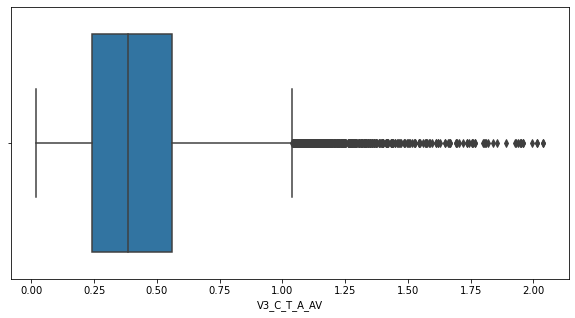

In [436]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=train)
pass

#### V4

In [437]:
chanel = 'V4'

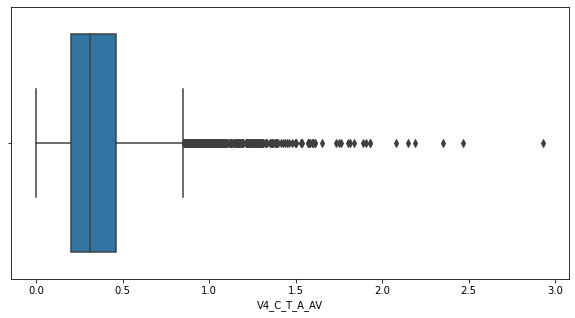

In [438]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=raw_data)
pass

In [439]:
raw_data[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.051183
0.010    0.060332
0.050    0.097100
0.100    0.128583
0.500    0.314571
0.900    0.636333
0.950    0.760429
0.990    1.062100
0.995    1.239664
1.000    2.932100
Name: V4_C_T_A_AV, dtype: float64

In [440]:
rows_to_delete = train[
    (train[chanel + '_C_T_A_AV'] > 2)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.023417
0.005    0.051167
0.010    0.060112
0.050    0.097000
0.100    0.128279
0.500    0.313211
0.900    0.630982
0.950    0.749994
0.990    1.020661
0.995    1.158588
1.000    1.930200
Name: V4_C_T_A_AV, dtype: float64

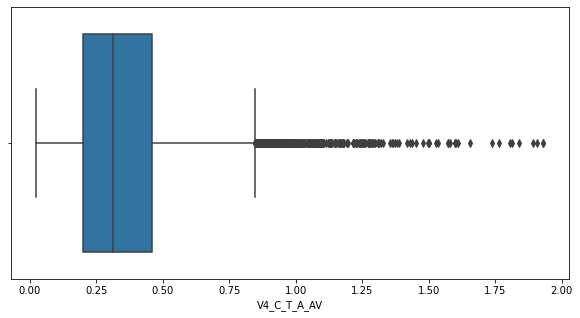

In [441]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=train)
pass

#### V5

In [442]:
chanel = 'V5'

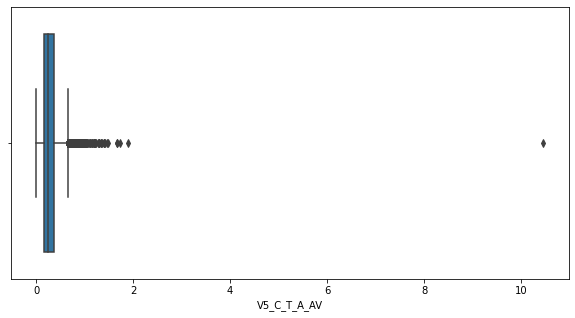

In [443]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=raw_data)
pass

In [444]:
raw_data[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     0.000000
0.005     0.042154
0.010     0.049111
0.050     0.082083
0.100     0.107889
0.500     0.251778
0.900     0.482200
0.950     0.567375
0.990     0.786818
0.995     0.903729
1.000    10.454364
Name: V5_C_T_A_AV, dtype: float64

In [445]:
rows_to_delete = train[
    (train[chanel + '_C_T_A_AV'] > 1.5)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.042200
0.010    0.049167
0.050    0.081778
0.100    0.107222
0.500    0.251182
0.900    0.479300
0.950    0.562000
0.990    0.775111
0.995    0.871500
1.000    1.478000
Name: V5_C_T_A_AV, dtype: float64

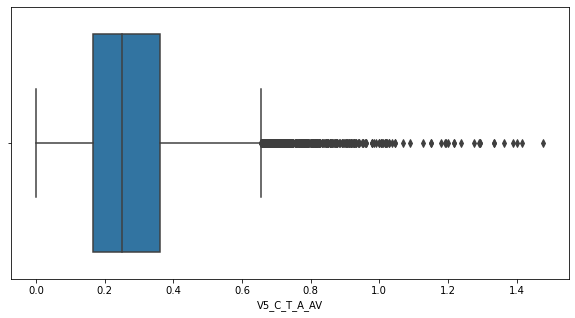

In [446]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=train)
pass

#### V6

In [447]:
chanel = 'V6'

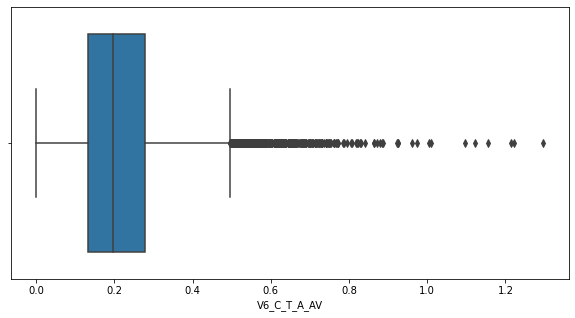

In [448]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=raw_data)
pass

In [449]:
raw_data[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.037307
0.010    0.041893
0.050    0.068091
0.100    0.088400
0.500    0.196300
0.900    0.369250
0.950    0.432800
0.990    0.612527
0.995    0.679038
1.000    1.296727
Name: V6_C_T_A_AV, dtype: float64

In [450]:
rows_to_delete = train[
    (train[chanel + '_C_T_A_AV'] > 1.1)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_T_A_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    0.000000
0.005    0.037333
0.010    0.041900
0.050    0.067887
0.100    0.088089
0.500    0.195764
0.900    0.366442
0.950    0.427500
0.990    0.589668
0.995    0.657583
1.000    1.010222
Name: V6_C_T_A_AV, dtype: float64

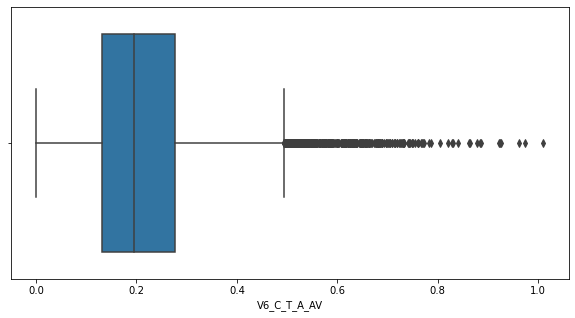

In [451]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_T_A_AV", data=train)
pass

Сравним длину до и после удалений

In [452]:
len(raw_data)

17441

In [453]:
len(train)

17198

### PR-интервал

Рассмотрим длину PR-интервала

#### ALL

In [454]:
chanel = 'ALL'

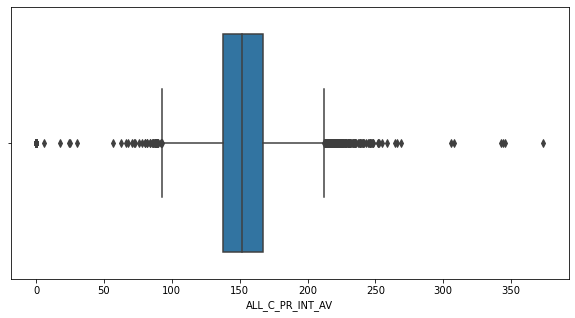

In [455]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_INT_AV', data=raw_data)
pass

In [456]:
raw_data[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    117.460255
0.100    125.388013
0.500    151.766596
0.900    183.508492
0.950    193.547664
0.990    214.804120
0.995    223.593136
1.000    373.753147
Name: ALL_C_PR_INT_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [457]:
rows_to_delete = train[
    (train[chanel + '_C_PR_INT_AV'] > 300)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    117.882607
0.100    125.687843
0.500    151.805907
0.900    183.384642
0.950    193.448542
0.990    214.277495
0.995    222.517943
1.000    269.000000
Name: ALL_C_PR_INT_AV, dtype: float64

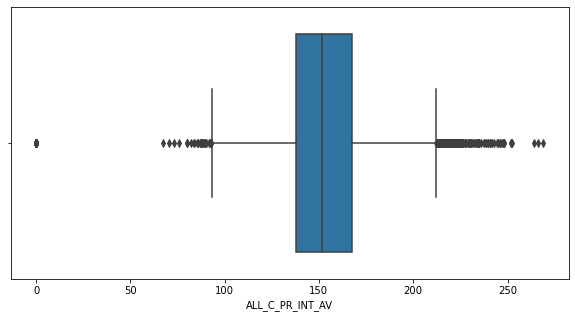

In [458]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_INT_AV", data=train)
pass

То же самое по всем каналам

#### I

In [459]:
chanel = 'I'

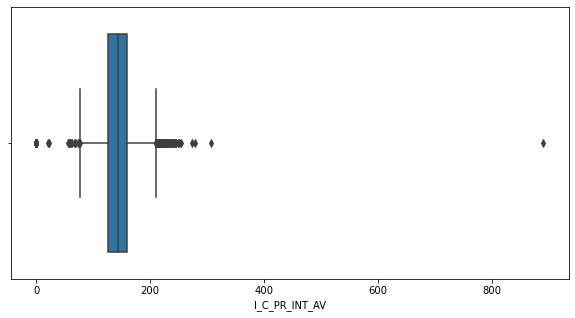

In [460]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_INT_AV', data=raw_data)
pass

In [461]:
raw_data[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050      0.000000
0.100    108.400000
0.500    143.333333
0.900    176.666667
0.950    188.000000
0.990    210.457143
0.995    219.714286
1.000    891.000000
Name: I_C_PR_INT_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [462]:
rows_to_delete = train[
    (train[chanel + '_C_PR_INT_AV'] > 270)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050      0.000000
0.100    110.000000
0.500    143.555556
0.900    176.666667
0.950    188.000000
0.990    210.000000
0.995    219.336333
1.000    254.000000
Name: I_C_PR_INT_AV, dtype: float64

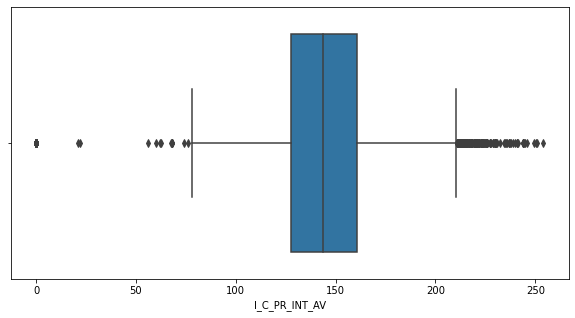

In [463]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_INT_AV", data=train)
pass

#### II

In [464]:
chanel = 'II'

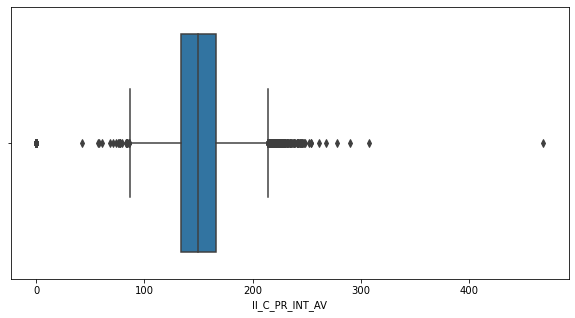

In [465]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_INT_AV', data=raw_data)
pass

In [466]:
raw_data[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    106.000000
0.100    120.000000
0.500    149.666667
0.900    182.400000
0.950    193.428571
0.990    214.955556
0.995    224.135185
1.000    468.666667
Name: II_C_PR_INT_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [467]:
rows_to_delete = train[
    (train[chanel + '_C_PR_INT_AV'] > 400)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    109.206878
0.100    120.819697
0.500    149.859259
0.900    182.400000
0.950    193.373321
0.990    214.585455
0.995    224.003750
1.000    290.000000
Name: II_C_PR_INT_AV, dtype: float64

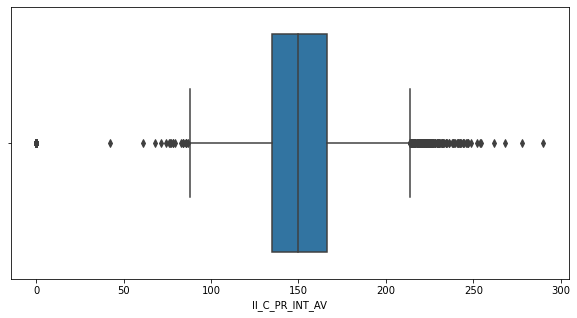

In [468]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_INT_AV", data=train)
pass

#### III

In [469]:
chanel = 'III'

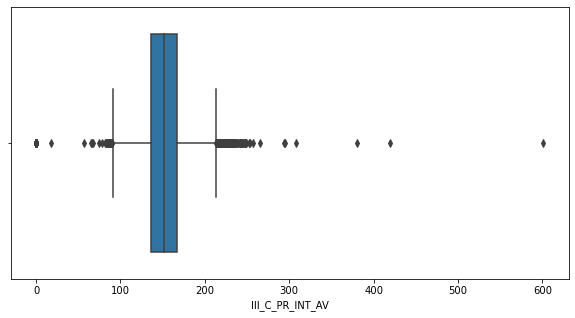

In [470]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_INT_AV', data=raw_data)
pass

In [471]:
raw_data[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    112.821429
0.100    123.333333
0.500    151.166667
0.900    183.438596
0.950    193.854545
0.990    214.938899
0.995    223.431746
1.000    601.000000
Name: III_C_PR_INT_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [472]:
rows_to_delete = train[
    (train[chanel + '_C_PR_INT_AV'] > 350)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    114.450428
0.100    123.921220
0.500    151.323055
0.900    183.355404
0.950    193.644231
0.990    214.542818
0.995    222.716611
1.000    265.500000
Name: III_C_PR_INT_AV, dtype: float64

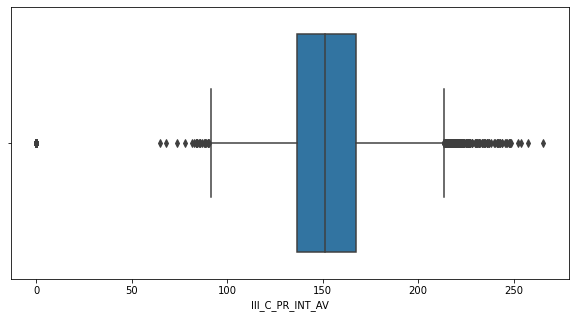

In [473]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_INT_AV", data=train)
pass

#### AVR

In [474]:
chanel = 'AVR'

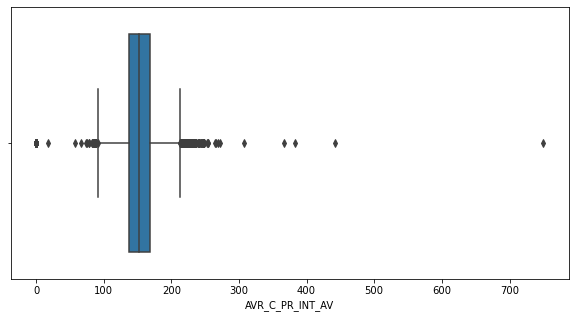

In [475]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_INT_AV', data=raw_data)
pass

In [476]:
raw_data[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    115.584906
0.100    124.482143
0.500    151.773050
0.900    183.818182
0.950    194.027211
0.990    214.822985
0.995    223.854603
1.000    750.000000
Name: AVR_C_PR_INT_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [477]:
rows_to_delete = train[
    (train[chanel + '_C_PR_INT_AV'] > 300)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    116.372581
0.100    124.852358
0.500    151.842808
0.900    183.673333
0.950    193.969967
0.990    214.400789
0.995    222.547870
1.000    269.000000
Name: AVR_C_PR_INT_AV, dtype: float64

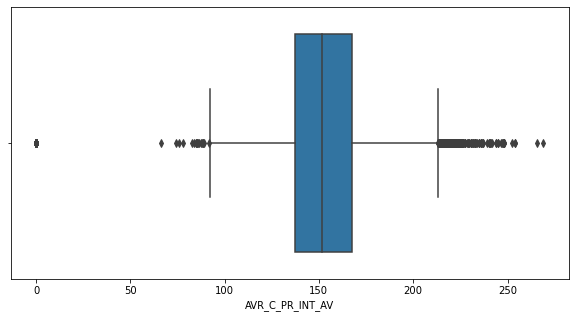

In [478]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_INT_AV", data=train)
pass

#### AVL

In [479]:
chanel = 'AVL'

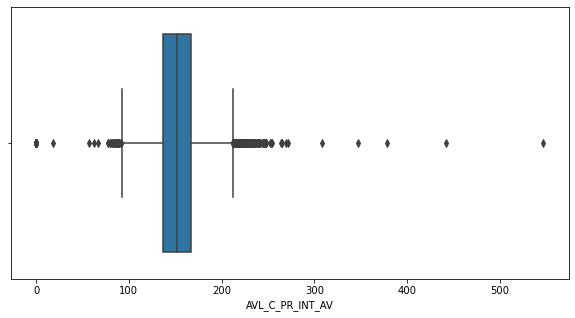

In [480]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_INT_AV', data=raw_data)
pass

In [481]:
raw_data[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    116.008772
0.100    124.668831
0.500    151.471698
0.900    183.294118
0.950    193.490323
0.990    214.456863
0.995    223.530256
1.000    546.666667
Name: AVL_C_PR_INT_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [482]:
rows_to_delete = train[
    (train[chanel + '_C_PR_INT_AV'] > 300)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    116.847013
0.100    125.089699
0.500    151.525904
0.900    183.163579
0.950    193.351449
0.990    214.076988
0.995    222.405932
1.000    269.000000
Name: AVL_C_PR_INT_AV, dtype: float64

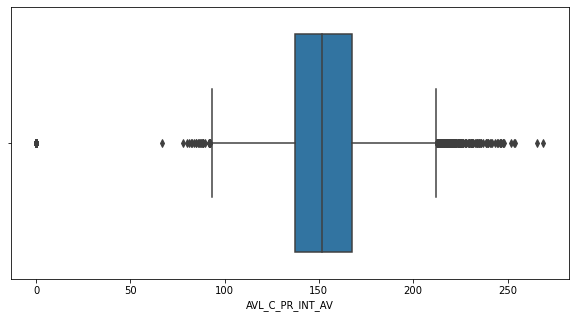

In [483]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_INT_AV", data=train)
pass

#### AVF

In [484]:
chanel = 'AVF'

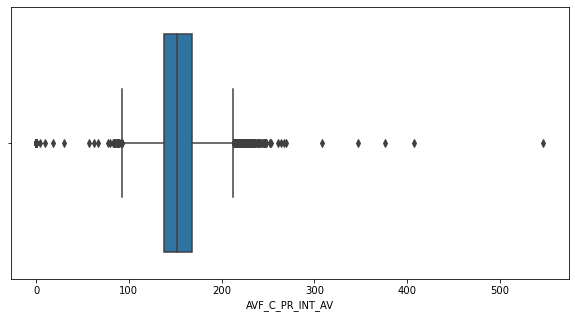

In [485]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_INT_AV', data=raw_data)
pass

In [486]:
raw_data[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    116.400862
0.100    124.995851
0.500    151.673469
0.900    183.483254
0.950    193.795276
0.990    214.784659
0.995    223.529540
1.000    546.666667
Name: AVF_C_PR_INT_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [487]:
rows_to_delete = train[
    (train[chanel + '_C_PR_INT_AV'] > 300)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    117.159324
0.100    125.295988
0.500    151.735275
0.900    183.334934
0.950    193.521226
0.990    214.184200
0.995    222.610780
1.000    269.000000
Name: AVF_C_PR_INT_AV, dtype: float64

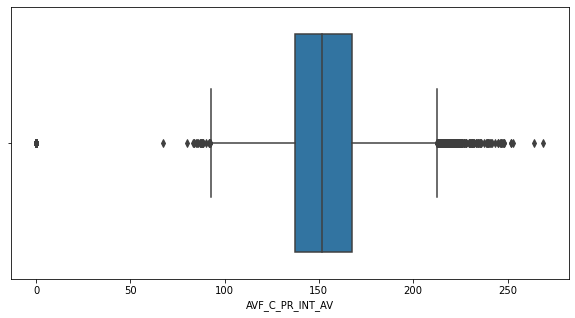

In [488]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_INT_AV", data=train)
pass

#### V1

In [489]:
chanel = 'V1'

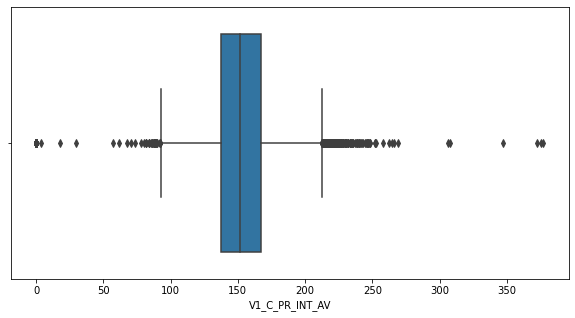

In [490]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_INT_AV', data=raw_data)
pass

In [491]:
raw_data[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    117.086444
0.100    125.200000
0.500    151.700000
0.900    183.476636
0.950    193.594625
0.990    214.853000
0.995    223.600346
1.000    377.100000
Name: V1_C_PR_INT_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [492]:
rows_to_delete = train[
    (train[chanel + '_C_PR_INT_AV'] > 300)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    117.610013
0.100    125.536212
0.500    151.748188
0.900    183.373276
0.950    193.463886
0.990    214.316732
0.995    222.609333
1.000    269.000000
Name: V1_C_PR_INT_AV, dtype: float64

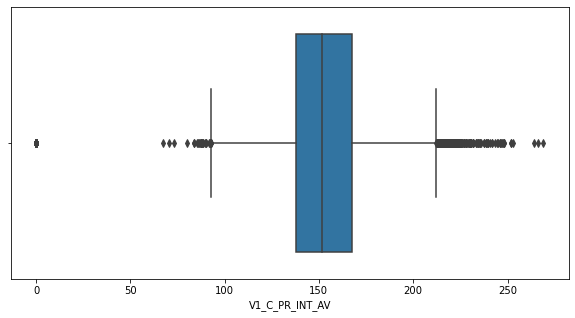

In [493]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_INT_AV", data=train)
pass

#### V2

In [494]:
chanel = 'V2'

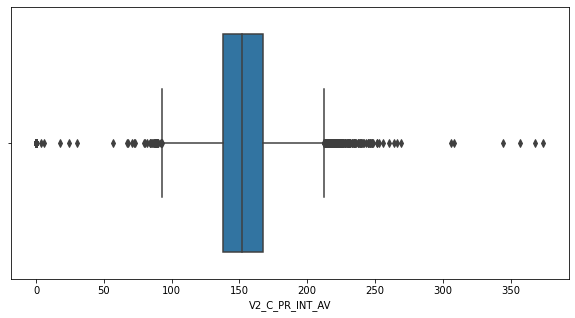

In [495]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_INT_AV', data=raw_data)
pass

In [496]:
raw_data[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    117.181229
0.100    125.308642
0.500    151.714636
0.900    183.489051
0.950    193.557849
0.990    214.808209
0.995    223.530040
1.000    374.123001
Name: V2_C_PR_INT_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [497]:
rows_to_delete = train[
    (train[chanel + '_C_PR_INT_AV'] > 300)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    117.714404
0.100    125.600253
0.500    151.774665
0.900    183.373879
0.950    193.428458
0.990    214.215169
0.995    222.532736
1.000    269.000000
Name: V2_C_PR_INT_AV, dtype: float64

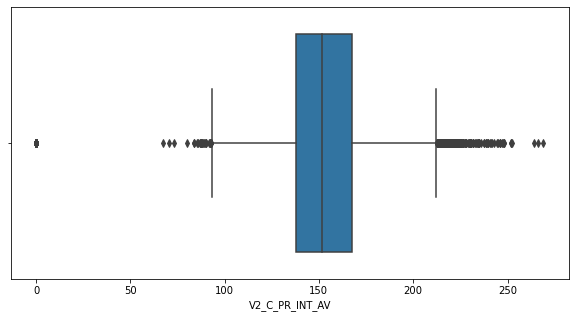

In [498]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_INT_AV", data=train)
pass

#### V3

In [499]:
chanel = 'V3'

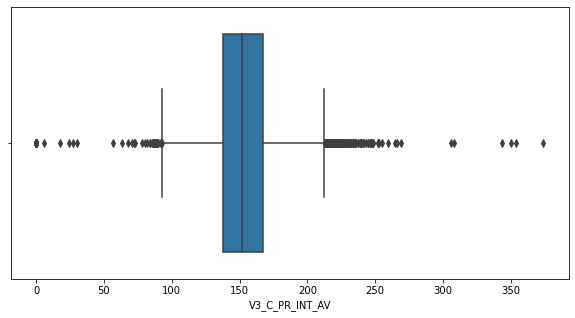

In [500]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_INT_AV', data=raw_data)
pass

In [501]:
raw_data[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    117.292180
0.100    125.354610
0.500    151.762778
0.900    183.499018
0.950    193.546060
0.990    214.815714
0.995    223.562684
1.000    373.839066
Name: V3_C_PR_INT_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [502]:
rows_to_delete = train[
    (train[chanel + '_C_PR_INT_AV'] > 300)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    117.786686
0.100    125.665808
0.500    151.798947
0.900    183.368811
0.950    193.433385
0.990    214.254357
0.995    222.529975
1.000    269.000000
Name: V3_C_PR_INT_AV, dtype: float64

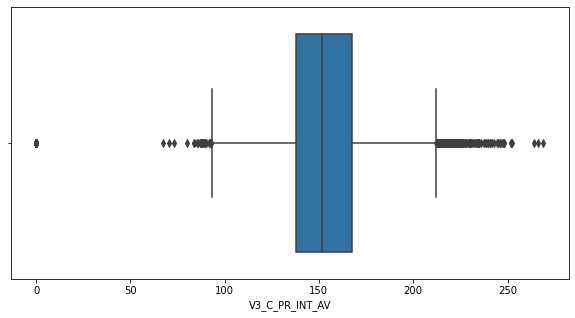

In [503]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_INT_AV", data=train)
pass

#### V4

In [504]:
chanel = 'V4'

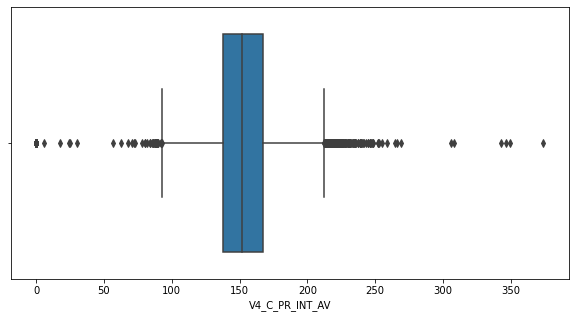

In [505]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_INT_AV', data=raw_data)
pass

In [506]:
raw_data[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    117.291359
0.100    125.364101
0.500    151.764200
0.900    183.514068
0.950    193.546255
0.990    214.799369
0.995    223.581189
1.000    373.839066
Name: V4_C_PR_INT_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [507]:
rows_to_delete = train[
    (train[chanel + '_C_PR_INT_AV'] > 300)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    117.795385
0.100    125.672486
0.500    151.801666
0.900    183.372008
0.950    193.440726
0.990    214.268434
0.995    222.528944
1.000    269.000000
Name: V4_C_PR_INT_AV, dtype: float64

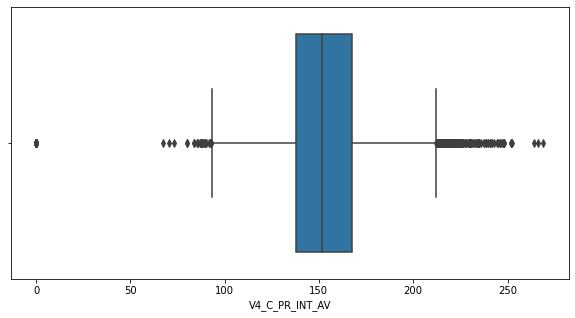

In [508]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_INT_AV", data=train)
pass

#### V5

In [509]:
chanel = 'V5'

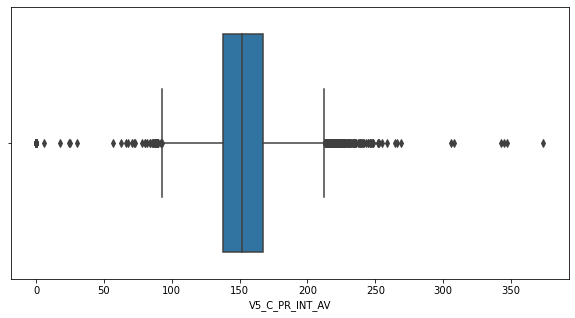

In [510]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_INT_AV', data=raw_data)
pass

In [511]:
raw_data[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    117.342908
0.100    125.369222
0.500    151.766878
0.900    183.509227
0.950    193.546508
0.990    214.803328
0.995    223.592290
1.000    373.794872
Name: V5_C_PR_INT_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [512]:
rows_to_delete = train[
    (train[chanel + '_C_PR_INT_AV'] > 300)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    117.800476
0.100    125.672971
0.500    151.804434
0.900    183.372348
0.950    193.435924
0.990    214.256130
0.995    222.522158
1.000    269.000000
Name: V5_C_PR_INT_AV, dtype: float64

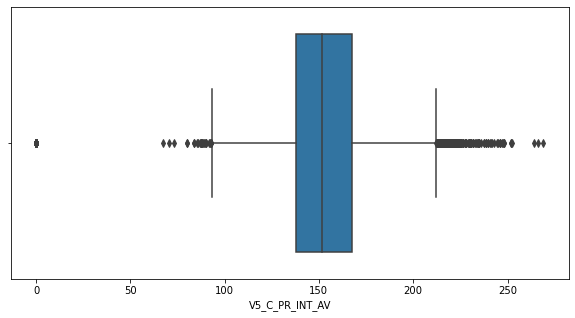

In [513]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_INT_AV", data=train)
pass

#### V6

In [514]:
chanel = 'V6'

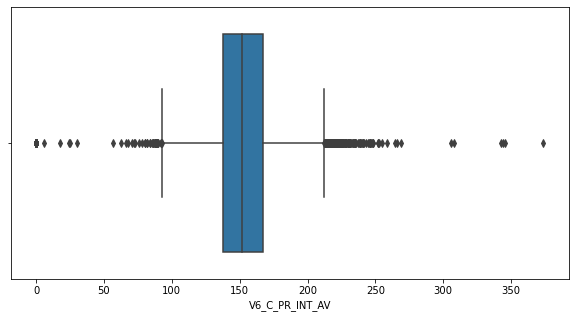

In [515]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_INT_AV', data=raw_data)
pass

In [516]:
raw_data[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    117.460255
0.100    125.388013
0.500    151.766596
0.900    183.508492
0.950    193.547664
0.990    214.804120
0.995    223.593136
1.000    373.753147
Name: V6_C_PR_INT_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [517]:
rows_to_delete = train[
    (train[chanel + '_C_PR_INT_AV'] > 300)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050    117.882246
0.100    125.687316
0.500    151.805573
0.900    183.371268
0.950    193.435598
0.990    214.252828
0.995    222.520656
1.000    269.000000
Name: V6_C_PR_INT_AV, dtype: float64

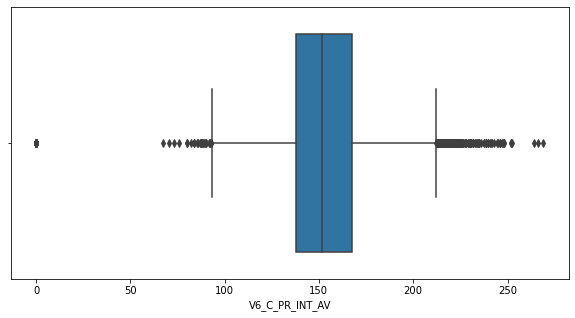

In [518]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_INT_AV", data=train)
pass

Сравним число записей до и после удаления

In [519]:
len(raw_data)

17441

In [520]:
len(train)

17192

### PR-сегмент

Рассмотрим длину PR-сегмента

#### ALL

In [521]:
chanel = 'ALL'

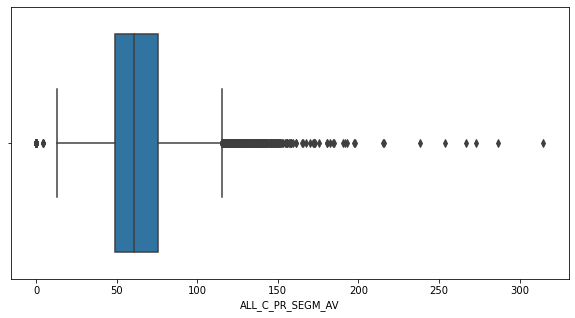

In [522]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_SEGM_AV', data=raw_data)
pass

In [523]:
raw_data[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     36.527510
0.100     40.834592
0.500     60.988174
0.900     91.302852
0.950    103.336413
0.990    130.421212
0.995    142.104885
1.000    314.775560
Name: ALL_C_PR_SEGM_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [524]:
rows_to_delete = train[
    (train[chanel + '_C_PR_SEGM_AV'] > 200)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     36.641152
0.100     40.877334
0.500     60.843293
0.900     90.836904
0.950    102.551881
0.990    128.305227
0.995    139.401390
1.000    197.651246
Name: ALL_C_PR_SEGM_AV, dtype: float64

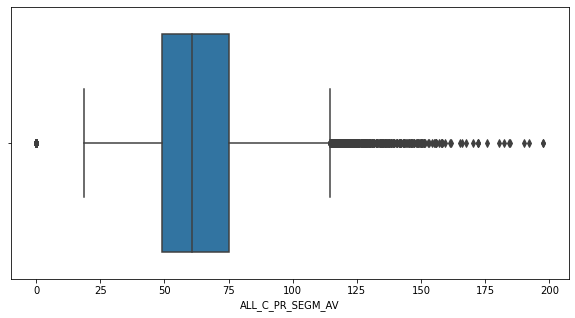

In [525]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_SEGM_AV", data=train)
pass

То же самое по всем каналам

#### I

In [526]:
chanel = 'I'

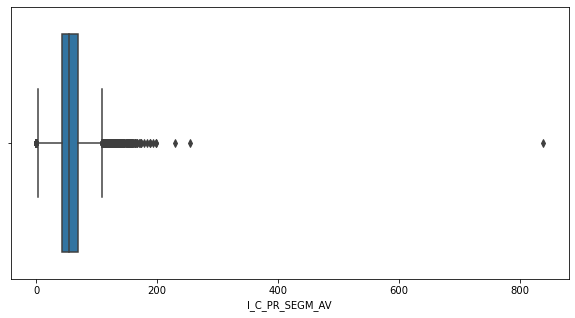

In [527]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_SEGM_AV', data=raw_data)
pass

In [528]:
raw_data[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050      0.000000
0.100     32.888889
0.500     55.200000
0.900     84.666667
0.950     96.666667
0.990    126.000000
0.995    138.000000
1.000    839.000000
Name: I_C_PR_SEGM_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [529]:
rows_to_delete = train[
    (train[chanel + '_C_PR_SEGM_AV'] > 400)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050      0.000000
0.100     33.636364
0.500     55.333333
0.900     84.666667
0.950     96.400000
0.990    124.666667
0.995    136.311250
1.000    198.000000
Name: I_C_PR_SEGM_AV, dtype: float64

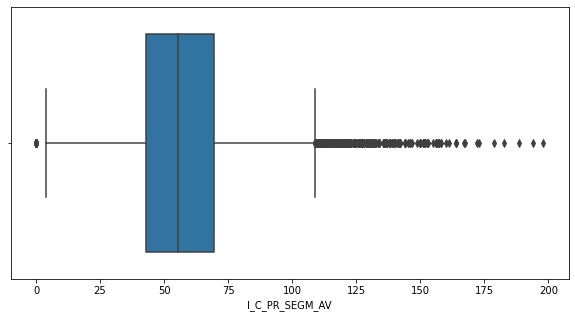

In [530]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_SEGM_AV", data=train)
pass

#### II

In [531]:
chanel = 'II'

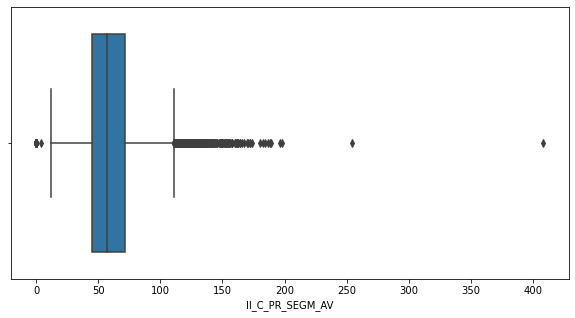

In [532]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_SEGM_AV', data=raw_data)
pass

In [533]:
raw_data[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     29.916667
0.100     36.148148
0.500     57.111111
0.900     87.176471
0.950     99.904762
0.990    127.852273
0.995    138.000000
1.000    408.222222
Name: II_C_PR_SEGM_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [534]:
rows_to_delete = train[
    (train[chanel + '_C_PR_SEGM_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     31.029351
0.100     36.634266
0.500     57.159091
0.900     87.058824
0.950     99.333333
0.990    126.700000
0.995    136.020000
1.000    198.000000
Name: II_C_PR_SEGM_AV, dtype: float64

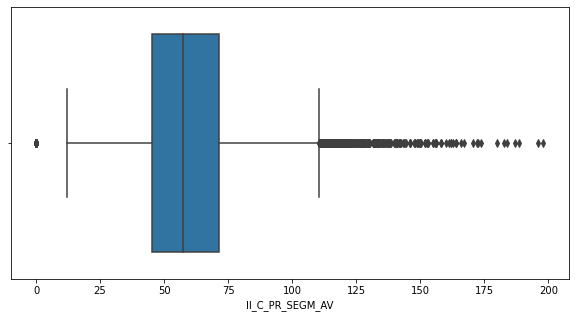

In [535]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_SEGM_AV", data=train)
pass

#### III

In [536]:
chanel = 'III'

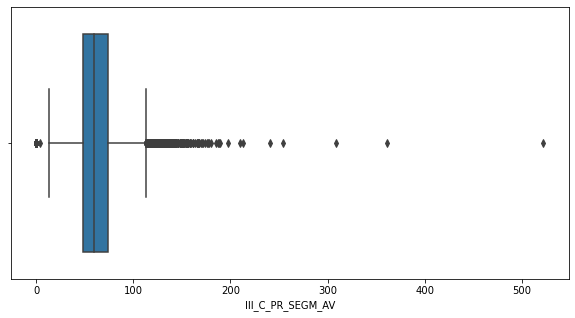

In [537]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_SEGM_AV', data=raw_data)
pass

In [538]:
raw_data[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     34.057143
0.100     39.200000
0.500     59.714286
0.900     89.617021
0.950    101.777778
0.990    129.705495
0.995    141.318519
1.000    522.000000
Name: III_C_PR_SEGM_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [539]:
rows_to_delete = train[
    (train[chanel + '_C_PR_SEGM_AV'] > 200)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     34.543896
0.100     39.428571
0.500     59.685714
0.900     89.400000
0.950    100.932414
0.990    127.916778
0.995    139.008571
1.000    198.000000
Name: III_C_PR_SEGM_AV, dtype: float64

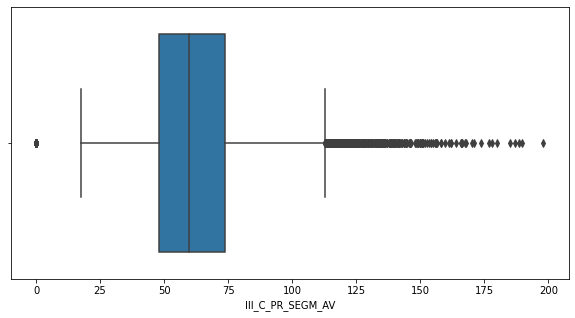

In [540]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_SEGM_AV", data=train)
pass

#### AVR

In [541]:
chanel = 'AVR'

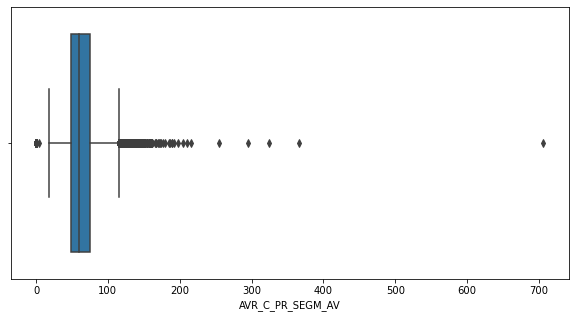

In [542]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_SEGM_AV', data=raw_data)
pass

In [543]:
raw_data[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     35.026667
0.100     39.797297
0.500     60.230303
0.900     90.764706
0.950    102.986486
0.990    131.057143
0.995    141.855556
1.000    706.000000
Name: AVR_C_PR_SEGM_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [544]:
rows_to_delete = train[
    (train[chanel + '_C_PR_SEGM_AV'] > 300)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     35.345413
0.100     39.953778
0.500     60.171429
0.900     90.465660
0.950    102.261266
0.990    128.496741
0.995    139.906500
1.000    198.000000
Name: AVR_C_PR_SEGM_AV, dtype: float64

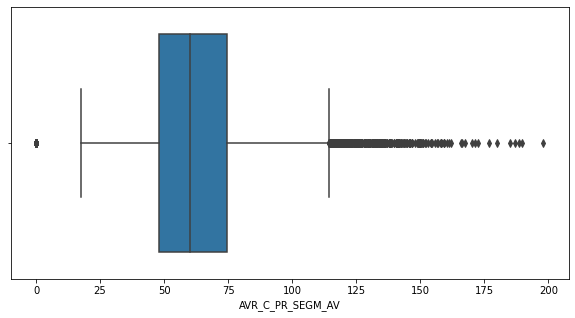

In [545]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_SEGM_AV", data=train)
pass

#### AVL

In [546]:
chanel = 'AVL'

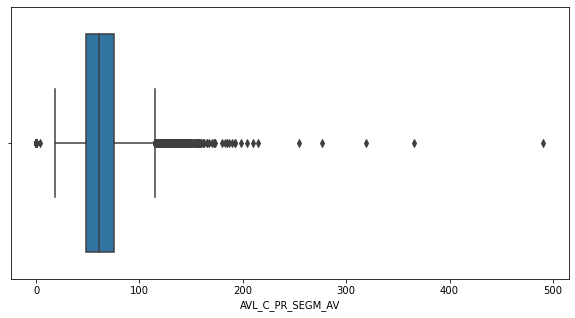

In [547]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_SEGM_AV', data=raw_data)
pass

In [548]:
raw_data[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     35.583333
0.100     40.243421
0.500     60.469880
0.900     90.874419
0.950    103.000000
0.990    130.710695
0.995    141.777222
1.000    490.666667
Name: AVL_C_PR_SEGM_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [549]:
rows_to_delete = train[
    (train[chanel + '_C_PR_SEGM_AV'] > 300)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     35.947390
0.100     40.345658
0.500     60.395939
0.900     90.459386
0.950    102.257367
0.990    128.485469
0.995    140.017944
1.000    198.000000
Name: AVL_C_PR_SEGM_AV, dtype: float64

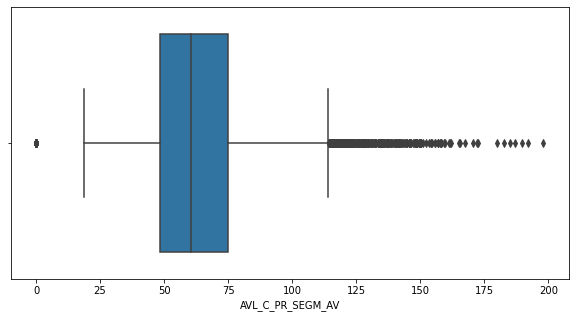

In [550]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_SEGM_AV", data=train)
pass

#### AVF

In [551]:
chanel = 'AVF'

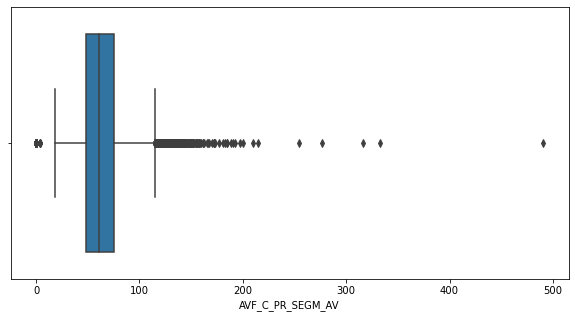

In [552]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_SEGM_AV', data=raw_data)
pass

In [553]:
raw_data[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     35.812500
0.100     40.358149
0.500     60.613430
0.900     91.055046
0.950    103.191686
0.990    130.500000
0.995    142.049246
1.000    490.666667
Name: AVF_C_PR_SEGM_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [554]:
rows_to_delete = train[
    (train[chanel + '_C_PR_SEGM_AV'] > 300)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     36.063071
0.100     40.453974
0.500     60.517321
0.900     90.664848
0.950    102.377975
0.990    128.236584
0.995    139.605194
1.000    197.550000
Name: AVF_C_PR_SEGM_AV, dtype: float64

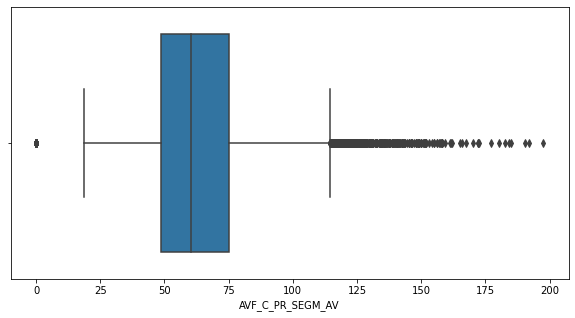

In [555]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_SEGM_AV", data=train)
pass

#### V1

In [556]:
chanel = 'V1'

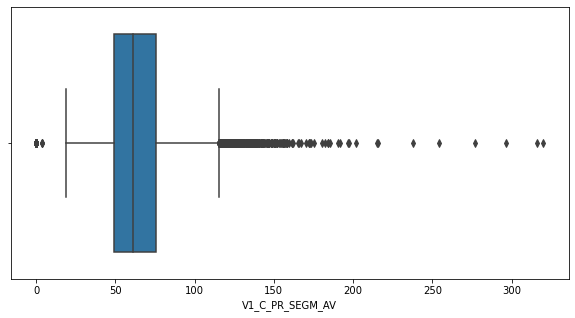

In [557]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_SEGM_AV', data=raw_data)
pass

In [558]:
raw_data[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     36.276102
0.100     40.637807
0.500     60.834646
0.900     91.302144
0.950    103.333333
0.990    130.504972
0.995    142.572308
1.000    320.000000
Name: V1_C_PR_SEGM_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [559]:
rows_to_delete = train[
    (train[chanel + '_C_PR_SEGM_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     36.418488
0.100     40.690108
0.500     60.728000
0.900     90.808292
0.950    102.587178
0.990    128.197061
0.995    139.488284
1.000    197.550000
Name: V1_C_PR_SEGM_AV, dtype: float64

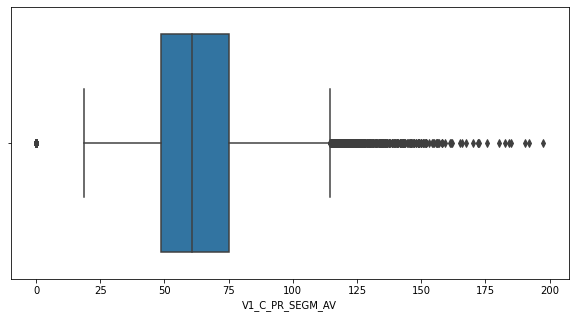

In [560]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_SEGM_AV", data=train)
pass

#### V2

In [561]:
chanel = 'V2'

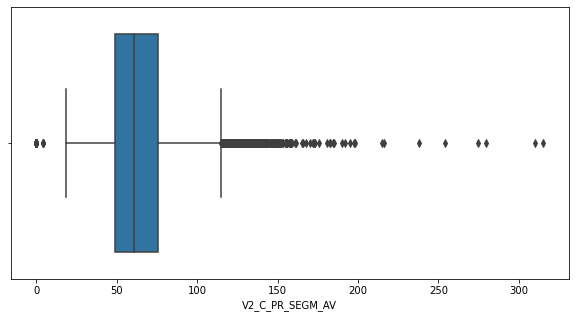

In [562]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_SEGM_AV', data=raw_data)
pass

In [563]:
raw_data[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     36.392991
0.100     40.737215
0.500     60.942911
0.900     91.307494
0.950    103.386364
0.990    130.474679
0.995    142.399534
1.000    315.151292
Name: V2_C_PR_SEGM_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [564]:
rows_to_delete = train[
    (train[chanel + '_C_PR_SEGM_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     36.511442
0.100     40.778273
0.500     60.804855
0.900     90.841310
0.950    102.534402
0.990    128.285585
0.995    139.419885
1.000    197.550000
Name: V2_C_PR_SEGM_AV, dtype: float64

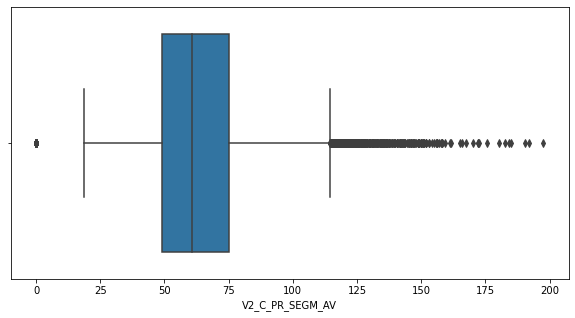

In [565]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_SEGM_AV", data=train)
pass

#### V3

In [566]:
chanel = 'V3'

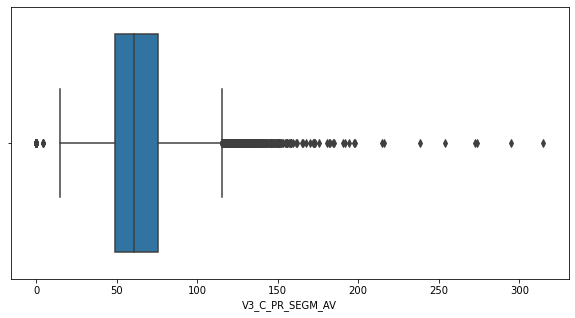

In [567]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_SEGM_AV', data=raw_data)
pass

In [568]:
raw_data[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     36.446251
0.100     40.777625
0.500     60.966233
0.900     91.292764
0.950    103.355881
0.990    130.421212
0.995    142.152596
1.000    314.855037
Name: V3_C_PR_SEGM_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [569]:
rows_to_delete = train[
    (train[chanel + '_C_PR_SEGM_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     36.558811
0.100     40.831718
0.500     60.834588
0.900     90.848378
0.950    102.571867
0.990    128.292827
0.995    139.212391
1.000    197.550000
Name: V3_C_PR_SEGM_AV, dtype: float64

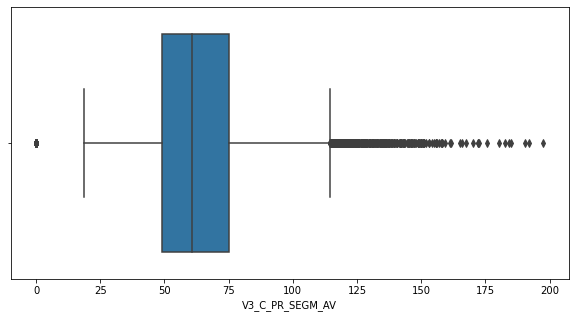

In [570]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_SEGM_AV", data=train)
pass

#### V4

In [571]:
chanel = 'V4'

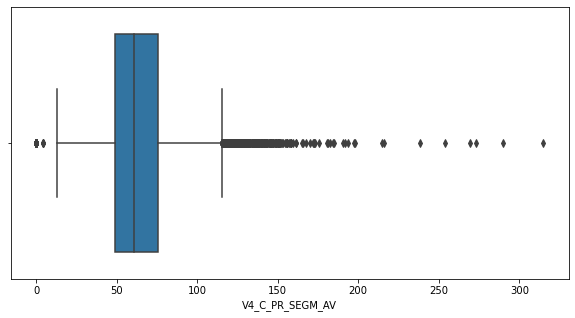

In [572]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_SEGM_AV', data=raw_data)
pass

In [573]:
raw_data[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     36.474444
0.100     40.795198
0.500     60.963309
0.900     91.297819
0.950    103.371421
0.990    130.421212
0.995    142.113192
1.000    314.855037
Name: V4_C_PR_SEGM_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [574]:
rows_to_delete = train[
    (train[chanel + '_C_PR_SEGM_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     36.582709
0.100     40.839258
0.500     60.832479
0.900     90.844845
0.950    102.545827
0.990    128.262656
0.995    139.212079
1.000    197.550000
Name: V4_C_PR_SEGM_AV, dtype: float64

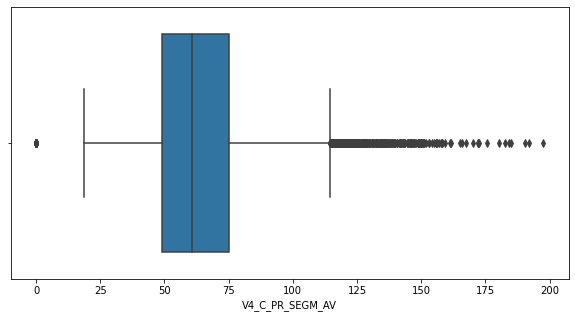

In [575]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_SEGM_AV", data=train)
pass

#### V5

In [576]:
chanel = 'V5'

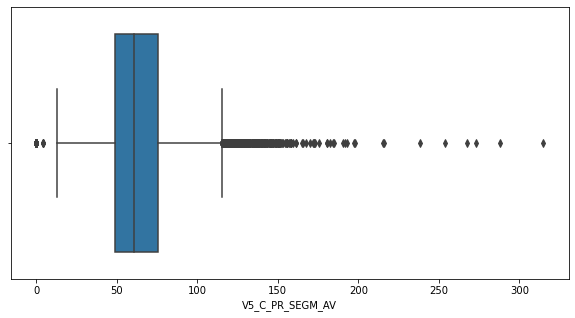

In [577]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_SEGM_AV', data=raw_data)
pass

In [578]:
raw_data[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     36.489163
0.100     40.797267
0.500     60.968744
0.900     91.308797
0.950    103.370359
0.990    130.421212
0.995    142.106747
1.000    314.815292
Name: V5_C_PR_SEGM_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [579]:
rows_to_delete = train[
    (train[chanel + '_C_PR_SEGM_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     36.589052
0.100     40.837872
0.500     60.836346
0.900     90.836949
0.950    102.542289
0.990    128.264160
0.995    139.211785
1.000    197.550000
Name: V5_C_PR_SEGM_AV, dtype: float64

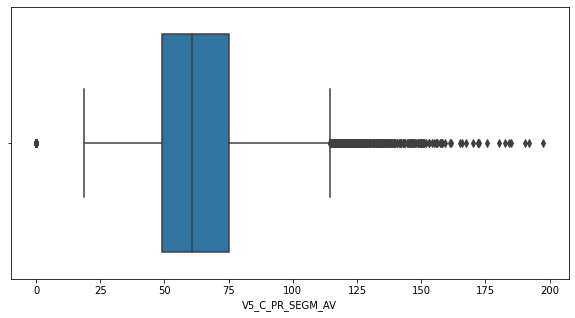

In [580]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_SEGM_AV", data=train)
pass

#### V6

In [581]:
chanel = 'V6'

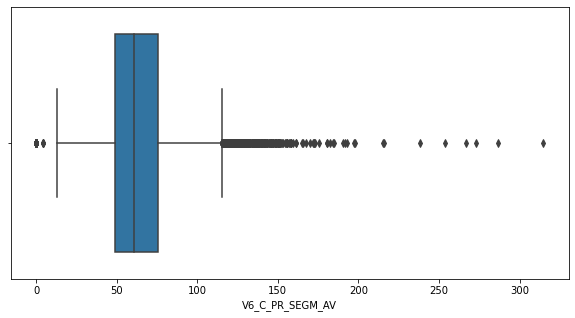

In [582]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_PR_SEGM_AV', data=raw_data)
pass

In [583]:
raw_data[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     36.527510
0.100     40.834592
0.500     60.988174
0.900     91.302852
0.950    103.336413
0.990    130.421212
0.995    142.104885
1.000    314.775560
Name: V6_C_PR_SEGM_AV, dtype: float64

Нулевые значения оставим по той же причине, что и нулевые P-волны

In [584]:
rows_to_delete = train[
    (train[chanel + '_C_PR_SEGM_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_PR_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050     36.640985
0.100     40.877108
0.500     60.841056
0.900     90.826550
0.950    102.538183
0.990    128.263622
0.995    139.211555
1.000    197.550000
Name: V6_C_PR_SEGM_AV, dtype: float64

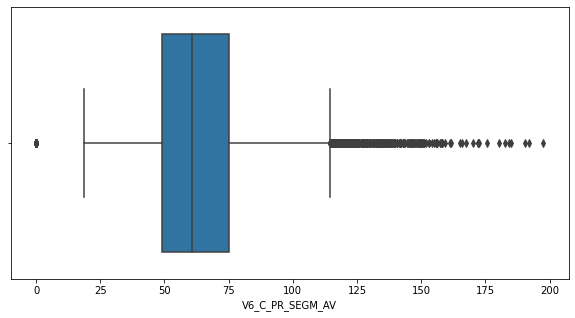

In [585]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_PR_SEGM_AV", data=train)
pass

Сравним количество записей до и после удаления

In [586]:
len(raw_data)

17441

In [587]:
len(train)

17189

### ST-сегмент

Рассмотрим длину ST-сегмента

#### ALL

In [588]:
chanel = 'ALL'

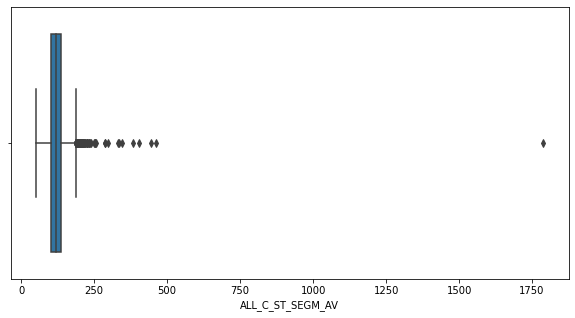

In [589]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_ST_SEGM_AV', data=raw_data)
pass

In [590]:
raw_data[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      50.775558
0.005      66.365615
0.010      69.571525
0.050      80.949093
0.100      88.270174
0.500     118.783572
0.900     153.650654
0.950     164.630342
0.990     188.715167
0.995     198.762261
1.000    1788.470770
Name: ALL_C_ST_SEGM_AV, dtype: float64

In [591]:
rows_to_delete = train[
    (train[chanel + '_C_ST_SEGM_AV'] > 245)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     50.775558
0.005     66.604311
0.010     69.723902
0.050     81.096767
0.100     88.362136
0.500    118.691392
0.900    153.524898
0.950    164.268902
0.990    187.179116
0.995    196.898816
1.000    239.189243
Name: ALL_C_ST_SEGM_AV, dtype: float64

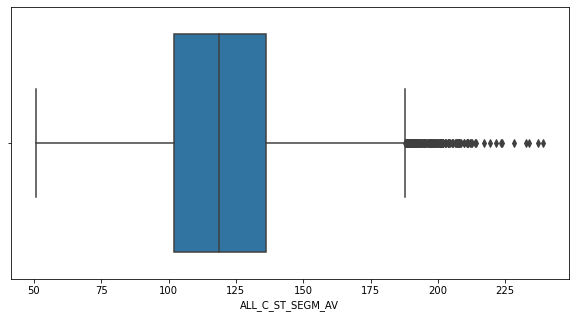

In [592]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_ST_SEGM_AV", data=train)
pass

То же самое по всем каналам

#### I

In [593]:
chanel = 'I'

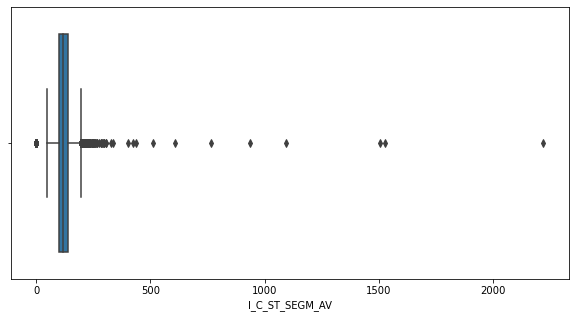

In [594]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_ST_SEGM_AV', data=raw_data)
pass

In [595]:
raw_data[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000       0.000000
0.005      58.592481
0.010      63.220000
0.050      75.800000
0.100      84.307692
0.500     118.000000
0.900     157.777778
0.950     171.555556
0.990     201.766667
0.995     212.835714
1.000    2218.000000
Name: I_C_ST_SEGM_AV, dtype: float64

In [596]:
rows_to_delete = train[
    (train[chanel + '_C_ST_SEGM_AV'] > 275)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     47.384615
0.005     60.820471
0.010     64.461538
0.050     76.166667
0.100     84.600000
0.500    117.833333
0.900    157.309091
0.950    170.666667
0.990    198.285714
0.995    207.751429
1.000    267.777778
Name: I_C_ST_SEGM_AV, dtype: float64

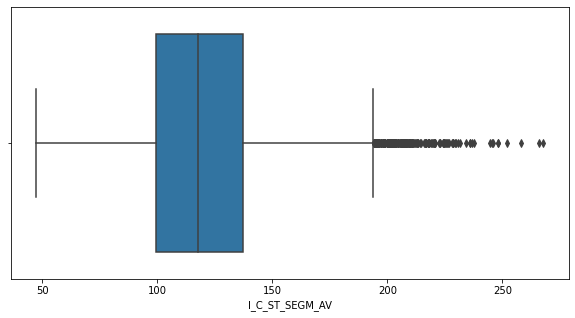

In [597]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_ST_SEGM_AV", data=train)
pass

#### II

In [598]:
chanel = 'II'

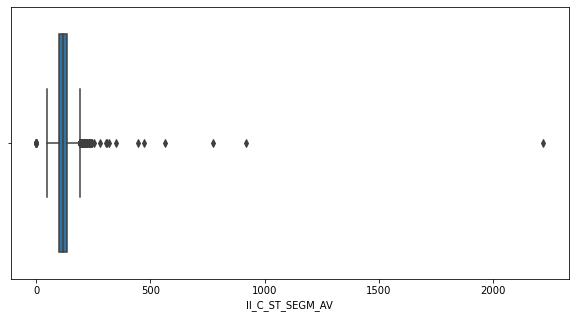

In [599]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_ST_SEGM_AV', data=raw_data)
pass

In [600]:
raw_data[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000       0.000000
0.005      62.666667
0.010      65.922424
0.050      77.619048
0.100      85.230769
0.500     116.962963
0.900     154.000000
0.950     166.466667
0.990     192.314286
0.995     203.533333
1.000    2218.000000
Name: II_C_ST_SEGM_AV, dtype: float64

In [601]:
rows_to_delete = train[
    (train[chanel + '_C_ST_SEGM_AV'] > 500)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     48.051282
0.005     63.036250
0.010     66.190476
0.050     77.793333
0.100     85.393939
0.500    116.857143
0.900    153.750000
0.950    165.919444
0.990    190.019259
0.995    199.634444
1.000    242.777778
Name: II_C_ST_SEGM_AV, dtype: float64

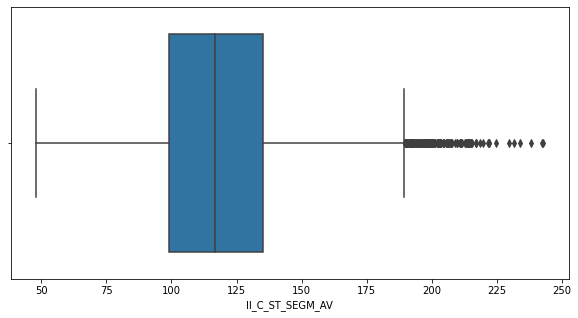

In [602]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_ST_SEGM_AV", data=train)
pass

#### III

In [603]:
chanel = 'III'

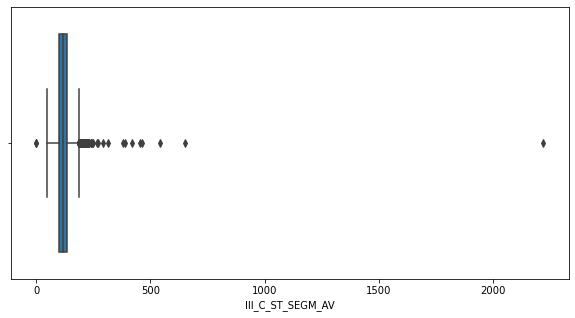

In [604]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_ST_SEGM_AV', data=raw_data)
pass

In [605]:
raw_data[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000       0.000000
0.005      65.343341
0.010      68.674758
0.050      80.028571
0.100      87.489362
0.500     118.326531
0.900     153.632653
0.950     164.964286
0.990     189.988060
0.995     200.423184
1.000    2218.000000
Name: III_C_ST_SEGM_AV, dtype: float64

In [606]:
rows_to_delete = train[
    (train[chanel + '_C_ST_SEGM_AV'] > 500)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     49.610390
0.005     65.815953
0.010     68.874762
0.050     80.142857
0.100     87.604498
0.500    118.285714
0.900    153.304308
0.950    164.414286
0.990    188.131111
0.995    196.811071
1.000    240.428571
Name: III_C_ST_SEGM_AV, dtype: float64

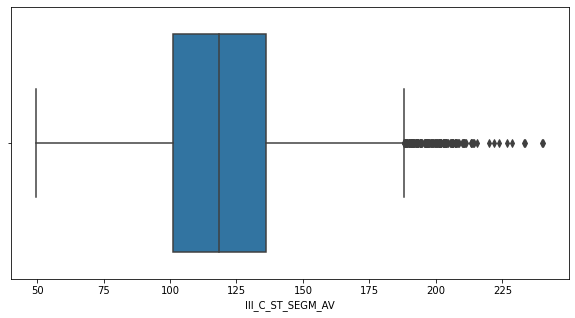

In [607]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_ST_SEGM_AV", data=train)
pass

#### AVR

In [608]:
chanel = 'AVR'

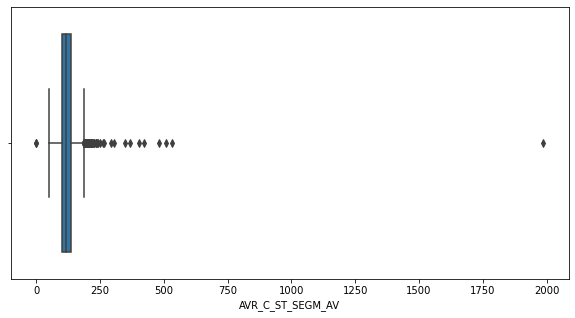

In [609]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_ST_SEGM_AV', data=raw_data)
pass

In [610]:
raw_data[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000       0.000000
0.005      66.143333
0.010      69.175897
0.050      80.644444
0.100      88.009524
0.500     118.826087
0.900     154.209524
0.950     165.422222
0.990     189.464189
0.995     200.047407
1.000    1986.888889
Name: AVR_C_ST_SEGM_AV, dtype: float64

In [611]:
rows_to_delete = train[
    (train[chanel + '_C_ST_SEGM_AV'] > 500)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     50.284848
0.005     66.327295
0.010     69.346871
0.050     80.782580
0.100     88.109524
0.500    118.733333
0.900    153.977905
0.950    164.833333
0.990    187.817333
0.995    196.973881
1.000    240.973451
Name: AVR_C_ST_SEGM_AV, dtype: float64

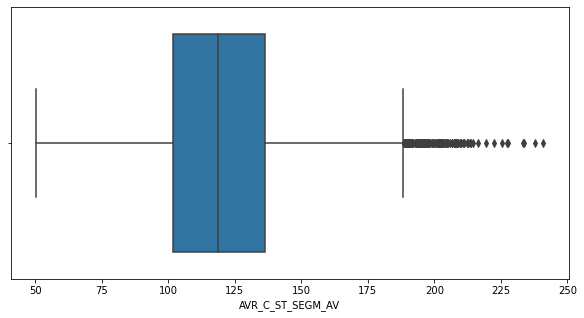

In [612]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_ST_SEGM_AV", data=train)
pass

#### AVF

In [613]:
chanel = 'AVF'

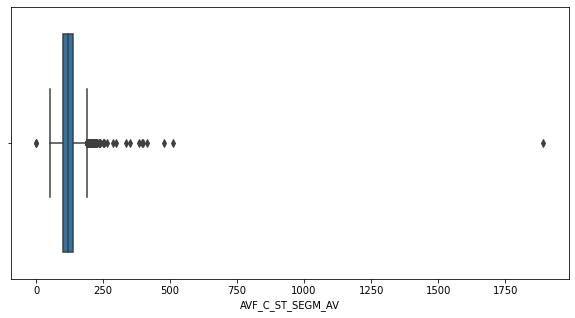

In [614]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_ST_SEGM_AV', data=raw_data)
pass

In [615]:
raw_data[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000       0.000000
0.005      66.381746
0.010      69.532063
0.050      80.973545
0.100      88.366522
0.500     119.007874
0.900     154.083333
0.950     165.264550
0.990     189.357441
0.995     199.810431
1.000    1892.421053
Name: AVF_C_ST_SEGM_AV, dtype: float64

In [616]:
rows_to_delete = train[
    (train[chanel + '_C_ST_SEGM_AV'] > 500)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     50.686869
0.005     66.670918
0.010     69.678156
0.050     81.134674
0.100     88.434681
0.500    118.931217
0.900    153.707937
0.950    164.638664
0.990    187.550023
0.995    196.663836
1.000    239.406316
Name: AVF_C_ST_SEGM_AV, dtype: float64

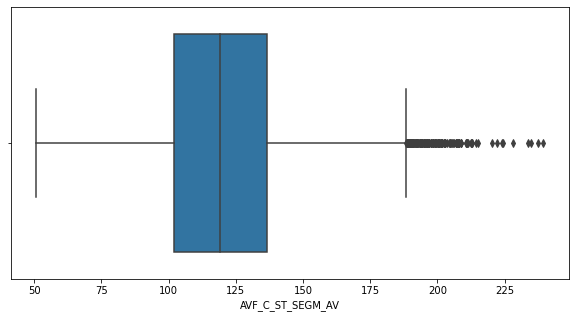

In [617]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_ST_SEGM_AV", data=train)
pass

#### AVL

In [618]:
chanel = 'AVL'

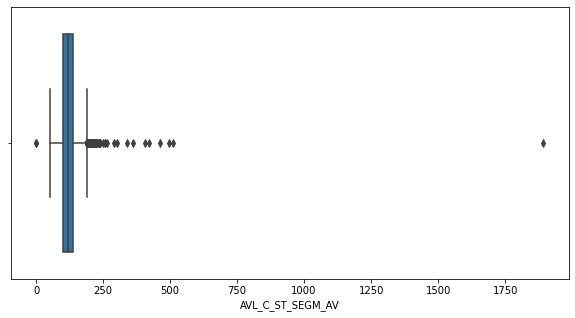

In [619]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_ST_SEGM_AV', data=raw_data)
pass

In [620]:
raw_data[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000       0.000000
0.005      66.329777
0.010      69.445206
0.050      80.927083
0.100      88.205298
0.500     118.996078
0.900     154.064516
0.950     165.392713
0.990     189.457883
0.995     199.840655
1.000    1892.421053
Name: AVL_C_ST_SEGM_AV, dtype: float64

In [621]:
rows_to_delete = train[
    (train[chanel + '_C_ST_SEGM_AV'] > 500)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     50.366569
0.005     66.518596
0.010     69.635226
0.050     80.998065
0.100     88.305376
0.500    118.894009
0.900    153.796304
0.950    164.684767
0.990    187.599263
0.995    196.921429
1.000    239.555556
Name: AVL_C_ST_SEGM_AV, dtype: float64

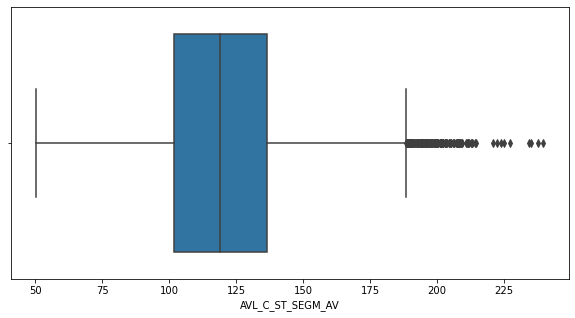

In [622]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_ST_SEGM_AV", data=train)
pass

#### V1

In [623]:
chanel = 'V1'

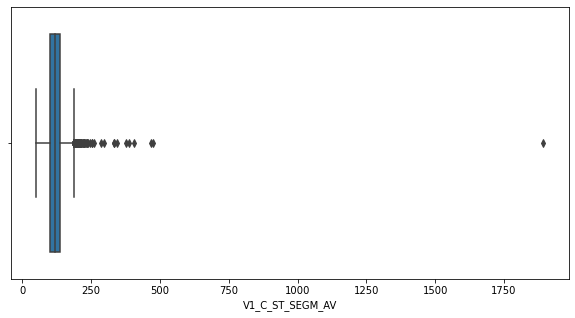

In [624]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_ST_SEGM_AV', data=raw_data)
pass

In [625]:
raw_data[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      50.804581
0.005      66.443215
0.010      69.675119
0.050      81.059551
0.100      88.380816
0.500     118.990376
0.900     153.963255
0.950     164.964567
0.990     189.055997
0.995     199.099182
1.000    1892.421053
Name: V1_C_ST_SEGM_AV, dtype: float64

In [626]:
rows_to_delete = train[
    (train[chanel + '_C_ST_SEGM_AV'] > 500)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     50.804581
0.005     66.676309
0.010     69.817064
0.050     81.197795
0.100     88.463780
0.500    118.880559
0.900    153.658758
0.950    164.488161
0.990    187.192874
0.995    196.356282
1.000    239.544410
Name: V1_C_ST_SEGM_AV, dtype: float64

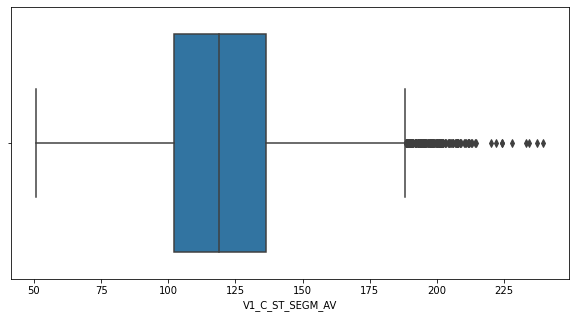

In [627]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_ST_SEGM_AV", data=train)
pass

#### V2

In [628]:
chanel = 'V2'

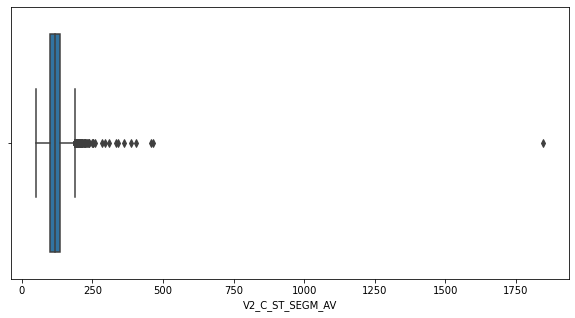

In [629]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_ST_SEGM_AV', data=raw_data)
pass

In [630]:
raw_data[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      50.800000
0.005      66.408451
0.010      69.622797
0.050      81.009854
0.100      88.336542
0.500     118.889101
0.900     153.786667
0.950     164.768627
0.990     188.825023
0.995     198.903550
1.000    1846.833333
Name: V2_C_ST_SEGM_AV, dtype: float64

In [631]:
rows_to_delete = train[
    (train[chanel + '_C_ST_SEGM_AV'] > 500)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     50.800000
0.005     66.630711
0.010     69.764592
0.050     81.179706
0.100     88.415228
0.500    118.765142
0.900    153.555838
0.950    164.251161
0.990    187.086038
0.995    196.065214
1.000    239.196670
Name: V2_C_ST_SEGM_AV, dtype: float64

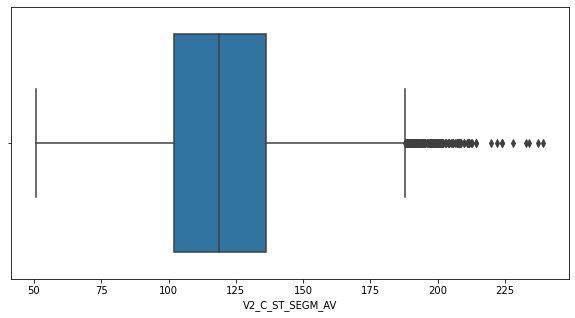

In [632]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_ST_SEGM_AV", data=train)
pass

#### V3

In [633]:
chanel = 'V3'

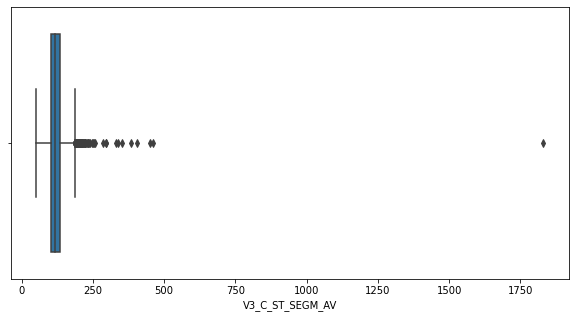

In [634]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_ST_SEGM_AV', data=raw_data)
pass

In [635]:
raw_data[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      50.785625
0.005      66.385046
0.010      69.579102
0.050      80.972929
0.100      88.286367
0.500     118.819833
0.900     153.702544
0.950     164.657534
0.990     188.760673
0.995     198.801300
1.000    1830.323810
Name: V3_C_ST_SEGM_AV, dtype: float64

In [636]:
rows_to_delete = train[
    (train[chanel + '_C_ST_SEGM_AV'] > 500)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     50.785625
0.005     66.606874
0.010     69.736004
0.050     81.128192
0.100     88.378343
0.500    118.699413
0.900    153.517221
0.950    164.180903
0.990    186.956692
0.995    196.054578
1.000    239.117861
Name: V3_C_ST_SEGM_AV, dtype: float64

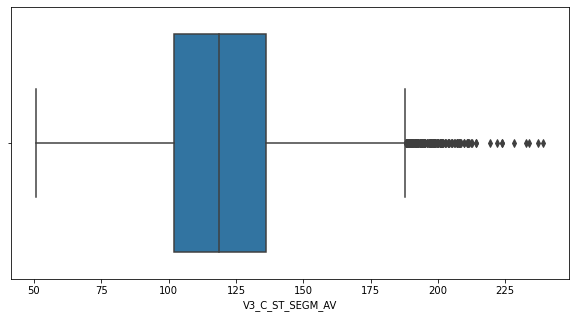

In [637]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_ST_SEGM_AV", data=train)
pass

#### V4

In [638]:
chanel = 'V4'

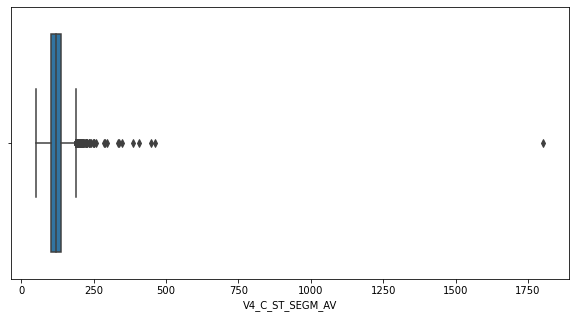

In [639]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_ST_SEGM_AV', data=raw_data)
pass

In [640]:
raw_data[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      50.778192
0.005      66.372307
0.010      69.569409
0.050      80.950635
0.100      88.279159
0.500     118.798045
0.900     153.673429
0.950     164.630917
0.990     188.731443
0.995     198.763625
1.000    1803.440625
Name: V4_C_ST_SEGM_AV, dtype: float64

In [641]:
rows_to_delete = train[
    (train[chanel + '_C_ST_SEGM_AV'] > 500)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     50.778192
0.005     66.605174
0.010     69.727514
0.050     81.103930
0.100     88.361458
0.500    118.685891
0.900    153.477076
0.950    164.169444
0.990    186.915621
0.995    196.136425
1.000    239.174167
Name: V4_C_ST_SEGM_AV, dtype: float64

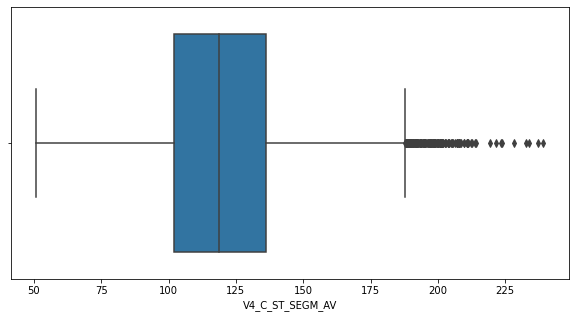

In [642]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_ST_SEGM_AV", data=train)
pass

#### V5

In [643]:
chanel = 'V5'

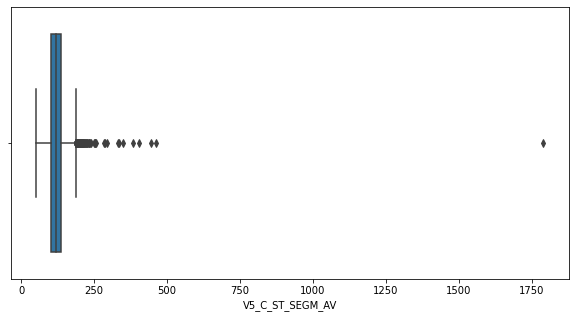

In [644]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_ST_SEGM_AV', data=raw_data)
pass

In [645]:
raw_data[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      50.775503
0.005      66.367080
0.010      69.570880
0.050      80.944002
0.100      88.271739
0.500     118.786961
0.900     153.655388
0.950     164.632687
0.990     188.720614
0.995     198.760819
1.000    1790.421705
Name: V5_C_ST_SEGM_AV, dtype: float64

In [646]:
rows_to_delete = train[
    (train[chanel + '_C_ST_SEGM_AV'] > 500)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     50.775503
0.005     66.604190
0.010     69.722709
0.050     81.099062
0.100     88.357683
0.500    118.685393
0.900    153.474506
0.950    164.169126
0.990    186.911650
0.995    196.151002
1.000    239.189448
Name: V5_C_ST_SEGM_AV, dtype: float64

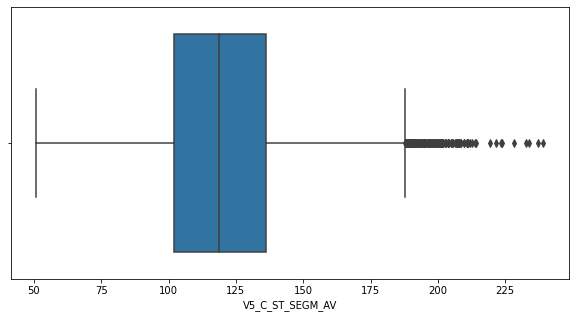

In [647]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_ST_SEGM_AV", data=train)
pass

#### V6

In [648]:
chanel = 'V6'

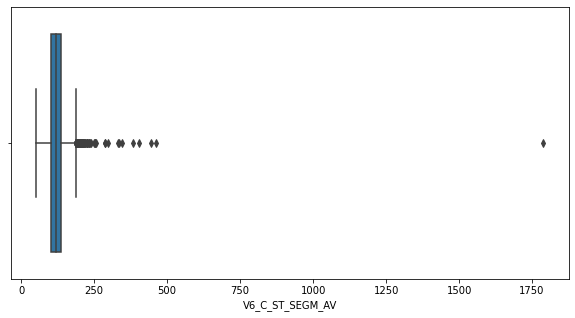

In [649]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_ST_SEGM_AV', data=raw_data)
pass

In [650]:
raw_data[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      50.775558
0.005      66.365615
0.010      69.571525
0.050      80.949093
0.100      88.270174
0.500     118.783572
0.900     153.650654
0.950     164.630342
0.990     188.715167
0.995     198.762261
1.000    1788.470770
Name: V6_C_ST_SEGM_AV, dtype: float64

In [651]:
rows_to_delete = train[
    (train[chanel + '_C_ST_SEGM_AV'] > 500)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_ST_SEGM_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     50.775558
0.005     66.603650
0.010     69.720673
0.050     81.094996
0.100     88.360329
0.500    118.681970
0.900    153.472938
0.950    164.169742
0.990    186.910661
0.995    196.150862
1.000    239.189243
Name: V6_C_ST_SEGM_AV, dtype: float64

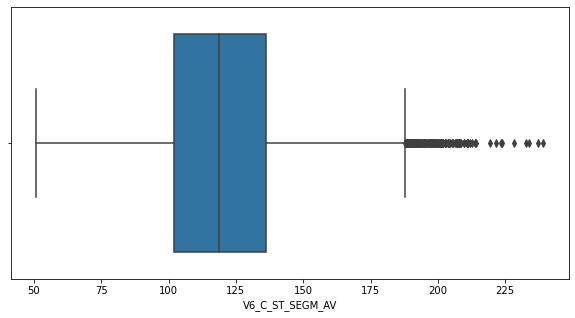

In [652]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_ST_SEGM_AV", data=train)
pass

Сравним число записей до и после удалений

In [653]:
len(raw_data)

17441

In [654]:
len(train)

17175

### QT-интервал

Рассмотрим длину QT-интервала

#### ALL

In [655]:
chanel = 'ALL'

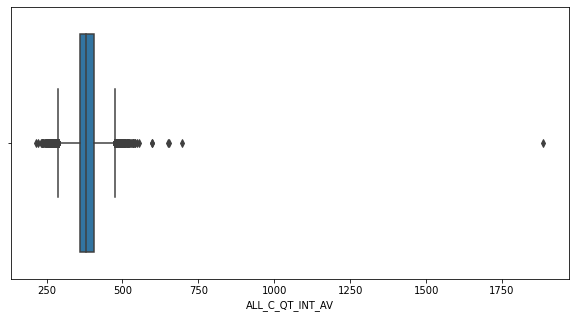

In [656]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QT_INT_AV', data=raw_data)
pass

In [657]:
raw_data[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     215.374121
0.005     280.978890
0.010     290.459201
0.050     321.459074
0.100     336.372294
0.500     381.365119
0.900     427.470225
0.950     441.937790
0.990     475.316058
0.995     490.458682
1.000    1886.002323
Name: ALL_C_QT_INT_AV, dtype: float64

In [658]:
rows_to_delete = train[
    (train[chanel + '_C_QT_INT_AV'] > 750)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    220.952359
0.005    281.105180
0.010    290.749634
0.050    321.984043
0.100    336.541455
0.500    381.224847
0.900    426.569977
0.950    440.786378
0.990    472.199208
0.995    485.625763
1.000    553.377312
Name: ALL_C_QT_INT_AV, dtype: float64

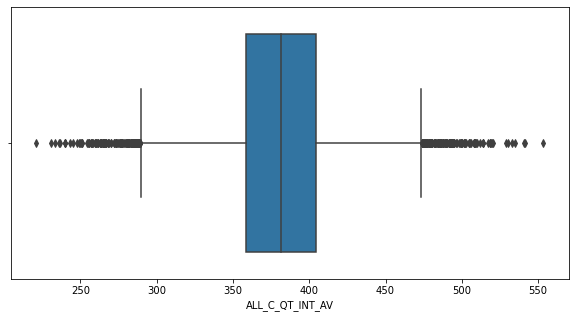

In [659]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QT_INT_AV", data=train)
pass

То же самое по всем каналам

#### I

In [660]:
chanel = 'I'

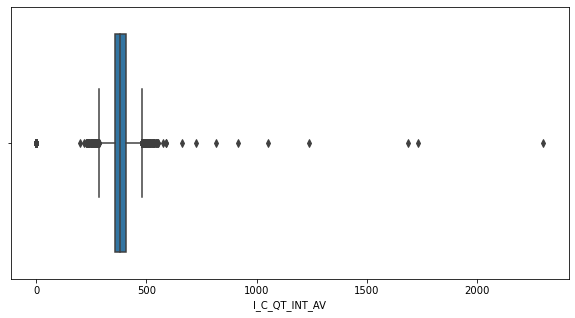

In [661]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QT_INT_AV', data=raw_data)
pass

In [662]:
raw_data[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000       0.000000
0.005     265.250794
0.010     282.840000
0.050     318.000000
0.100     333.750000
0.500     381.000000
0.900     430.857143
0.950     446.666667
0.990     483.735714
0.995     498.750000
1.000    2300.000000
Name: I_C_QT_INT_AV, dtype: float64

In [663]:
rows_to_delete = train[
    (train[chanel + '_C_QT_INT_AV'] > 1000)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    218.666667
0.005    275.661250
0.010    286.534921
0.050    318.980000
0.100    334.333333
0.500    381.000000
0.900    430.250000
0.950    446.000000
0.990    479.688333
0.995    493.834500
1.000    574.000000
Name: I_C_QT_INT_AV, dtype: float64

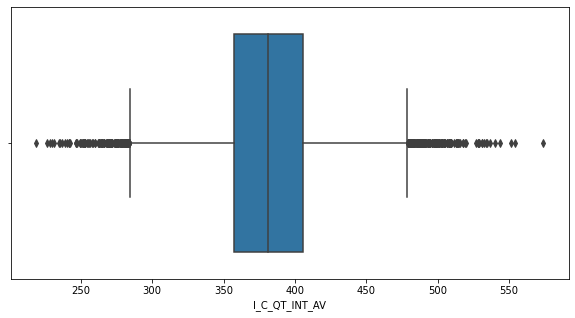

In [664]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QT_INT_AV", data=train)
pass

#### II

In [665]:
chanel = 'II'

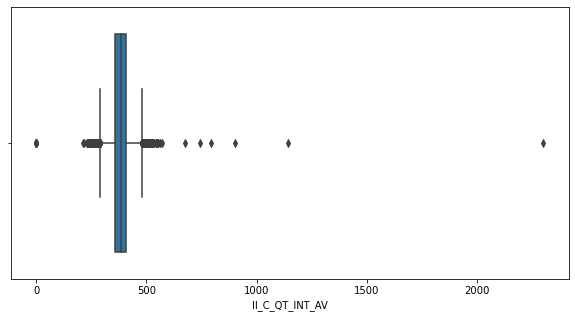

In [666]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QT_INT_AV', data=raw_data)
pass

In [667]:
raw_data[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000       0.000000
0.005     276.161854
0.010     287.778558
0.050     322.062500
0.100     337.380952
0.500     383.090909
0.900     430.666667
0.950     445.833333
0.990     480.152381
0.995     494.511111
1.000    2300.000000
Name: II_C_QT_INT_AV, dtype: float64

In [668]:
rows_to_delete = train[
    (train[chanel + '_C_QT_INT_AV'] > 1000)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    218.421053
0.005    278.630724
0.010    289.881365
0.050    322.907792
0.100    337.666667
0.500    383.037037
0.900    429.833333
0.950    444.666667
0.990    477.532063
0.995    489.883810
1.000    563.666667
Name: II_C_QT_INT_AV, dtype: float64

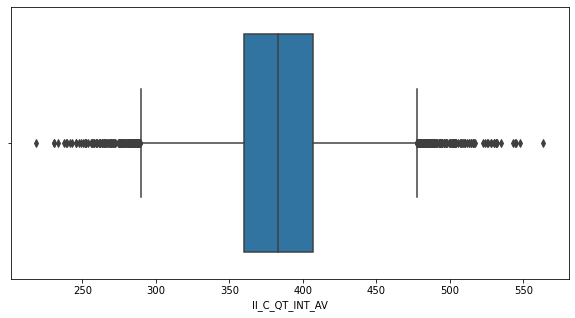

In [669]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QT_INT_AV", data=train)
pass

#### III

In [670]:
chanel = 'III'

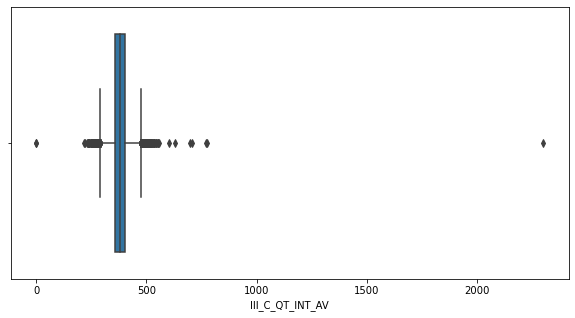

In [671]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QT_INT_AV', data=raw_data)
pass

In [672]:
raw_data[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000       0.000000
0.005     279.725695
0.010     289.326758
0.050     321.794393
0.100     336.785714
0.500     381.850746
0.900     428.250000
0.950     443.107143
0.990     476.775510
0.995     492.045351
1.000    2300.000000
Name: III_C_QT_INT_AV, dtype: float64

In [673]:
rows_to_delete = train[
    (train[chanel + '_C_QT_INT_AV'] > 1000)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    220.362319
0.005    281.235891
0.010    290.917513
0.050    322.259184
0.100    336.985714
0.500    381.761905
0.900    427.601020
0.950    441.959184
0.990    473.103367
0.995    487.028073
1.000    555.255814
Name: III_C_QT_INT_AV, dtype: float64

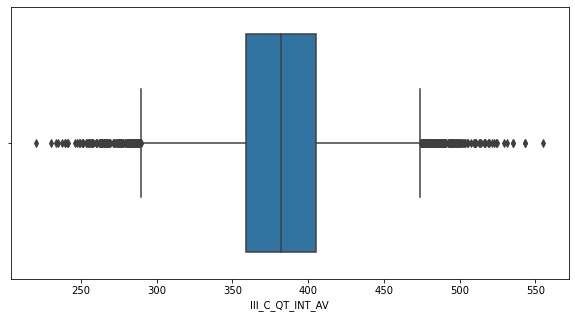

In [674]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QT_INT_AV", data=train)
pass

#### AVR

In [675]:
chanel = 'AVR'

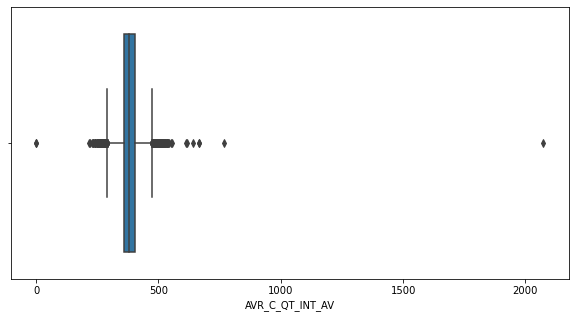

In [676]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QT_INT_AV', data=raw_data)
pass

In [677]:
raw_data[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000       0.000000
0.005     280.310554
0.010     289.393345
0.050     321.645933
0.100     336.626667
0.500     381.792593
0.900     428.083333
0.950     442.622222
0.990     475.728103
0.995     490.803810
1.000    2072.888889
Name: AVR_C_QT_INT_AV, dtype: float64

In [678]:
rows_to_delete = train[
    (train[chanel + '_C_QT_INT_AV'] > 1000)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    220.296296
0.005    280.814924
0.010    290.805162
0.050    322.088776
0.100    336.869091
0.500    381.683333
0.900    427.208972
0.950    441.421667
0.990    473.058889
0.995    485.874930
1.000    553.891304
Name: AVR_C_QT_INT_AV, dtype: float64

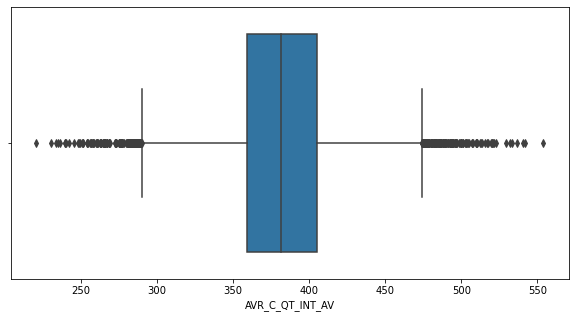

In [679]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QT_INT_AV", data=train)
pass

#### AVL

In [680]:
chanel = 'AVL'

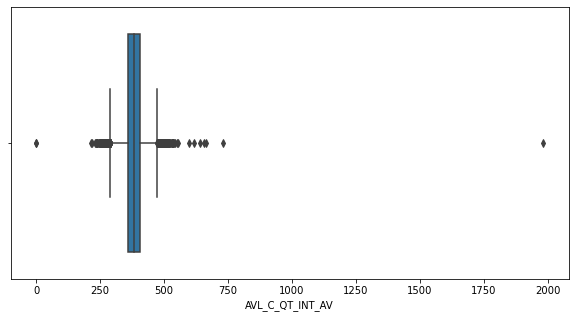

In [681]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QT_INT_AV', data=raw_data)
pass

In [682]:
raw_data[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000       0.000000
0.005     280.132550
0.010     289.527679
0.050     321.423963
0.100     336.312655
0.500     381.329032
0.900     427.555556
0.950     442.289256
0.990     475.545315
0.995     492.009217
1.000    1982.631579
Name: AVL_C_QT_INT_AV, dtype: float64

In [683]:
rows_to_delete = train[
    (train[chanel + '_C_QT_INT_AV'] > 750)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    220.177994
0.005    281.123242
0.010    290.686875
0.050    321.925269
0.100    336.512258
0.500    381.243816
0.900    426.790323
0.950    441.016667
0.990    472.618218
0.995    485.665745
1.000    554.726316
Name: AVL_C_QT_INT_AV, dtype: float64

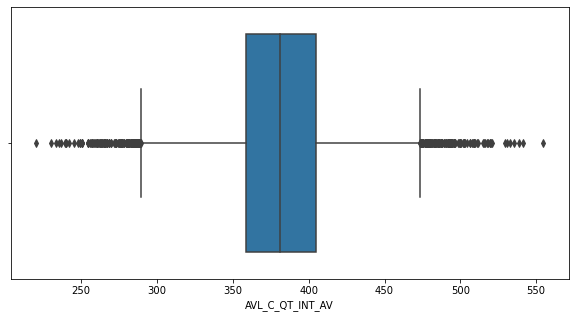

In [684]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QT_INT_AV", data=train)
pass

#### AVF

In [685]:
chanel = 'AVF'

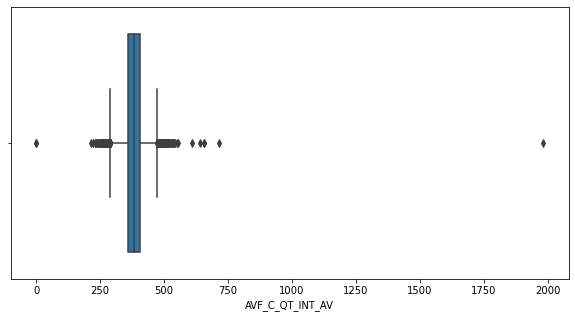

In [686]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QT_INT_AV', data=raw_data)
pass

In [687]:
raw_data[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000       0.000000
0.005     280.447545
0.010     289.758456
0.050     321.390875
0.100     336.327990
0.500     381.366726
0.900     427.505669
0.950     442.036952
0.990     475.661264
0.995     491.424501
1.000    1982.631579
Name: AVF_C_QT_INT_AV, dtype: float64

In [688]:
rows_to_delete = train[
    (train[chanel + '_C_QT_INT_AV'] > 750)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    220.712219
0.005    281.009710
0.010    290.719067
0.050    321.956073
0.100    336.517460
0.500    381.241270
0.900    426.739683
0.950    440.953439
0.990    472.246538
0.995    485.534198
1.000    553.653747
Name: AVF_C_QT_INT_AV, dtype: float64

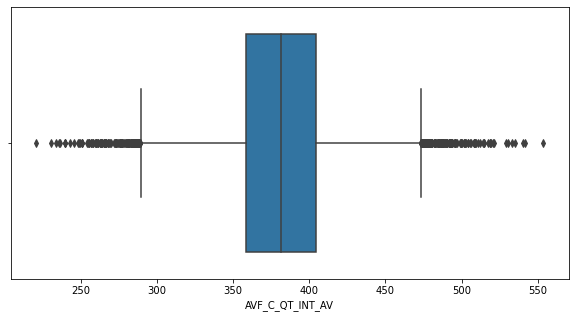

In [689]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QT_INT_AV", data=train)
pass

#### V1

In [690]:
chanel = 'V1'

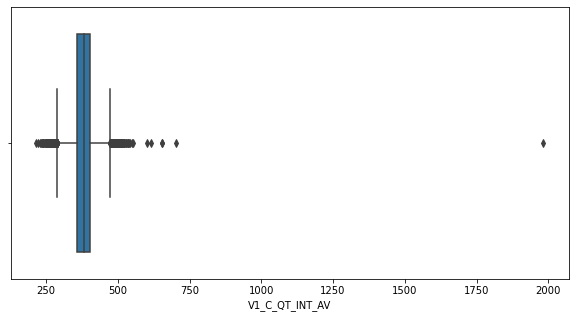

In [691]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QT_INT_AV', data=raw_data)
pass

In [692]:
raw_data[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     215.251540
0.005     280.954672
0.010     290.267817
0.050     321.395622
0.100     336.289522
0.500     381.322835
0.900     427.435730
0.950     442.002291
0.990     475.261404
0.995     490.452559
1.000    1982.631579
Name: V1_C_QT_INT_AV, dtype: float64

In [693]:
rows_to_delete = train[
    (train[chanel + '_C_QT_INT_AV'] > 750)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    220.831802
0.005    280.988641
0.010    290.748248
0.050    321.940157
0.100    336.472783
0.500    381.214567
0.900    426.549398
0.950    440.818898
0.990    472.250977
0.995    485.547566
1.000    553.541613
Name: V1_C_QT_INT_AV, dtype: float64

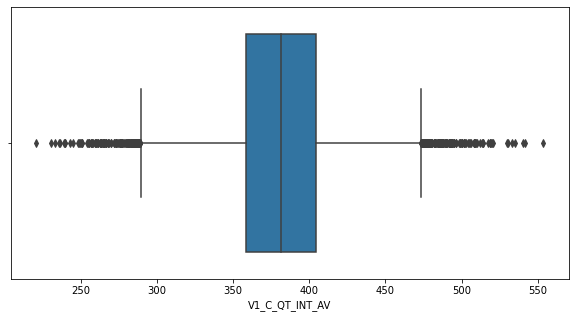

In [694]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QT_INT_AV", data=train)
pass

#### V2

In [695]:
chanel = 'V2'

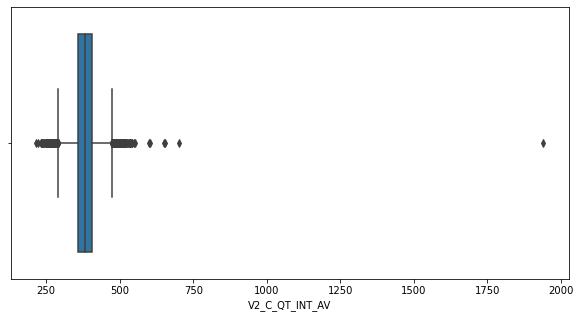

In [696]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QT_INT_AV', data=raw_data)
pass

In [697]:
raw_data[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     215.360020
0.005     280.965379
0.010     290.328392
0.050     321.453119
0.100     336.311586
0.500     381.330196
0.900     427.455971
0.950     441.956629
0.990     475.301867
0.995     490.422418
1.000    1940.384615
Name: V2_C_QT_INT_AV, dtype: float64

In [698]:
rows_to_delete = train[
    (train[chanel + '_C_QT_INT_AV'] > 750)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    220.926839
0.005    281.025751
0.010    290.730287
0.050    321.931443
0.100    336.496604
0.500    381.222103
0.900    426.529812
0.950    440.800784
0.990    472.218880
0.995    485.566815
1.000    553.376673
Name: V2_C_QT_INT_AV, dtype: float64

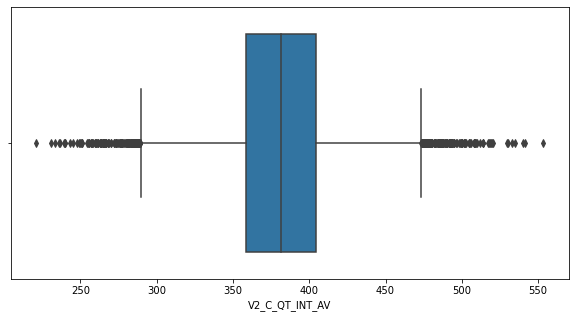

In [699]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QT_INT_AV", data=train)
pass

#### V3

In [700]:
chanel = 'V3'

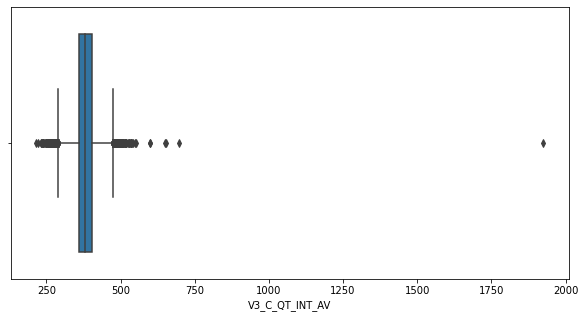

In [701]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QT_INT_AV', data=raw_data)
pass

In [702]:
raw_data[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     215.394917
0.005     280.972104
0.010     290.477220
0.050     321.476190
0.100     336.359344
0.500     381.364481
0.900     427.452614
0.950     441.937813
0.990     475.289908
0.995     490.443233
1.000    1925.085714
Name: V3_C_QT_INT_AV, dtype: float64

In [703]:
rows_to_delete = train[
    (train[chanel + '_C_QT_INT_AV'] > 750)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    220.947640
0.005    281.089090
0.010    290.729251
0.050    321.956990
0.100    336.539172
0.500    381.224490
0.900    426.555872
0.950    440.782779
0.990    472.195173
0.995    485.596750
1.000    553.375954
Name: V3_C_QT_INT_AV, dtype: float64

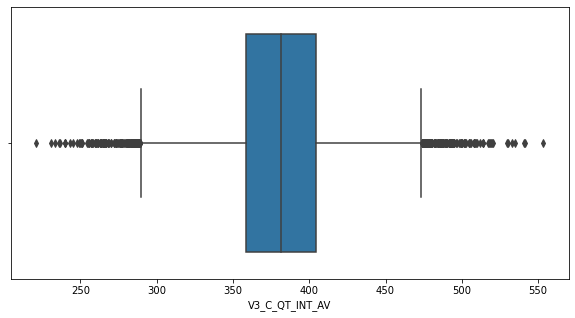

In [704]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QT_INT_AV", data=train)
pass

#### V4

In [705]:
chanel = 'V4'

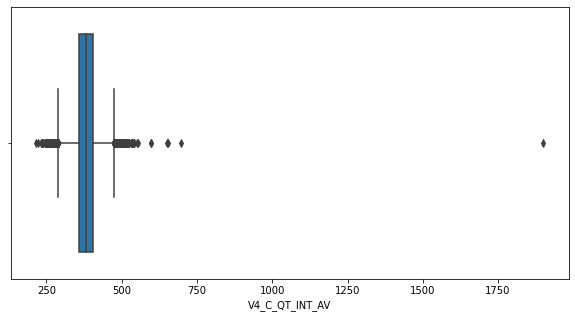

In [706]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QT_INT_AV', data=raw_data)
pass

In [707]:
raw_data[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     215.387923
0.005     280.972980
0.010     290.458223
0.050     321.472467
0.100     336.367902
0.500     381.362876
0.900     427.460411
0.950     441.940915
0.990     475.318587
0.995     490.475761
1.000    1900.334375
Name: V4_C_QT_INT_AV, dtype: float64

In [708]:
rows_to_delete = train[
    (train[chanel + '_C_QT_INT_AV'] > 750)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    220.956220
0.005    281.104029
0.010    290.739938
0.050    321.973499
0.100    336.537130
0.500    381.222734
0.900    426.567256
0.950    440.785589
0.990    472.195152
0.995    485.615426
1.000    553.380362
Name: V4_C_QT_INT_AV, dtype: float64

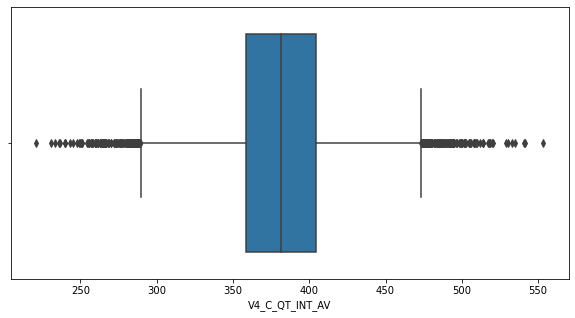

In [709]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QT_INT_AV", data=train)
pass

#### V5

In [710]:
chanel = 'V5'

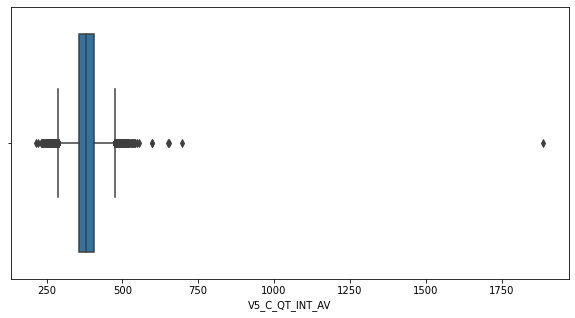

In [711]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QT_INT_AV', data=raw_data)
pass

In [712]:
raw_data[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     215.377951
0.005     280.976835
0.010     290.459004
0.050     321.459342
0.100     336.373051
0.500     381.366010
0.900     427.466118
0.950     441.939424
0.990     475.317412
0.995     490.463453
1.000    1887.868217
Name: V5_C_QT_INT_AV, dtype: float64

In [713]:
rows_to_delete = train[
    (train[chanel + '_C_QT_INT_AV'] > 750)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    220.953251
0.005    281.103888
0.010    290.746794
0.050    321.981288
0.100    336.541055
0.500    381.222887
0.900    426.571286
0.950    440.775162
0.990    472.199243
0.995    485.623306
1.000    553.380022
Name: V5_C_QT_INT_AV, dtype: float64

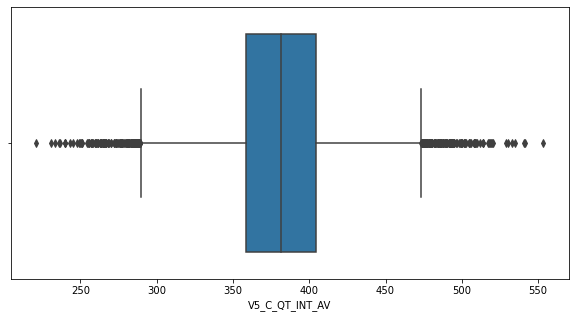

In [714]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QT_INT_AV", data=train)
pass

#### V6

In [715]:
chanel = 'V6'

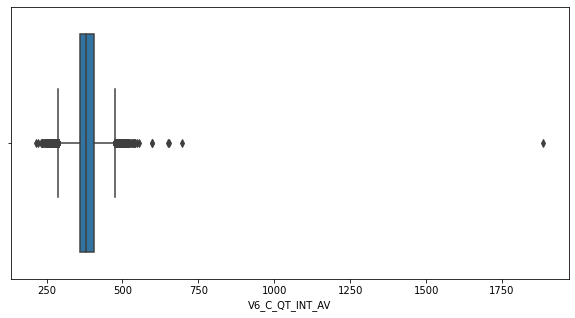

In [716]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QT_INT_AV', data=raw_data)
pass

In [717]:
raw_data[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     215.374121
0.005     280.978890
0.010     290.459201
0.050     321.459074
0.100     336.372294
0.500     381.365119
0.900     427.470225
0.950     441.937790
0.990     475.316058
0.995     490.458682
1.000    1886.002323
Name: V6_C_QT_INT_AV, dtype: float64

In [718]:
rows_to_delete = train[
    (train[chanel + '_C_QT_INT_AV'] > 750)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QT_INT_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000    220.952359
0.005    281.105180
0.010    290.749634
0.050    321.984043
0.100    336.541455
0.500    381.224847
0.900    426.569977
0.950    440.786378
0.990    472.199208
0.995    485.625763
1.000    553.377312
Name: V6_C_QT_INT_AV, dtype: float64

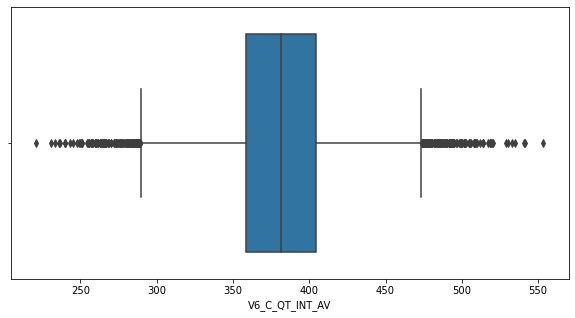

In [719]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QT_INT_AV", data=train)
pass

Сравним количество записей до и после удалений

In [720]:
len(raw_data)

17441

In [721]:
len(train)

17175

### QRSA

Рассмотрим площадь QRS комплекса

#### ALL

In [722]:
chanel = 'ALL'

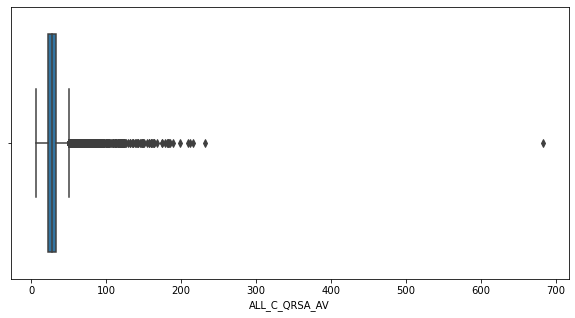

In [723]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSA_AV', data=raw_data)
pass

In [724]:
raw_data[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      6.477333
0.005     13.193343
0.010     14.275936
0.050     17.346490
0.100     19.159024
0.500     27.377383
0.900     42.013029
0.950     50.422186
0.990     78.783910
0.995    108.792651
1.000    682.964154
Name: ALL_C_QRSA_AV, dtype: float64

In [725]:
rows_to_delete = train[
    (train[chanel + '_C_QRSA_AV'] > 130)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      6.477333
0.005     13.206582
0.010     14.272192
0.050     17.330952
0.100     19.132793
0.500     27.284012
0.900     41.304051
0.950     48.455904
0.990     68.600178
0.995     77.884651
1.000    124.253224
Name: ALL_C_QRSA_AV, dtype: float64

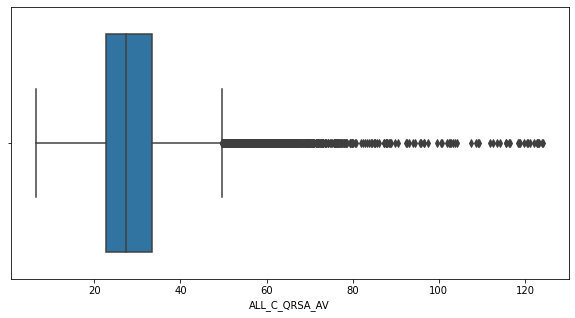

In [726]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSA_AV", data=train)
pass

То же самое по всем каналам

#### I

In [727]:
chanel = 'I'

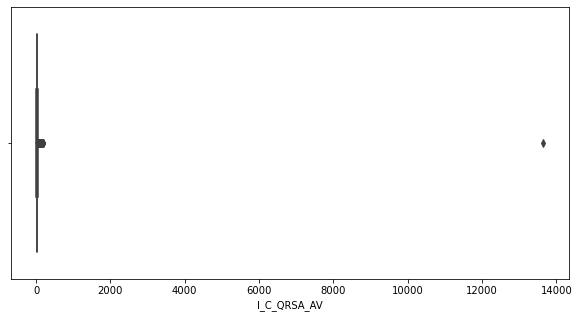

In [728]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSA_AV', data=raw_data)
pass

In [729]:
raw_data[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000        0.000000
0.005        5.375765
0.010        6.328775
0.050        9.307500
0.100       11.114357
0.500       20.159750
0.900       34.518500
0.950       40.691500
0.990       61.726283
0.995       75.347312
1.000    13649.097600
Name: I_C_QRSA_AV, dtype: float64

In [730]:
rows_to_delete = train[
    (train[chanel + '_C_QRSA_AV'] > 100)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     1.734100
0.005     5.768459
0.010     6.462683
0.050     9.370527
0.100    11.131049
0.500    20.096111
0.900    33.952910
0.950    39.620770
0.990    54.658260
0.995    62.678910
1.000    98.112750
Name: I_C_QRSA_AV, dtype: float64

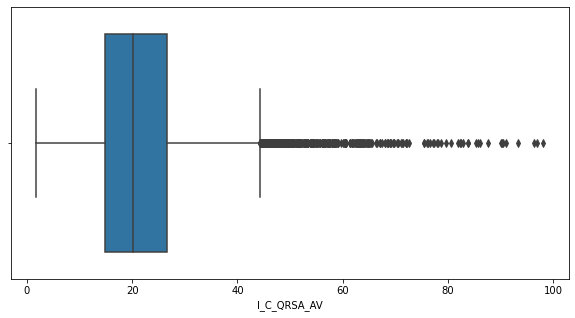

In [731]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSA_AV", data=train)
pass

#### II

In [732]:
chanel = 'II'

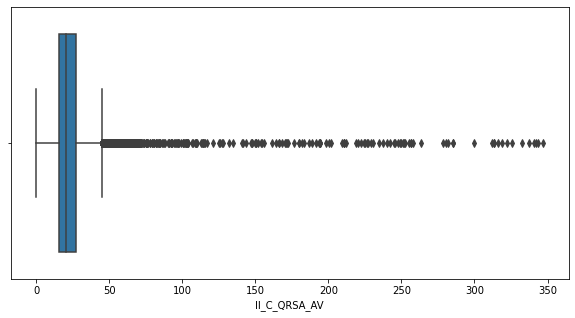

In [733]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSA_AV', data=raw_data)
pass

In [734]:
raw_data[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      5.473004
0.010      6.361400
0.050      9.573300
0.100     11.548056
0.500     20.623500
0.900     35.249444
0.950     41.898714
0.990     70.268364
0.995    134.082360
1.000    347.126000
Name: II_C_QRSA_AV, dtype: float64

In [735]:
rows_to_delete = train[
    (train[chanel + '_C_QRSA_AV'] > 109)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      2.063000
0.005      5.545105
0.010      6.390998
0.050      9.562634
0.100     11.534099
0.500     20.538512
0.900     34.522267
0.950     40.198847
0.990     55.246326
0.995     63.532285
1.000    104.071000
Name: II_C_QRSA_AV, dtype: float64

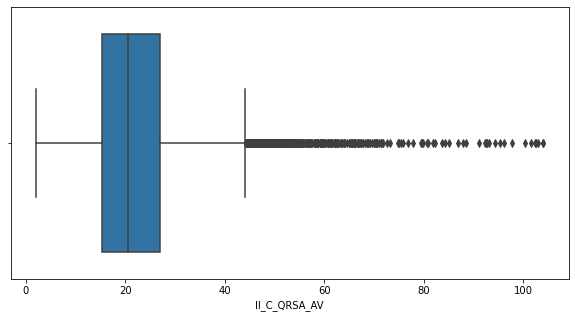

In [736]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSA_AV", data=train)
pass

#### III

In [737]:
chanel = 'III'

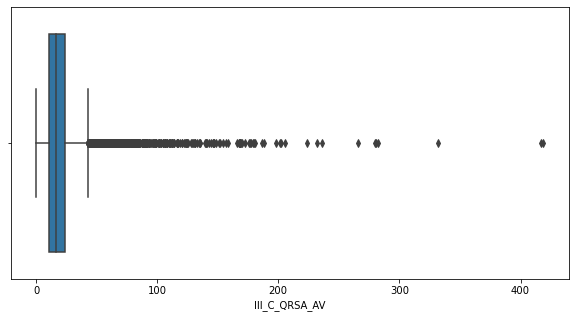

In [738]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSA_AV', data=raw_data)
pass

In [739]:
raw_data[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      3.800097
0.010      4.329244
0.050      6.362222
0.100      7.786700
0.500     16.113455
0.900     34.845250
0.950     45.553409
0.990     80.302356
0.995    106.698550
1.000    418.817727
Name: III_C_QRSA_AV, dtype: float64

In [740]:
rows_to_delete = train[
    (train[chanel + '_C_QRSA_AV'] > 125)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      1.447333
0.005      3.907983
0.010      4.417470
0.050      6.370753
0.100      7.777558
0.500     16.001944
0.900     33.793375
0.950     42.938444
0.990     66.002883
0.995     76.737373
1.000    117.351600
Name: III_C_QRSA_AV, dtype: float64

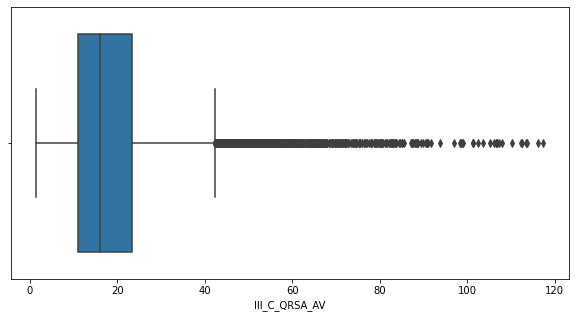

In [741]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSA_AV", data=train)
pass

#### AVR

In [742]:
chanel = 'AVR'

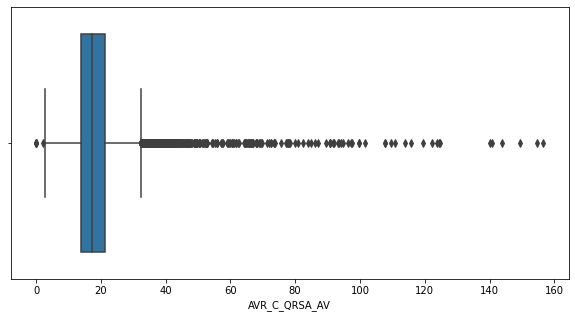

In [743]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSA_AV', data=raw_data)
pass

In [744]:
raw_data[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      5.804383
0.010      6.802100
0.050      9.464438
0.100     11.051389
0.500     17.118222
0.900     25.619214
0.950     29.219864
0.990     43.791164
0.995     60.576394
1.000    156.603800
Name: AVR_C_QRSA_AV, dtype: float64

In [745]:
rows_to_delete = train[
    (train[chanel + '_C_QRSA_AV'] > 57)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     2.109889
0.005     5.890088
0.010     6.822915
0.050     9.462427
0.100    11.049556
0.500    17.053275
0.900    25.251909
0.950    28.331057
0.990    36.935698
0.995    40.528855
1.000    55.835633
Name: AVR_C_QRSA_AV, dtype: float64

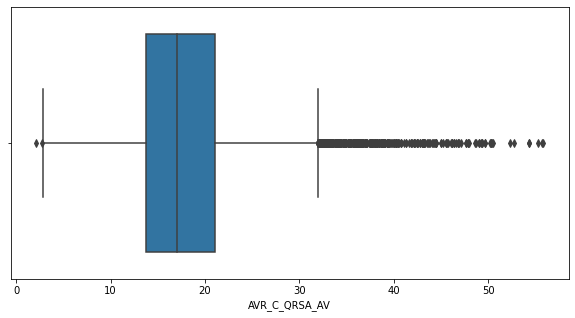

In [746]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSA_AV", data=train)
pass

#### AVL

In [747]:
chanel = 'AVL'

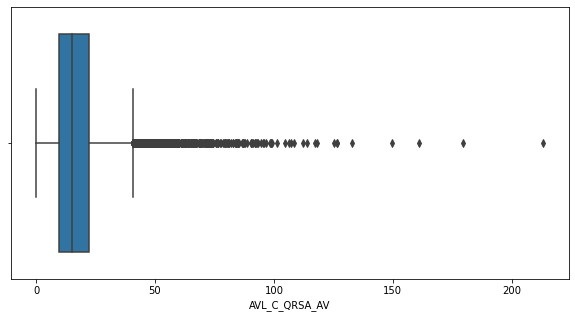

In [748]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSA_AV', data=raw_data)
pass

In [749]:
raw_data[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      3.026122
0.010      3.566986
0.050      5.300857
0.100      6.599000
0.500     15.053727
0.900     31.162154
0.950     39.030889
0.990     59.718602
0.995     72.003413
1.000    213.248950
Name: AVL_C_QRSA_AV, dtype: float64

In [750]:
rows_to_delete = train[
    (train[chanel + '_C_QRSA_AV'] > 150)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      1.611417
0.005      3.106640
0.010      3.591983
0.050      5.300864
0.100      6.585407
0.500     14.945629
0.900     30.393500
0.950     37.221826
0.990     54.089475
0.995     60.156690
1.000    101.381563
Name: AVL_C_QRSA_AV, dtype: float64

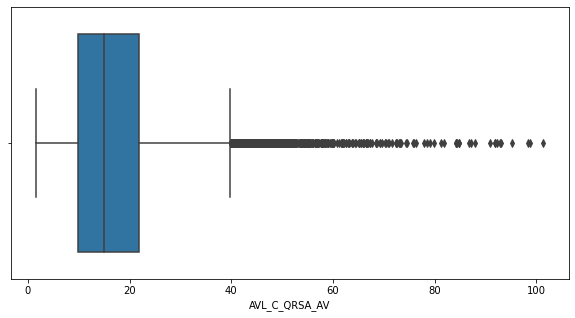

In [751]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSA_AV", data=train)
pass

#### AVF

In [752]:
chanel = 'AVF'

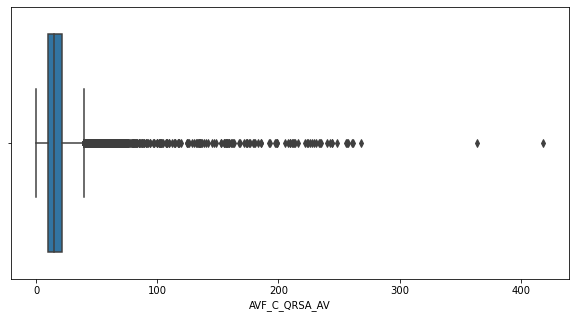

In [753]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSA_AV', data=raw_data)
pass

In [754]:
raw_data[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      3.558345
0.010      3.987760
0.050      5.822636
0.100      7.100500
0.500     14.919208
0.900     31.079937
0.950     39.128625
0.990     72.327278
0.995    124.579544
1.000    418.509722
Name: AVF_C_QRSA_AV, dtype: float64

In [755]:
rows_to_delete = train[
    (train[chanel + '_C_QRSA_AV'] > 100)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     1.830500
0.005     3.583130
0.010     4.003271
0.050     5.808114
0.100     7.071050
0.500    14.766532
0.900    30.088297
0.950    36.836827
0.990    54.773487
0.995    63.427452
1.000    96.913400
Name: AVF_C_QRSA_AV, dtype: float64

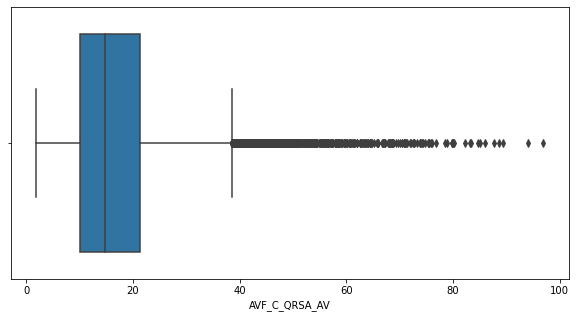

In [756]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSA_AV", data=train)
pass

#### V1

In [757]:
chanel = 'V1'

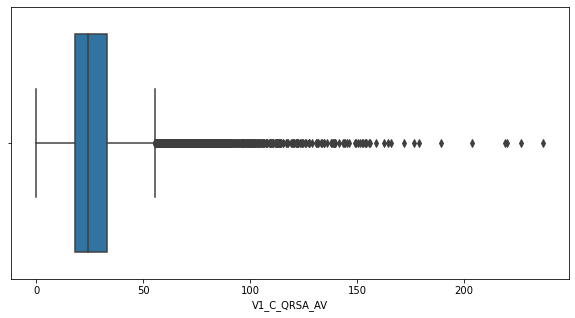

In [758]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSA_AV', data=raw_data)
pass

In [759]:
raw_data[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      6.448900
0.010      7.365079
0.050     11.106389
0.100     13.448455
0.500     24.275708
0.900     44.826692
0.950     56.566889
0.990     94.854341
0.995    113.267800
1.000    237.010147
Name: V1_C_QRSA_AV, dtype: float64

In [760]:
rows_to_delete = train[
    (train[chanel + '_C_QRSA_AV'] > 200)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      1.531786
0.005      6.500119
0.010      7.376076
0.050     11.105492
0.100     13.434419
0.500     24.161263
0.900     43.962525
0.950     54.880070
0.990     88.590406
0.995    105.991526
1.000    172.099550
Name: V1_C_QRSA_AV, dtype: float64

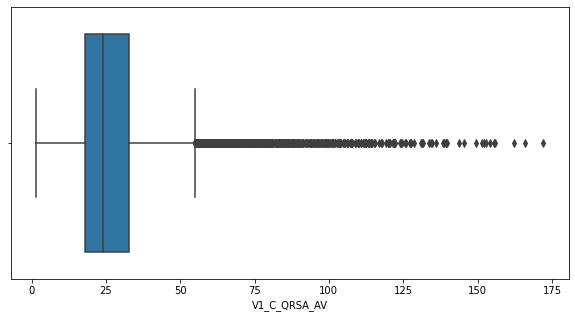

In [761]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSA_AV", data=train)
pass

#### V2

In [762]:
chanel = 'V2'

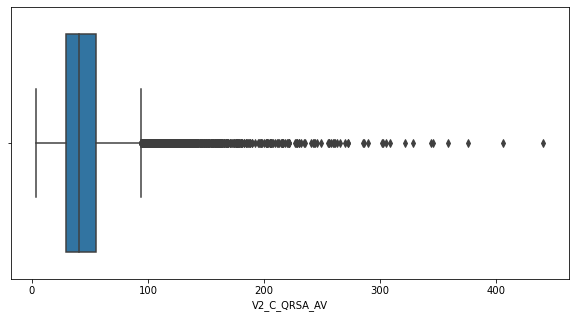

In [763]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSA_AV', data=raw_data)
pass

In [764]:
raw_data[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      3.545944
0.005     10.302551
0.010     11.992586
0.050     18.093556
0.100     21.967000
0.500     40.714409
0.900     74.067125
0.950     91.913200
0.990    154.625900
0.995    184.888471
1.000    440.462143
Name: V2_C_QRSA_AV, dtype: float64

In [765]:
rows_to_delete = train[
    (train[chanel + '_C_QRSA_AV'] > 400)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      3.545944
0.005     10.280053
0.010     12.008908
0.050     18.057804
0.100     21.918718
0.500     40.443238
0.900     72.636774
0.950     88.580781
0.990    139.899840
0.995    165.804396
1.000    271.897458
Name: V2_C_QRSA_AV, dtype: float64

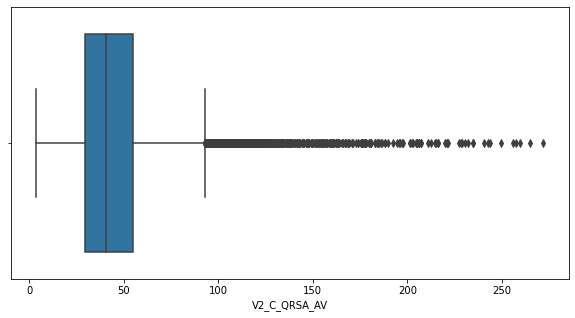

In [766]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSA_AV", data=train)
pass

#### V3

In [767]:
chanel = 'V3'

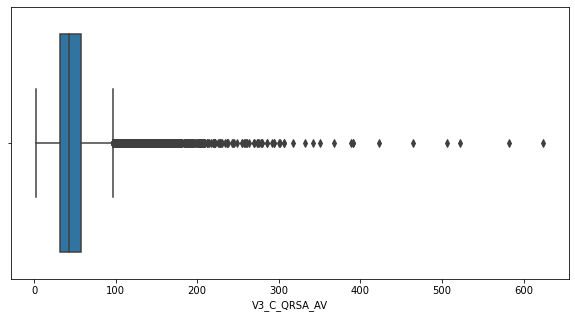

In [768]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSA_AV', data=raw_data)
pass

In [769]:
raw_data[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      2.321417
0.005     11.516200
0.010     13.593614
0.050     20.104167
0.100     24.166000
0.500     42.925500
0.900     76.001937
0.950     92.850611
0.990    164.959567
0.995    201.905833
1.000    624.219150
Name: V3_C_QRSA_AV, dtype: float64

In [770]:
rows_to_delete = train[
    (train[chanel + '_C_QRSA_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      2.321417
0.005     11.496553
0.010     13.578622
0.050     20.028964
0.100     24.057630
0.500     42.633083
0.900     73.875819
0.950     88.323770
0.990    138.670711
0.995    162.221632
1.000    238.174800
Name: V3_C_QRSA_AV, dtype: float64

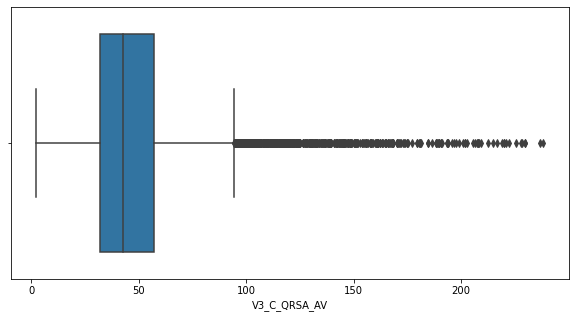

In [771]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSA_AV", data=train)
pass

#### V4

In [772]:
chanel = 'V4'

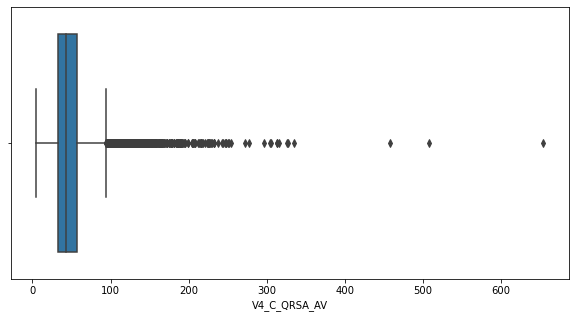

In [773]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSA_AV', data=raw_data)
pass

In [774]:
raw_data[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      4.582364
0.005     11.131046
0.010     13.342701
0.050     20.588778
0.100     24.898833
0.500     43.317056
0.900     74.480063
0.950     89.254950
0.990    144.647290
0.995    177.596131
1.000    654.424450
Name: V4_C_QRSA_AV, dtype: float64

In [775]:
rows_to_delete = train[
    (train[chanel + '_C_QRSA_AV'] > 200)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      4.582364
0.005     11.114911
0.010     13.309185
0.050     20.557615
0.100     24.841038
0.500     43.047350
0.900     72.693736
0.950     85.222266
0.990    117.873399
0.995    134.551419
1.000    193.060615
Name: V4_C_QRSA_AV, dtype: float64

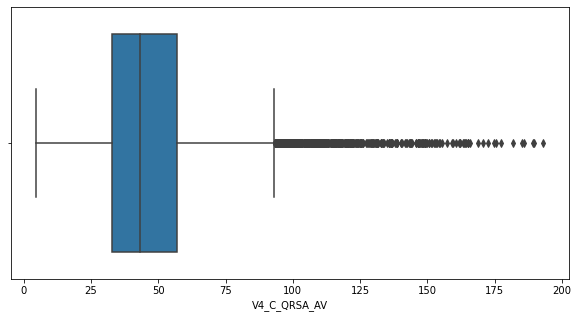

In [776]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSA_AV", data=train)
pass

#### V5

In [777]:
chanel = 'V5'

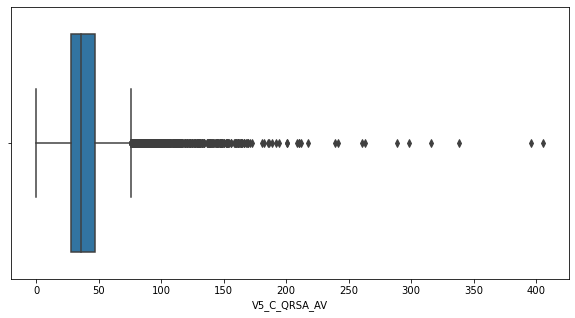

In [778]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSA_AV', data=raw_data)
pass

In [779]:
raw_data[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      9.568481
0.010     11.783173
0.050     17.993050
0.100     21.293533
0.500     35.945700
0.900     61.283389
0.950     72.801167
0.990    111.833991
0.995    139.633697
1.000    405.836500
Name: V5_C_QRSA_AV, dtype: float64

In [780]:
rows_to_delete = train[
    (train[chanel + '_C_QRSA_AV'] > 175)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      2.778227
0.005      9.535694
0.010     11.781652
0.050     17.960222
0.100     21.265571
0.500     35.751467
0.900     59.868218
0.950     70.149089
0.990     97.376098
0.995    109.644354
1.000    166.696909
Name: V5_C_QRSA_AV, dtype: float64

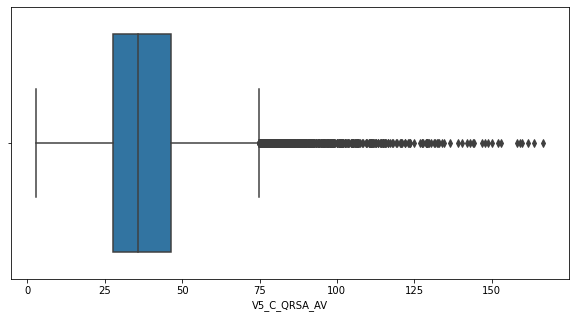

In [781]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSA_AV", data=train)
pass

#### V6

In [782]:
chanel = 'V6'

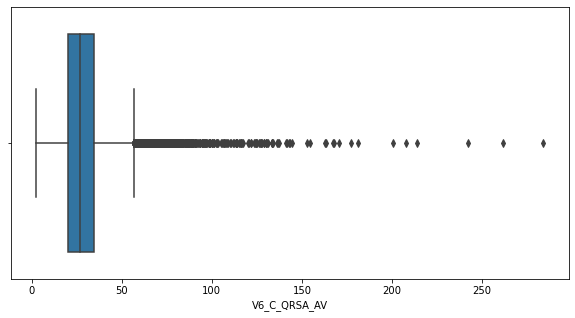

In [783]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSA_AV', data=raw_data)
pass

In [784]:
raw_data[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      2.400227
0.005      7.328415
0.010      8.621620
0.050     13.111500
0.100     15.614500
0.500     26.516800
0.900     45.863227
0.950     54.700000
0.990     82.112390
0.995     98.412625
1.000    283.956389
Name: V6_C_QRSA_AV, dtype: float64

In [785]:
rows_to_delete = train[
    (train[chanel + '_C_QRSA_AV'] > 110)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      2.400227
0.005      7.296291
0.010      8.603879
0.050     13.105348
0.100     15.565363
0.500     26.373544
0.900     44.766785
0.950     52.537610
0.990     71.416206
0.995     79.969433
1.000    108.861250
Name: V6_C_QRSA_AV, dtype: float64

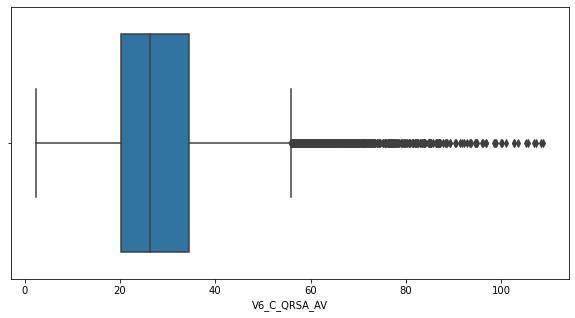

In [786]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSA_AV", data=train)
pass

Сравним число записей до удалений и после

In [787]:
len(raw_data)

17441

In [788]:
len(train)

17072

### QRSTA

Рассмотрим площадь QRS комплекса и T волны

#### ALL

In [789]:
chanel = 'ALL'

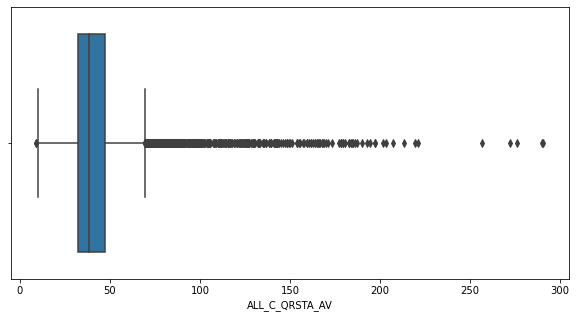

In [790]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSTA_AV', data=raw_data)
pass

In [791]:
raw_data[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      8.910830
0.005     18.900204
0.010     20.409050
0.050     24.539315
0.100     27.185167
0.500     38.496930
0.900     57.764929
0.950     67.857494
0.990    104.498917
0.995    132.119993
1.000    290.620736
Name: ALL_C_QRSTA_AV, dtype: float64

In [792]:
rows_to_delete = train[
    (train[chanel + '_C_QRSTA_AV'] > 250)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      8.910830
0.005     18.883200
0.010     20.393264
0.050     24.475532
0.100     27.118279
0.500     38.302371
0.900     56.144568
0.950     64.346481
0.990     84.613856
0.995     91.519676
1.000    159.550958
Name: ALL_C_QRSTA_AV, dtype: float64

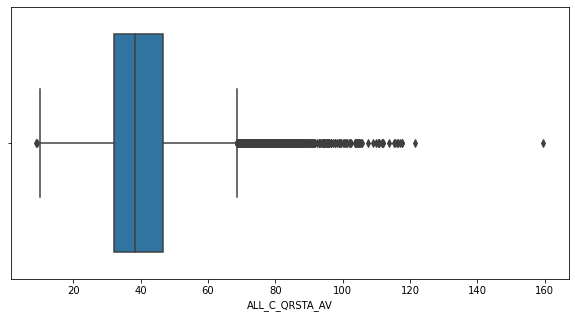

In [793]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSTA_AV", data=train)
pass

То же самое по всем каналам

#### I

In [794]:
chanel = 'I'

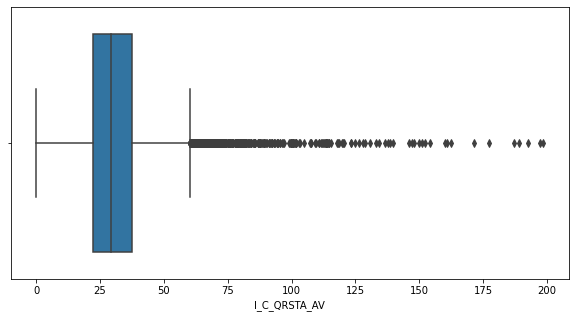

In [795]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSTA_AV', data=raw_data)
pass

In [796]:
raw_data[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      8.780875
0.010     10.361848
0.050     14.772861
0.100     17.368056
0.500     29.230389
0.900     46.641846
0.950     53.802500
0.990     77.966725
0.995     93.069378
1.000    198.535778
Name: I_C_QRSTA_AV, dtype: float64

In [797]:
rows_to_delete = train[
    (train[chanel + '_C_QRSTA_AV'] > 108)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      5.067500
0.005      9.561497
0.010     10.856988
0.050     14.871838
0.100     17.394324
0.500     29.111281
0.900     45.816519
0.950     52.134122
0.990     67.226176
0.995     74.080603
1.000    102.720722
Name: I_C_QRSTA_AV, dtype: float64

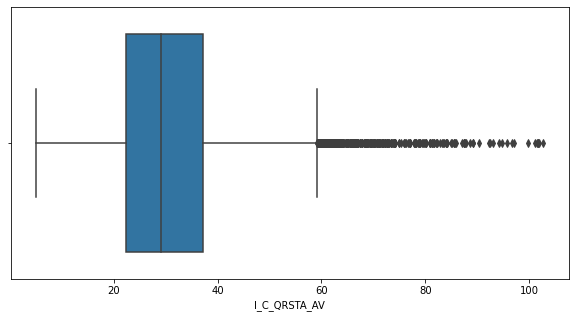

In [798]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSTA_AV", data=train)
pass

#### II

In [799]:
chanel = 'II'

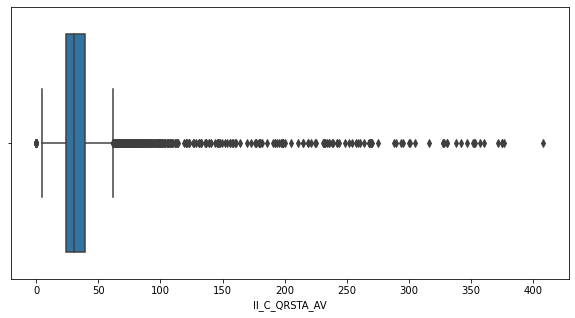

In [800]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSTA_AV', data=raw_data)
pass

In [801]:
raw_data[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      9.298526
0.010     10.915200
0.050     15.473562
0.100     18.240000
0.500     30.633182
0.900     49.096278
0.950     57.369300
0.990     92.475694
0.995    159.937962
1.000    407.961000
Name: II_C_QRSTA_AV, dtype: float64

In [802]:
rows_to_delete = train[
    (train[chanel + '_C_QRSTA_AV'] < 1) |
    (train[chanel + '_C_QRSTA_AV'] > 120)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      4.401038
0.005      9.680935
0.010     11.042627
0.050     15.474590
0.100     18.216422
0.500     30.441188
0.900     47.915791
0.950     54.838133
0.990     71.401605
0.995     76.977368
1.000    113.241250
Name: II_C_QRSTA_AV, dtype: float64

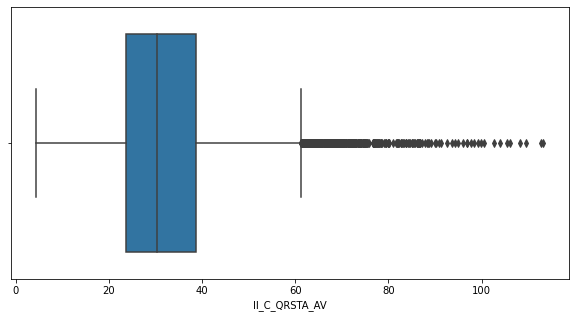

In [803]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSTA_AV", data=train)
pass

#### III

In [804]:
chanel = 'III'

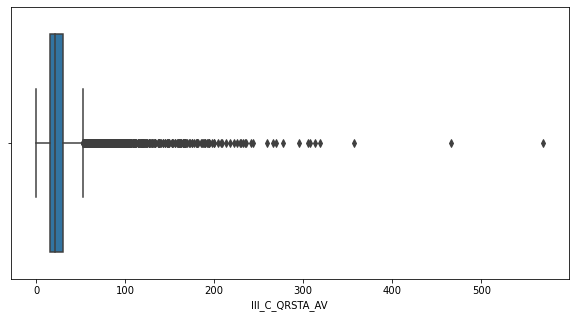

In [805]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSTA_AV', data=raw_data)
pass

In [806]:
raw_data[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      5.852239
0.010      6.716333
0.050      9.621955
0.100     11.462143
0.500     21.396300
0.900     43.631227
0.950     56.735389
0.990    100.884327
0.995    138.922418
1.000    569.548188
Name: III_C_QRSTA_AV, dtype: float64

In [807]:
rows_to_delete = train[
    (train[chanel + '_C_QRSTA_AV'] < 1) |
    (train[chanel + '_C_QRSTA_AV'] > 140)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      2.834000
0.005      6.272415
0.010      6.980510
0.050      9.651891
0.100     11.461683
0.500     21.176986
0.900     41.897120
0.950     52.298415
0.990     80.407892
0.995     90.969002
1.000    139.039944
Name: III_C_QRSTA_AV, dtype: float64

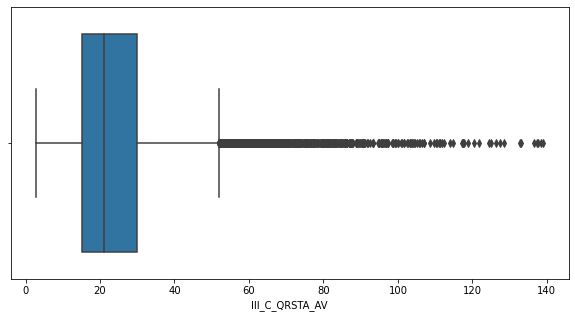

In [808]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSTA_AV", data=train)
pass

#### AVR

In [809]:
chanel = 'AVR'

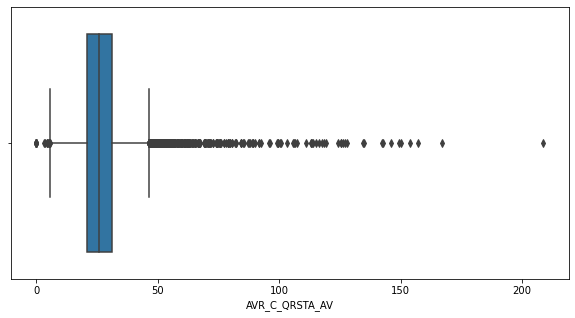

In [810]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSTA_AV', data=raw_data)
pass

In [811]:
raw_data[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      9.081102
0.010     10.387961
0.050     14.376950
0.100     16.903611
0.500     25.899375
0.900     37.005773
0.950     41.677389
0.990     56.981227
0.995     70.843625
1.000    208.708812
Name: AVR_C_QRSTA_AV, dtype: float64

In [812]:
rows_to_delete = train[
    (train[chanel + '_C_QRSTA_AV'] < 1) |
    (train[chanel + '_C_QRSTA_AV'] > 69)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     3.128750
0.005     9.316583
0.010    10.481494
0.050    14.379024
0.100    16.876065
0.500    25.807150
0.900    36.463336
0.950    40.528458
0.990    49.357104
0.995    53.259771
1.000    67.154111
Name: AVR_C_QRSTA_AV, dtype: float64

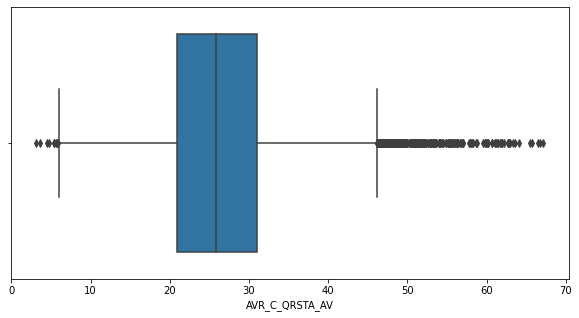

In [813]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSTA_AV", data=train)
pass

#### AVL

In [814]:
chanel = 'AVL'

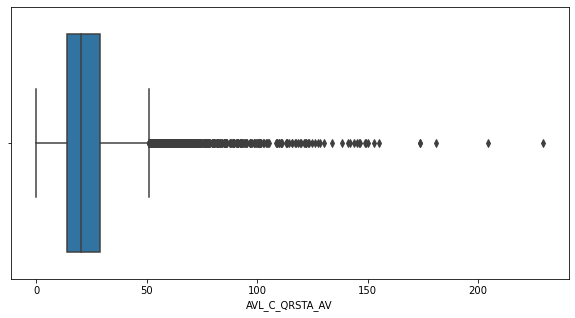

In [815]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSTA_AV', data=raw_data)
pass

In [816]:
raw_data[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      5.117024
0.010      5.915350
0.050      8.251200
0.100     10.040231
0.500     20.234500
0.900     39.688100
0.950     48.434937
0.990     74.872156
0.995     92.490627
1.000    229.470550
Name: AVL_C_QRSTA_AV, dtype: float64

In [817]:
rows_to_delete = train[
    (train[chanel + '_C_QRSTA_AV'] < 1) |
    (train[chanel + '_C_QRSTA_AV'] > 120)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      2.927500
0.005      5.323281
0.010      6.021637
0.050      8.262090
0.100     10.019590
0.500     20.043887
0.900     38.575825
0.950     46.473321
0.990     65.278058
0.995     71.806142
1.000    113.529938
Name: AVL_C_QRSTA_AV, dtype: float64

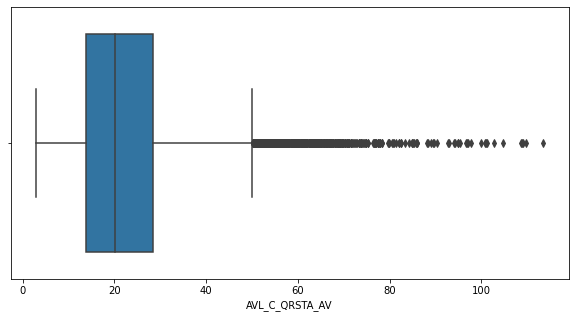

In [818]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSTA_AV", data=train)
pass

#### AVF

In [819]:
chanel = 'AVF'

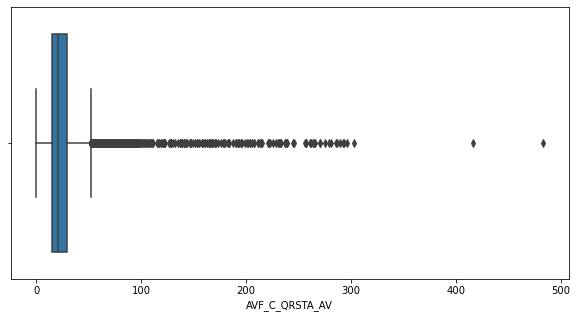

In [820]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSTA_AV', data=raw_data)
pass

In [821]:
raw_data[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      6.026692
0.010      6.837364
0.050      9.525750
0.100     11.261500
0.500     21.274545
0.900     40.875929
0.950     50.825875
0.990     91.887035
0.995    153.497620
1.000    483.448125
Name: AVF_C_QRSTA_AV, dtype: float64

In [822]:
rows_to_delete = train[
    (train[chanel + '_C_QRSTA_AV'] < 1) |
    (train[chanel + '_C_QRSTA_AV'] > 350)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      2.591929
0.005      6.140801
0.010      6.951390
0.050      9.522809
0.100     11.241440
0.500     21.045987
0.900     39.373378
0.950     47.533020
0.990     67.700039
0.995     77.628512
1.000    110.648333
Name: AVF_C_QRSTA_AV, dtype: float64

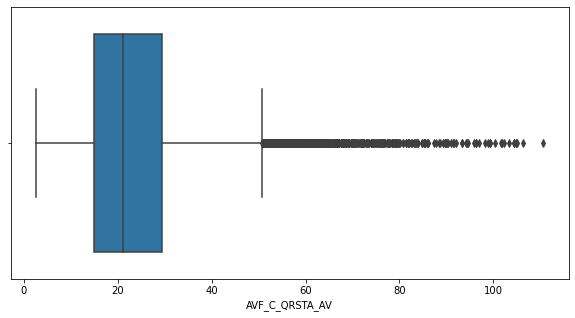

In [823]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSTA_AV", data=train)
pass

#### V1

In [824]:
chanel = 'V1'

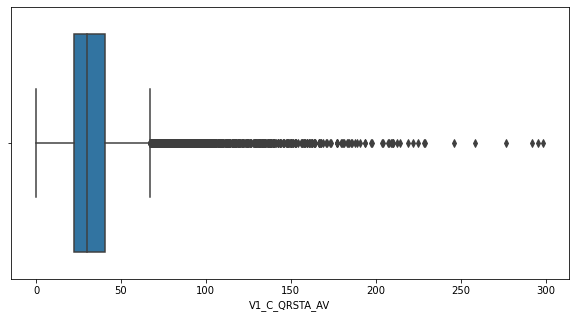

In [825]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSTA_AV', data=raw_data)
pass

In [826]:
raw_data[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      9.516859
0.010     10.830888
0.050     14.843687
0.100     17.337825
0.500     29.724050
0.900     56.439063
0.950     73.291313
0.990    127.259168
0.995    149.921062
1.000    298.625923
Name: V1_C_QRSTA_AV, dtype: float64

In [827]:
rows_to_delete = train[
    (train[chanel + '_C_QRSTA_AV'] < 1) |
    (train[chanel + '_C_QRSTA_AV'] > 200)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      3.795500
0.005      9.560474
0.010     10.874665
0.050     14.811792
0.100     17.276444
0.500     29.538563
0.900     55.100500
0.950     70.387071
0.990    114.662836
0.995    137.083700
1.000    193.565727
Name: V1_C_QRSTA_AV, dtype: float64

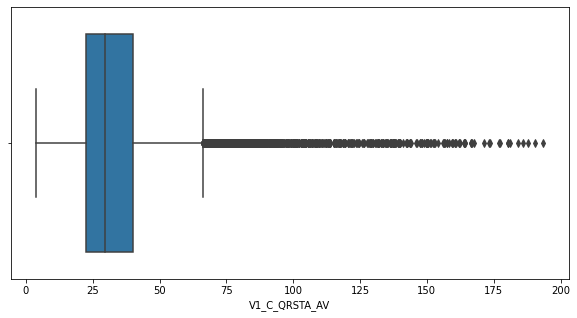

In [828]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSTA_AV", data=train)
pass

#### V2

In [829]:
chanel = 'V2'

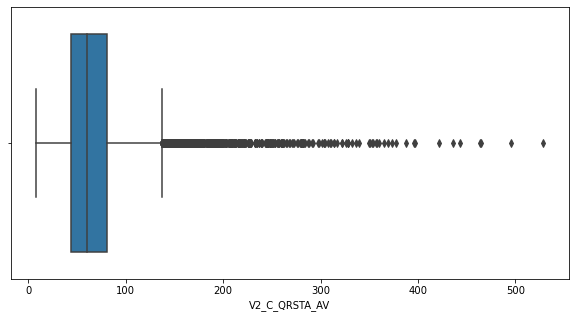

In [830]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSTA_AV', data=raw_data)
pass

In [831]:
raw_data[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      7.919750
0.005     15.834203
0.010     18.248285
0.050     27.313250
0.100     32.609409
0.500     59.768350
0.900    107.001214
0.950    128.561750
0.990    206.324777
0.995    248.691515
1.000    528.789214
Name: V2_C_QRSTA_AV, dtype: float64

In [832]:
rows_to_delete = train[
    (train[chanel + '_C_QRSTA_AV'] > 350)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      7.919750
0.005     15.802484
0.010     18.248250
0.050     27.244148
0.100     32.514950
0.500     59.357900
0.900    104.882295
0.950    124.916495
0.990    186.836752
0.995    216.062687
1.000    321.585125
Name: V2_C_QRSTA_AV, dtype: float64

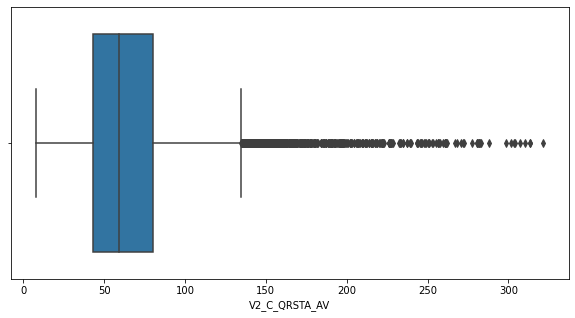

In [833]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSTA_AV", data=train)
pass

#### V3

In [834]:
chanel = 'V3'

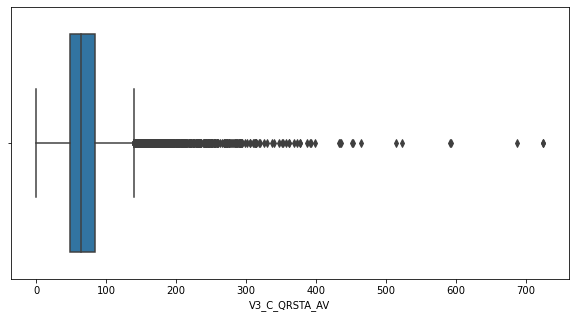

In [835]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSTA_AV', data=raw_data)
pass

In [836]:
raw_data[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005     19.044470
0.010     21.982050
0.050     31.327938
0.100     36.961214
0.500     63.821875
0.900    108.898188
0.950    131.189071
0.990    218.838647
0.995    258.365420
1.000    724.770437
Name: V3_C_QRSTA_AV, dtype: float64

In [837]:
rows_to_delete = train[
    (train[chanel + '_C_QRSTA_AV'] < 1) |
    (train[chanel + '_C_QRSTA_AV'] > 500)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      5.990727
0.005     19.044399
0.010     21.948543
0.050     31.190267
0.100     36.784229
0.500     63.357365
0.900    106.180771
0.950    125.644701
0.990    180.828231
0.995    214.583184
1.000    319.622115
Name: V3_C_QRSTA_AV, dtype: float64

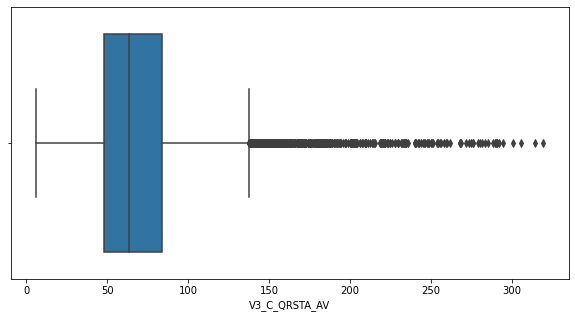

In [838]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSTA_AV", data=train)
pass

#### V4

In [839]:
chanel = 'V4'

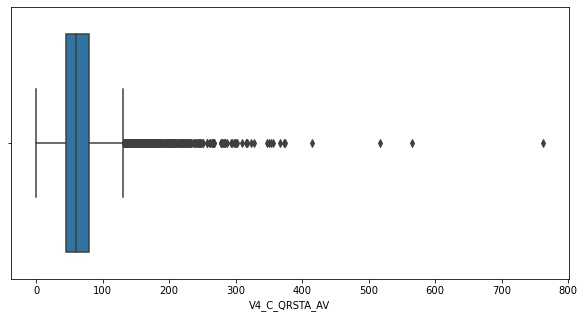

In [840]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSTA_AV', data=raw_data)
pass

In [841]:
raw_data[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005     16.359485
0.010     19.562543
0.050     29.122625
0.100     34.845607
0.500     60.167889
0.900    102.103923
0.950    120.277500
0.990    178.049625
0.995    219.316821
1.000    762.565278
Name: V4_C_QRSTA_AV, dtype: float64

In [842]:
rows_to_delete = train[
    (train[chanel + '_C_QRSTA_AV'] < 1) |
    (train[chanel + '_C_QRSTA_AV'] > 400)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      6.136423
0.005     16.340281
0.010     19.538312
0.050     29.024422
0.100     34.710725
0.500     59.764441
0.900     99.771052
0.950    114.827015
0.990    153.362863
0.995    168.680072
1.000    261.813188
Name: V4_C_QRSTA_AV, dtype: float64

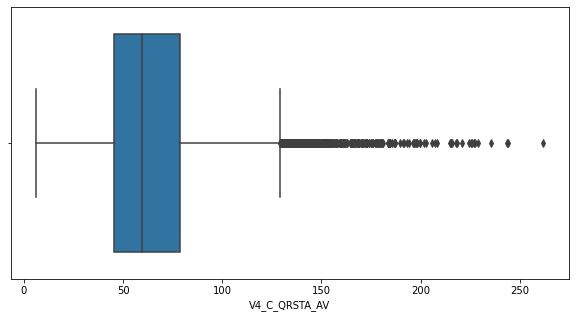

In [843]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSTA_AV", data=train)
pass

#### V5

In [844]:
chanel = 'V5'

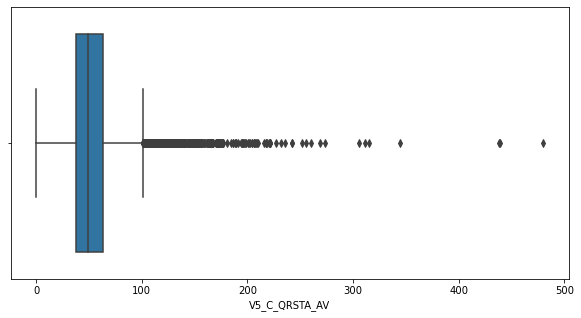

In [845]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSTA_AV', data=raw_data)
pass

In [846]:
raw_data[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005     13.991526
0.010     16.411920
0.050     24.658813
0.100     29.330727
0.500     48.705444
0.900     81.097000
0.950     94.714187
0.990    143.254490
0.995    165.617075
1.000    480.147889
Name: V5_C_QRSTA_AV, dtype: float64

In [847]:
rows_to_delete = train[
    (train[chanel + '_C_QRSTA_AV'] < 1) |
    (train[chanel + '_C_QRSTA_AV'] > 180)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      5.049812
0.005     14.027462
0.010     16.408653
0.050     24.611725
0.100     29.239579
0.500     48.385424
0.900     79.184515
0.950     91.428448
0.990    121.686057
0.995    133.578582
1.000    176.335125
Name: V5_C_QRSTA_AV, dtype: float64

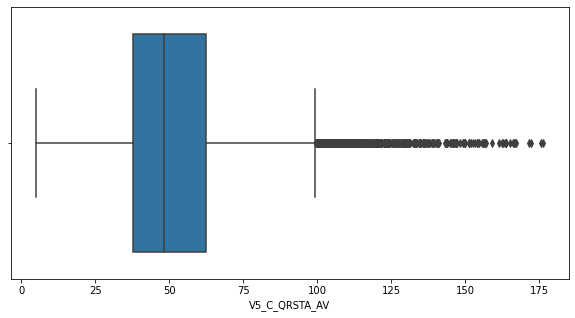

In [848]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSTA_AV", data=train)
pass

#### V6

In [849]:
chanel = 'V6'

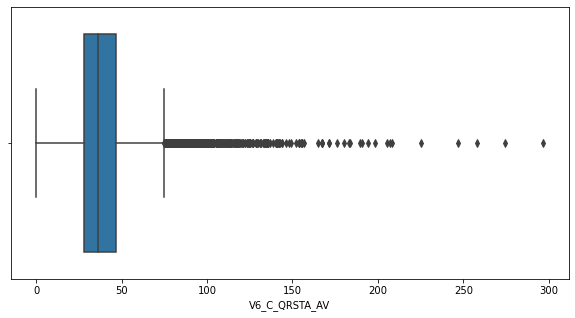

In [850]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + '_C_QRSTA_AV', data=raw_data)
pass

In [851]:
raw_data[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005     10.927316
0.010     12.534044
0.050     18.157800
0.100     21.522389
0.500     36.211444
0.900     60.341643
0.950     71.401150
0.990    102.287685
0.995    120.938529
1.000    296.739722
Name: V6_C_QRSTA_AV, dtype: float64

In [852]:
rows_to_delete = train[
    (train[chanel + '_C_QRSTA_AV'] < 1) |
    (train[chanel + '_C_QRSTA_AV'] > 140)
]
train = train.drop(rows_to_delete.index)
train[chanel + '_C_QRSTA_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      3.844250
0.005     10.968841
0.010     12.526283
0.050     18.127913
0.100     21.477245
0.500     35.985700
0.900     58.912613
0.950     68.464750
0.990     90.216420
0.995     99.598261
1.000    135.867100
Name: V6_C_QRSTA_AV, dtype: float64

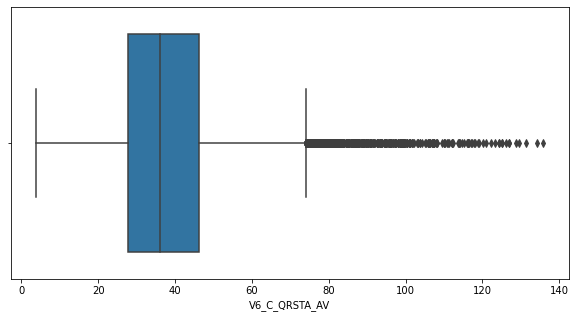

In [853]:
plt.figure(figsize=(10,5))
sns.boxplot(x=chanel + "_C_QRSTA_AV", data=train)
pass

### Диагнозы

Выкинем записи, у которых NORM и болезнь одновременно

In [854]:
rows_to_delete = train[(train['NORM'] == 1) & ((train['MI'] == 1) | (train['STTC'] == 1) | (train['CD'] == 1) | (train['HYP'] == 1))]
train = train.drop(rows_to_delete.index)
train[(train['NORM'] == 1) & ((train['MI'] == 1) | (train['STTC'] == 1) | (train['CD'] == 1) | (train['HYP'] == 1))]

Empty DataFrame
Columns: [SEX, AGE, HEIGHT, WEIGHT, ALL_C_HR, ALL_C_P_AV, ALL_C_P_DEV, ALL_C_P_A_AV, ALL_C_P_A_DEV, ALL_C_QRS_AV, ALL_C_QRS_DEV, ALL_C_QRS_A_AV, ALL_C_QRS_A_DEV, ALL_C_T_AV, ALL_C_T_DEV, ALL_C_T_A_AV, ALL_C_T_A_DEV, ALL_C_PR_INT_AV, ALL_C_PR_INT_DEV, ALL_C_PR_SEGM_AV, ALL_C_PR_SEGM_DEV, ALL_C_ST_SEGM_AV, ALL_C_ST_SEGM_DEV, ALL_C_QT_INT_AV, ALL_C_QT_INT_DEV, ALL_C_QRSA_AV, ALL_C_QRSA_DEV, ALL_C_QRSTA_AV, ALL_C_QRSTA_DEV, I_C_HR, I_C_P_AV, I_C_P_DEV, I_C_P_A_AV, I_C_P_A_DEV, I_C_QRS_AV, I_C_QRS_DEV, I_C_QRS_A_AV, I_C_QRS_A_DEV, I_C_T_AV, I_C_T_DEV, I_C_T_A_AV, I_C_T_A_DEV, I_C_PR_INT_AV, I_C_PR_INT_DEV, I_C_PR_SEGM_AV, I_C_PR_SEGM_DEV, I_C_ST_SEGM_AV, I_C_ST_SEGM_DEV, I_C_QT_INT_AV, I_C_QT_INT_DEV, I_C_QRSA_AV, I_C_QRSA_DEV, I_C_QRSTA_AV, I_C_QRSTA_DEV, II_C_HR, II_C_P_AV, II_C_P_DEV, II_C_P_A_AV, II_C_P_A_DEV, II_C_QRS_AV, II_C_QRS_DEV, II_C_QRS_A_AV, II_C_QRS_A_DEV, II_C_T_AV, II_C_T_DEV, II_C_T_A_AV, II_C_T_A_DEV, II_C_PR_INT_AV, II_C_PR_INT_DEV, II_C_PR_SEGM_AV, II_C_PR_SEGM_DEV, II_C_ST_SEGM_AV, II_C_ST_SEGM_DEV, II_C_QT_INT_AV, II_C_QT_INT_DEV, II_C_QRSA_AV, II_C_QRSA_DEV, II_C_QRSTA_AV, II_C_QRSTA_DEV, III_C_HR, III_C_P_AV, III_C_P_DEV, III_C_P_A_AV, III_C_P_A_DEV, III_C_QRS_AV, III_C_QRS_DEV, III_C_QRS_A_AV, III_C_QRS_A_DEV, III_C_T_AV, III_C_T_DEV, III_C_T_A_AV, III_C_T_A_DEV, III_C_PR_INT_AV, III_C_PR_INT_DEV, III_C_PR_SEGM_AV, III_C_PR_SEGM_DEV, III_C_ST_SEGM_AV, III_C_ST_SEGM_DEV, III_C_QT_INT_AV, III_C_QT_INT_DEV, ...]
Index: []

[0 rows x 340 columns]

И переведем диагнозы из числовых признаков в категориальные

In [856]:
train['NORM'] = train['NORM'].astype('category')
train['NORM']

ecg_id
1        1
2        1
3        1
4        1
5        1
        ..
21832    0
21833    0
21834    1
21835    0
21836    1
Name: NORM, Length: 16680, dtype: category
Categories (2, int64): [0, 1]

In [857]:
train['MI'] = train['MI'].astype('category')
train['MI']

ecg_id
1        0
2        0
3        0
4        0
5        0
        ..
21832    0
21833    0
21834    0
21835    0
21836    0
Name: MI, Length: 16680, dtype: category
Categories (2, int64): [0, 1]

In [859]:
train['STTC'] = train['STTC'].astype('category')
train['STTC']

ecg_id
1        0
2        0
3        0
4        0
5        0
        ..
21832    0
21833    1
21834    0
21835    1
21836    0
Name: STTC, Length: 16680, dtype: category
Categories (2, int64): [0, 1]

In [860]:
train['CD'] = train['CD'].astype('category')
train['CD']

ecg_id
1        0
2        0
3        0
4        0
5        0
        ..
21832    1
21833    0
21834    0
21835    0
21836    0
Name: CD, Length: 16680, dtype: category
Categories (2, int64): [0, 1]

In [861]:
train['HYP'] = train['HYP'].astype('category')
train['HYP']

ecg_id
1        0
2        0
3        0
4        0
5        0
        ..
21832    0
21833    0
21834    0
21835    0
21836    0
Name: HYP, Length: 16680, dtype: category
Categories (2, int64): [0, 1]

То же самое с test

In [862]:
test['NORM'] = test['NORM'].astype('category')
test['MI'] = test['MI'].astype('category')
test['STTC'] = test['STTC'].astype('category')
test['CD'] = test['CD'].astype('category')
test['HYP'] = test['HYP'].astype('category')

D:\Temp/ipykernel_7812/1951677856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['NORM'] = test['NORM'].astype('category')
D:\Temp/ipykernel_7812/1951677856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['MI'] = test['MI'].astype('category')
D:\Temp/ipykernel_7812/1951677856.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

### Проверка соотношений классов

Для начала сравним длину данных до и после

In [864]:
len(raw_data)

17441

In [865]:
len(train)

16680

In [866]:
raw_data['NORM'].value_counts() / len(raw_data['NORM']) * 100

0    56.384382
1    43.615618
Name: NORM, dtype: float64

In [867]:
train['NORM'].value_counts() / len(train['NORM']) * 100

0    56.738609
1    43.261391
Name: NORM, dtype: float64

In [868]:
raw_data['MI'].value_counts() / len(raw_data['MI']) * 100

0    74.835159
1    25.164841
Name: MI, dtype: float64

In [869]:
train['MI'].value_counts() / len(train['MI']) * 100

0    74.094724
1    25.905276
Name: MI, dtype: float64

In [870]:
raw_data['STTC'].value_counts() / len(raw_data['STTC']) * 100

0    75.958947
1    24.041053
Name: STTC, dtype: float64

In [871]:
train['STTC'].value_counts() / len(train['STTC']) * 100

0    75.44964
1    24.55036
Name: STTC, dtype: float64

In [872]:
raw_data['CD'].value_counts() / len(raw_data['CD']) * 100

0    77.570093
1    22.429907
Name: CD, dtype: float64

In [873]:
train['CD'].value_counts() / len(train['CD']) * 100

0    79.256595
1    20.743405
Name: CD, dtype: float64

In [874]:
raw_data['HYP'].value_counts() / len(raw_data['HYP']) * 100

0    87.839
1    12.161
Name: HYP, dtype: float64

In [875]:
train['HYP'].value_counts() / len(train['HYP']) * 100

0    87.679856
1    12.320144
Name: HYP, dtype: float64

Вцелом изменения по разбросу классов не такие уж и значительные, так что оставим. Сохраняем новые данные для дальнейшей работы

In [876]:
train = train.drop(columns='strat_fold')

In [877]:
train.to_csv('proceed_data/train_data_without_outliers_(by_hands_17k).csv', index_label='ecg_id')

In [878]:
test = test.drop(columns='strat_fold')

In [879]:
test.to_csv('proceed_data/test_data.csv', index_label='ecg_id')

## Визуализация и описательная статистика

Загрузим данные для дальнейшей работы

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('proceed_data/train_data_without_outliers_(by_hands_17k).csv', index_col='ecg_id')
test = pd.read_csv('proceed_data/test_data.csv', index_col='ecg_id')

In [3]:
train

SEX   AGE  HEIGHT  WEIGHT    ALL_C_HR  ALL_C_P_AV  ALL_C_P_DEV  \
ecg_id                                                                   
1         1  56.0     NaN    63.0   64.285714   85.822486    13.723358   
2         0  19.0     NaN    70.0   50.000000   99.884232    14.285270   
3         1  37.0     NaN    69.0   64.285714   84.770629    14.288110   
4         0  24.0     NaN    82.0   71.428571   98.118811    12.934339   
5         1  19.0     NaN    70.0   64.285714   84.978840    18.432303   
...     ...   ...     ...     ...         ...         ...          ...   
21832     0  63.0     NaN     NaN   92.857143   76.231377    15.294036   
21833     1  67.0     NaN     NaN  106.547619   82.844393    20.259615   
21834     0  93.0     NaN     NaN   71.428571   96.489328    14.765017   
21835     1  59.0     NaN     NaN   57.142857   86.321534    16.301733   
21836     1  64.0     NaN     NaN   71.428571   95.877210    20.019846   

        ALL_C_P_A_AV  ALL_C_P_A_DEV  ALL_C_QRS_AV  ...  NORM  MI  STTC  CD  \
ecg_id                                             ...                       
1           0.099592       0.039531     80.787899  ...     1   0     0   0   
2           0.103884       0.045679     80.562009  ...     1   0     0   0   
3           0.092468       0.033932     81.079148  ...     1   0     0   0   
4           0.114916       0.053732     91.991404  ...     1   0     0   0   
5           0.085087       0.039234     86.053833  ...     1   0     0   0   
...              ...            ...           ...  ...   ...  ..   ...  ..   
21832       0.085463       0.022969    125.525876  ...     0   0     0   1   
21833       0.156817       0.046160     91.035623  ...     0   0     1   0   
21834       0.096575       0.021105     87.413529  ...     1   0     0   0   
21835       0.087441       0.044820     88.672222  ...     0   0     1   0   
21836       0.115745       0.042513     83.971282  ...     1   0     0   0   

        HYP  NORM_PROB  MI_PROB  STTC_PROB  CD_PROB  HYP_PROB  
ecg_id                                                         
1         0        100        0          0        0         0  
2         0         80        0          0        0         0  
3         0        100        0          0        0         0  
4         0        100        0          0        0         0  
5         0        100        0          0        0         0  
...     ...        ...      ...        ...      ...       ...  
21832     0          0        0          0      100         0  
21833     0          0        0        100        0         0  
21834     0        100        0          0        0         0  
21835     0          0        0         50        0         0  
21836     0        100        0          0        0         0  

[16680 rows x 339 columns]

In [4]:
train.describe()

SEX           AGE       HEIGHT       WEIGHT      ALL_C_HR  \
count  16680.000000  16621.000000  5286.000000  6938.000000  16680.000000   
mean       0.481235     59.585885   166.673477    70.730614     73.188699   
std        0.499663     16.793362    10.256635    15.847076     16.767186   
min        0.000000      2.000000    85.000000    12.000000     28.571429   
25%        0.000000     50.000000   160.000000    60.000000     64.285714   
50%        0.000000     61.000000   166.000000    70.000000     71.428571   
75%        1.000000     72.000000   174.000000    80.000000     79.166667   
max        1.000000     95.000000   209.000000   210.000000    181.547619   

         ALL_C_P_AV   ALL_C_P_DEV  ALL_C_P_A_AV  ALL_C_P_A_DEV  ALL_C_QRS_AV  \
count  16680.000000  16680.000000  16680.000000   16680.000000  16680.000000   
mean      88.563532     15.806865      0.090312       0.035733     91.134345   
std       16.826378      5.022924      0.029324       0.013197     13.537604   
min        0.000000      0.000000      0.000000       0.000000     63.666897   
25%       82.669162     12.635499      0.072741       0.027617     83.333045   
50%       91.584321     15.361402      0.088587       0.034101     87.777241   
75%       98.762038     18.765962      0.106877       0.042336     93.851472   
max      129.005983     43.473538      0.258667       0.218687    187.854581   

       ...          NORM            MI          STTC            CD  \
count  ...  16680.000000  16680.000000  16680.000000  16680.000000   
mean   ...      0.432614      0.259053      0.245504      0.207434   
std    ...      0.495453      0.438128      0.430398      0.405481   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      1.000000      1.000000      0.000000      0.000000   
max    ...      1.000000      1.000000      1.000000      1.000000   

                HYP     NORM_PROB       MI_PROB     STTC_PROB       CD_PROB  \
count  16680.000000  16680.000000  16680.000000  16680.000000  16680.000000   
mean       0.123201     40.584832     17.177098     22.325839     20.536871   
std        0.328678     47.298961     34.421828     40.809193     40.260980   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000    100.000000     15.000000      0.000000      0.000000   
max        1.000000    100.000000    100.000000    100.000000    100.000000   

           HYP_PROB  
count  16680.000000  
mean       9.247602  
std       26.813232  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max      100.000000  

[8 rows x 339 columns]

Выше все квартили по каждому признаку уже были рассмотрены, поэтому рассматривать их еще раз нет смысла.

В принципе с точки зрения интерпретации интерес представляют первые признаки - пол, возраст, рост, вес, пульс по всем каналам и волновые характеристики по всем каналам. Для наглядности приведу картинку с ЭКГ

<img src="imgs/PQRST.png" alt="drawing" width="800">

### Диграммы рассеивания

Построим диграмму рассеивания между пульсом и возрастом, раскрасив точки по полу

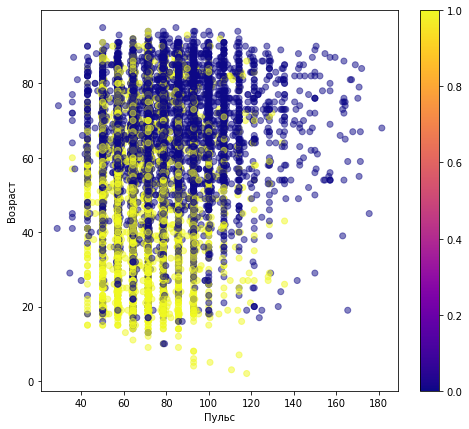

In [5]:
from matplotlib import pyplot as plt
from matplotlib import colors

plt.figure(figsize=(8, 7))
plt.xlabel('Пульс')
plt.ylabel('Возраст')
plt.colorbar(plt.cm.ScalarMappable(norm=None, cmap=plt.get_cmap('plasma')))
plt.scatter(train['ALL_C_HR'], train['AGE'], c=train['NORM'], cmap='plasma', alpha=0.5)
pass

Видно, что значения пульса близки к дискретным. Это связано с малым временем измерения - 10 секунд. Высокий пульс у детей - это нормально.

Посмотрим на рост и вес

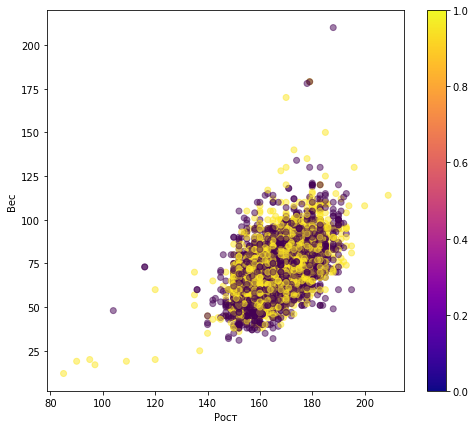

In [6]:
plt.figure(figsize=(8, 7))
plt.xlabel('Рост')
plt.ylabel('Вес')
plt.colorbar(plt.cm.ScalarMappable(norm=None, cmap=plt.get_cmap('plasma')))
plt.scatter(train['HEIGHT'], train['WEIGHT'], c=train['NORM'], alpha=0.5)
pass

Распределение болезней не слишком зависит от веса и роста

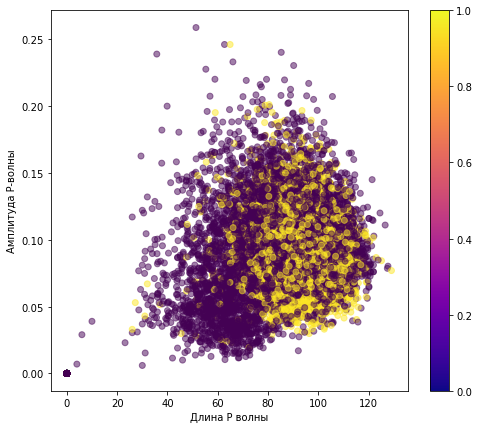

In [7]:
plt.figure(figsize=(8, 7))
plt.xlabel('Длина P волны')
plt.ylabel('Амплитуда P-волны')
plt.colorbar(plt.cm.ScalarMappable(norm=None, cmap=plt.get_cmap('plasma')))
plt.scatter(train['ALL_C_P_AV'], train['ALL_C_P_A_AV'], c=train['NORM'], alpha=0.5)
pass

Здесь уже видно явное смещение больных случаев в сторону уменьшения как длины P-волны, так и ее амплитуды. Посмотрим на другие волны

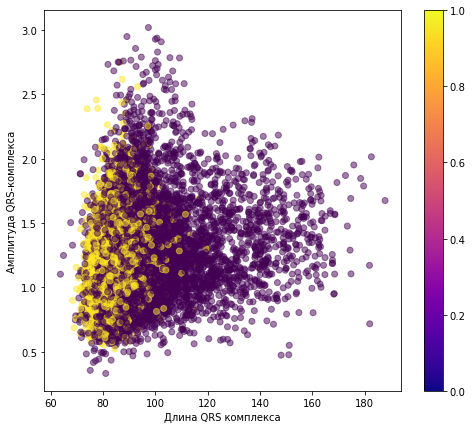

In [8]:
plt.figure(figsize=(8, 7))
plt.xlabel('Длина QRS комплекса')
plt.ylabel('Амплитуда QRS-комплекса')
plt.colorbar(plt.cm.ScalarMappable(norm=None, cmap=plt.get_cmap('plasma')))
plt.scatter(train['ALL_C_QRS_AV'], train['ALL_C_QRS_A_AV'], c=train['NORM'], alpha=0.5)
pass

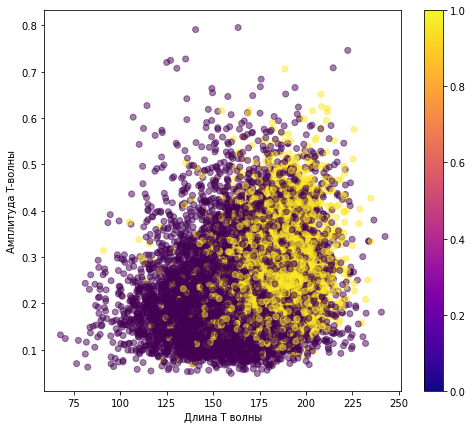

In [9]:
plt.figure(figsize=(8, 7))
plt.xlabel('Длина T волны')
plt.ylabel('Амплитуда T-волны')
plt.colorbar(plt.cm.ScalarMappable(norm=None, cmap=plt.get_cmap('plasma')))
plt.scatter(train['ALL_C_T_AV'], train['ALL_C_T_A_AV'], c=train['NORM'], alpha=0.5)
pass

Вцелом картина примерно та же - по диаграммам уже можно сказать о существовании возможности предсказания классов.

### Избавление от корреляций

Зачем вообще бороться с корреляциями? Дело в том, что если у нас будут признаки, имеющие сильную линейную зависимость, и при этом отображающие одну закономерность, то линейные модели на таких данных будут сильно искажаться в сторону этих признаков, игнорируя другие возможные закономерности в данных. Поэтому лучше из двух и более таких признаков оставить один.

Построим матрицу корреляций. Для удобства заполним главную диагональ нулями.

In [10]:
import numpy as np

corr_mat = train.corr()
zero_diag_data = corr_mat.values
np.fill_diagonal(zero_diag_data, 0)
corr_mat = pd.DataFrame(zero_diag_data, index=corr_mat.index, columns=corr_mat.columns)
corr_mat

SEX       AGE    HEIGHT    WEIGHT  ALL_C_HR  ALL_C_P_AV  \
SEX        0.000000  0.051713 -0.606469 -0.442654  0.092394   -0.082606   
AGE        0.051713  0.000000 -0.153100 -0.089606  0.124493   -0.182831   
HEIGHT    -0.606469 -0.153100  0.000000  0.559617 -0.086416    0.079574   
WEIGHT    -0.442654 -0.089606  0.559617  0.000000 -0.095235    0.185738   
ALL_C_HR   0.092394  0.124493 -0.086416 -0.095235  0.000000   -0.559468   
...             ...       ...       ...       ...       ...         ...   
NORM_PROB  0.143120 -0.387145  0.007722  0.006623 -0.191392    0.205715   
MI_PROB   -0.134385  0.187197  0.000263 -0.018469  0.055185   -0.040273   
STTC_PROB  0.010219  0.207014 -0.061766 -0.033474  0.137928   -0.142741   
CD_PROB   -0.117082  0.206895  0.034780 -0.014226  0.087350   -0.141608   
HYP_PROB  -0.044485  0.133411 -0.031172 -0.060303  0.081467   -0.050624   

           ALL_C_P_DEV  ALL_C_P_A_AV  ALL_C_P_A_DEV  ALL_C_QRS_AV  ...  \
SEX          -0.061151      0.069020       0.088407     -0.190122  ...   
AGE           0.195746      0.076122       0.046858      0.184603  ...   
HEIGHT        0.033893     -0.126928      -0.109718      0.098194  ...   
WEIGHT        0.045133     -0.051370      -0.097876      0.084449  ...   
ALL_C_HR     -0.140480      0.033080      -0.034238     -0.047232  ...   
...                ...           ...            ...           ...  ...   
NORM_PROB    -0.121591     -0.030355       0.015621     -0.359802  ...   
MI_PROB       0.073974      0.030241       0.006009      0.146045  ...   
STTC_PROB     0.046131     -0.018384      -0.021418      0.006638  ...   
CD_PROB       0.132567      0.065227       0.020416      0.544504  ...   
HYP_PROB      0.093613      0.114334       0.079794      0.164592  ...   

               NORM        MI      STTC        CD       HYP  NORM_PROB  \
SEX        0.141536 -0.144172  0.020169 -0.116616 -0.043421   0.143120   
AGE       -0.381520  0.216870  0.227523  0.206387  0.140236  -0.387145   
HEIGHT     0.011943 -0.005434 -0.060840  0.034284 -0.019995   0.007722   
WEIGHT     0.010343 -0.001123 -0.049354 -0.014218 -0.040531   0.006623   
ALL_C_HR  -0.192178  0.065655  0.162477  0.086993  0.066683  -0.191392   
...             ...       ...       ...       ...       ...        ...   
NORM_PROB  0.982685 -0.507371 -0.489469 -0.438983 -0.321650   0.000000   
MI_PROB   -0.435752  0.843973  0.008518  0.151361  0.051569  -0.428207   
STTC_PROB -0.477720 -0.017152  0.959097 -0.018542  0.277965  -0.469449   
CD_PROB   -0.445424  0.170849 -0.003939  0.997104  0.076329  -0.437712   
HYP_PROB  -0.301165  0.058111  0.306476  0.093242  0.920100  -0.295950   

            MI_PROB  STTC_PROB   CD_PROB  HYP_PROB  
SEX       -0.134385   0.010219 -0.117082 -0.044485  
AGE        0.187197   0.207014  0.206895  0.133411  
HEIGHT     0.000263  -0.061766  0.034780 -0.031172  
WEIGHT    -0.018469  -0.033474 -0.014226 -0.060303  
ALL_C_HR   0.055185   0.137928  0.087350  0.081467  
...             ...        ...       ...       ...  
NORM_PROB -0.428207  -0.469449 -0.437712 -0.295950  
MI_PROB    0.000000  -0.002174  0.151532  0.068905  
STTC_PROB -0.002174   0.000000 -0.016743  0.303629  
CD_PROB    0.151532  -0.016743  0.000000  0.095079  
HYP_PROB   0.068905   0.303629  0.095079  0.000000  

[339 rows x 339 columns]

<AxesSubplot:>

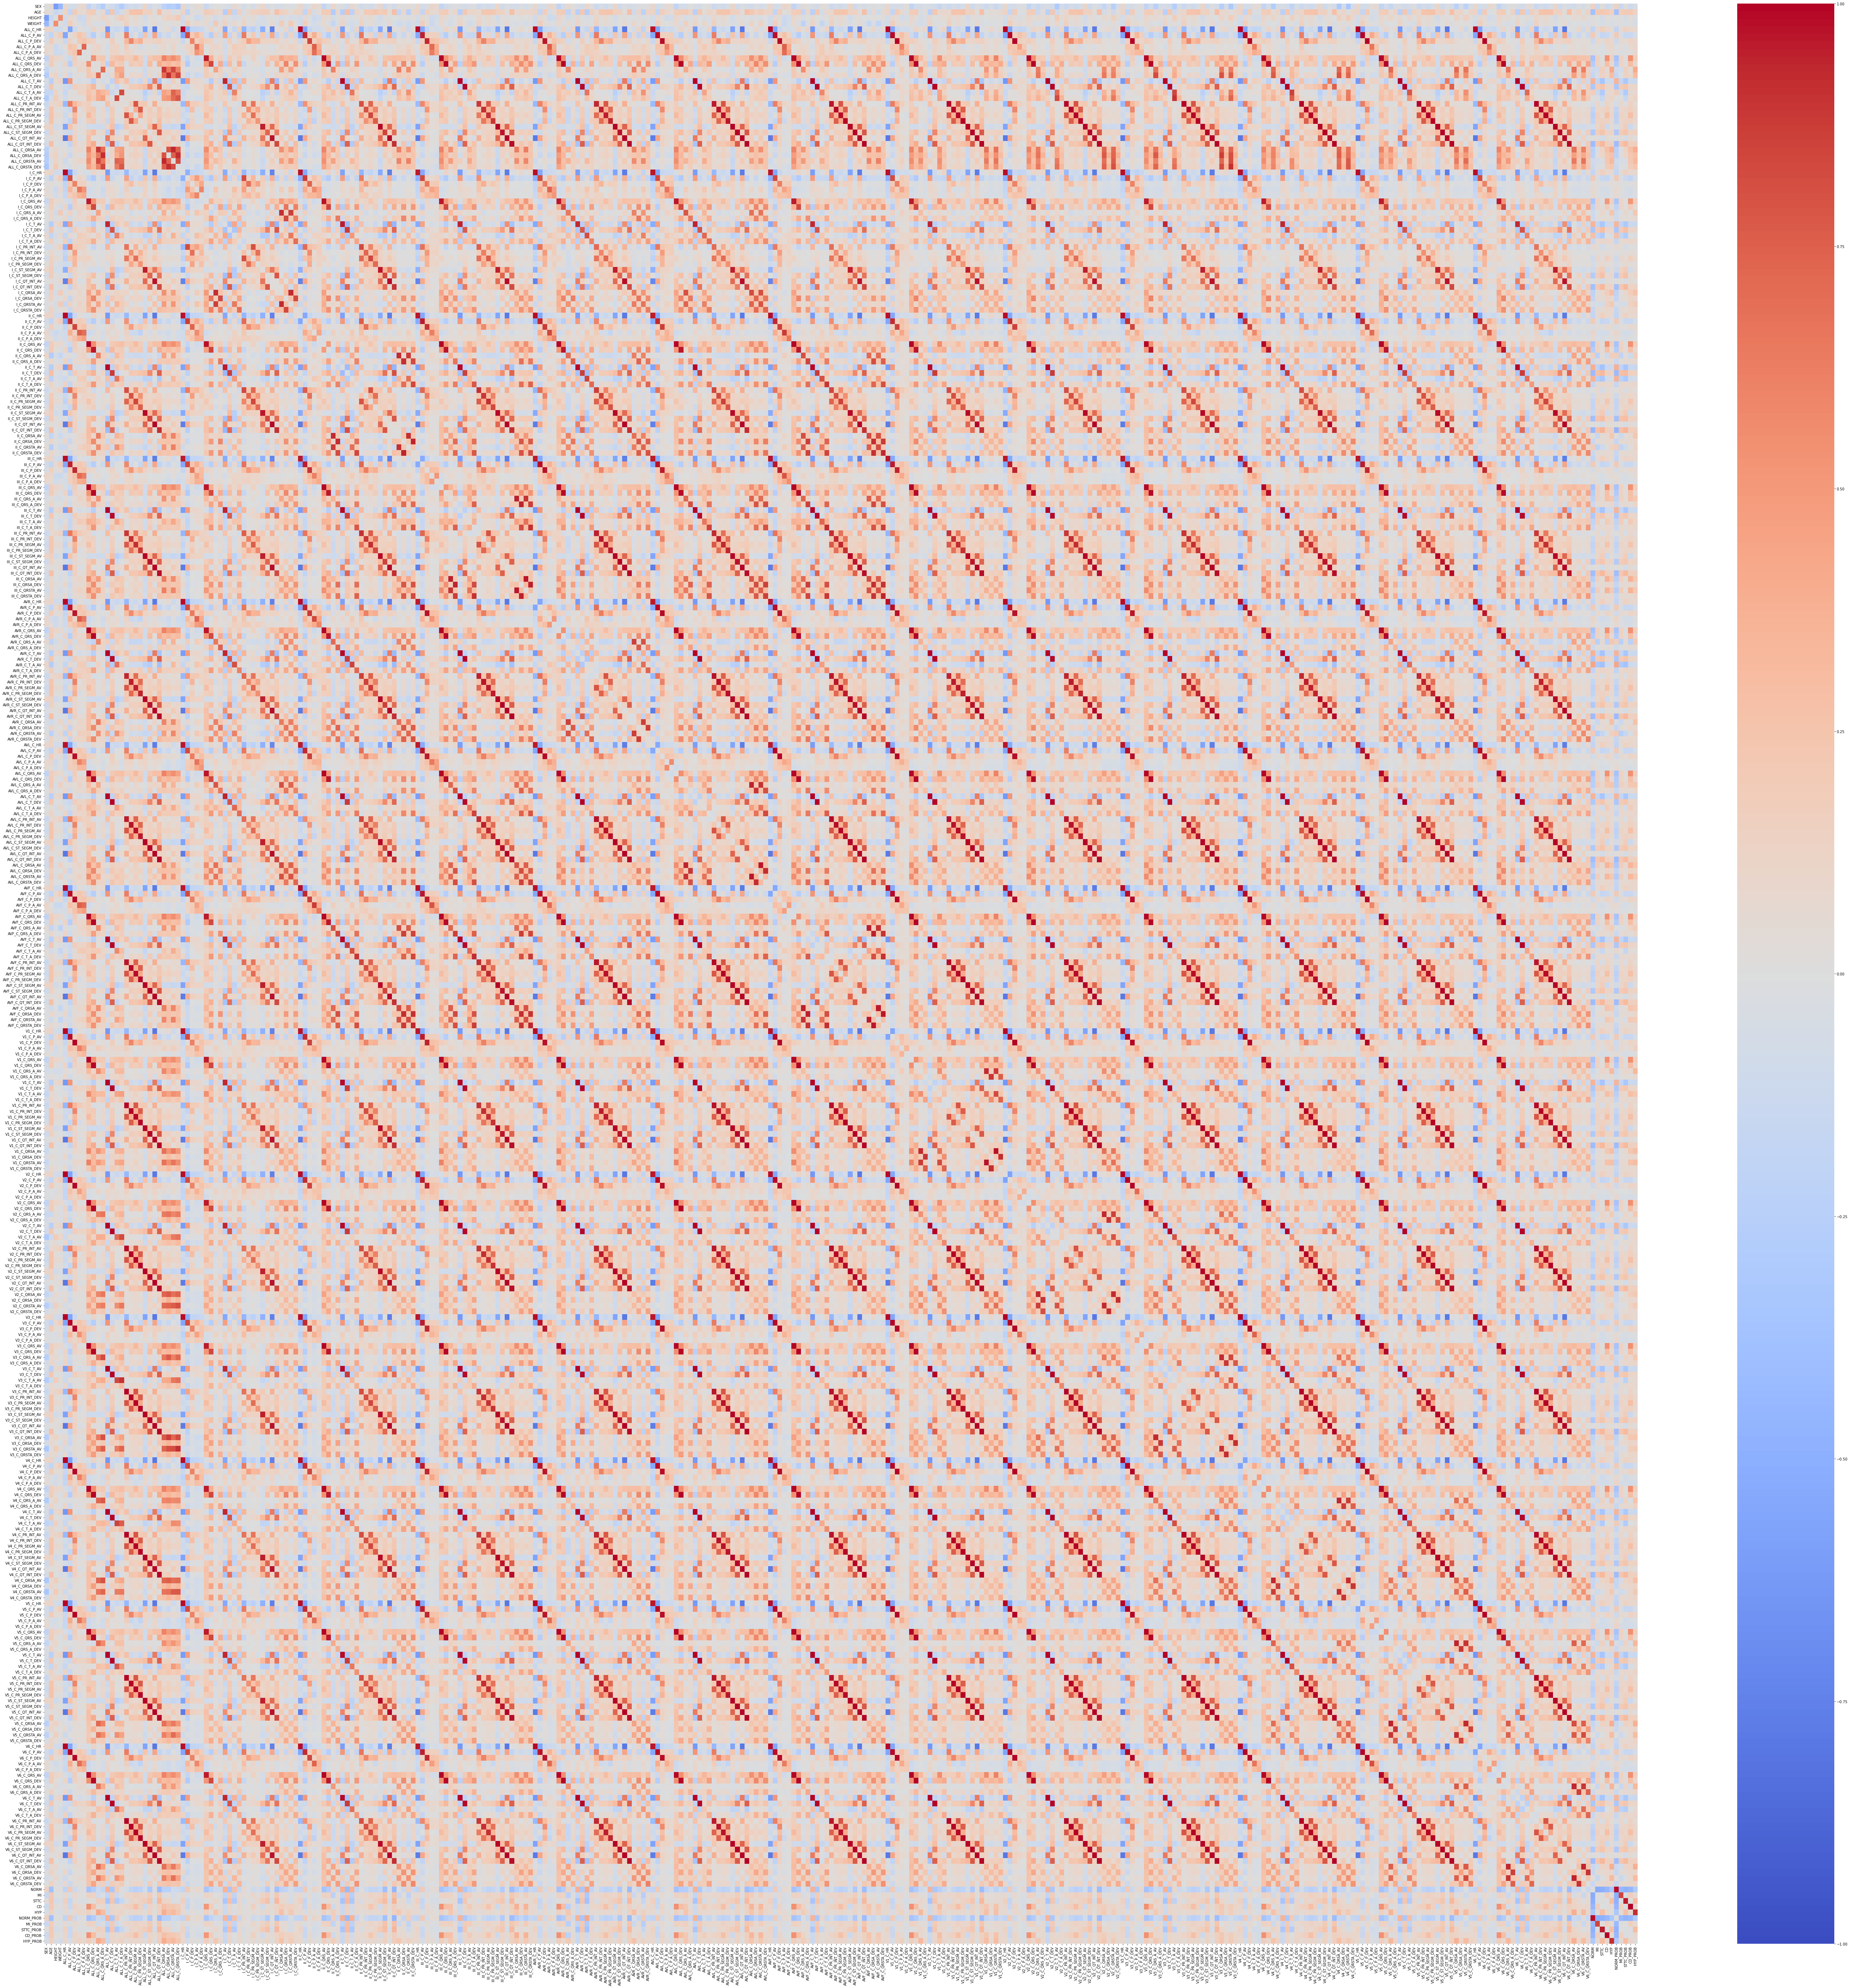

In [11]:
import seaborn as sns

raw_corr_mat = corr_mat.copy()
plt.figure(figsize=(100, 100))
sns.heatmap(corr_mat, cmap='coolwarm', vmin=-1, vmax=1)

Естественно, учитывая количество признаков, матрица получилась просто огромной. Поэтому будем рассматривать ее по частям. В первую очередь необходимо посмотреть на куски матрицы вот такого вида:

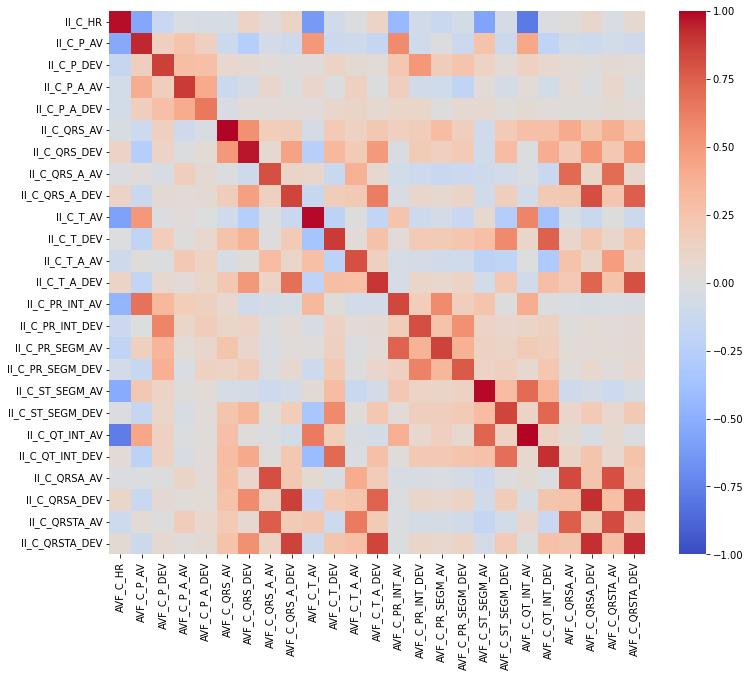

In [12]:
show_mat = corr_mat.loc['II_C_HR':'II_C_QRSTA_DEV', 'AVF_C_HR':'AVF_C_QRSTA_DEV']
plt.figure(figsize=(12, 10))
sns.heatmap(show_mat, cmap='coolwarm', vmin=-1, vmax=1)
pass

Как можно увидеть выше, вся матрица состоит из таких параллельных диагональных полос. Это связано с тем, что одни и те же признаки выделялись с разных отведений ЭКГ, а потому они очень похожи друг на друга. Не хочется просто брать и оставлять лишь среднее со всех каналов, ведь вполне возможно, что важная информация с конкретного канала затеряется. Поэтому поступим следующим образом: оставим признаки по всем каналам (с припиской ALL_C) и удалим наиболее коррелирующие с ними. После этого будем избавляться от корреляции между отдельными каналами.

In [13]:
import numpy as np

ALL_corr = corr_mat.loc['I_C_HR':'V6_C_QRSTA_DEV', 'ALL_C_HR':'ALL_C_QRSTA_DEV']
threshold = 0.75
features_to_del = []
pd.DataFrame.columns
for i, idx in enumerate(ALL_corr.index):
    # здесь % потому что мы идем по всем этим диагоналям, находя корреляции больше threshold
    if np.abs(ALL_corr.iat[i, i % len(ALL_corr.columns)]) > threshold:
        features_to_del.append(idx)
print(features_to_del)

['I_C_HR', 'I_C_P_AV', 'I_C_QRS_AV', 'I_C_QRS_DEV', 'I_C_T_AV', 'I_C_T_DEV', 'I_C_ST_SEGM_AV', 'I_C_QT_INT_AV', 'I_C_QT_INT_DEV', 'II_C_HR', 'II_C_P_AV', 'II_C_P_DEV', 'II_C_P_A_AV', 'II_C_QRS_AV', 'II_C_QRS_DEV', 'II_C_T_AV', 'II_C_T_DEV', 'II_C_PR_INT_AV', 'II_C_PR_INT_DEV', 'II_C_PR_SEGM_AV', 'II_C_PR_SEGM_DEV', 'II_C_ST_SEGM_AV', 'II_C_ST_SEGM_DEV', 'II_C_QT_INT_AV', 'II_C_QT_INT_DEV', 'III_C_HR', 'III_C_P_AV', 'III_C_P_DEV', 'III_C_QRS_AV', 'III_C_QRS_DEV', 'III_C_T_AV', 'III_C_T_DEV', 'III_C_PR_INT_AV', 'III_C_PR_INT_DEV', 'III_C_PR_SEGM_AV', 'III_C_PR_SEGM_DEV', 'III_C_ST_SEGM_AV', 'III_C_ST_SEGM_DEV', 'III_C_QT_INT_AV', 'III_C_QT_INT_DEV', 'AVR_C_HR', 'AVR_C_P_AV', 'AVR_C_P_DEV', 'AVR_C_P_A_AV', 'AVR_C_QRS_AV', 'AVR_C_QRS_DEV', 'AVR_C_T_AV', 'AVR_C_T_DEV', 'AVR_C_PR_INT_AV', 'AVR_C_PR_INT_DEV', 'AVR_C_PR_SEGM_AV', 'AVR_C_PR_SEGM_DEV', 'AVR_C_ST_SEGM_AV', 'AVR_C_ST_SEGM_DEV', 'AVR_C_QT_INT_AV', 'AVR_C_QT_INT_DEV', 'AVL_C_HR', 'AVL_C_P_AV', 'AVL_C_P_DEV', 'AVL_C_QRS_AV', 'AVL_C_Q

Сразу же отлетает много признаков, но их нельзя оставлять - 75 процентов это сильная корреляция, которая может в дальнейшем помешать

In [14]:
ALL_corr = ALL_corr.drop(features_to_del)

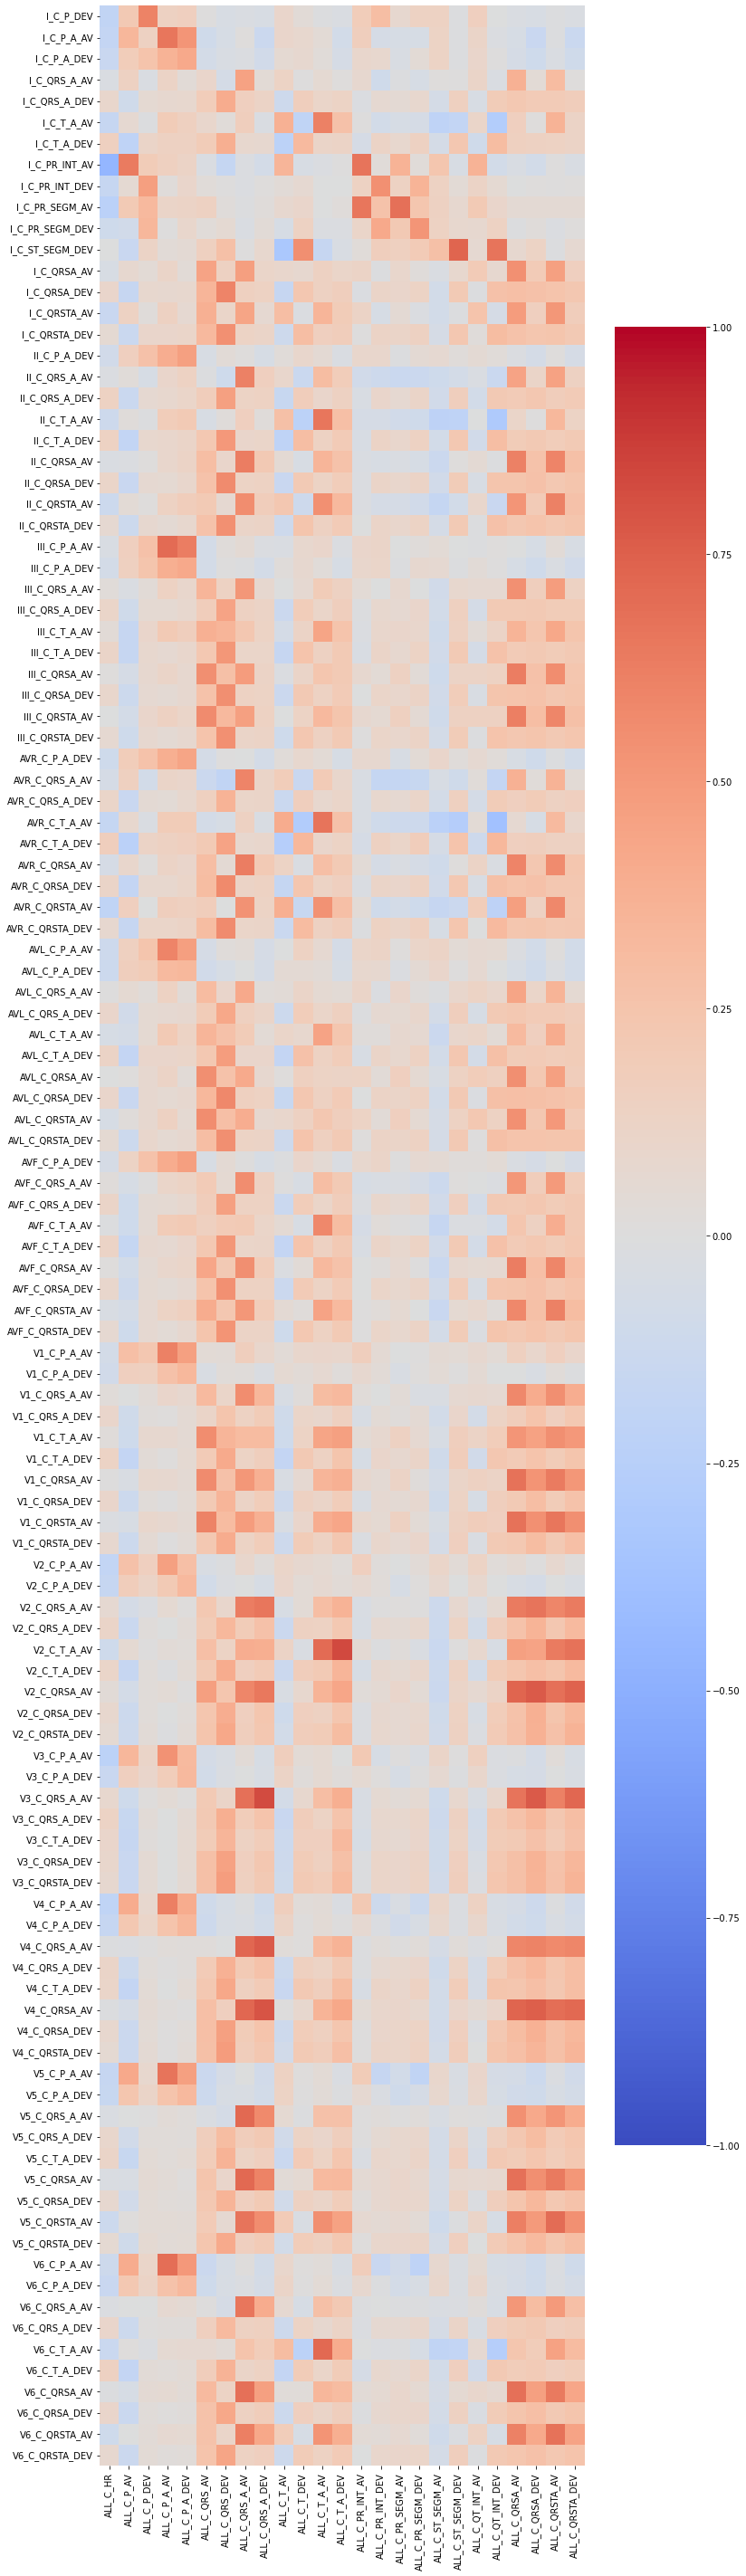

In [15]:
plt.figure(figsize=(12, 50))
sns.heatmap(ALL_corr, cmap='coolwarm', vmin=-1, vmax=1)
pass

Избавились от этих неприятных диагональных полос

In [16]:
corr_mat = corr_mat.drop(features_to_del, axis=0)
corr_mat = corr_mat.drop(features_to_del, axis=1)

Рассмотрим кусок матрицы корреляции каналов AVF и II

In [18]:
show_mat = corr_mat.loc['AVF_C_QRS_A_AV':'AVF_C_QRSTA_DEV', 'II_C_QRS_A_AV':'II_C_QRSTA_DEV']

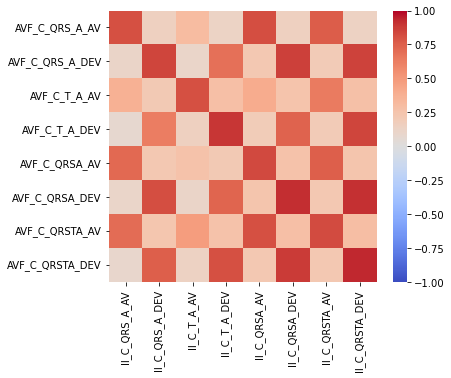

In [19]:
plt.figure(figsize=(6, 5))
sns.heatmap(show_mat, cmap='coolwarm', vmin=-1, vmax=1)
pass

Опять же удалим диагональные полосы

In [20]:
import numpy as np

features_to_del = []
for i, idx in enumerate(show_mat.index):
    if np.abs(show_mat.iat[i, i]) > threshold:
        features_to_del.append(idx)
print(features_to_del)

['AVF_C_QRS_A_AV', 'AVF_C_QRS_A_DEV', 'AVF_C_T_A_AV', 'AVF_C_T_A_DEV', 'AVF_C_QRSA_AV', 'AVF_C_QRSA_DEV', 'AVF_C_QRSTA_AV', 'AVF_C_QRSTA_DEV']


In [21]:
show_mat = show_mat.drop(features_to_del)
len(show_mat)

0

Похоже, придется просто убрать весь канал

In [22]:
corr_mat = corr_mat.drop(features_to_del, axis=0)
corr_mat = corr_mat.drop(features_to_del, axis=1)

Посмотрим на еще один плохо выглядящий кусочек с диагоналями

In [24]:
show_mat = corr_mat.loc['AVR_C_P_A_DEV':'AVL_C_QRSTA_DEV', 'II_C_P_A_DEV':'III_C_QRSTA_DEV']

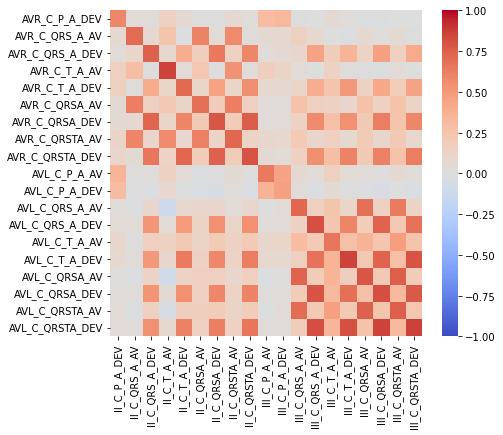

In [25]:
plt.figure(figsize=(7, 6))
sns.heatmap(show_mat, cmap='coolwarm', vmin=-1, vmax=1)
pass

Удалим диагональ

In [26]:
import numpy as np

features_to_del = []
for i, idx in enumerate(show_mat.index):
    if np.abs(show_mat.iat[i, i]) > threshold:
        features_to_del.append(idx)
print(features_to_del)

['AVR_C_T_A_AV', 'AVR_C_QRSA_DEV', 'AVR_C_QRSTA_DEV', 'AVL_C_QRS_A_DEV', 'AVL_C_T_A_DEV', 'AVL_C_QRSA_AV', 'AVL_C_QRSA_DEV', 'AVL_C_QRSTA_AV', 'AVL_C_QRSTA_DEV']


In [27]:
show_mat = show_mat.drop(features_to_del)

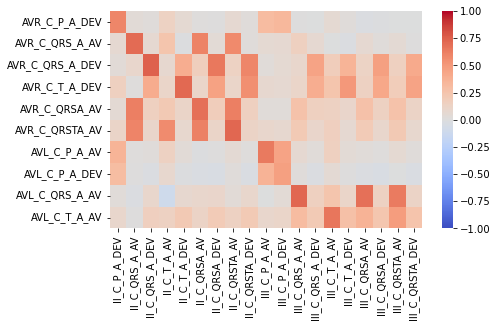

In [28]:
plt.figure(figsize=(7, 4))
sns.heatmap(show_mat, cmap='coolwarm', vmin=-1, vmax=1)
pass

In [29]:
corr_mat = corr_mat.drop(features_to_del, axis=0)
corr_mat = corr_mat.drop(features_to_del, axis=1)

С множеством диагональных полос разобрались, теперь займемся корреляциями рядом с главной диагональю. Для начала посмотрим на неволновые признаки - пол, рост, вес, возраст.

In [31]:
show_mat = corr_mat.loc['SEX':'WEIGHT', 'SEX':'WEIGHT']

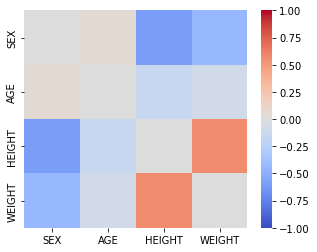

In [32]:
plt.figure(figsize=(5, 4))
sns.heatmap(show_mat, cmap='coolwarm', vmin=-1, vmax=1)
pass

В целом корреляция небольшая, по-крайней мере не настолько, чтобы просто отказываться от одного из этих важных признаков. Спустимся ниже.

In [33]:
show_mat = corr_mat.loc['ALL_C_HR':'ALL_C_QRSTA_DEV', 'ALL_C_HR':'ALL_C_QRSTA_DEV']

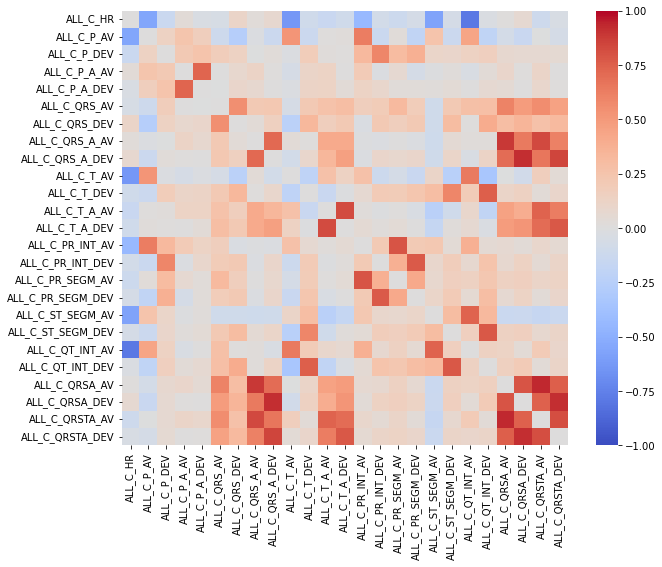

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(show_mat, cmap='coolwarm', vmin=-1, vmax=1)
pass

In [35]:
import numpy as np

features_to_del = []

for i, idx in enumerate(show_mat.index):
    for j in range(i):
        if (np.abs(show_mat.iat[i, j]) > threshold):
            if idx not in features_to_del:
                features_to_del.append(idx)
print(features_to_del)

['ALL_C_T_A_DEV', 'ALL_C_PR_SEGM_AV', 'ALL_C_PR_SEGM_DEV', 'ALL_C_QT_INT_AV', 'ALL_C_QT_INT_DEV', 'ALL_C_QRSA_AV', 'ALL_C_QRSA_DEV', 'ALL_C_QRSTA_AV', 'ALL_C_QRSTA_DEV']


Судя по матрице, здесь наблюдается естественная корреляция между связанными характеристиками - пульс считается через число QRS комплексов, QRSA и QRST площади считаются через QRS и T амплитуды, а значит можно спокойно их удалить

In [36]:
show_mat = show_mat.drop(features_to_del, axis=0)
show_mat = show_mat.drop(features_to_del, axis=1)

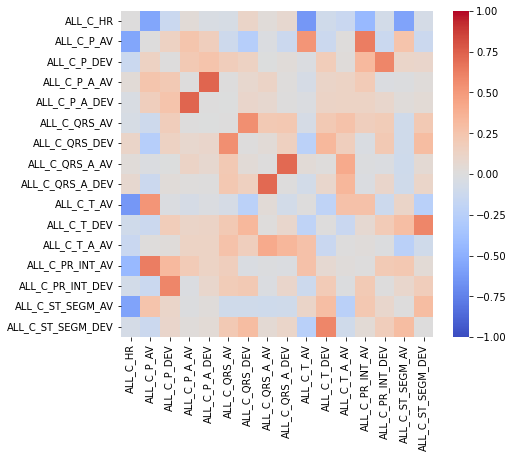

In [37]:
plt.figure(figsize=(7, 6))
sns.heatmap(show_mat, cmap='coolwarm', vmin=-1, vmax=1)
pass

In [38]:
corr_mat = corr_mat.drop(features_to_del, axis=0)
corr_mat = corr_mat.drop(features_to_del, axis=1)

Ну а дальше можно просто убрать все, что больше 0.75

In [40]:
show_mat = corr_mat.loc['ALL_C_HR':'V6_C_QRSTA_DEV', 'ALL_C_HR':'V6_C_QRSTA_DEV']

In [41]:
import numpy as np

features_to_del = []

for i, idx in enumerate(show_mat.index):
    for j in range(i):
        if (np.abs(show_mat.iat[i, j]) > threshold):
            if idx not in features_to_del:
                features_to_del.append(idx)
print(features_to_del)

['I_C_PR_SEGM_AV', 'I_C_QRSA_AV', 'I_C_QRSA_DEV', 'I_C_QRSTA_AV', 'I_C_QRSTA_DEV', 'II_C_QRSA_AV', 'II_C_QRSA_DEV', 'II_C_QRSTA_AV', 'II_C_QRSTA_DEV', 'III_C_T_A_DEV', 'III_C_QRSA_AV', 'III_C_QRSA_DEV', 'III_C_QRSTA_AV', 'III_C_QRSTA_DEV', 'AVR_C_QRSA_AV', 'AVR_C_QRSTA_AV', 'AVL_C_QRS_A_AV', 'V1_C_QRSA_AV', 'V1_C_QRSA_DEV', 'V1_C_QRSTA_AV', 'V1_C_QRSTA_DEV', 'V2_C_QRSA_AV', 'V2_C_QRSA_DEV', 'V2_C_QRSTA_DEV', 'V3_C_QRS_A_AV', 'V3_C_QRSA_DEV', 'V3_C_QRSTA_DEV', 'V4_C_QRS_A_AV', 'V4_C_QRSA_AV', 'V4_C_QRSA_DEV', 'V4_C_QRSTA_DEV', 'V5_C_P_A_AV', 'V5_C_QRSA_AV', 'V5_C_QRSA_DEV', 'V5_C_QRSTA_AV', 'V5_C_QRSTA_DEV', 'V6_C_P_A_AV', 'V6_C_QRS_A_AV', 'V6_C_QRSA_AV', 'V6_C_QRSA_DEV', 'V6_C_QRSTA_AV', 'V6_C_QRSTA_DEV']


In [42]:
corr_mat = corr_mat.drop(features_to_del, axis=0)
corr_mat = corr_mat.drop(features_to_del, axis=1)

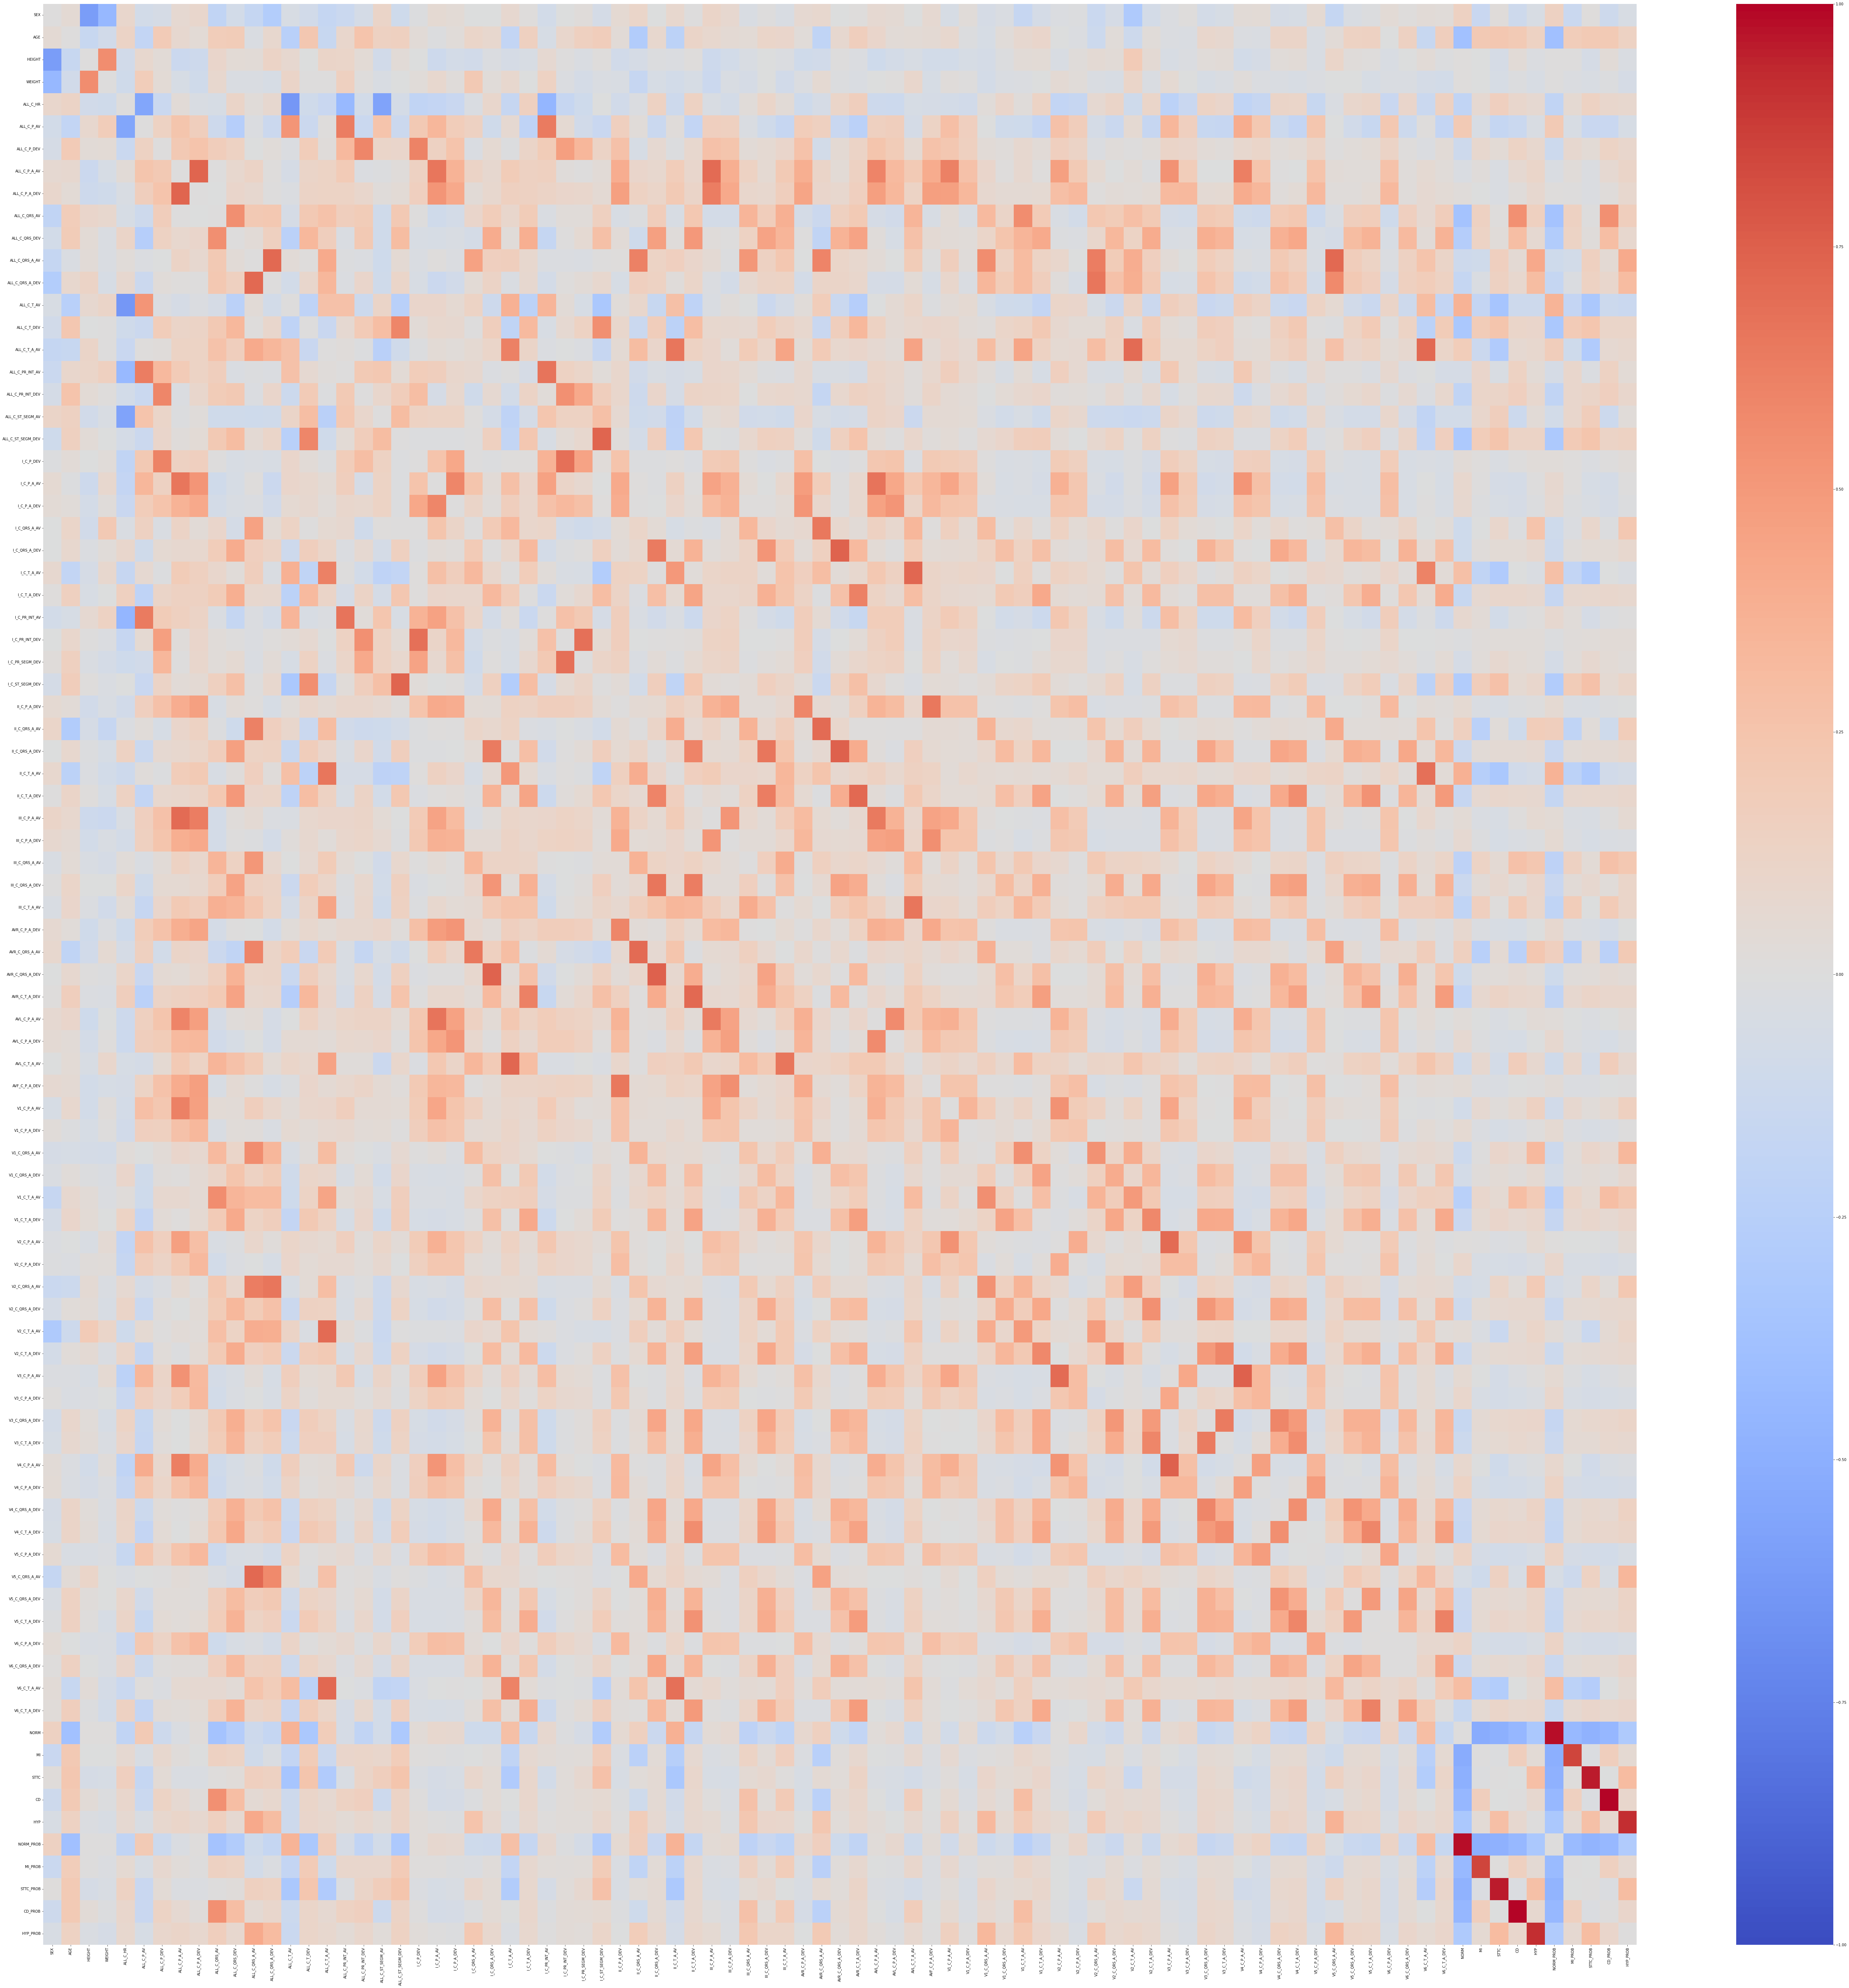

In [43]:
plt.figure(figsize=(100, 100))
sns.heatmap(corr_mat, cmap='coolwarm', vmin=-1, vmax=1)
pass

Корреляции в диагнозах это норма, естественно что у болезней будут корреляции друг с другом, а у здоровых состояний - отрицательная корреляция с больными. Вцелом работу по избавлению от корреляций можно считать завершенной. Осталось только удалить столбцы из исходных данных

In [50]:
train = train.drop([col for col in train.columns if col not in corr_mat.columns], axis=1)

In [52]:
test = test.drop([col for col in test.columns if col not in corr_mat.columns], axis=1)

In [53]:
train.to_csv('proceed_data/train_data_without_corr.csv', index_label='ecg_id')

In [ ]:
test.to_csv('proceed_data/test_data_without_corr.csv', index_label='ecg_id')

## Заполнение пропущенных значений

Снова прочитаем данные для дальнейшей работы

In [2]:
import pandas as pd

In [3]:
train = pd.read_csv('proceed_data/train_data_without_corr.csv', index_col='ecg_id')
test = pd.read_csv('proceed_data/test_data_without_corr.csv', index_col='ecg_id')

Проверим количество пропущенных значений в датасете

In [8]:
train.isna().sum()[train.isna().sum() > 0] / len(train) * 100

AGE        0.353717
HEIGHT    68.309353
WEIGHT    58.405276
dtype: float64

Очень много пропущенных в росте и весе, лучше просто удалить эти столбцы.

In [9]:
train = train.drop(columns=['HEIGHT', 'WEIGHT'])
test = test.drop(columns=['HEIGHT', 'WEIGHT'])

Пропущенный возраст заполним медианой

In [10]:
train.fillna(train.median(axis=0), axis=0, inplace=True)

In [11]:
test.fillna(train.median(axis=0), axis=0, inplace=True)

In [14]:
train.isna().sum()[train.isna().sum() > 0] / len(train) * 100

Series([], dtype: float64)

Бинаризация номинальных признаков не требуется, единственный категориальный признак - пол, и он уже бинаризован:

In [21]:
train['SEX'].value_counts()

0    8653
1    8027
Name: SEX, dtype: int64

## Нормализация признаков

Проведем стандартизацию признаков.

In [44]:
train_stand = (train.loc[:,'SEX':'V6_C_T_A_DEV'] - train.loc[:,'SEX':'V6_C_T_A_DEV'].mean(axis=0)) / train.loc[:,'SEX':'V6_C_T_A_DEV'].std(axis=0)
train_stand = pd.concat([train_stand, train.loc[:, 'NORM':'HYP']], axis=1)

In [45]:
train_stand.describe()

SEX           AGE      ALL_C_HR    ALL_C_P_AV   ALL_C_P_DEV  \
count  1.668000e+04  1.668000e+04  1.668000e+04  1.668000e+04  1.668000e+04   
mean  -2.215121e-17  1.372736e-16 -6.283277e-16 -5.597441e-16  1.527156e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -9.631197e-01 -3.435423e+00 -2.660987e+00 -5.263375e+00 -3.146945e+00   
25%   -9.631197e-01 -5.721174e-01 -5.309767e-01 -3.503053e-01 -6.313784e-01   
50%   -9.631197e-01  8.405666e-02 -1.049745e-01  1.795270e-01 -8.868590e-02   
75%    1.038230e+00  7.402308e-01  3.565278e-01  6.061023e-01  5.891184e-01   
max    1.038230e+00  2.112231e+00  6.462559e+00  2.403515e+00  5.508081e+00   

       ALL_C_P_A_AV  ALL_C_P_A_DEV  ALL_C_QRS_AV  ALL_C_QRS_DEV  \
count  1.668000e+04   1.668000e+04  1.668000e+04   1.668000e+04   
mean   2.078806e-16  -1.678380e-16  2.215121e-17   1.533545e-17   
std    1.000000e+00   1.000000e+00  1.000000e+00   1.000000e+00   
min   -3.079825e+00  -2.707650e+00 -2.028974e+00  -1.136523e+00   
25%   -5.992043e-01  -6.150068e-01 -5.762689e-01  -5.475203e-01   
50%   -5.883197e-02  -1.236609e-01 -2.479837e-01  -3.096899e-01   
75%    5.649066e-01   5.003546e-01  2.007096e-01   1.000947e-01   
max    5.741249e+00   1.386314e+01  7.144561e+00   1.195168e+01   

       ALL_C_QRS_A_AV  ...  V5_C_T_A_DEV  V6_C_P_A_DEV  V6_C_QRS_A_DEV  \
count    1.668000e+04  ...  1.668000e+04  1.668000e+04    1.668000e+04   
mean    -9.201273e-17  ...  5.175716e-17  8.562296e-17   -2.460063e-17   
std      1.000000e+00  ...  1.000000e+00  1.000000e+00    1.000000e+00   
min     -2.863306e+00  ... -6.289787e-01 -1.378960e+00   -6.271251e-01   
25%     -6.909302e-01  ... -3.621532e-01 -4.527193e-01   -3.712924e-01   
50%     -1.363759e-01  ... -2.431341e-01 -8.850926e-02   -2.122490e-01   
75%      5.489060e-01  ... -3.028094e-02  3.372104e-01    5.330297e-02   
max      5.738573e+00  ...  2.990090e+01  2.960548e+01    3.467675e+01   

        V6_C_T_A_AV  V6_C_T_A_DEV          NORM            MI          STTC  \
count  1.668000e+04  1.668000e+04  16680.000000  16680.000000  16680.000000   
mean   1.133120e-16 -3.407879e-17      0.432614      0.259053      0.245504   
std    1.000000e+00  1.000000e+00      0.495453      0.438128      0.430398   
min   -1.771267e+00 -6.870757e-01      0.000000      0.000000      0.000000   
25%   -7.273893e-01 -3.893135e-01      0.000000      0.000000      0.000000   
50%   -1.721166e-01 -2.555485e-01      0.000000      0.000000      0.000000   
75%    5.359194e-01 -1.500834e-02      1.000000      1.000000      0.000000   
max    6.985219e+00  2.543884e+01      1.000000      1.000000      1.000000   

                 CD           HYP  
count  16680.000000  16680.000000  
mean       0.207434      0.123201  
std        0.405481      0.328678  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000  

[8 rows x 80 columns]

In [47]:
test_stand = (test.loc[:,'SEX':'V6_C_T_A_DEV'] - train.loc[:,'SEX':'V6_C_T_A_DEV'].mean(axis=0)) / train.loc[:,'SEX':'V6_C_T_A_DEV'].std(axis=0)
test_stand = pd.concat([test_stand, test.loc[:, 'NORM':'HYP']], axis=1)

In [49]:
train_stand.to_csv('proceed_data/final_train_data.csv', index_label='ecg_id')
test_stand.to_csv('proceed_data/final_test_data.csv', index_label='ecg_id')

In [48]:
test_stand

SEX       AGE  ALL_C_HR  ALL_C_P_AV  ALL_C_P_DEV  ALL_C_P_A_AV  \
ecg_id                                                                       
8      -0.96312 -0.691422 -0.104975    0.772410     0.372650     -0.293116   
9      -0.96312 -0.273856 -0.530977    0.440621    -0.431844     -0.825010   
10      1.03823 -2.242379 -0.530977    0.203633    -0.194067     -0.754353   
17     -0.96312 -0.214204  3.800045   -5.263375    -3.146945     -3.079825   
18     -0.96312 -0.214204  3.267542   -5.263375    -3.146945     -3.079825   
...         ...       ...       ...         ...          ...           ...   
21818   1.03823  1.456057 -0.104975    0.546527    -0.109712      0.862080   
21819  -0.96312 -0.333509  1.244032    0.057841     0.824967      1.141813   
21826   1.03823  1.336753 -0.104975   -0.692319     0.902908      1.490221   
21831   1.03823 -0.273856  0.747030   -0.579700    -0.368508     -1.209363   
21837  -0.96312  0.501622 -0.956979   -0.445560     0.547845     -0.161088   

        ALL_C_P_A_DEV  ALL_C_QRS_AV  ALL_C_QRS_DEV  ALL_C_QRS_A_AV  ...  \
ecg_id                                                              ...   
8           -0.506976     -0.975952      -0.204408        0.521072  ...   
9           -0.814818     -0.275022      -0.418477        0.080573  ...   
10          -1.000565     -0.883213      -0.444970       -0.748434  ...   
17          -2.707650     -0.919585       1.066580        0.770900  ...   
18          -2.707650     -0.398813       1.091985        0.523534  ...   
...               ...           ...            ...             ...  ...   
21818        1.989792      0.103601      -0.320511        0.766815  ...   
21819        1.271342     -0.378658      -0.246062       -0.147759  ...   
21826        2.991216     -0.000508       1.138412       -0.411428  ...   
21831       -0.371835     -0.847248      -0.627502       -1.535027  ...   
21837       -0.317126     -0.958902      -0.542099        0.060421  ...   

        V5_C_T_A_DEV  V6_C_P_A_DEV  V6_C_QRS_A_DEV  V6_C_T_A_AV  V6_C_T_A_DEV  \
ecg_id                                                                          
8          -0.267024     -0.328526       -0.365123     0.838427     -0.420487   
9          -0.415628     -0.798349       -0.486753     0.397386     -0.355357   
10         -0.187041     -0.589331       -0.383577     0.252160     -0.237805   
17          0.788018     -1.378960        0.883573     0.366928      1.462364   
18          0.165134     -1.378960        0.189839    -0.268661      0.077908   
...              ...           ...             ...          ...           ...   
21818      -0.486072      0.201736       -0.338254     1.106950     -0.244339   
21819      -0.421726     -0.546488       -0.370546    -0.213885     -0.161108   
21826      -0.293868      0.366928       -0.347076    -0.450192     -0.224576   
21831      -0.489475     -0.059687       -0.469253     0.490468     -0.481857   
21837      -0.243534     -0.321357        0.238974    -0.228355     -0.116018   

        NORM  MI  STTC  CD  HYP  
ecg_id                           
8          0   1     0   0    0  
9          1   0     0   0    0  
10         1   0     0   0    0  
17         0   0     0   0    0  
18         0   0     0   0    0  
...      ...  ..   ...  ..  ...  
21818      1   0     0   0    0  
21819      0   0     0   1    0  
21826      0   1     0   0    0  
21831      1   0     0   0    0  
21837      1   0     0   0    0  

[4396 rows x 80 columns]

## Обучаем модель

Прочитаем данные для дальнейшей работы

In [50]:
train = pd.read_csv('proceed_data/final_train_data.csv', index_col='ecg_id')
test = pd.read_csv('proceed_data/final_test_data.csv', index_col='ecg_id')

Для начала отделим данные от классов

In [54]:
X_train = train.loc[:,'SEX':'V6_C_T_A_DEV']
y_train = train.loc[:,'NORM':'HYP']
X_test = test.loc[:,'SEX':'V6_C_T_A_DEV']
y_test = test.loc[:,'NORM':'HYP']

### KNN

Построим линейную модель классификатора k-ближайших соседей и подберем оптимальный k в диапазоне от 1 до 100. Перед нами встает проблема оценки мультиклассовой классификации. Будем вычислять accuracy как процент задетектированных сэмплов. precision, recall и f1_score будем вычислять глобально - через общее число положительных, отрицательных, ложноположительных и ложноотрицательных примеров.

In [57]:
from sklearn.neighbors import KNeighborsClassifier

In [124]:
accuracy = {'train': [], 'test': []}
f1 = {'train': [], 'test': []}
precision = {'train': [], 'test': []}
recall = {'train': [], 'test': []}
for k in range(1, 101):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train.values, y_train)
    y_train_pred = model.predict(X_train.values)
    y_test_pred = model.predict(X_test.values)
    accuracy['train'].append(accuracy_score(y_train, y_train_pred))
    accuracy['test'].append(accuracy_score(y_test, y_test_pred))
    precision['train'].append(precision_score(y_train, y_train_pred, average='micro'))
    precision['test'].append(precision_score(y_test, y_test_pred, average='micro'))
    recall['train'].append(recall_score(y_train, y_train_pred, average='micro'))
    recall['test'].append(recall_score(y_test, y_test_pred, average='micro'))
    f1['train'].append(f1_score(y_train, y_train_pred, average='micro'))
    f1['test'].append(f1_score(y_test, y_test_pred, average='micro'))

In [129]:
from matplotlib import pyplot as plt

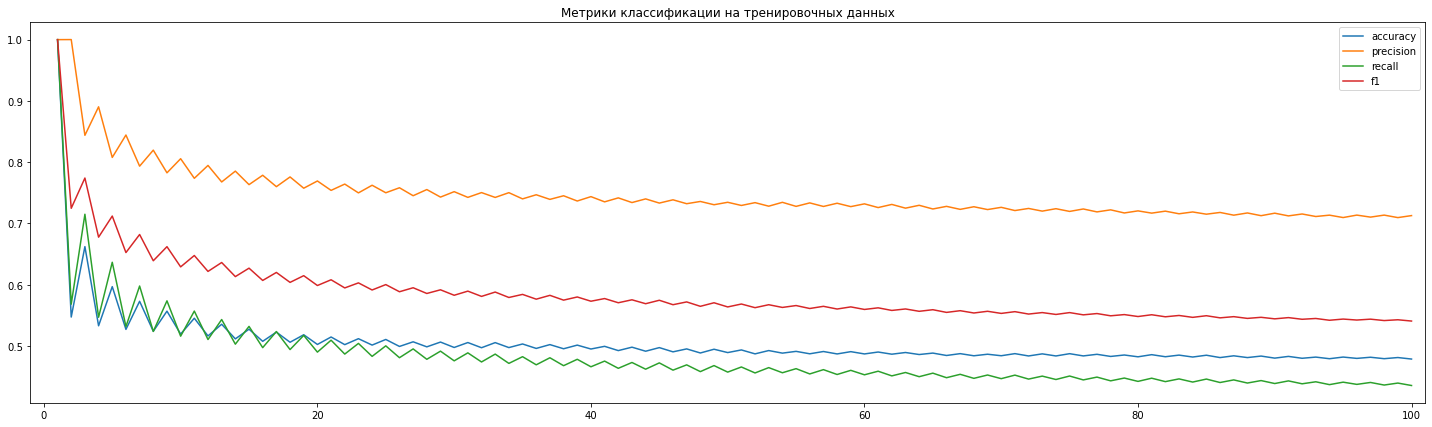

In [159]:
plt.figure(figsize=(25,7))
plt.xlim(left=-1, right=101)
plt.plot(range(1, 101), accuracy['train'], label='accuracy')
plt.plot(range(1, 101), precision['train'], label='precision')
plt.plot(range(1, 101), recall['train'], label='recall')
plt.plot(range(1, 101), f1['train'], label='f1')
plt.legend()
plt.title('Метрики классификации на тренировочных данных')
pass

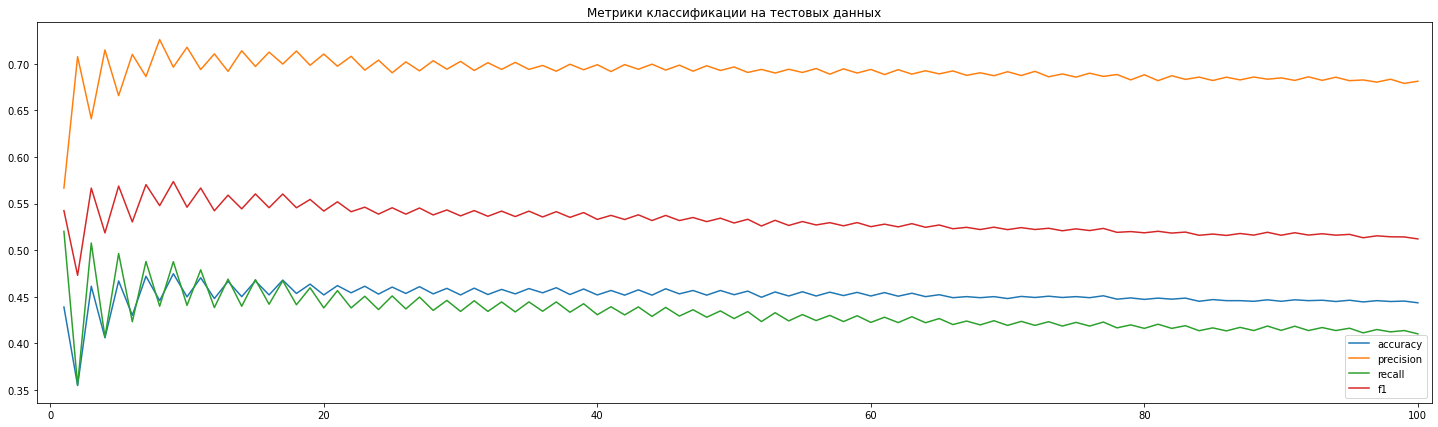

In [160]:
plt.figure(figsize=(25,7))
plt.xlim(left=-1, right=101)
plt.plot(range(1, 101), accuracy['test'], label='accuracy')
plt.plot(range(1, 101), precision['test'], label='precision')
plt.plot(range(1, 101), recall['test'], label='recall')
plt.plot(range(1, 101), f1['test'], label='f1')
plt.legend()
plt.title('Метрики классификации на тестовых данных')
pass

Т.к. у нас задача связана с медицинской диагностикой, будем выбирать классификатор по recall - нам важно получить как можно меньше ложноотрицательных случаев пусть даже за счет увеличения ложноположительных. По этому параметру лучше всего себя показывает метод 1, 3, 5, 7 и 9 соседей. Думаю лучше всего выбрать метод 9 соседей, т.к. при нем наблюдается максимальный f1_score и достаточно высокий precision, несмотря на то, что максимальный по recall будет метод 1го соседа

Построим такие же графики по методу ближайшего соседа, но изобразим метрики по каждому из признаков вместо обобщенных по мультиклассовой классификации. Строить будем сразу на тестовых данных.

In [204]:
accuracy = {'NORM':[], 'MI':[], 'STTC':[], 'CD':[], 'HYP':[]}
f1 = {'NORM':[], 'MI':[], 'STTC':[], 'CD':[], 'HYP':[]}
precision = {'NORM':[], 'MI':[], 'STTC':[], 'CD':[], 'HYP':[]}
recall = {'NORM':[], 'MI':[], 'STTC':[], 'CD':[], 'HYP':[]}
for feature in accuracy.keys():
    for k in range(1, 101):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train.values, y_train[feature])
        y_test_pred = model.predict(X_test.values)
        accuracy[feature].append(accuracy_score(y_test[feature], y_test_pred))
        precision[feature].append(precision_score(y_test[feature], y_test_pred))
        recall[feature].append(recall_score(y_test[feature], y_test_pred))
        f1[feature].append(f1_score(y_test[feature], y_test_pred))

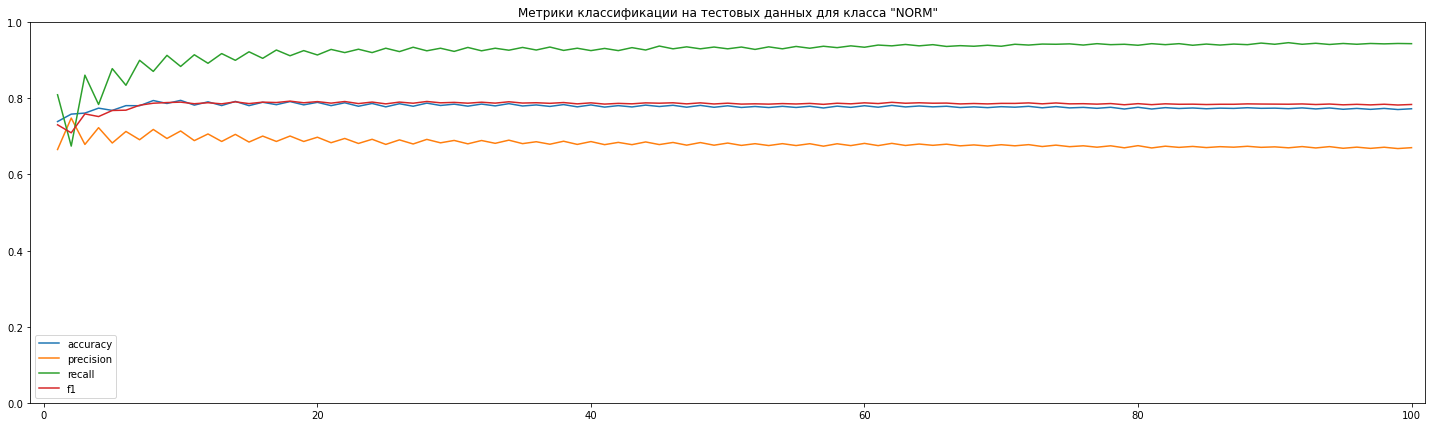

In [205]:
plt.figure(figsize=(25,7))
plt.xlim(left=-1, right=101)
plt.ylim(bottom=0, top=1)
plt.plot(range(1, 101), accuracy['NORM'], label='accuracy')
plt.plot(range(1, 101), precision['NORM'], label='precision')
plt.plot(range(1, 101), recall['NORM'], label='recall')
plt.plot(range(1, 101), f1['NORM'], label='f1')
plt.legend()
plt.title('Метрики классификации на тестовых данных для класса "NORM"')
pass

In [212]:
y_train['NORM'].value_counts()

0    9464
1    7216
Name: NORM, dtype: int64

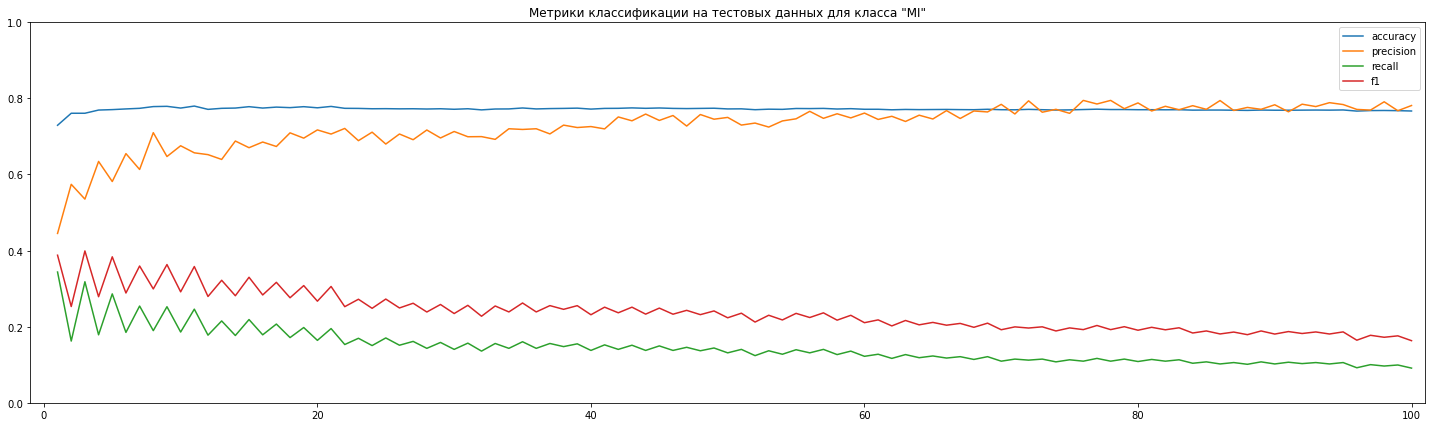

In [206]:
plt.figure(figsize=(25,7))
plt.xlim(left=-1, right=101)
plt.ylim(bottom=0, top=1)
plt.plot(range(1, 101), accuracy['MI'], label='accuracy')
plt.plot(range(1, 101), precision['MI'], label='precision')
plt.plot(range(1, 101), recall['MI'], label='recall')
plt.plot(range(1, 101), f1['MI'], label='f1')
plt.legend()
plt.title('Метрики классификации на тестовых данных для класса "MI"')
pass

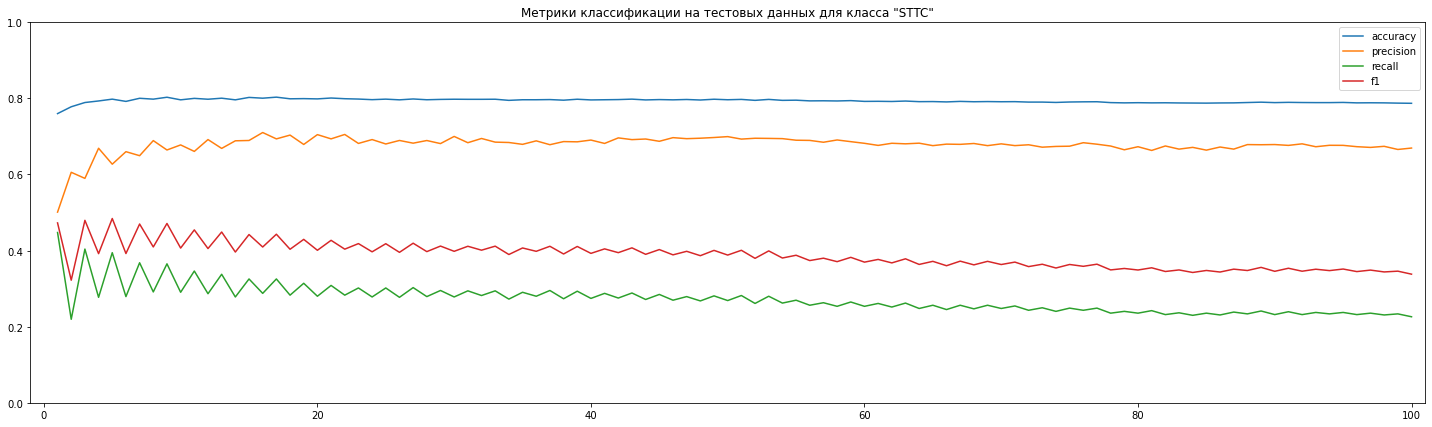

In [208]:
plt.figure(figsize=(25,7))
plt.xlim(left=-1, right=101)
plt.ylim(bottom=0, top=1)
plt.plot(range(1, 101), accuracy['STTC'], label='accuracy')
plt.plot(range(1, 101), precision['STTC'], label='precision')
plt.plot(range(1, 101), recall['STTC'], label='recall')
plt.plot(range(1, 101), f1['STTC'], label='f1')
plt.legend()
plt.title('Метрики классификации на тестовых данных для класса "STTC"')
pass

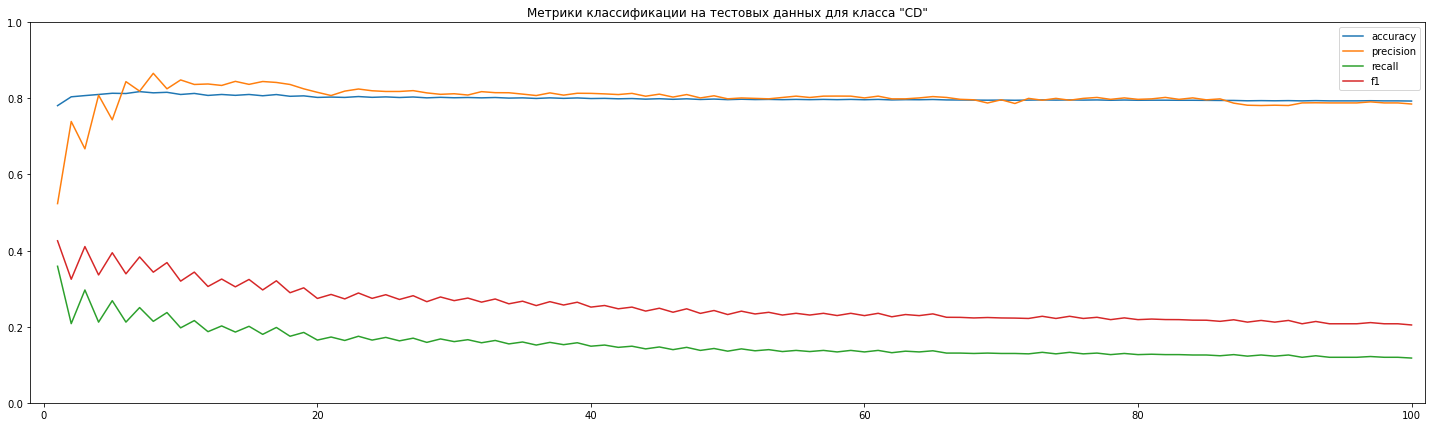

In [209]:
plt.figure(figsize=(25,7))
plt.xlim(left=-1, right=101)
plt.ylim(bottom=0, top=1)
plt.plot(range(1, 101), accuracy['CD'], label='accuracy')
plt.plot(range(1, 101), precision['CD'], label='precision')
plt.plot(range(1, 101), recall['CD'], label='recall')
plt.plot(range(1, 101), f1['CD'], label='f1')
plt.legend()
plt.title('Метрики классификации на тестовых данных для класса "CD"')
pass

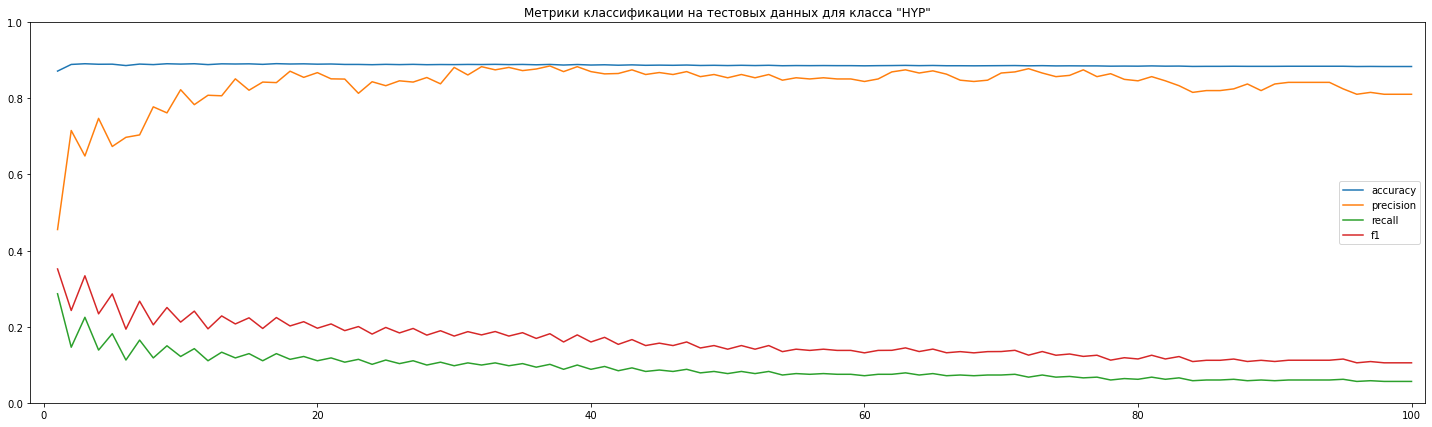

In [210]:
plt.figure(figsize=(25,7))
plt.xlim(left=-1, right=101)
plt.ylim(bottom=0, top=1)
plt.plot(range(1, 101), accuracy['HYP'], label='accuracy')
plt.plot(range(1, 101), precision['HYP'], label='precision')
plt.plot(range(1, 101), recall['HYP'], label='recall')
plt.plot(range(1, 101), f1['HYP'], label='f1')
plt.legend()
plt.title('Метрики классификации на тестовых данных для класса "HYP"')
pass

# Общие выводы

KNN показал достаточно плохой результат по мультиклассовой классификации в связи с нелинейностью данной задачи, а на отдельных признаках показал лучшую чем на мультиклассовой классификации точность, но при этом крайне низкий recall. Можно было бы связать это с высокой несбалансированностью датасета, но, к примеру, у достаточно сбалансированного признака "NORM" все еще крайне низкий recall. Это может говорить о нелинейности задачи вцелом и необходимости применения более сложных подходов